#	Read the machine_temp_failure_missing.csv dataset into a Pandas DataFrame, must use PathLib. Inspect the dataset, and look for missing values if there are any. Find statistics such as mean, max, min. Rename the value column to temperature. 


In [12]:
from pathlib import Path
import pandas as pd

dataset = Path("machine_temp_failure_missing.csv")

# Read and inspect the dataset 
df = pd.read_csv(dataset)
print("Dataset Information:")
print(df.info())

# missing values
print("\nMissing Values:")
print(df.isnull().sum())

# Calculations
stats = df.describe()
print("\nStatistics:")
print(stats)

# Rename the 'value' column to 'temperature'
df.rename(columns={"value": "temperature"}, inplace=True)

print("\nUpdated:")
print(df.head())


Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22695 entries, 0 to 22694
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  22695 non-null  object 
 1   value      21410 non-null  float64
dtypes: float64(1), object(1)
memory usage: 354.7+ KB
None

Missing Values:
timestamp       0
value        1285
dtype: int64

Statistics:
              value
count  21410.000000
mean      85.968188
std       13.553070
min        2.084721
25%       83.082867
50%       89.251290
75%       93.910748
max      108.510543

Updated:
          timestamp  temperature
0  02-12-2013 21:15    73.967322
1  02-12-2013 21:20    74.935882
2  02-12-2013 21:25    76.124162
3  02-12-2013 21:30    78.140707
4  02-12-2013 21:35    79.329836


#	Create a new feature delta_temperature which would be temp[i+1] - temp[i] where i is in range(Index). The feature represents the difference between consecutive temperature values. 

In [13]:
df.rename(columns={"value": "temperature"}, inplace=True)

# delta_temperature
df['delta_temperature'] = df['temperature'].diff()

# updated DataFrame
print("Updated:")
print(df.head())


Updated:
          timestamp  temperature  delta_temperature
0  02-12-2013 21:15    73.967322                NaN
1  02-12-2013 21:20    74.935882           0.968560
2  02-12-2013 21:25    76.124162           1.188280
3  02-12-2013 21:30    78.140707           2.016546
4  02-12-2013 21:35    79.329836           1.189128


#	Generate two separate plots for temperature and delta_temperature using both matplotlib and hvPlot.

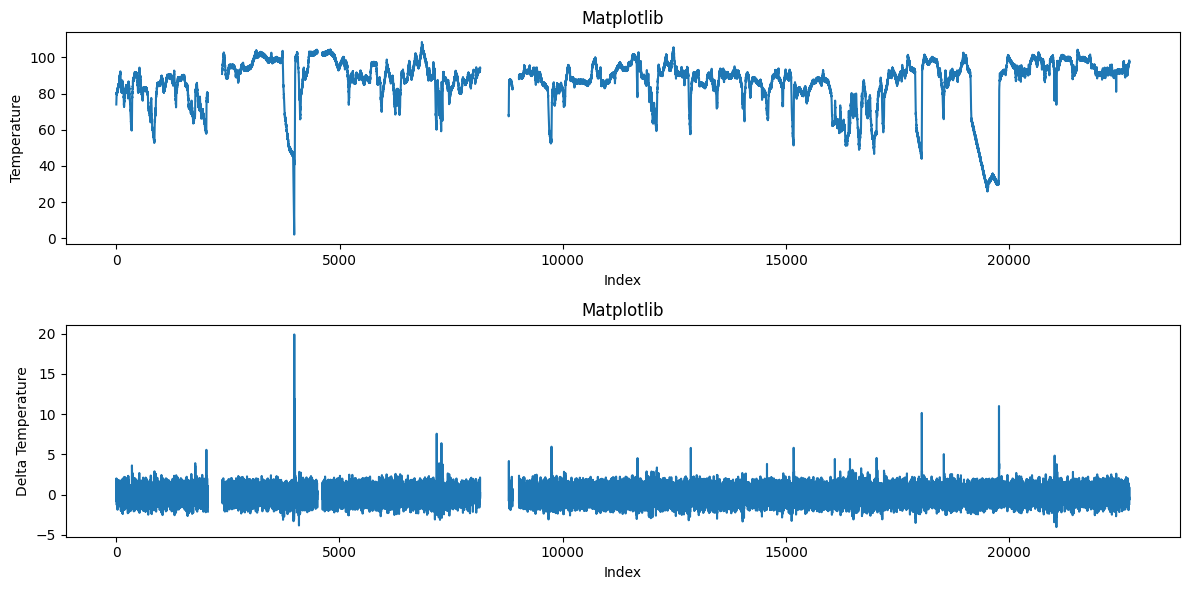

:Layout
   .Curve.I  :Curve   [index]   (temperature)
   .Curve.II :Curve   [index]   (delta_temperature)

In [14]:

import matplotlib.pyplot as plt
import hvplot.pandas

# By Matplotlib
plt.figure(figsize=(12,6))

# Plot for temperature
plt.subplot(2, 1, 1)
plt.plot(df.index, df['temperature'])
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.title('Matplotlib')

# Plot for delta_temperature
plt.subplot(2, 1, 2)
plt.plot(df.index, df['delta_temperature'])
plt.xlabel('Index')
plt.ylabel('Delta Temperature')
plt.title('Matplotlib')

plt.tight_layout()
plt.show()

# By hvPlot
temperature_plot = df.hvplot.line(x='index', y='temperature', xlabel='Index', ylabel='Temperature', title='hvplot')
delta_temperature_plot = df.hvplot.line(x='index', y='delta_temperature', xlabel='Index', ylabel='Delta Temperature', title='hvplot')

temperature_plot + delta_temperature_plot


#	Generate a plot in which temperature values greater than 70.00 are marked as red, and those below 70.00 are marked as blue. 

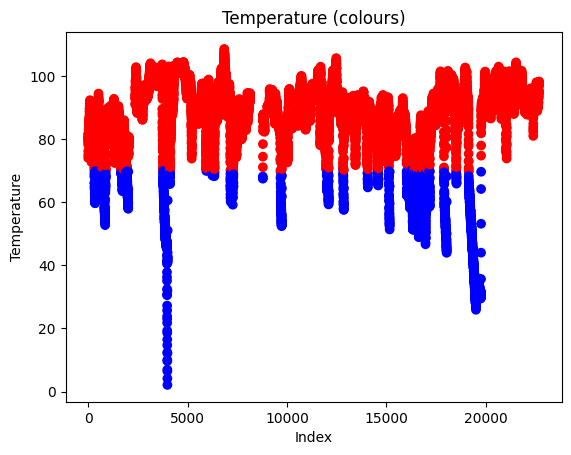

In [15]:
colors = ['red' if temp > 70.00 else 'blue' 
          for temp in df['temperature']]

# Plot temperature 
plt.scatter(df.index, df['temperature'], c=colors)
plt.xlabel('Index')
plt.ylabel('Temperature')
plt.title('Temperature (colours)')
plt.show()


#	Write three functions read_datasets(), plot_dfs(), rmse_score() for these datasets (as discussed in 1_4 notebook).

In [16]:
def read_dataset(folder, file, date=None):
  
    df = pd.read_csv(folder / file, 
                     index_col=date, 
                     parse_dates=[date])
    return df


In [17]:
def plot_dfs(df1, df2, col, title=None, xlabel=None, ylabel=None):
    '''	
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data
    '''    
    df_missing = df2.rename(columns={col: 'missing'})
    
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    subplots_size = len(columns)
    

    fig, ax = plt.subplots(subplots_size+1, 1, sharex=True)
    plt.subplots_adjust(hspace=0.25)
    fig.suptitle = title 
    
    df1[col].plot(ax=ax[0], figsize=(10, 16))
    ax[0].set_title('Original Dataset')
    ax[0].set_xlabel(xlabel)
    ax[0].set_ylabel(ylabel)    
    
    for i, colname in enumerate(columns):
        df_missing[colname].plot(ax=ax[i+1])
        ax[i+1].set_title(colname)

    plt.show()


In [18]:
def rmse_score(df1, df2, col=None):
    '''
    df1: original dataframe without missing data
    df2: dataframe with missing data
    col: column name that contains missing data

    returns: a list of scores
    '''
    df_missing = df2.rename(columns={col: 'missing'})
    columns = df_missing.loc[:, 'missing':].columns.tolist()
    scores = []
    for comp_col in columns[1:]:
        rmse = np.sqrt(np.mean((df1[col] - df_missing[comp_col])**2))
        scores.append(rmse)
        print(f'RMSE for {comp_col}: {rmse}')
    return scores


#	Perform univariate imputation on temperature and  using Pandas (mean, ffill, bfill) and Scikit-Learn (SimpleImputer), and interpolation. Compare the RMSE score for each imputation with machine_temp_failure_original.csv  and find the method with the least RMSE score.

In [19]:
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
import numpy as np


original_df = pd.read_csv("machine_temp_failure_original.csv")


mean_imputed_df = df.copy()
mean_imputed_df['temperature'].fillna(df['temperature'].mean(), inplace=True)


ffill_imputed_df = df.copy()
ffill_imputed_df['temperature'].fillna(method='ffill', inplace=True)

bfill_imputed_df = df.copy()
bfill_imputed_df['temperature'].fillna(method='bfill', inplace=True)


interpolation_imputed_df = df.copy()
interpolation_imputed_df['temperature'].interpolate(method='linear', inplace=True)


imputer = SimpleImputer(strategy='mean')
sklearn_mean_imputed = imputer.fit_transform(df[['temperature']])
sklearn_mean_imputed_df = df.copy()
sklearn_mean_imputed_df['temperature'] = sklearn_mean_imputed


mean_rmse = np.sqrt(mean_squared_error(original_df['value'], mean_imputed_df['temperature']))
ffill_rmse = np.sqrt(mean_squared_error(original_df['value'], ffill_imputed_df['temperature']))
bfill_rmse = np.sqrt(mean_squared_error(original_df['value'], bfill_imputed_df['temperature']))
interpolation_rmse = np.sqrt(mean_squared_error(original_df['value'], interpolation_imputed_df['temperature']))
sklearn_mean_rmse = np.sqrt(mean_squared_error(original_df['value'], sklearn_mean_imputed_df['temperature']))


print("RMSE Scores:")
print("Mean Imputation (Pandas):", mean_rmse)
print("Forward-fill (ffill) Imputation (Pandas):", ffill_rmse)
print("Backward-fill (bfill) Imputation (Pandas):", bfill_rmse)
print("Interpolation Imputation (Pandas):", interpolation_rmse)
print("Mean Imputation (Scikit-Learn):", sklearn_mean_rmse)


RMSE Scores:
Mean Imputation (Pandas): 3.961536496226712
Forward-fill (ffill) Imputation (Pandas): 2.4939956524274454
Backward-fill (bfill) Imputation (Pandas): 5.873128567455812
Interpolation Imputation (Pandas): 4.043203597694257
Mean Imputation (Scikit-Learn): 3.961536496226712


#	Now the dataset will have no missing values. Check the frequency of data and resample the dataset to an hourly frequency. 

In [21]:

data_frequency = df['temperature'].value_counts()
print("Data Frequency:")
print(data_frequency)

df.index = pd.to_datetime(df.index)


df_hourly = df.resample('H').mean()

df_hourly.dropna(inplace=True)


print("\nResampled Dataset (Hourly Frequency):")
print(df_hourly.head())


Data Frequency:
temperature
73.967322    1
79.926638    1
77.842853    1
78.705237    1
78.184969    1
            ..
85.841295    1
86.896794    1
86.182052    1
85.922123    1
96.903861    1
Name: count, Length: 21410, dtype: int64


TypeError: Could not convert 02-12-2013 21:1502-12-2013 21:2002-12-2013 21:2502-12-2013 21:3002-12-2013 21:3502-12-2013 21:4002-12-2013 21:4502-12-2013 21:5002-12-2013 21:5502-12-2013 22:0002-12-2013 22:0502-12-2013 22:1002-12-2013 22:1502-12-2013 22:2002-12-2013 22:2502-12-2013 22:3002-12-2013 22:3502-12-2013 22:4002-12-2013 22:4502-12-2013 22:5002-12-2013 22:5502-12-2013 23:0002-12-2013 23:0502-12-2013 23:1002-12-2013 23:1502-12-2013 23:2002-12-2013 23:2502-12-2013 23:3002-12-2013 23:3502-12-2013 23:4002-12-2013 23:4502-12-2013 23:5002-12-2013 23:5503-12-2013 00:0003-12-2013 00:0503-12-2013 00:1003-12-2013 00:1503-12-2013 00:2003-12-2013 00:2503-12-2013 00:3003-12-2013 00:3503-12-2013 00:4003-12-2013 00:4503-12-2013 00:5003-12-2013 00:5503-12-2013 01:0003-12-2013 01:0503-12-2013 01:1003-12-2013 01:1503-12-2013 01:2003-12-2013 01:2503-12-2013 01:3003-12-2013 01:3503-12-2013 01:4003-12-2013 01:4503-12-2013 01:5003-12-2013 01:5503-12-2013 02:0003-12-2013 02:0503-12-2013 02:1003-12-2013 02:1503-12-2013 02:2003-12-2013 02:2503-12-2013 02:3003-12-2013 02:3503-12-2013 02:4003-12-2013 02:4503-12-2013 02:5003-12-2013 02:5503-12-2013 03:0003-12-2013 03:0503-12-2013 03:1003-12-2013 03:1503-12-2013 03:2003-12-2013 03:2503-12-2013 03:3003-12-2013 03:3503-12-2013 03:4003-12-2013 03:4503-12-2013 03:5003-12-2013 03:5503-12-2013 04:0003-12-2013 04:0503-12-2013 04:1003-12-2013 04:1503-12-2013 04:2003-12-2013 04:2503-12-2013 04:3003-12-2013 04:3503-12-2013 04:4003-12-2013 04:4503-12-2013 04:5003-12-2013 04:5503-12-2013 05:0003-12-2013 05:0503-12-2013 05:1003-12-2013 05:1503-12-2013 05:2003-12-2013 05:2503-12-2013 05:3003-12-2013 05:3503-12-2013 05:4003-12-2013 05:4503-12-2013 05:5003-12-2013 05:5503-12-2013 06:0003-12-2013 06:0503-12-2013 06:1003-12-2013 06:1503-12-2013 06:2003-12-2013 06:2503-12-2013 06:3003-12-2013 06:3503-12-2013 06:4003-12-2013 06:4503-12-2013 06:5003-12-2013 06:5503-12-2013 07:0003-12-2013 07:0503-12-2013 07:1003-12-2013 07:1503-12-2013 07:2003-12-2013 07:2503-12-2013 07:3003-12-2013 07:3503-12-2013 07:4003-12-2013 07:4503-12-2013 07:5003-12-2013 07:5503-12-2013 08:0003-12-2013 08:0503-12-2013 08:1003-12-2013 08:1503-12-2013 08:2003-12-2013 08:2503-12-2013 08:3003-12-2013 08:3503-12-2013 08:4003-12-2013 08:4503-12-2013 08:5003-12-2013 08:5503-12-2013 09:0003-12-2013 09:0503-12-2013 09:1003-12-2013 09:1503-12-2013 09:2003-12-2013 09:2503-12-2013 09:3003-12-2013 09:3503-12-2013 09:4003-12-2013 09:4503-12-2013 09:5003-12-2013 09:5503-12-2013 10:0003-12-2013 10:0503-12-2013 10:1003-12-2013 10:1503-12-2013 10:2003-12-2013 10:2503-12-2013 10:3003-12-2013 10:3503-12-2013 10:4003-12-2013 10:4503-12-2013 10:5003-12-2013 10:5503-12-2013 11:0003-12-2013 11:0503-12-2013 11:1003-12-2013 11:1503-12-2013 11:2003-12-2013 11:2503-12-2013 11:3003-12-2013 11:3503-12-2013 11:4003-12-2013 11:4503-12-2013 11:5003-12-2013 11:5503-12-2013 12:0003-12-2013 12:0503-12-2013 12:1003-12-2013 12:1503-12-2013 12:2003-12-2013 12:2503-12-2013 12:3003-12-2013 12:3503-12-2013 12:4003-12-2013 12:4503-12-2013 12:5003-12-2013 12:5503-12-2013 13:0003-12-2013 13:0503-12-2013 13:1003-12-2013 13:1503-12-2013 13:2003-12-2013 13:2503-12-2013 13:3003-12-2013 13:3503-12-2013 13:4003-12-2013 13:4503-12-2013 13:5003-12-2013 13:5503-12-2013 14:0003-12-2013 14:0503-12-2013 14:1003-12-2013 14:1503-12-2013 14:2003-12-2013 14:2503-12-2013 14:3003-12-2013 14:3503-12-2013 14:4003-12-2013 14:4503-12-2013 14:5003-12-2013 14:5503-12-2013 15:0003-12-2013 15:0503-12-2013 15:1003-12-2013 15:1503-12-2013 15:2003-12-2013 15:2503-12-2013 15:3003-12-2013 15:3503-12-2013 15:4003-12-2013 15:4503-12-2013 15:5003-12-2013 15:5503-12-2013 16:0003-12-2013 16:0503-12-2013 16:1003-12-2013 16:1503-12-2013 16:2003-12-2013 16:2503-12-2013 16:3003-12-2013 16:3503-12-2013 16:4003-12-2013 16:4503-12-2013 16:5003-12-2013 16:5503-12-2013 17:0003-12-2013 17:0503-12-2013 17:1003-12-2013 17:1503-12-2013 17:2003-12-2013 17:2503-12-2013 17:3003-12-2013 17:3503-12-2013 17:4003-12-2013 17:4503-12-2013 17:5003-12-2013 17:5503-12-2013 18:0003-12-2013 18:0503-12-2013 18:1003-12-2013 18:1503-12-2013 18:2003-12-2013 18:2503-12-2013 18:3003-12-2013 18:3503-12-2013 18:4003-12-2013 18:4503-12-2013 18:5003-12-2013 18:5503-12-2013 19:0003-12-2013 19:0503-12-2013 19:1003-12-2013 19:1503-12-2013 19:2003-12-2013 19:2503-12-2013 19:3003-12-2013 19:3503-12-2013 19:4003-12-2013 19:4503-12-2013 19:5003-12-2013 19:5503-12-2013 20:0003-12-2013 20:0503-12-2013 20:1003-12-2013 20:1503-12-2013 20:2003-12-2013 20:2503-12-2013 20:3003-12-2013 20:3503-12-2013 20:4003-12-2013 20:4503-12-2013 20:5003-12-2013 20:5503-12-2013 21:0003-12-2013 21:0503-12-2013 21:1003-12-2013 21:1503-12-2013 21:2003-12-2013 21:2503-12-2013 21:3003-12-2013 21:3503-12-2013 21:4003-12-2013 21:4503-12-2013 21:5003-12-2013 21:5503-12-2013 22:0003-12-2013 22:0503-12-2013 22:1003-12-2013 22:1503-12-2013 22:2003-12-2013 22:2503-12-2013 22:3003-12-2013 22:3503-12-2013 22:4003-12-2013 22:4503-12-2013 22:5003-12-2013 22:5503-12-2013 23:0003-12-2013 23:0503-12-2013 23:1003-12-2013 23:1503-12-2013 23:2003-12-2013 23:2503-12-2013 23:3003-12-2013 23:3503-12-2013 23:4003-12-2013 23:4503-12-2013 23:5003-12-2013 23:5504-12-2013 00:0004-12-2013 00:0504-12-2013 00:1004-12-2013 00:1504-12-2013 00:2004-12-2013 00:2504-12-2013 00:3004-12-2013 00:3504-12-2013 00:4004-12-2013 00:4504-12-2013 00:5004-12-2013 00:5504-12-2013 01:0004-12-2013 01:0504-12-2013 01:1004-12-2013 01:1504-12-2013 01:2004-12-2013 01:2504-12-2013 01:3004-12-2013 01:3504-12-2013 01:4004-12-2013 01:4504-12-2013 01:5004-12-2013 01:5504-12-2013 02:0004-12-2013 02:0504-12-2013 02:1004-12-2013 02:1504-12-2013 02:2004-12-2013 02:2504-12-2013 02:3004-12-2013 02:3504-12-2013 02:4004-12-2013 02:4504-12-2013 02:5004-12-2013 02:5504-12-2013 03:0004-12-2013 03:0504-12-2013 03:1004-12-2013 03:1504-12-2013 03:2004-12-2013 03:2504-12-2013 03:3004-12-2013 03:3504-12-2013 03:4004-12-2013 03:4504-12-2013 03:5004-12-2013 03:5504-12-2013 04:0004-12-2013 04:0504-12-2013 04:1004-12-2013 04:1504-12-2013 04:2004-12-2013 04:2504-12-2013 04:3004-12-2013 04:3504-12-2013 04:4004-12-2013 04:4504-12-2013 04:5004-12-2013 04:5504-12-2013 05:0004-12-2013 05:0504-12-2013 05:1004-12-2013 05:1504-12-2013 05:2004-12-2013 05:2504-12-2013 05:3004-12-2013 05:3504-12-2013 05:4004-12-2013 05:4504-12-2013 05:5004-12-2013 05:5504-12-2013 06:0004-12-2013 06:0504-12-2013 06:1004-12-2013 06:1504-12-2013 06:2004-12-2013 06:2504-12-2013 06:3004-12-2013 06:3504-12-2013 06:4004-12-2013 06:4504-12-2013 06:5004-12-2013 06:5504-12-2013 07:0004-12-2013 07:0504-12-2013 07:1004-12-2013 07:1504-12-2013 07:2004-12-2013 07:2504-12-2013 07:3004-12-2013 07:3504-12-2013 07:4004-12-2013 07:4504-12-2013 07:5004-12-2013 07:5504-12-2013 08:0004-12-2013 08:0504-12-2013 08:1004-12-2013 08:1504-12-2013 08:2004-12-2013 08:2504-12-2013 08:3004-12-2013 08:3504-12-2013 08:4004-12-2013 08:4504-12-2013 08:5004-12-2013 08:5504-12-2013 09:0004-12-2013 09:0504-12-2013 09:1004-12-2013 09:1504-12-2013 09:2004-12-2013 09:2504-12-2013 09:3004-12-2013 09:3504-12-2013 09:4004-12-2013 09:4504-12-2013 09:5004-12-2013 09:5504-12-2013 10:0004-12-2013 10:0504-12-2013 10:1004-12-2013 10:1504-12-2013 10:2004-12-2013 10:2504-12-2013 10:3004-12-2013 10:3504-12-2013 10:4004-12-2013 10:4504-12-2013 10:5004-12-2013 10:5504-12-2013 11:0004-12-2013 11:0504-12-2013 11:1004-12-2013 11:1504-12-2013 11:2004-12-2013 11:2504-12-2013 11:3004-12-2013 11:3504-12-2013 11:4004-12-2013 11:4504-12-2013 11:5004-12-2013 11:5504-12-2013 12:0004-12-2013 12:0504-12-2013 12:1004-12-2013 12:1504-12-2013 12:2004-12-2013 12:2504-12-2013 12:3004-12-2013 12:3504-12-2013 12:4004-12-2013 12:4504-12-2013 12:5004-12-2013 12:5504-12-2013 13:0004-12-2013 13:0504-12-2013 13:1004-12-2013 13:1504-12-2013 13:2004-12-2013 13:2504-12-2013 13:3004-12-2013 13:3504-12-2013 13:4004-12-2013 13:4504-12-2013 13:5004-12-2013 13:5504-12-2013 14:0004-12-2013 14:0504-12-2013 14:1004-12-2013 14:1504-12-2013 14:2004-12-2013 14:2504-12-2013 14:3004-12-2013 14:3504-12-2013 14:4004-12-2013 14:4504-12-2013 14:5004-12-2013 14:5504-12-2013 15:0004-12-2013 15:0504-12-2013 15:1004-12-2013 15:1504-12-2013 15:2004-12-2013 15:2504-12-2013 15:3004-12-2013 15:3504-12-2013 15:4004-12-2013 15:4504-12-2013 15:5004-12-2013 15:5504-12-2013 16:0004-12-2013 16:0504-12-2013 16:1004-12-2013 16:1504-12-2013 16:2004-12-2013 16:2504-12-2013 16:3004-12-2013 16:3504-12-2013 16:4004-12-2013 16:4504-12-2013 16:5004-12-2013 16:5504-12-2013 17:0004-12-2013 17:0504-12-2013 17:1004-12-2013 17:1504-12-2013 17:2004-12-2013 17:2504-12-2013 17:3004-12-2013 17:3504-12-2013 17:4004-12-2013 17:4504-12-2013 17:5004-12-2013 17:5504-12-2013 18:0004-12-2013 18:0504-12-2013 18:1004-12-2013 18:1504-12-2013 18:2004-12-2013 18:2504-12-2013 18:3004-12-2013 18:3504-12-2013 18:4004-12-2013 18:4504-12-2013 18:5004-12-2013 18:5504-12-2013 19:0004-12-2013 19:0504-12-2013 19:1004-12-2013 19:1504-12-2013 19:2004-12-2013 19:2504-12-2013 19:3004-12-2013 19:3504-12-2013 19:4004-12-2013 19:4504-12-2013 19:5004-12-2013 19:5504-12-2013 20:0004-12-2013 20:0504-12-2013 20:1004-12-2013 20:1504-12-2013 20:2004-12-2013 20:2504-12-2013 20:3004-12-2013 20:3504-12-2013 20:4004-12-2013 20:4504-12-2013 20:5004-12-2013 20:5504-12-2013 21:0004-12-2013 21:0504-12-2013 21:1004-12-2013 21:1504-12-2013 21:2004-12-2013 21:2504-12-2013 21:3004-12-2013 21:3504-12-2013 21:4004-12-2013 21:4504-12-2013 21:5004-12-2013 21:5504-12-2013 22:0004-12-2013 22:0504-12-2013 22:1004-12-2013 22:1504-12-2013 22:2004-12-2013 22:2504-12-2013 22:3004-12-2013 22:3504-12-2013 22:4004-12-2013 22:4504-12-2013 22:5004-12-2013 22:5504-12-2013 23:0004-12-2013 23:0504-12-2013 23:1004-12-2013 23:1504-12-2013 23:2004-12-2013 23:2504-12-2013 23:3004-12-2013 23:3504-12-2013 23:4004-12-2013 23:4504-12-2013 23:5004-12-2013 23:5505-12-2013 00:0005-12-2013 00:0505-12-2013 00:1005-12-2013 00:1505-12-2013 00:2005-12-2013 00:2505-12-2013 00:3005-12-2013 00:3505-12-2013 00:4005-12-2013 00:4505-12-2013 00:5005-12-2013 00:5505-12-2013 01:0005-12-2013 01:0505-12-2013 01:1005-12-2013 01:1505-12-2013 01:2005-12-2013 01:2505-12-2013 01:3005-12-2013 01:3505-12-2013 01:4005-12-2013 01:4505-12-2013 01:5005-12-2013 01:5505-12-2013 02:0005-12-2013 02:0505-12-2013 02:1005-12-2013 02:1505-12-2013 02:2005-12-2013 02:2505-12-2013 02:3005-12-2013 02:3505-12-2013 02:4005-12-2013 02:4505-12-2013 02:5005-12-2013 02:5505-12-2013 03:0005-12-2013 03:0505-12-2013 03:1005-12-2013 03:1505-12-2013 03:2005-12-2013 03:2505-12-2013 03:3005-12-2013 03:3505-12-2013 03:4005-12-2013 03:4505-12-2013 03:5005-12-2013 03:5505-12-2013 04:0005-12-2013 04:0505-12-2013 04:1005-12-2013 04:1505-12-2013 04:2005-12-2013 04:2505-12-2013 04:3005-12-2013 04:3505-12-2013 04:4005-12-2013 04:4505-12-2013 04:5005-12-2013 04:5505-12-2013 05:0005-12-2013 05:0505-12-2013 05:1005-12-2013 05:1505-12-2013 05:2005-12-2013 05:2505-12-2013 05:3005-12-2013 05:3505-12-2013 05:4005-12-2013 05:4505-12-2013 05:5005-12-2013 05:5505-12-2013 06:0005-12-2013 06:0505-12-2013 06:1005-12-2013 06:1505-12-2013 06:2005-12-2013 06:2505-12-2013 06:3005-12-2013 06:3505-12-2013 06:4005-12-2013 06:4505-12-2013 06:5005-12-2013 06:5505-12-2013 07:0005-12-2013 07:0505-12-2013 07:1005-12-2013 07:1505-12-2013 07:2005-12-2013 07:2505-12-2013 07:3005-12-2013 07:3505-12-2013 07:4005-12-2013 07:4505-12-2013 07:5005-12-2013 07:5505-12-2013 08:0005-12-2013 08:0505-12-2013 08:1005-12-2013 08:1505-12-2013 08:2005-12-2013 08:2505-12-2013 08:3005-12-2013 08:3505-12-2013 08:4005-12-2013 08:4505-12-2013 08:5005-12-2013 08:5505-12-2013 09:0005-12-2013 09:0505-12-2013 09:1005-12-2013 09:1505-12-2013 09:2005-12-2013 09:2505-12-2013 09:3005-12-2013 09:3505-12-2013 09:4005-12-2013 09:4505-12-2013 09:5005-12-2013 09:5505-12-2013 10:0005-12-2013 10:0505-12-2013 10:1005-12-2013 10:1505-12-2013 10:2005-12-2013 10:2505-12-2013 10:3005-12-2013 10:3505-12-2013 10:4005-12-2013 10:4505-12-2013 10:5005-12-2013 10:5505-12-2013 11:0005-12-2013 11:0505-12-2013 11:1005-12-2013 11:1505-12-2013 11:2005-12-2013 11:2505-12-2013 11:3005-12-2013 11:3505-12-2013 11:4005-12-2013 11:4505-12-2013 11:5005-12-2013 11:5505-12-2013 12:0005-12-2013 12:0505-12-2013 12:1005-12-2013 12:1505-12-2013 12:2005-12-2013 12:2505-12-2013 12:3005-12-2013 12:3505-12-2013 12:4005-12-2013 12:4505-12-2013 12:5005-12-2013 12:5505-12-2013 13:0005-12-2013 13:0505-12-2013 13:1005-12-2013 13:1505-12-2013 13:2005-12-2013 13:2505-12-2013 13:3005-12-2013 13:3505-12-2013 13:4005-12-2013 13:4505-12-2013 13:5005-12-2013 13:5505-12-2013 14:0005-12-2013 14:0505-12-2013 14:1005-12-2013 14:1505-12-2013 14:2005-12-2013 14:2505-12-2013 14:3005-12-2013 14:3505-12-2013 14:4005-12-2013 14:4505-12-2013 14:5005-12-2013 14:5505-12-2013 15:0005-12-2013 15:0505-12-2013 15:1005-12-2013 15:1505-12-2013 15:2005-12-2013 15:2505-12-2013 15:3005-12-2013 15:3505-12-2013 15:4005-12-2013 15:4505-12-2013 15:5005-12-2013 15:5505-12-2013 16:0005-12-2013 16:0505-12-2013 16:1005-12-2013 16:1505-12-2013 16:2005-12-2013 16:2505-12-2013 16:3005-12-2013 16:3505-12-2013 16:4005-12-2013 16:4505-12-2013 16:5005-12-2013 16:5505-12-2013 17:0005-12-2013 17:0505-12-2013 17:1005-12-2013 17:1505-12-2013 17:2005-12-2013 17:2505-12-2013 17:3005-12-2013 17:3505-12-2013 17:4005-12-2013 17:4505-12-2013 17:5005-12-2013 17:5505-12-2013 18:0005-12-2013 18:0505-12-2013 18:1005-12-2013 18:1505-12-2013 18:2005-12-2013 18:2505-12-2013 18:3005-12-2013 18:3505-12-2013 18:4005-12-2013 18:4505-12-2013 18:5005-12-2013 18:5505-12-2013 19:0005-12-2013 19:0505-12-2013 19:1005-12-2013 19:1505-12-2013 19:2005-12-2013 19:2505-12-2013 19:3005-12-2013 19:3505-12-2013 19:4005-12-2013 19:4505-12-2013 19:5005-12-2013 19:5505-12-2013 20:0005-12-2013 20:0505-12-2013 20:1005-12-2013 20:1505-12-2013 20:2005-12-2013 20:2505-12-2013 20:3005-12-2013 20:3505-12-2013 20:4005-12-2013 20:4505-12-2013 20:5005-12-2013 20:5505-12-2013 21:0005-12-2013 21:0505-12-2013 21:1005-12-2013 21:1505-12-2013 21:2005-12-2013 21:2505-12-2013 21:3005-12-2013 21:3505-12-2013 21:4005-12-2013 21:4505-12-2013 21:5005-12-2013 21:5505-12-2013 22:0005-12-2013 22:0505-12-2013 22:1005-12-2013 22:1505-12-2013 22:2005-12-2013 22:2505-12-2013 22:3005-12-2013 22:3505-12-2013 22:4005-12-2013 22:4505-12-2013 22:5005-12-2013 22:5505-12-2013 23:0005-12-2013 23:0505-12-2013 23:1005-12-2013 23:1505-12-2013 23:2005-12-2013 23:2505-12-2013 23:3005-12-2013 23:3505-12-2013 23:4005-12-2013 23:4505-12-2013 23:5005-12-2013 23:5506-12-2013 00:0006-12-2013 00:0506-12-2013 00:1006-12-2013 00:1506-12-2013 00:2006-12-2013 00:2506-12-2013 00:3006-12-2013 00:3506-12-2013 00:4006-12-2013 00:4506-12-2013 00:5006-12-2013 00:5506-12-2013 01:0006-12-2013 01:0506-12-2013 01:1006-12-2013 01:1506-12-2013 01:2006-12-2013 01:2506-12-2013 01:3006-12-2013 01:3506-12-2013 01:4006-12-2013 01:4506-12-2013 01:5006-12-2013 01:5506-12-2013 02:0006-12-2013 02:0506-12-2013 02:1006-12-2013 02:1506-12-2013 02:2006-12-2013 02:2506-12-2013 02:3006-12-2013 02:3506-12-2013 02:4006-12-2013 02:4506-12-2013 02:5006-12-2013 02:5506-12-2013 03:0006-12-2013 03:0506-12-2013 03:1006-12-2013 03:1506-12-2013 03:2006-12-2013 03:2506-12-2013 03:3006-12-2013 03:3506-12-2013 03:4006-12-2013 03:4506-12-2013 03:5006-12-2013 03:5506-12-2013 04:0006-12-2013 04:0506-12-2013 04:1006-12-2013 04:1506-12-2013 04:2006-12-2013 04:2506-12-2013 04:3006-12-2013 04:3506-12-2013 04:4006-12-2013 04:4506-12-2013 04:5006-12-2013 04:5506-12-2013 05:0006-12-2013 05:0506-12-2013 05:1006-12-2013 05:1506-12-2013 05:2006-12-2013 05:2506-12-2013 05:3006-12-2013 05:3506-12-2013 05:4006-12-2013 05:4506-12-2013 05:5006-12-2013 05:5506-12-2013 06:0006-12-2013 06:0506-12-2013 06:1006-12-2013 06:1506-12-2013 06:2006-12-2013 06:2506-12-2013 06:3006-12-2013 06:3506-12-2013 06:4006-12-2013 06:4506-12-2013 06:5006-12-2013 06:5506-12-2013 07:0006-12-2013 07:0506-12-2013 07:1006-12-2013 07:1506-12-2013 07:2006-12-2013 07:2506-12-2013 07:3006-12-2013 07:3506-12-2013 07:4006-12-2013 07:4506-12-2013 07:5006-12-2013 07:5506-12-2013 08:0006-12-2013 08:0506-12-2013 08:1006-12-2013 08:1506-12-2013 08:2006-12-2013 08:2506-12-2013 08:3006-12-2013 08:3506-12-2013 08:4006-12-2013 08:4506-12-2013 08:5006-12-2013 08:5506-12-2013 09:0006-12-2013 09:0506-12-2013 09:1006-12-2013 09:1506-12-2013 09:2006-12-2013 09:2506-12-2013 09:3006-12-2013 09:3506-12-2013 09:4006-12-2013 09:4506-12-2013 09:5006-12-2013 09:5506-12-2013 10:0006-12-2013 10:0506-12-2013 10:1006-12-2013 10:1506-12-2013 10:2006-12-2013 10:2506-12-2013 10:3006-12-2013 10:3506-12-2013 10:4006-12-2013 10:4506-12-2013 10:5006-12-2013 10:5506-12-2013 11:0006-12-2013 11:0506-12-2013 11:1006-12-2013 11:1506-12-2013 11:2006-12-2013 11:2506-12-2013 11:3006-12-2013 11:3506-12-2013 11:4006-12-2013 11:4506-12-2013 11:5006-12-2013 11:5506-12-2013 12:0006-12-2013 12:0506-12-2013 12:1006-12-2013 12:1506-12-2013 12:2006-12-2013 12:2506-12-2013 12:3006-12-2013 12:3506-12-2013 12:4006-12-2013 12:4506-12-2013 12:5006-12-2013 12:5506-12-2013 13:0006-12-2013 13:0506-12-2013 13:1006-12-2013 13:1506-12-2013 13:2006-12-2013 13:2506-12-2013 13:3006-12-2013 13:3506-12-2013 13:4006-12-2013 13:4506-12-2013 13:5006-12-2013 13:5506-12-2013 14:0006-12-2013 14:0506-12-2013 14:1006-12-2013 14:1506-12-2013 14:2006-12-2013 14:2506-12-2013 14:3006-12-2013 14:3506-12-2013 14:4006-12-2013 14:4506-12-2013 14:5006-12-2013 14:5506-12-2013 15:0006-12-2013 15:0506-12-2013 15:1006-12-2013 15:1506-12-2013 15:2006-12-2013 15:2506-12-2013 15:3006-12-2013 15:3506-12-2013 15:4006-12-2013 15:4506-12-2013 15:5006-12-2013 15:5506-12-2013 16:0006-12-2013 16:0506-12-2013 16:1006-12-2013 16:1506-12-2013 16:2006-12-2013 16:2506-12-2013 16:3006-12-2013 16:3506-12-2013 16:4006-12-2013 16:4506-12-2013 16:5006-12-2013 16:5506-12-2013 17:0006-12-2013 17:0506-12-2013 17:1006-12-2013 17:1506-12-2013 17:2006-12-2013 17:2506-12-2013 17:3006-12-2013 17:3506-12-2013 17:4006-12-2013 17:4506-12-2013 17:5006-12-2013 17:5506-12-2013 18:0006-12-2013 18:0506-12-2013 18:1006-12-2013 18:1506-12-2013 18:2006-12-2013 18:2506-12-2013 18:3006-12-2013 18:3506-12-2013 18:4006-12-2013 18:4506-12-2013 18:5006-12-2013 18:5506-12-2013 19:0006-12-2013 19:0506-12-2013 19:1006-12-2013 19:1506-12-2013 19:2006-12-2013 19:2506-12-2013 19:3006-12-2013 19:3506-12-2013 19:4006-12-2013 19:4506-12-2013 19:5006-12-2013 19:5506-12-2013 20:0006-12-2013 20:0506-12-2013 20:1006-12-2013 20:1506-12-2013 20:2006-12-2013 20:2506-12-2013 20:3006-12-2013 20:3506-12-2013 20:4006-12-2013 20:4506-12-2013 20:5006-12-2013 20:5506-12-2013 21:0006-12-2013 21:0506-12-2013 21:1006-12-2013 21:1506-12-2013 21:2006-12-2013 21:2506-12-2013 21:3006-12-2013 21:3506-12-2013 21:4006-12-2013 21:4506-12-2013 21:5006-12-2013 21:5506-12-2013 22:0006-12-2013 22:0506-12-2013 22:1006-12-2013 22:1506-12-2013 22:2006-12-2013 22:2506-12-2013 22:3006-12-2013 22:3506-12-2013 22:4006-12-2013 22:4506-12-2013 22:5006-12-2013 22:5506-12-2013 23:0006-12-2013 23:0506-12-2013 23:1006-12-2013 23:1506-12-2013 23:2006-12-2013 23:2506-12-2013 23:3006-12-2013 23:3506-12-2013 23:4006-12-2013 23:4506-12-2013 23:5006-12-2013 23:5507-12-2013 00:0007-12-2013 00:0507-12-2013 00:1007-12-2013 00:1507-12-2013 00:2007-12-2013 00:2507-12-2013 00:3007-12-2013 00:3507-12-2013 00:4007-12-2013 00:4507-12-2013 00:5007-12-2013 00:5507-12-2013 01:0007-12-2013 01:0507-12-2013 01:1007-12-2013 01:1507-12-2013 01:2007-12-2013 01:2507-12-2013 01:3007-12-2013 01:3507-12-2013 01:4007-12-2013 01:4507-12-2013 01:5007-12-2013 01:5507-12-2013 02:0007-12-2013 02:0507-12-2013 02:1007-12-2013 02:1507-12-2013 02:2007-12-2013 02:2507-12-2013 02:3007-12-2013 02:3507-12-2013 02:4007-12-2013 02:4507-12-2013 02:5007-12-2013 02:5507-12-2013 03:0007-12-2013 03:0507-12-2013 03:1007-12-2013 03:1507-12-2013 03:2007-12-2013 03:2507-12-2013 03:3007-12-2013 03:3507-12-2013 03:4007-12-2013 03:4507-12-2013 03:5007-12-2013 03:5507-12-2013 04:0007-12-2013 04:0507-12-2013 04:1007-12-2013 04:1507-12-2013 04:2007-12-2013 04:2507-12-2013 04:3007-12-2013 04:3507-12-2013 04:4007-12-2013 04:4507-12-2013 04:5007-12-2013 04:5507-12-2013 05:0007-12-2013 05:0507-12-2013 05:1007-12-2013 05:1507-12-2013 05:2007-12-2013 05:2507-12-2013 05:3007-12-2013 05:3507-12-2013 05:4007-12-2013 05:4507-12-2013 05:5007-12-2013 05:5507-12-2013 06:0007-12-2013 06:0507-12-2013 06:1007-12-2013 06:1507-12-2013 06:2007-12-2013 06:2507-12-2013 06:3007-12-2013 06:3507-12-2013 06:4007-12-2013 06:4507-12-2013 06:5007-12-2013 06:5507-12-2013 07:0007-12-2013 07:0507-12-2013 07:1007-12-2013 07:1507-12-2013 07:2007-12-2013 07:2507-12-2013 07:3007-12-2013 07:3507-12-2013 07:4007-12-2013 07:4507-12-2013 07:5007-12-2013 07:5507-12-2013 08:0007-12-2013 08:0507-12-2013 08:1007-12-2013 08:1507-12-2013 08:2007-12-2013 08:2507-12-2013 08:3007-12-2013 08:3507-12-2013 08:4007-12-2013 08:4507-12-2013 08:5007-12-2013 08:5507-12-2013 09:0007-12-2013 09:0507-12-2013 09:1007-12-2013 09:1507-12-2013 09:2007-12-2013 09:2507-12-2013 09:3007-12-2013 09:3507-12-2013 09:4007-12-2013 09:4507-12-2013 09:5007-12-2013 09:5507-12-2013 10:0007-12-2013 10:0507-12-2013 10:1007-12-2013 10:1507-12-2013 10:2007-12-2013 10:2507-12-2013 10:3007-12-2013 10:3507-12-2013 10:4007-12-2013 10:4507-12-2013 10:5007-12-2013 10:5507-12-2013 11:0007-12-2013 11:0507-12-2013 11:1007-12-2013 11:1507-12-2013 11:2007-12-2013 11:2507-12-2013 11:3007-12-2013 11:3507-12-2013 11:4007-12-2013 11:4507-12-2013 11:5007-12-2013 11:5507-12-2013 12:0007-12-2013 12:0507-12-2013 12:1007-12-2013 12:1507-12-2013 12:2007-12-2013 12:2507-12-2013 12:3007-12-2013 12:3507-12-2013 12:4007-12-2013 12:4507-12-2013 12:5007-12-2013 12:5507-12-2013 13:0007-12-2013 13:0507-12-2013 13:1007-12-2013 13:1507-12-2013 13:2007-12-2013 13:2507-12-2013 13:3007-12-2013 13:3507-12-2013 13:4007-12-2013 13:4507-12-2013 13:5007-12-2013 13:5507-12-2013 14:0007-12-2013 14:0507-12-2013 14:1007-12-2013 14:1507-12-2013 14:2007-12-2013 14:2507-12-2013 14:3007-12-2013 14:3507-12-2013 14:4007-12-2013 14:4507-12-2013 14:5007-12-2013 14:5507-12-2013 15:0007-12-2013 15:0507-12-2013 15:1007-12-2013 15:1507-12-2013 15:2007-12-2013 15:2507-12-2013 15:3007-12-2013 15:3507-12-2013 15:4007-12-2013 15:4507-12-2013 15:5007-12-2013 15:5507-12-2013 16:0007-12-2013 16:0507-12-2013 16:1007-12-2013 16:1507-12-2013 16:2007-12-2013 16:2507-12-2013 16:3007-12-2013 16:3507-12-2013 16:4007-12-2013 16:4507-12-2013 16:5007-12-2013 16:5507-12-2013 17:0007-12-2013 17:0507-12-2013 17:1007-12-2013 17:1507-12-2013 17:2007-12-2013 17:2507-12-2013 17:3007-12-2013 17:3507-12-2013 17:4007-12-2013 17:4507-12-2013 17:5007-12-2013 17:5507-12-2013 18:0007-12-2013 18:0507-12-2013 18:1007-12-2013 18:1507-12-2013 18:2007-12-2013 18:2507-12-2013 18:3007-12-2013 18:3507-12-2013 18:4007-12-2013 18:4507-12-2013 18:5007-12-2013 18:5507-12-2013 19:0007-12-2013 19:0507-12-2013 19:1007-12-2013 19:1507-12-2013 19:2007-12-2013 19:2507-12-2013 19:3007-12-2013 19:3507-12-2013 19:4007-12-2013 19:4507-12-2013 19:5007-12-2013 19:5507-12-2013 20:0007-12-2013 20:0507-12-2013 20:1007-12-2013 20:1507-12-2013 20:2007-12-2013 20:2507-12-2013 20:3007-12-2013 20:3507-12-2013 20:4007-12-2013 20:4507-12-2013 20:5007-12-2013 20:5507-12-2013 21:0007-12-2013 21:0507-12-2013 21:1007-12-2013 21:1507-12-2013 21:2007-12-2013 21:2507-12-2013 21:3007-12-2013 21:3507-12-2013 21:4007-12-2013 21:4507-12-2013 21:5007-12-2013 21:5507-12-2013 22:0007-12-2013 22:0507-12-2013 22:1007-12-2013 22:1507-12-2013 22:2007-12-2013 22:2507-12-2013 22:3007-12-2013 22:3507-12-2013 22:4007-12-2013 22:4507-12-2013 22:5007-12-2013 22:5507-12-2013 23:0007-12-2013 23:0507-12-2013 23:1007-12-2013 23:1507-12-2013 23:2007-12-2013 23:2507-12-2013 23:3007-12-2013 23:3507-12-2013 23:4007-12-2013 23:4507-12-2013 23:5007-12-2013 23:5508-12-2013 00:0008-12-2013 00:0508-12-2013 00:1008-12-2013 00:1508-12-2013 00:2008-12-2013 00:2508-12-2013 00:3008-12-2013 00:3508-12-2013 00:4008-12-2013 00:4508-12-2013 00:5008-12-2013 00:5508-12-2013 01:0008-12-2013 01:0508-12-2013 01:1008-12-2013 01:1508-12-2013 01:2008-12-2013 01:2508-12-2013 01:3008-12-2013 01:3508-12-2013 01:4008-12-2013 01:4508-12-2013 01:5008-12-2013 01:5508-12-2013 02:0008-12-2013 02:0508-12-2013 02:1008-12-2013 02:1508-12-2013 02:2008-12-2013 02:2508-12-2013 02:3008-12-2013 02:3508-12-2013 02:4008-12-2013 02:4508-12-2013 02:5008-12-2013 02:5508-12-2013 03:0008-12-2013 03:0508-12-2013 03:1008-12-2013 03:1508-12-2013 03:2008-12-2013 03:2508-12-2013 03:3008-12-2013 03:3508-12-2013 03:4008-12-2013 03:4508-12-2013 03:5008-12-2013 03:5508-12-2013 04:0008-12-2013 04:0508-12-2013 04:1008-12-2013 04:1508-12-2013 04:2008-12-2013 04:2508-12-2013 04:3008-12-2013 04:3508-12-2013 04:4008-12-2013 04:4508-12-2013 04:5008-12-2013 04:5508-12-2013 05:0008-12-2013 05:0508-12-2013 05:1008-12-2013 05:1508-12-2013 05:2008-12-2013 05:2508-12-2013 05:3008-12-2013 05:3508-12-2013 05:4008-12-2013 05:4508-12-2013 05:5008-12-2013 05:5508-12-2013 06:0008-12-2013 06:0508-12-2013 06:1008-12-2013 06:1508-12-2013 06:2008-12-2013 06:2508-12-2013 06:3008-12-2013 06:3508-12-2013 06:4008-12-2013 06:4508-12-2013 06:5008-12-2013 06:5508-12-2013 07:0008-12-2013 07:0508-12-2013 07:1008-12-2013 07:1508-12-2013 07:2008-12-2013 07:2508-12-2013 07:3008-12-2013 07:3508-12-2013 07:4008-12-2013 07:4508-12-2013 07:5008-12-2013 07:5508-12-2013 08:0008-12-2013 08:0508-12-2013 08:1008-12-2013 08:1508-12-2013 08:2008-12-2013 08:2508-12-2013 08:3008-12-2013 08:3508-12-2013 08:4008-12-2013 08:4508-12-2013 08:5008-12-2013 08:5508-12-2013 09:0008-12-2013 09:0508-12-2013 09:1008-12-2013 09:1508-12-2013 09:2008-12-2013 09:2508-12-2013 09:3008-12-2013 09:3508-12-2013 09:4008-12-2013 09:4508-12-2013 09:5008-12-2013 09:5508-12-2013 10:0008-12-2013 10:0508-12-2013 10:1008-12-2013 10:1508-12-2013 10:2008-12-2013 10:2508-12-2013 10:3008-12-2013 10:3508-12-2013 10:4008-12-2013 10:4508-12-2013 10:5008-12-2013 10:5508-12-2013 11:0008-12-2013 11:0508-12-2013 11:1008-12-2013 11:1508-12-2013 11:2008-12-2013 11:2508-12-2013 11:3008-12-2013 11:3508-12-2013 11:4008-12-2013 11:4508-12-2013 11:5008-12-2013 11:5508-12-2013 12:0008-12-2013 12:0508-12-2013 12:1008-12-2013 12:1508-12-2013 12:2008-12-2013 12:2508-12-2013 12:3008-12-2013 12:3508-12-2013 12:4008-12-2013 12:4508-12-2013 12:5008-12-2013 12:5508-12-2013 13:0008-12-2013 13:0508-12-2013 13:1008-12-2013 13:1508-12-2013 13:2008-12-2013 13:2508-12-2013 13:3008-12-2013 13:3508-12-2013 13:4008-12-2013 13:4508-12-2013 13:5008-12-2013 13:5508-12-2013 14:0008-12-2013 14:0508-12-2013 14:1008-12-2013 14:1508-12-2013 14:2008-12-2013 14:2508-12-2013 14:3008-12-2013 14:3508-12-2013 14:4008-12-2013 14:4508-12-2013 14:5008-12-2013 14:5508-12-2013 15:0008-12-2013 15:0508-12-2013 15:1008-12-2013 15:1508-12-2013 15:2008-12-2013 15:2508-12-2013 15:3008-12-2013 15:3508-12-2013 15:4008-12-2013 15:4508-12-2013 15:5008-12-2013 15:5508-12-2013 16:0008-12-2013 16:0508-12-2013 16:1008-12-2013 16:1508-12-2013 16:2008-12-2013 16:2508-12-2013 16:3008-12-2013 16:3508-12-2013 16:4008-12-2013 16:4508-12-2013 16:5008-12-2013 16:5508-12-2013 17:0008-12-2013 17:0508-12-2013 17:1008-12-2013 17:1508-12-2013 17:2008-12-2013 17:2508-12-2013 17:3008-12-2013 17:3508-12-2013 17:4008-12-2013 17:4508-12-2013 17:5008-12-2013 17:5508-12-2013 18:0008-12-2013 18:0508-12-2013 18:1008-12-2013 18:1508-12-2013 18:2008-12-2013 18:2508-12-2013 18:3008-12-2013 18:3508-12-2013 18:4008-12-2013 18:4508-12-2013 18:5008-12-2013 18:5508-12-2013 19:0008-12-2013 19:0508-12-2013 19:1008-12-2013 19:1508-12-2013 19:2008-12-2013 19:2508-12-2013 19:3008-12-2013 19:3508-12-2013 19:4008-12-2013 19:4508-12-2013 19:5008-12-2013 19:5508-12-2013 20:0008-12-2013 20:0508-12-2013 20:1008-12-2013 20:1508-12-2013 20:2008-12-2013 20:2508-12-2013 20:3008-12-2013 20:3508-12-2013 20:4008-12-2013 20:4508-12-2013 20:5008-12-2013 20:5508-12-2013 21:0008-12-2013 21:0508-12-2013 21:1008-12-2013 21:1508-12-2013 21:2008-12-2013 21:2508-12-2013 21:3008-12-2013 21:3508-12-2013 21:4008-12-2013 21:4508-12-2013 21:5008-12-2013 21:5508-12-2013 22:0008-12-2013 22:0508-12-2013 22:1008-12-2013 22:1508-12-2013 22:2008-12-2013 22:2508-12-2013 22:3008-12-2013 22:3508-12-2013 22:4008-12-2013 22:4508-12-2013 22:5008-12-2013 22:5508-12-2013 23:0008-12-2013 23:0508-12-2013 23:1008-12-2013 23:1508-12-2013 23:2008-12-2013 23:2508-12-2013 23:3008-12-2013 23:3508-12-2013 23:4008-12-2013 23:4508-12-2013 23:5008-12-2013 23:5509-12-2013 00:0009-12-2013 00:0509-12-2013 00:1009-12-2013 00:1509-12-2013 00:2009-12-2013 00:2509-12-2013 00:3009-12-2013 00:3509-12-2013 00:4009-12-2013 00:4509-12-2013 00:5009-12-2013 00:5509-12-2013 01:0009-12-2013 01:0509-12-2013 01:1009-12-2013 01:1509-12-2013 01:2009-12-2013 01:2509-12-2013 01:3009-12-2013 01:3509-12-2013 01:4009-12-2013 01:4509-12-2013 01:5009-12-2013 01:5509-12-2013 02:0009-12-2013 02:0509-12-2013 02:1009-12-2013 02:1509-12-2013 02:2009-12-2013 02:2509-12-2013 02:3009-12-2013 02:3509-12-2013 02:4009-12-2013 02:4509-12-2013 02:5009-12-2013 02:5509-12-2013 03:0009-12-2013 03:0509-12-2013 03:1009-12-2013 03:1509-12-2013 03:2009-12-2013 03:2509-12-2013 03:3009-12-2013 03:3509-12-2013 03:4009-12-2013 03:4509-12-2013 03:5009-12-2013 03:5509-12-2013 04:0009-12-2013 04:0509-12-2013 04:1009-12-2013 04:1509-12-2013 04:2009-12-2013 04:2509-12-2013 04:3009-12-2013 04:3509-12-2013 04:4009-12-2013 04:4509-12-2013 04:5009-12-2013 04:5509-12-2013 05:0009-12-2013 05:0509-12-2013 05:1009-12-2013 05:1509-12-2013 05:2009-12-2013 05:2509-12-2013 05:3009-12-2013 05:3509-12-2013 05:4009-12-2013 05:4509-12-2013 05:5009-12-2013 05:5509-12-2013 06:0009-12-2013 06:0509-12-2013 06:1009-12-2013 06:1509-12-2013 06:2009-12-2013 06:2509-12-2013 06:3009-12-2013 06:3509-12-2013 06:4009-12-2013 06:4509-12-2013 06:5009-12-2013 06:5509-12-2013 07:0009-12-2013 07:0509-12-2013 07:1009-12-2013 07:1509-12-2013 07:2009-12-2013 07:2509-12-2013 07:3009-12-2013 07:3509-12-2013 07:4009-12-2013 07:4509-12-2013 07:5009-12-2013 07:5509-12-2013 08:0009-12-2013 08:0509-12-2013 08:1009-12-2013 08:1509-12-2013 08:2009-12-2013 08:2509-12-2013 08:3009-12-2013 08:3509-12-2013 08:4009-12-2013 08:4509-12-2013 08:5009-12-2013 08:5509-12-2013 09:0009-12-2013 09:0509-12-2013 09:1009-12-2013 09:1509-12-2013 09:2009-12-2013 09:2509-12-2013 09:3009-12-2013 09:3509-12-2013 09:4009-12-2013 09:4509-12-2013 09:5009-12-2013 09:5509-12-2013 10:0009-12-2013 10:0509-12-2013 10:1009-12-2013 10:1509-12-2013 10:2009-12-2013 10:2509-12-2013 10:3009-12-2013 10:3509-12-2013 10:4009-12-2013 10:4509-12-2013 10:5009-12-2013 10:5509-12-2013 11:0009-12-2013 11:0509-12-2013 11:1009-12-2013 11:1509-12-2013 11:2009-12-2013 11:2509-12-2013 11:3009-12-2013 11:3509-12-2013 11:4009-12-2013 11:4509-12-2013 11:5009-12-2013 11:5509-12-2013 12:0009-12-2013 12:0509-12-2013 12:1009-12-2013 12:1509-12-2013 12:2009-12-2013 12:2509-12-2013 12:3009-12-2013 12:3509-12-2013 12:4009-12-2013 12:4509-12-2013 12:5009-12-2013 12:5509-12-2013 13:0009-12-2013 13:0509-12-2013 13:1009-12-2013 13:1509-12-2013 13:2009-12-2013 13:2509-12-2013 13:3009-12-2013 13:3509-12-2013 13:4009-12-2013 13:4509-12-2013 13:5009-12-2013 13:5509-12-2013 14:0009-12-2013 14:0509-12-2013 14:1009-12-2013 14:1509-12-2013 14:2009-12-2013 14:2509-12-2013 14:3009-12-2013 14:3509-12-2013 14:4009-12-2013 14:4509-12-2013 14:5009-12-2013 14:5509-12-2013 15:0009-12-2013 15:0509-12-2013 15:1009-12-2013 15:1509-12-2013 15:2009-12-2013 15:2509-12-2013 15:3009-12-2013 15:3509-12-2013 15:4009-12-2013 15:4509-12-2013 15:5009-12-2013 15:5509-12-2013 16:0009-12-2013 16:0509-12-2013 16:1009-12-2013 16:1509-12-2013 16:2009-12-2013 16:2509-12-2013 16:3009-12-2013 16:3509-12-2013 16:4009-12-2013 16:4509-12-2013 16:5009-12-2013 16:5509-12-2013 17:0009-12-2013 17:0509-12-2013 17:1009-12-2013 17:1509-12-2013 17:2009-12-2013 17:2509-12-2013 17:3009-12-2013 17:3509-12-2013 17:4009-12-2013 17:4509-12-2013 17:5009-12-2013 17:5509-12-2013 18:0009-12-2013 18:0509-12-2013 18:1009-12-2013 18:1509-12-2013 18:2009-12-2013 18:2509-12-2013 18:3009-12-2013 18:3509-12-2013 18:4009-12-2013 18:4509-12-2013 18:5009-12-2013 18:5509-12-2013 19:0009-12-2013 19:0509-12-2013 19:1009-12-2013 19:1509-12-2013 19:2009-12-2013 19:2509-12-2013 19:3009-12-2013 19:3509-12-2013 19:4009-12-2013 19:4509-12-2013 19:5009-12-2013 19:5509-12-2013 20:0009-12-2013 20:0509-12-2013 20:1009-12-2013 20:1509-12-2013 20:2009-12-2013 20:2509-12-2013 20:3009-12-2013 20:3509-12-2013 20:4009-12-2013 20:4509-12-2013 20:5009-12-2013 20:5509-12-2013 21:0009-12-2013 21:0509-12-2013 21:1009-12-2013 21:1509-12-2013 21:2009-12-2013 21:2509-12-2013 21:3009-12-2013 21:3509-12-2013 21:4009-12-2013 21:4509-12-2013 21:5009-12-2013 21:5509-12-2013 22:0009-12-2013 22:0509-12-2013 22:1009-12-2013 22:1509-12-2013 22:2009-12-2013 22:2509-12-2013 22:3009-12-2013 22:3509-12-2013 22:4009-12-2013 22:4509-12-2013 22:5009-12-2013 22:5509-12-2013 23:0009-12-2013 23:0509-12-2013 23:1009-12-2013 23:1509-12-2013 23:2009-12-2013 23:2509-12-2013 23:3009-12-2013 23:3509-12-2013 23:4009-12-2013 23:4509-12-2013 23:5009-12-2013 23:5510-12-2013 00:0010-12-2013 00:0510-12-2013 00:1010-12-2013 00:1510-12-2013 00:2010-12-2013 00:2510-12-2013 00:3010-12-2013 00:3510-12-2013 00:4010-12-2013 00:4510-12-2013 00:5010-12-2013 00:5510-12-2013 01:0010-12-2013 01:0510-12-2013 01:1010-12-2013 01:1510-12-2013 01:2010-12-2013 01:2510-12-2013 01:3010-12-2013 01:3510-12-2013 01:4010-12-2013 01:4510-12-2013 01:5010-12-2013 01:5510-12-2013 02:0010-12-2013 02:0510-12-2013 02:1010-12-2013 02:1510-12-2013 02:2010-12-2013 02:2510-12-2013 02:3010-12-2013 02:3510-12-2013 02:4010-12-2013 02:4510-12-2013 02:5010-12-2013 02:5510-12-2013 03:0010-12-2013 03:0510-12-2013 03:1010-12-2013 03:1510-12-2013 03:2010-12-2013 03:2510-12-2013 03:3010-12-2013 03:3510-12-2013 03:4010-12-2013 03:4510-12-2013 03:5010-12-2013 03:5510-12-2013 04:0010-12-2013 04:0510-12-2013 04:1010-12-2013 04:1510-12-2013 04:2010-12-2013 04:2510-12-2013 04:3010-12-2013 04:3510-12-2013 04:4010-12-2013 04:4510-12-2013 04:5010-12-2013 04:5510-12-2013 05:0010-12-2013 05:0510-12-2013 05:1010-12-2013 05:1510-12-2013 05:2010-12-2013 05:2510-12-2013 05:3010-12-2013 05:3510-12-2013 05:4010-12-2013 05:4510-12-2013 05:5010-12-2013 05:5510-12-2013 06:0010-12-2013 06:0510-12-2013 06:1010-12-2013 06:1510-12-2013 06:2010-12-2013 06:2510-12-2013 06:3010-12-2013 06:3510-12-2013 06:4010-12-2013 06:4510-12-2013 06:5010-12-2013 06:5510-12-2013 07:0010-12-2013 07:0510-12-2013 07:1010-12-2013 07:1510-12-2013 07:2010-12-2013 07:2510-12-2013 07:3010-12-2013 07:3510-12-2013 07:4010-12-2013 07:4510-12-2013 07:5010-12-2013 07:5510-12-2013 08:0010-12-2013 08:0510-12-2013 08:1010-12-2013 08:1510-12-2013 08:2010-12-2013 08:2510-12-2013 08:3010-12-2013 08:3510-12-2013 08:4010-12-2013 08:4510-12-2013 08:5010-12-2013 08:5510-12-2013 09:0010-12-2013 09:0510-12-2013 09:1010-12-2013 09:1510-12-2013 09:2010-12-2013 09:2510-12-2013 09:3010-12-2013 09:3510-12-2013 09:4010-12-2013 09:4510-12-2013 09:5010-12-2013 09:5510-12-2013 10:0010-12-2013 10:0510-12-2013 10:1010-12-2013 10:1510-12-2013 10:2010-12-2013 10:2510-12-2013 10:3010-12-2013 10:3510-12-2013 10:4010-12-2013 10:4510-12-2013 10:5010-12-2013 10:5510-12-2013 11:0010-12-2013 11:0510-12-2013 11:1010-12-2013 11:1510-12-2013 11:2010-12-2013 11:2510-12-2013 11:3010-12-2013 11:3510-12-2013 11:4010-12-2013 11:4510-12-2013 11:5010-12-2013 11:5510-12-2013 12:0010-12-2013 12:0510-12-2013 12:1010-12-2013 12:1510-12-2013 12:2010-12-2013 12:2510-12-2013 12:3010-12-2013 12:3510-12-2013 12:4010-12-2013 12:4510-12-2013 12:5010-12-2013 12:5510-12-2013 13:0010-12-2013 13:0510-12-2013 13:1010-12-2013 13:1510-12-2013 13:2010-12-2013 13:2510-12-2013 13:3010-12-2013 13:3510-12-2013 13:4010-12-2013 13:4510-12-2013 13:5010-12-2013 13:5510-12-2013 14:0010-12-2013 14:0510-12-2013 14:1010-12-2013 14:1510-12-2013 14:2010-12-2013 14:2510-12-2013 14:3010-12-2013 14:3510-12-2013 14:4010-12-2013 14:4510-12-2013 14:5010-12-2013 14:5510-12-2013 15:0010-12-2013 15:0510-12-2013 15:1010-12-2013 15:1510-12-2013 15:2010-12-2013 15:2510-12-2013 15:3010-12-2013 15:3510-12-2013 15:4010-12-2013 15:4510-12-2013 15:5010-12-2013 15:5510-12-2013 16:0010-12-2013 16:0510-12-2013 16:1010-12-2013 16:1510-12-2013 16:2010-12-2013 16:2510-12-2013 16:3010-12-2013 16:3510-12-2013 16:4010-12-2013 16:4510-12-2013 16:5010-12-2013 16:5510-12-2013 17:0010-12-2013 17:0510-12-2013 17:1010-12-2013 17:1510-12-2013 17:2010-12-2013 17:2510-12-2013 17:3010-12-2013 17:3510-12-2013 17:4010-12-2013 17:4510-12-2013 17:5010-12-2013 17:5510-12-2013 18:0010-12-2013 18:0510-12-2013 18:1010-12-2013 18:1510-12-2013 18:2010-12-2013 18:2510-12-2013 18:3010-12-2013 18:3510-12-2013 18:4010-12-2013 18:4510-12-2013 18:5010-12-2013 18:5510-12-2013 19:0010-12-2013 19:0510-12-2013 19:1010-12-2013 19:1510-12-2013 19:2010-12-2013 19:2510-12-2013 19:3010-12-2013 19:3510-12-2013 19:4010-12-2013 19:4510-12-2013 19:5010-12-2013 19:5510-12-2013 20:0010-12-2013 20:0510-12-2013 20:1010-12-2013 20:1510-12-2013 20:2010-12-2013 20:2510-12-2013 20:3010-12-2013 20:3510-12-2013 20:4010-12-2013 20:4510-12-2013 20:5010-12-2013 20:5510-12-2013 21:0010-12-2013 21:0510-12-2013 21:1010-12-2013 21:1510-12-2013 21:2010-12-2013 21:2510-12-2013 21:3010-12-2013 21:3510-12-2013 21:4010-12-2013 21:4510-12-2013 21:5010-12-2013 21:5510-12-2013 22:0010-12-2013 22:0510-12-2013 22:1010-12-2013 22:1510-12-2013 22:2010-12-2013 22:2510-12-2013 22:3010-12-2013 22:3510-12-2013 22:4010-12-2013 22:4510-12-2013 22:5010-12-2013 22:5510-12-2013 23:0010-12-2013 23:0510-12-2013 23:1010-12-2013 23:1510-12-2013 23:2010-12-2013 23:2510-12-2013 23:3010-12-2013 23:3510-12-2013 23:4010-12-2013 23:4510-12-2013 23:5010-12-2013 23:5511-12-2013 00:0011-12-2013 00:0511-12-2013 00:1011-12-2013 00:1511-12-2013 00:2011-12-2013 00:2511-12-2013 00:3011-12-2013 00:3511-12-2013 00:4011-12-2013 00:4511-12-2013 00:5011-12-2013 00:5511-12-2013 01:0011-12-2013 01:0511-12-2013 01:1011-12-2013 01:1511-12-2013 01:2011-12-2013 01:2511-12-2013 01:3011-12-2013 01:3511-12-2013 01:4011-12-2013 01:4511-12-2013 01:5011-12-2013 01:5511-12-2013 02:0011-12-2013 02:0511-12-2013 02:1011-12-2013 02:1511-12-2013 02:2011-12-2013 02:2511-12-2013 02:3011-12-2013 02:3511-12-2013 02:4011-12-2013 02:4511-12-2013 02:5011-12-2013 02:5511-12-2013 03:0011-12-2013 03:0511-12-2013 03:1011-12-2013 03:1511-12-2013 03:2011-12-2013 03:2511-12-2013 03:3011-12-2013 03:3511-12-2013 03:4011-12-2013 03:4511-12-2013 03:5011-12-2013 03:5511-12-2013 04:0011-12-2013 04:0511-12-2013 04:1011-12-2013 04:1511-12-2013 04:2011-12-2013 04:2511-12-2013 04:3011-12-2013 04:3511-12-2013 04:4011-12-2013 04:4511-12-2013 04:5011-12-2013 04:5511-12-2013 05:0011-12-2013 05:0511-12-2013 05:1011-12-2013 05:1511-12-2013 05:2011-12-2013 05:2511-12-2013 05:3011-12-2013 05:3511-12-2013 05:4011-12-2013 05:4511-12-2013 05:5011-12-2013 05:5511-12-2013 06:0011-12-2013 06:0511-12-2013 06:1011-12-2013 06:1511-12-2013 06:2011-12-2013 06:2511-12-2013 06:3011-12-2013 06:3511-12-2013 06:4011-12-2013 06:4511-12-2013 06:5011-12-2013 06:5511-12-2013 07:0011-12-2013 07:0511-12-2013 07:1011-12-2013 07:1511-12-2013 07:2011-12-2013 07:2511-12-2013 07:3011-12-2013 07:3511-12-2013 07:4011-12-2013 07:4511-12-2013 07:5011-12-2013 07:5511-12-2013 08:0011-12-2013 08:0511-12-2013 08:1011-12-2013 08:1511-12-2013 08:2011-12-2013 08:2511-12-2013 08:3011-12-2013 08:3511-12-2013 08:4011-12-2013 08:4511-12-2013 08:5011-12-2013 08:5511-12-2013 09:0011-12-2013 09:0511-12-2013 09:1011-12-2013 09:1511-12-2013 09:2011-12-2013 09:2511-12-2013 09:3011-12-2013 09:3511-12-2013 09:4011-12-2013 09:4511-12-2013 09:5011-12-2013 09:5511-12-2013 10:0011-12-2013 10:0511-12-2013 10:1011-12-2013 10:1511-12-2013 10:2011-12-2013 10:2511-12-2013 10:3011-12-2013 10:3511-12-2013 10:4011-12-2013 10:4511-12-2013 10:5011-12-2013 10:5511-12-2013 11:0011-12-2013 11:0511-12-2013 11:1011-12-2013 11:1511-12-2013 11:2011-12-2013 11:2511-12-2013 11:3011-12-2013 11:3511-12-2013 11:4011-12-2013 11:4511-12-2013 11:5011-12-2013 11:5511-12-2013 12:0011-12-2013 12:0511-12-2013 12:1011-12-2013 12:1511-12-2013 12:2011-12-2013 12:2511-12-2013 12:3011-12-2013 12:3511-12-2013 12:4011-12-2013 12:4511-12-2013 12:5011-12-2013 12:5511-12-2013 13:0011-12-2013 13:0511-12-2013 13:1011-12-2013 13:1511-12-2013 13:2011-12-2013 13:2511-12-2013 13:3011-12-2013 13:3511-12-2013 13:4011-12-2013 13:4511-12-2013 13:5011-12-2013 13:5511-12-2013 14:0011-12-2013 14:0511-12-2013 14:1011-12-2013 14:1511-12-2013 14:2011-12-2013 14:2511-12-2013 14:3011-12-2013 14:3511-12-2013 14:4011-12-2013 14:4511-12-2013 14:5011-12-2013 14:5511-12-2013 15:0011-12-2013 15:0511-12-2013 15:1011-12-2013 15:1511-12-2013 15:2011-12-2013 15:2511-12-2013 15:3011-12-2013 15:3511-12-2013 15:4011-12-2013 15:4511-12-2013 15:5011-12-2013 15:5511-12-2013 16:0011-12-2013 16:0511-12-2013 16:1011-12-2013 16:1511-12-2013 16:2011-12-2013 16:2511-12-2013 16:3011-12-2013 16:3511-12-2013 16:4011-12-2013 16:4511-12-2013 16:5011-12-2013 16:5511-12-2013 17:0011-12-2013 17:0511-12-2013 17:1011-12-2013 17:1511-12-2013 17:2011-12-2013 17:2511-12-2013 17:3011-12-2013 17:3511-12-2013 17:4011-12-2013 17:4511-12-2013 17:5011-12-2013 17:5511-12-2013 18:0011-12-2013 18:0511-12-2013 18:1011-12-2013 18:1511-12-2013 18:2011-12-2013 18:2511-12-2013 18:3011-12-2013 18:3511-12-2013 18:4011-12-2013 18:4511-12-2013 18:5011-12-2013 18:5511-12-2013 19:0011-12-2013 19:0511-12-2013 19:1011-12-2013 19:1511-12-2013 19:2011-12-2013 19:2511-12-2013 19:3011-12-2013 19:3511-12-2013 19:4011-12-2013 19:4511-12-2013 19:5011-12-2013 19:5511-12-2013 20:0011-12-2013 20:0511-12-2013 20:1011-12-2013 20:1511-12-2013 20:2011-12-2013 20:2511-12-2013 20:3011-12-2013 20:3511-12-2013 20:4011-12-2013 20:4511-12-2013 20:5011-12-2013 20:5511-12-2013 21:0011-12-2013 21:0511-12-2013 21:1011-12-2013 21:1511-12-2013 21:2011-12-2013 21:2511-12-2013 21:3011-12-2013 21:3511-12-2013 21:4011-12-2013 21:4511-12-2013 21:5011-12-2013 21:5511-12-2013 22:0011-12-2013 22:0511-12-2013 22:1011-12-2013 22:1511-12-2013 22:2011-12-2013 22:2511-12-2013 22:3011-12-2013 22:3511-12-2013 22:4011-12-2013 22:4511-12-2013 22:5011-12-2013 22:5511-12-2013 23:0011-12-2013 23:0511-12-2013 23:1011-12-2013 23:1511-12-2013 23:2011-12-2013 23:2511-12-2013 23:3011-12-2013 23:3511-12-2013 23:4011-12-2013 23:4511-12-2013 23:5011-12-2013 23:5512-12-2013 00:0012-12-2013 00:0512-12-2013 00:1012-12-2013 00:1512-12-2013 00:2012-12-2013 00:2512-12-2013 00:3012-12-2013 00:3512-12-2013 00:4012-12-2013 00:4512-12-2013 00:5012-12-2013 00:5512-12-2013 01:0012-12-2013 01:0512-12-2013 01:1012-12-2013 01:1512-12-2013 01:2012-12-2013 01:2512-12-2013 01:3012-12-2013 01:3512-12-2013 01:4012-12-2013 01:4512-12-2013 01:5012-12-2013 01:5512-12-2013 02:0012-12-2013 02:0512-12-2013 02:1012-12-2013 02:1512-12-2013 02:2012-12-2013 02:2512-12-2013 02:3012-12-2013 02:3512-12-2013 02:4012-12-2013 02:4512-12-2013 02:5012-12-2013 02:5512-12-2013 03:0012-12-2013 03:0512-12-2013 03:1012-12-2013 03:1512-12-2013 03:2012-12-2013 03:2512-12-2013 03:3012-12-2013 03:3512-12-2013 03:4012-12-2013 03:4512-12-2013 03:5012-12-2013 03:5512-12-2013 04:0012-12-2013 04:0512-12-2013 04:1012-12-2013 04:1512-12-2013 04:2012-12-2013 04:2512-12-2013 04:3012-12-2013 04:3512-12-2013 04:4012-12-2013 04:4512-12-2013 04:5012-12-2013 04:5512-12-2013 05:0012-12-2013 05:0512-12-2013 05:1012-12-2013 05:1512-12-2013 05:2012-12-2013 05:2512-12-2013 05:3012-12-2013 05:3512-12-2013 05:4012-12-2013 05:4512-12-2013 05:5012-12-2013 05:5512-12-2013 06:0012-12-2013 06:0512-12-2013 06:1012-12-2013 06:1512-12-2013 06:2012-12-2013 06:2512-12-2013 06:3012-12-2013 06:3512-12-2013 06:4012-12-2013 06:4512-12-2013 06:5012-12-2013 06:5512-12-2013 07:0012-12-2013 07:0512-12-2013 07:1012-12-2013 07:1512-12-2013 07:2012-12-2013 07:2512-12-2013 07:3012-12-2013 07:3512-12-2013 07:4012-12-2013 07:4512-12-2013 07:5012-12-2013 07:5512-12-2013 08:0012-12-2013 08:0512-12-2013 08:1012-12-2013 08:1512-12-2013 08:2012-12-2013 08:2512-12-2013 08:3012-12-2013 08:3512-12-2013 08:4012-12-2013 08:4512-12-2013 08:5012-12-2013 08:5512-12-2013 09:0012-12-2013 09:0512-12-2013 09:1012-12-2013 09:1512-12-2013 09:2012-12-2013 09:2512-12-2013 09:3012-12-2013 09:3512-12-2013 09:4012-12-2013 09:4512-12-2013 09:5012-12-2013 09:5512-12-2013 10:0012-12-2013 10:0512-12-2013 10:1012-12-2013 10:1512-12-2013 10:2012-12-2013 10:2512-12-2013 10:3012-12-2013 10:3512-12-2013 10:4012-12-2013 10:4512-12-2013 10:5012-12-2013 10:5512-12-2013 11:0012-12-2013 11:0512-12-2013 11:1012-12-2013 11:1512-12-2013 11:2012-12-2013 11:2512-12-2013 11:3012-12-2013 11:3512-12-2013 11:4012-12-2013 11:4512-12-2013 11:5012-12-2013 11:5512-12-2013 12:0012-12-2013 12:0512-12-2013 12:1012-12-2013 12:1512-12-2013 12:2012-12-2013 12:2512-12-2013 12:3012-12-2013 12:3512-12-2013 12:4012-12-2013 12:4512-12-2013 12:5012-12-2013 12:5512-12-2013 13:0012-12-2013 13:0512-12-2013 13:1012-12-2013 13:1512-12-2013 13:2012-12-2013 13:2512-12-2013 13:3012-12-2013 13:3512-12-2013 13:4012-12-2013 13:4512-12-2013 13:5012-12-2013 13:5512-12-2013 14:0012-12-2013 14:0512-12-2013 14:1012-12-2013 14:1512-12-2013 14:2012-12-2013 14:2512-12-2013 14:3012-12-2013 14:3512-12-2013 14:4012-12-2013 14:4512-12-2013 14:5012-12-2013 14:5512-12-2013 15:0012-12-2013 15:0512-12-2013 15:1012-12-2013 15:1512-12-2013 15:2012-12-2013 15:2512-12-2013 15:3012-12-2013 15:3512-12-2013 15:4012-12-2013 15:4512-12-2013 15:5012-12-2013 15:5512-12-2013 16:0012-12-2013 16:0512-12-2013 16:1012-12-2013 16:1512-12-2013 16:2012-12-2013 16:2512-12-2013 16:3012-12-2013 16:3512-12-2013 16:4012-12-2013 16:4512-12-2013 16:5012-12-2013 16:5512-12-2013 17:0012-12-2013 17:0512-12-2013 17:1012-12-2013 17:1512-12-2013 17:2012-12-2013 17:2512-12-2013 17:3012-12-2013 17:3512-12-2013 17:4012-12-2013 17:4512-12-2013 17:5012-12-2013 17:5512-12-2013 18:0012-12-2013 18:0512-12-2013 18:1012-12-2013 18:1512-12-2013 18:2012-12-2013 18:2512-12-2013 18:3012-12-2013 18:3512-12-2013 18:4012-12-2013 18:4512-12-2013 18:5012-12-2013 18:5512-12-2013 19:0012-12-2013 19:0512-12-2013 19:1012-12-2013 19:1512-12-2013 19:2012-12-2013 19:2512-12-2013 19:3012-12-2013 19:3512-12-2013 19:4012-12-2013 19:4512-12-2013 19:5012-12-2013 19:5512-12-2013 20:0012-12-2013 20:0512-12-2013 20:1012-12-2013 20:1512-12-2013 20:2012-12-2013 20:2512-12-2013 20:3012-12-2013 20:3512-12-2013 20:4012-12-2013 20:4512-12-2013 20:5012-12-2013 20:5512-12-2013 21:0012-12-2013 21:0512-12-2013 21:1012-12-2013 21:1512-12-2013 21:2012-12-2013 21:2512-12-2013 21:3012-12-2013 21:3512-12-2013 21:4012-12-2013 21:4512-12-2013 21:5012-12-2013 21:5512-12-2013 22:0012-12-2013 22:0512-12-2013 22:1012-12-2013 22:1512-12-2013 22:2012-12-2013 22:2512-12-2013 22:3012-12-2013 22:3512-12-2013 22:4012-12-2013 22:4512-12-2013 22:5012-12-2013 22:5512-12-2013 23:0012-12-2013 23:0512-12-2013 23:1012-12-2013 23:1512-12-2013 23:2012-12-2013 23:2512-12-2013 23:3012-12-2013 23:3512-12-2013 23:4012-12-2013 23:4512-12-2013 23:5012-12-2013 23:5513-12-2013 00:0013-12-2013 00:0513-12-2013 00:1013-12-2013 00:1513-12-2013 00:2013-12-2013 00:2513-12-2013 00:3013-12-2013 00:3513-12-2013 00:4013-12-2013 00:4513-12-2013 00:5013-12-2013 00:5513-12-2013 01:0013-12-2013 01:0513-12-2013 01:1013-12-2013 01:1513-12-2013 01:2013-12-2013 01:2513-12-2013 01:3013-12-2013 01:3513-12-2013 01:4013-12-2013 01:4513-12-2013 01:5013-12-2013 01:5513-12-2013 02:0013-12-2013 02:0513-12-2013 02:1013-12-2013 02:1513-12-2013 02:2013-12-2013 02:2513-12-2013 02:3013-12-2013 02:3513-12-2013 02:4013-12-2013 02:4513-12-2013 02:5013-12-2013 02:5513-12-2013 03:0013-12-2013 03:0513-12-2013 03:1013-12-2013 03:1513-12-2013 03:2013-12-2013 03:2513-12-2013 03:3013-12-2013 03:3513-12-2013 03:4013-12-2013 03:4513-12-2013 03:5013-12-2013 03:5513-12-2013 04:0013-12-2013 04:0513-12-2013 04:1013-12-2013 04:1513-12-2013 04:2013-12-2013 04:2513-12-2013 04:3013-12-2013 04:3513-12-2013 04:4013-12-2013 04:4513-12-2013 04:5013-12-2013 04:5513-12-2013 05:0013-12-2013 05:0513-12-2013 05:1013-12-2013 05:1513-12-2013 05:2013-12-2013 05:2513-12-2013 05:3013-12-2013 05:3513-12-2013 05:4013-12-2013 05:4513-12-2013 05:5013-12-2013 05:5513-12-2013 06:0013-12-2013 06:0513-12-2013 06:1013-12-2013 06:1513-12-2013 06:2013-12-2013 06:2513-12-2013 06:3013-12-2013 06:3513-12-2013 06:4013-12-2013 06:4513-12-2013 06:5013-12-2013 06:5513-12-2013 07:0013-12-2013 07:0513-12-2013 07:1013-12-2013 07:1513-12-2013 07:2013-12-2013 07:2513-12-2013 07:3013-12-2013 07:3513-12-2013 07:4013-12-2013 07:4513-12-2013 07:5013-12-2013 07:5513-12-2013 08:0013-12-2013 08:0513-12-2013 08:1013-12-2013 08:1513-12-2013 08:2013-12-2013 08:2513-12-2013 08:3013-12-2013 08:3513-12-2013 08:4013-12-2013 08:4513-12-2013 08:5013-12-2013 08:5513-12-2013 09:0013-12-2013 09:0513-12-2013 09:1013-12-2013 09:1513-12-2013 09:2013-12-2013 09:2513-12-2013 09:3013-12-2013 09:3513-12-2013 09:4013-12-2013 09:4513-12-2013 09:5013-12-2013 09:5513-12-2013 10:0013-12-2013 10:0513-12-2013 10:1013-12-2013 10:1513-12-2013 10:2013-12-2013 10:2513-12-2013 10:3013-12-2013 10:3513-12-2013 10:4013-12-2013 10:4513-12-2013 10:5013-12-2013 10:5513-12-2013 11:0013-12-2013 11:0513-12-2013 11:1013-12-2013 11:1513-12-2013 11:2013-12-2013 11:2513-12-2013 11:3013-12-2013 11:3513-12-2013 11:4013-12-2013 11:4513-12-2013 11:5013-12-2013 11:5513-12-2013 12:0013-12-2013 12:0513-12-2013 12:1013-12-2013 12:1513-12-2013 12:2013-12-2013 12:2513-12-2013 12:3013-12-2013 12:3513-12-2013 12:4013-12-2013 12:4513-12-2013 12:5013-12-2013 12:5513-12-2013 13:0013-12-2013 13:0513-12-2013 13:1013-12-2013 13:1513-12-2013 13:2013-12-2013 13:2513-12-2013 13:3013-12-2013 13:3513-12-2013 13:4013-12-2013 13:4513-12-2013 13:5013-12-2013 13:5513-12-2013 14:0013-12-2013 14:0513-12-2013 14:1013-12-2013 14:1513-12-2013 14:2013-12-2013 14:2513-12-2013 14:3013-12-2013 14:3513-12-2013 14:4013-12-2013 14:4513-12-2013 14:5013-12-2013 14:5513-12-2013 15:0013-12-2013 15:0513-12-2013 15:1013-12-2013 15:1513-12-2013 15:2013-12-2013 15:2513-12-2013 15:3013-12-2013 15:3513-12-2013 15:4013-12-2013 15:4513-12-2013 15:5013-12-2013 15:5513-12-2013 16:0013-12-2013 16:0513-12-2013 16:1013-12-2013 16:1513-12-2013 16:2013-12-2013 16:2513-12-2013 16:3013-12-2013 16:3513-12-2013 16:4013-12-2013 16:4513-12-2013 16:5013-12-2013 16:5513-12-2013 17:0013-12-2013 17:0513-12-2013 17:1013-12-2013 17:1513-12-2013 17:2013-12-2013 17:2513-12-2013 17:3013-12-2013 17:3513-12-2013 17:4013-12-2013 17:4513-12-2013 17:5013-12-2013 17:5513-12-2013 18:0013-12-2013 18:0513-12-2013 18:1013-12-2013 18:1513-12-2013 18:2013-12-2013 18:2513-12-2013 18:3013-12-2013 18:3513-12-2013 18:4013-12-2013 18:4513-12-2013 18:5013-12-2013 18:5513-12-2013 19:0013-12-2013 19:0513-12-2013 19:1013-12-2013 19:1513-12-2013 19:2013-12-2013 19:2513-12-2013 19:3013-12-2013 19:3513-12-2013 19:4013-12-2013 19:4513-12-2013 19:5013-12-2013 19:5513-12-2013 20:0013-12-2013 20:0513-12-2013 20:1013-12-2013 20:1513-12-2013 20:2013-12-2013 20:2513-12-2013 20:3013-12-2013 20:3513-12-2013 20:4013-12-2013 20:4513-12-2013 20:5013-12-2013 20:5513-12-2013 21:0013-12-2013 21:0513-12-2013 21:1013-12-2013 21:1513-12-2013 21:2013-12-2013 21:2513-12-2013 21:3013-12-2013 21:3513-12-2013 21:4013-12-2013 21:4513-12-2013 21:5013-12-2013 21:5513-12-2013 22:0013-12-2013 22:0513-12-2013 22:1013-12-2013 22:1513-12-2013 22:2013-12-2013 22:2513-12-2013 22:3013-12-2013 22:3513-12-2013 22:4013-12-2013 22:4513-12-2013 22:5013-12-2013 22:5513-12-2013 23:0013-12-2013 23:0513-12-2013 23:1013-12-2013 23:1513-12-2013 23:2013-12-2013 23:2513-12-2013 23:3013-12-2013 23:3513-12-2013 23:4013-12-2013 23:4513-12-2013 23:5013-12-2013 23:5514-12-2013 00:0014-12-2013 00:0514-12-2013 00:1014-12-2013 00:1514-12-2013 00:2014-12-2013 00:2514-12-2013 00:3014-12-2013 00:3514-12-2013 00:4014-12-2013 00:4514-12-2013 00:5014-12-2013 00:5514-12-2013 01:0014-12-2013 01:0514-12-2013 01:1014-12-2013 01:1514-12-2013 01:2014-12-2013 01:2514-12-2013 01:3014-12-2013 01:3514-12-2013 01:4014-12-2013 01:4514-12-2013 01:5014-12-2013 01:5514-12-2013 02:0014-12-2013 02:0514-12-2013 02:1014-12-2013 02:1514-12-2013 02:2014-12-2013 02:2514-12-2013 02:3014-12-2013 02:3514-12-2013 02:4014-12-2013 02:4514-12-2013 02:5014-12-2013 02:5514-12-2013 03:0014-12-2013 03:0514-12-2013 03:1014-12-2013 03:1514-12-2013 03:2014-12-2013 03:2514-12-2013 03:3014-12-2013 03:3514-12-2013 03:4014-12-2013 03:4514-12-2013 03:5014-12-2013 03:5514-12-2013 04:0014-12-2013 04:0514-12-2013 04:1014-12-2013 04:1514-12-2013 04:2014-12-2013 04:2514-12-2013 04:3014-12-2013 04:3514-12-2013 04:4014-12-2013 04:4514-12-2013 04:5014-12-2013 04:5514-12-2013 05:0014-12-2013 05:0514-12-2013 05:1014-12-2013 05:1514-12-2013 05:2014-12-2013 05:2514-12-2013 05:3014-12-2013 05:3514-12-2013 05:4014-12-2013 05:4514-12-2013 05:5014-12-2013 05:5514-12-2013 06:0014-12-2013 06:0514-12-2013 06:1014-12-2013 06:1514-12-2013 06:2014-12-2013 06:2514-12-2013 06:3014-12-2013 06:3514-12-2013 06:4014-12-2013 06:4514-12-2013 06:5014-12-2013 06:5514-12-2013 07:0014-12-2013 07:0514-12-2013 07:1014-12-2013 07:1514-12-2013 07:2014-12-2013 07:2514-12-2013 07:3014-12-2013 07:3514-12-2013 07:4014-12-2013 07:4514-12-2013 07:5014-12-2013 07:5514-12-2013 08:0014-12-2013 08:0514-12-2013 08:1014-12-2013 08:1514-12-2013 08:2014-12-2013 08:2514-12-2013 08:3014-12-2013 08:3514-12-2013 08:4014-12-2013 08:4514-12-2013 08:5014-12-2013 08:5514-12-2013 09:0014-12-2013 09:0514-12-2013 09:1014-12-2013 09:1514-12-2013 09:2014-12-2013 09:2514-12-2013 09:3014-12-2013 09:3514-12-2013 09:4014-12-2013 09:4514-12-2013 09:5014-12-2013 09:5514-12-2013 10:0014-12-2013 10:0514-12-2013 10:1014-12-2013 10:1514-12-2013 10:2014-12-2013 10:2514-12-2013 10:3014-12-2013 10:3514-12-2013 10:4014-12-2013 10:4514-12-2013 10:5014-12-2013 10:5514-12-2013 11:0014-12-2013 11:0514-12-2013 11:1014-12-2013 11:1514-12-2013 11:2014-12-2013 11:2514-12-2013 11:3014-12-2013 11:3514-12-2013 11:4014-12-2013 11:4514-12-2013 11:5014-12-2013 11:5514-12-2013 12:0014-12-2013 12:0514-12-2013 12:1014-12-2013 12:1514-12-2013 12:2014-12-2013 12:2514-12-2013 12:3014-12-2013 12:3514-12-2013 12:4014-12-2013 12:4514-12-2013 12:5014-12-2013 12:5514-12-2013 13:0014-12-2013 13:0514-12-2013 13:1014-12-2013 13:1514-12-2013 13:2014-12-2013 13:2514-12-2013 13:3014-12-2013 13:3514-12-2013 13:4014-12-2013 13:4514-12-2013 13:5014-12-2013 13:5514-12-2013 14:0014-12-2013 14:0514-12-2013 14:1014-12-2013 14:1514-12-2013 14:2014-12-2013 14:2514-12-2013 14:3014-12-2013 14:3514-12-2013 14:4014-12-2013 14:4514-12-2013 14:5014-12-2013 14:5514-12-2013 15:0014-12-2013 15:0514-12-2013 15:1014-12-2013 15:1514-12-2013 15:2014-12-2013 15:2514-12-2013 15:3014-12-2013 15:3514-12-2013 15:4014-12-2013 15:4514-12-2013 15:5014-12-2013 15:5514-12-2013 16:0014-12-2013 16:0514-12-2013 16:1014-12-2013 16:1514-12-2013 16:2014-12-2013 16:2514-12-2013 16:3014-12-2013 16:3514-12-2013 16:4014-12-2013 16:4514-12-2013 16:5014-12-2013 16:5514-12-2013 17:0014-12-2013 17:0514-12-2013 17:1014-12-2013 17:1514-12-2013 17:2014-12-2013 17:2514-12-2013 17:3014-12-2013 17:3514-12-2013 17:4014-12-2013 17:4514-12-2013 17:5014-12-2013 17:5514-12-2013 18:0014-12-2013 18:0514-12-2013 18:1014-12-2013 18:1514-12-2013 18:2014-12-2013 18:2514-12-2013 18:3014-12-2013 18:3514-12-2013 18:4014-12-2013 18:4514-12-2013 18:5014-12-2013 18:5514-12-2013 19:0014-12-2013 19:0514-12-2013 19:1014-12-2013 19:1514-12-2013 19:2014-12-2013 19:2514-12-2013 19:3014-12-2013 19:3514-12-2013 19:4014-12-2013 19:4514-12-2013 19:5014-12-2013 19:5514-12-2013 20:0014-12-2013 20:0514-12-2013 20:1014-12-2013 20:1514-12-2013 20:2014-12-2013 20:2514-12-2013 20:3014-12-2013 20:3514-12-2013 20:4014-12-2013 20:4514-12-2013 20:5014-12-2013 20:5514-12-2013 21:0014-12-2013 21:0514-12-2013 21:1014-12-2013 21:1514-12-2013 21:2014-12-2013 21:2514-12-2013 21:3014-12-2013 21:3514-12-2013 21:4014-12-2013 21:4514-12-2013 21:5014-12-2013 21:5514-12-2013 22:0014-12-2013 22:0514-12-2013 22:1014-12-2013 22:1514-12-2013 22:2014-12-2013 22:2514-12-2013 22:3014-12-2013 22:3514-12-2013 22:4014-12-2013 22:4514-12-2013 22:5014-12-2013 22:5514-12-2013 23:0014-12-2013 23:0514-12-2013 23:1014-12-2013 23:1514-12-2013 23:2014-12-2013 23:2514-12-2013 23:3014-12-2013 23:3514-12-2013 23:4014-12-2013 23:4514-12-2013 23:5014-12-2013 23:5515-12-2013 00:0015-12-2013 00:0515-12-2013 00:1015-12-2013 00:1515-12-2013 00:2015-12-2013 00:2515-12-2013 00:3015-12-2013 00:3515-12-2013 00:4015-12-2013 00:4515-12-2013 00:5015-12-2013 00:5515-12-2013 01:0015-12-2013 01:0515-12-2013 01:1015-12-2013 01:1515-12-2013 01:2015-12-2013 01:2515-12-2013 01:3015-12-2013 01:3515-12-2013 01:4015-12-2013 01:4515-12-2013 01:5015-12-2013 01:5515-12-2013 02:0015-12-2013 02:0515-12-2013 02:1015-12-2013 02:1515-12-2013 02:2015-12-2013 02:2515-12-2013 02:3015-12-2013 02:3515-12-2013 02:4015-12-2013 02:4515-12-2013 02:5015-12-2013 02:5515-12-2013 03:0015-12-2013 03:0515-12-2013 03:1015-12-2013 03:1515-12-2013 03:2015-12-2013 03:2515-12-2013 03:3015-12-2013 03:3515-12-2013 03:4015-12-2013 03:4515-12-2013 03:5015-12-2013 03:5515-12-2013 04:0015-12-2013 04:0515-12-2013 04:1015-12-2013 04:1515-12-2013 04:2015-12-2013 04:2515-12-2013 04:3015-12-2013 04:3515-12-2013 04:4015-12-2013 04:4515-12-2013 04:5015-12-2013 04:5515-12-2013 05:0015-12-2013 05:0515-12-2013 05:1015-12-2013 05:1515-12-2013 05:2015-12-2013 05:2515-12-2013 05:3015-12-2013 05:3515-12-2013 05:4015-12-2013 05:4515-12-2013 05:5015-12-2013 05:5515-12-2013 06:0015-12-2013 06:0515-12-2013 06:1015-12-2013 06:1515-12-2013 06:2015-12-2013 06:2515-12-2013 06:3015-12-2013 06:3515-12-2013 06:4015-12-2013 06:4515-12-2013 06:5015-12-2013 06:5515-12-2013 07:0015-12-2013 07:0515-12-2013 07:1015-12-2013 07:1515-12-2013 07:2015-12-2013 07:2515-12-2013 07:3015-12-2013 07:3515-12-2013 07:4015-12-2013 07:4515-12-2013 07:5015-12-2013 07:5515-12-2013 08:0015-12-2013 08:0515-12-2013 08:1015-12-2013 08:1515-12-2013 08:2015-12-2013 08:2515-12-2013 08:3015-12-2013 08:3515-12-2013 08:4015-12-2013 08:4515-12-2013 08:5015-12-2013 08:5515-12-2013 09:0015-12-2013 09:0515-12-2013 09:1015-12-2013 09:1515-12-2013 09:2015-12-2013 09:2515-12-2013 09:3015-12-2013 09:3515-12-2013 09:4015-12-2013 09:4515-12-2013 09:5015-12-2013 09:5515-12-2013 10:0015-12-2013 10:0515-12-2013 10:1015-12-2013 10:1515-12-2013 10:2015-12-2013 10:2515-12-2013 10:3015-12-2013 10:3515-12-2013 10:4015-12-2013 10:4515-12-2013 10:5015-12-2013 10:5515-12-2013 11:0015-12-2013 11:0515-12-2013 11:1015-12-2013 11:1515-12-2013 11:2015-12-2013 11:2515-12-2013 11:3015-12-2013 11:3515-12-2013 11:4015-12-2013 11:4515-12-2013 11:5015-12-2013 11:5515-12-2013 12:0015-12-2013 12:0515-12-2013 12:1015-12-2013 12:1515-12-2013 12:2015-12-2013 12:2515-12-2013 12:3015-12-2013 12:3515-12-2013 12:4015-12-2013 12:4515-12-2013 12:5015-12-2013 12:5515-12-2013 13:0015-12-2013 13:0515-12-2013 13:1015-12-2013 13:1515-12-2013 13:2015-12-2013 13:2515-12-2013 13:3015-12-2013 13:3515-12-2013 13:4015-12-2013 13:4515-12-2013 13:5015-12-2013 13:5515-12-2013 14:0015-12-2013 14:0515-12-2013 14:1015-12-2013 14:1515-12-2013 14:2015-12-2013 14:2515-12-2013 14:3015-12-2013 14:3515-12-2013 14:4015-12-2013 14:4515-12-2013 14:5015-12-2013 14:5515-12-2013 15:0015-12-2013 15:0515-12-2013 15:1015-12-2013 15:1515-12-2013 15:2015-12-2013 15:2515-12-2013 15:3015-12-2013 15:3515-12-2013 15:4015-12-2013 15:4515-12-2013 15:5015-12-2013 15:5515-12-2013 16:0015-12-2013 16:0515-12-2013 16:1015-12-2013 16:1515-12-2013 16:2015-12-2013 16:2515-12-2013 16:3015-12-2013 16:3515-12-2013 16:4015-12-2013 16:4515-12-2013 16:5015-12-2013 16:5515-12-2013 17:0015-12-2013 17:0515-12-2013 17:1015-12-2013 17:1515-12-2013 17:2015-12-2013 17:2515-12-2013 17:3015-12-2013 17:3515-12-2013 17:4015-12-2013 17:4515-12-2013 17:5015-12-2013 17:5515-12-2013 18:0015-12-2013 18:0515-12-2013 18:1015-12-2013 18:1515-12-2013 18:2015-12-2013 18:2515-12-2013 18:3015-12-2013 18:3515-12-2013 18:4015-12-2013 18:4515-12-2013 18:5015-12-2013 18:5515-12-2013 19:0015-12-2013 19:0515-12-2013 19:1015-12-2013 19:1515-12-2013 19:2015-12-2013 19:2515-12-2013 19:3015-12-2013 19:3515-12-2013 19:4015-12-2013 19:4515-12-2013 19:5015-12-2013 19:5515-12-2013 20:0015-12-2013 20:0515-12-2013 20:1015-12-2013 20:1515-12-2013 20:2015-12-2013 20:2515-12-2013 20:3015-12-2013 20:3515-12-2013 20:4015-12-2013 20:4515-12-2013 20:5015-12-2013 20:5515-12-2013 21:0015-12-2013 21:0515-12-2013 21:1015-12-2013 21:1515-12-2013 21:2015-12-2013 21:2515-12-2013 21:3015-12-2013 21:3515-12-2013 21:4015-12-2013 21:4515-12-2013 21:5015-12-2013 21:5515-12-2013 22:0015-12-2013 22:0515-12-2013 22:1015-12-2013 22:1515-12-2013 22:2015-12-2013 22:2515-12-2013 22:3015-12-2013 22:3515-12-2013 22:4015-12-2013 22:4515-12-2013 22:5015-12-2013 22:5515-12-2013 23:0015-12-2013 23:0515-12-2013 23:1015-12-2013 23:1515-12-2013 23:2015-12-2013 23:2515-12-2013 23:3015-12-2013 23:3515-12-2013 23:4015-12-2013 23:4515-12-2013 23:5015-12-2013 23:5516-12-2013 00:0016-12-2013 00:0516-12-2013 00:1016-12-2013 00:1516-12-2013 00:2016-12-2013 00:2516-12-2013 00:3016-12-2013 00:3516-12-2013 00:4016-12-2013 00:4516-12-2013 00:5016-12-2013 00:5516-12-2013 01:0016-12-2013 01:0516-12-2013 01:1016-12-2013 01:1516-12-2013 01:2016-12-2013 01:2516-12-2013 01:3016-12-2013 01:3516-12-2013 01:4016-12-2013 01:4516-12-2013 01:5016-12-2013 01:5516-12-2013 02:0016-12-2013 02:0516-12-2013 02:1016-12-2013 02:1516-12-2013 02:2016-12-2013 02:2516-12-2013 02:3016-12-2013 02:3516-12-2013 02:4016-12-2013 02:4516-12-2013 02:5016-12-2013 02:5516-12-2013 03:0016-12-2013 03:0516-12-2013 03:1016-12-2013 03:1516-12-2013 03:2016-12-2013 03:2516-12-2013 03:3016-12-2013 03:3516-12-2013 03:4016-12-2013 03:4516-12-2013 03:5016-12-2013 03:5516-12-2013 04:0016-12-2013 04:0516-12-2013 04:1016-12-2013 04:1516-12-2013 04:2016-12-2013 04:2516-12-2013 04:3016-12-2013 04:3516-12-2013 04:4016-12-2013 04:4516-12-2013 04:5016-12-2013 04:5516-12-2013 05:0016-12-2013 05:0516-12-2013 05:1016-12-2013 05:1516-12-2013 05:2016-12-2013 05:2516-12-2013 05:3016-12-2013 05:3516-12-2013 05:4016-12-2013 05:4516-12-2013 05:5016-12-2013 05:5516-12-2013 06:0016-12-2013 06:0516-12-2013 06:1016-12-2013 06:1516-12-2013 06:2016-12-2013 06:2516-12-2013 06:3016-12-2013 06:3516-12-2013 06:4016-12-2013 06:4516-12-2013 06:5016-12-2013 06:5516-12-2013 07:0016-12-2013 07:0516-12-2013 07:1016-12-2013 07:1516-12-2013 07:2016-12-2013 07:2516-12-2013 07:3016-12-2013 07:3516-12-2013 07:4016-12-2013 07:4516-12-2013 07:5016-12-2013 07:5516-12-2013 08:0016-12-2013 08:0516-12-2013 08:1016-12-2013 08:1516-12-2013 08:2016-12-2013 08:2516-12-2013 08:3016-12-2013 08:3516-12-2013 08:4016-12-2013 08:4516-12-2013 08:5016-12-2013 08:5516-12-2013 09:0016-12-2013 09:0516-12-2013 09:1016-12-2013 09:1516-12-2013 09:2016-12-2013 09:2516-12-2013 09:3016-12-2013 09:3516-12-2013 09:4016-12-2013 09:4516-12-2013 09:5016-12-2013 09:5516-12-2013 10:0016-12-2013 10:0516-12-2013 10:1016-12-2013 10:1516-12-2013 10:2016-12-2013 10:2516-12-2013 10:3016-12-2013 10:3516-12-2013 10:4016-12-2013 10:4516-12-2013 10:5016-12-2013 10:5516-12-2013 11:0016-12-2013 11:0516-12-2013 11:1016-12-2013 11:1516-12-2013 11:2016-12-2013 11:2516-12-2013 11:3016-12-2013 11:3516-12-2013 11:4016-12-2013 11:4516-12-2013 11:5016-12-2013 11:5516-12-2013 12:0016-12-2013 12:0516-12-2013 12:1016-12-2013 12:1516-12-2013 12:2016-12-2013 12:2516-12-2013 12:3016-12-2013 12:3516-12-2013 12:4016-12-2013 12:4516-12-2013 12:5016-12-2013 12:5516-12-2013 13:0016-12-2013 13:0516-12-2013 13:1016-12-2013 13:1516-12-2013 13:2016-12-2013 13:2516-12-2013 13:3016-12-2013 13:3516-12-2013 13:4016-12-2013 13:4516-12-2013 13:5016-12-2013 13:5516-12-2013 14:0016-12-2013 14:0516-12-2013 14:1016-12-2013 14:1516-12-2013 14:2016-12-2013 14:2516-12-2013 14:3016-12-2013 14:3516-12-2013 14:4016-12-2013 14:4516-12-2013 14:5016-12-2013 14:5516-12-2013 15:0016-12-2013 15:0516-12-2013 15:1016-12-2013 15:1516-12-2013 15:2016-12-2013 15:2516-12-2013 15:3016-12-2013 15:3516-12-2013 15:4016-12-2013 15:4516-12-2013 15:5016-12-2013 15:5516-12-2013 16:0016-12-2013 16:0516-12-2013 16:1016-12-2013 16:1516-12-2013 16:2016-12-2013 16:2516-12-2013 16:3016-12-2013 16:3516-12-2013 16:4016-12-2013 16:4516-12-2013 16:5016-12-2013 16:5516-12-2013 17:0016-12-2013 17:0516-12-2013 17:1016-12-2013 17:1516-12-2013 17:2016-12-2013 17:2516-12-2013 17:3016-12-2013 17:3516-12-2013 17:4016-12-2013 17:4516-12-2013 17:5016-12-2013 17:5516-12-2013 18:0016-12-2013 18:0516-12-2013 18:1016-12-2013 18:1516-12-2013 18:2016-12-2013 18:2516-12-2013 18:3016-12-2013 18:3516-12-2013 18:4016-12-2013 18:4516-12-2013 18:5016-12-2013 18:5516-12-2013 19:0016-12-2013 19:0516-12-2013 19:1016-12-2013 19:1516-12-2013 19:2016-12-2013 19:2516-12-2013 19:3016-12-2013 19:3516-12-2013 19:4016-12-2013 19:4516-12-2013 19:5016-12-2013 19:5516-12-2013 20:0016-12-2013 20:0516-12-2013 20:1016-12-2013 20:1516-12-2013 20:2016-12-2013 20:2516-12-2013 20:3016-12-2013 20:3516-12-2013 20:4016-12-2013 20:4516-12-2013 20:5016-12-2013 20:5516-12-2013 21:0016-12-2013 21:0516-12-2013 21:1016-12-2013 21:1516-12-2013 21:2016-12-2013 21:2516-12-2013 21:3016-12-2013 21:3516-12-2013 21:4016-12-2013 21:4516-12-2013 21:5016-12-2013 21:5516-12-2013 22:0016-12-2013 22:0516-12-2013 22:1016-12-2013 22:1516-12-2013 22:2016-12-2013 22:2516-12-2013 22:3016-12-2013 22:3516-12-2013 22:4016-12-2013 22:4516-12-2013 22:5016-12-2013 22:5516-12-2013 23:0016-12-2013 23:0516-12-2013 23:1016-12-2013 23:1516-12-2013 23:2016-12-2013 23:2516-12-2013 23:3016-12-2013 23:3516-12-2013 23:4016-12-2013 23:4516-12-2013 23:5016-12-2013 23:5517-12-2013 00:0017-12-2013 00:0517-12-2013 00:1017-12-2013 00:1517-12-2013 00:2017-12-2013 00:2517-12-2013 00:3017-12-2013 00:3517-12-2013 00:4017-12-2013 00:4517-12-2013 00:5017-12-2013 00:5517-12-2013 01:0017-12-2013 01:0517-12-2013 01:1017-12-2013 01:1517-12-2013 01:2017-12-2013 01:2517-12-2013 01:3017-12-2013 01:3517-12-2013 01:4017-12-2013 01:4517-12-2013 01:5017-12-2013 01:5517-12-2013 02:0017-12-2013 02:0517-12-2013 02:1017-12-2013 02:1517-12-2013 02:2017-12-2013 02:2517-12-2013 02:3017-12-2013 02:3517-12-2013 02:4017-12-2013 02:4517-12-2013 02:5017-12-2013 02:5517-12-2013 03:0017-12-2013 03:0517-12-2013 03:1017-12-2013 03:1517-12-2013 03:2017-12-2013 03:2517-12-2013 03:3017-12-2013 03:3517-12-2013 03:4017-12-2013 03:4517-12-2013 03:5017-12-2013 03:5517-12-2013 04:0017-12-2013 04:0517-12-2013 04:1017-12-2013 04:1517-12-2013 04:2017-12-2013 04:2517-12-2013 04:3017-12-2013 04:3517-12-2013 04:4017-12-2013 04:4517-12-2013 04:5017-12-2013 04:5517-12-2013 05:0017-12-2013 05:0517-12-2013 05:1017-12-2013 05:1517-12-2013 05:2017-12-2013 05:2517-12-2013 05:3017-12-2013 05:3517-12-2013 05:4017-12-2013 05:4517-12-2013 05:5017-12-2013 05:5517-12-2013 06:0017-12-2013 06:0517-12-2013 06:1017-12-2013 06:1517-12-2013 06:2017-12-2013 06:2517-12-2013 06:3017-12-2013 06:3517-12-2013 06:4017-12-2013 06:4517-12-2013 06:5017-12-2013 06:5517-12-2013 07:0017-12-2013 07:0517-12-2013 07:1017-12-2013 07:1517-12-2013 07:2017-12-2013 07:2517-12-2013 07:3017-12-2013 07:3517-12-2013 07:4017-12-2013 07:4517-12-2013 07:5017-12-2013 07:5517-12-2013 08:0017-12-2013 08:0517-12-2013 08:1017-12-2013 08:1517-12-2013 08:2017-12-2013 08:2517-12-2013 08:3017-12-2013 08:3517-12-2013 08:4017-12-2013 08:4517-12-2013 08:5017-12-2013 08:5517-12-2013 09:0017-12-2013 09:0517-12-2013 09:1017-12-2013 09:1517-12-2013 09:2017-12-2013 09:2517-12-2013 09:3017-12-2013 09:3517-12-2013 09:4017-12-2013 09:4517-12-2013 09:5017-12-2013 09:5517-12-2013 10:0017-12-2013 10:0517-12-2013 10:1017-12-2013 10:1517-12-2013 10:2017-12-2013 10:2517-12-2013 10:3017-12-2013 10:3517-12-2013 10:4017-12-2013 10:4517-12-2013 10:5017-12-2013 10:5517-12-2013 11:0017-12-2013 11:0517-12-2013 11:1017-12-2013 11:1517-12-2013 11:2017-12-2013 11:2517-12-2013 11:3017-12-2013 11:3517-12-2013 11:4017-12-2013 11:4517-12-2013 11:5017-12-2013 11:5517-12-2013 12:0017-12-2013 12:0517-12-2013 12:1017-12-2013 12:1517-12-2013 12:2017-12-2013 12:2517-12-2013 12:3017-12-2013 12:3517-12-2013 12:4017-12-2013 12:4517-12-2013 12:5017-12-2013 12:5517-12-2013 13:0017-12-2013 13:0517-12-2013 13:1017-12-2013 13:1517-12-2013 13:2017-12-2013 13:2517-12-2013 13:3017-12-2013 13:3517-12-2013 13:4017-12-2013 13:4517-12-2013 13:5017-12-2013 13:5517-12-2013 14:0017-12-2013 14:0517-12-2013 14:1017-12-2013 14:1517-12-2013 14:2017-12-2013 14:2517-12-2013 14:3017-12-2013 14:3517-12-2013 14:4017-12-2013 14:4517-12-2013 14:5017-12-2013 14:5517-12-2013 15:0017-12-2013 15:0517-12-2013 15:1017-12-2013 15:1517-12-2013 15:2017-12-2013 15:2517-12-2013 15:3017-12-2013 15:3517-12-2013 15:4017-12-2013 15:4517-12-2013 15:5017-12-2013 15:5517-12-2013 16:0017-12-2013 16:0517-12-2013 16:1017-12-2013 16:1517-12-2013 16:2017-12-2013 16:2517-12-2013 16:3017-12-2013 16:3517-12-2013 16:4017-12-2013 16:4517-12-2013 16:5017-12-2013 16:5517-12-2013 17:0017-12-2013 17:0517-12-2013 17:1017-12-2013 17:1517-12-2013 17:2017-12-2013 17:2517-12-2013 17:3017-12-2013 17:3517-12-2013 17:4017-12-2013 17:4517-12-2013 17:5017-12-2013 17:5517-12-2013 18:0017-12-2013 18:0517-12-2013 18:1017-12-2013 18:1517-12-2013 18:2017-12-2013 18:2517-12-2013 18:3017-12-2013 18:3517-12-2013 18:4017-12-2013 18:4517-12-2013 18:5017-12-2013 18:5517-12-2013 19:0017-12-2013 19:0517-12-2013 19:1017-12-2013 19:1517-12-2013 19:2017-12-2013 19:2517-12-2013 19:3017-12-2013 19:3517-12-2013 19:4017-12-2013 19:4517-12-2013 19:5017-12-2013 19:5517-12-2013 20:0017-12-2013 20:0517-12-2013 20:1017-12-2013 20:1517-12-2013 20:2017-12-2013 20:2517-12-2013 20:3017-12-2013 20:3517-12-2013 20:4017-12-2013 20:4517-12-2013 20:5017-12-2013 20:5517-12-2013 21:0017-12-2013 21:0517-12-2013 21:1017-12-2013 21:1517-12-2013 21:2017-12-2013 21:2517-12-2013 21:3017-12-2013 21:3517-12-2013 21:4017-12-2013 21:4517-12-2013 21:5017-12-2013 21:5517-12-2013 22:0017-12-2013 22:0517-12-2013 22:1017-12-2013 22:1517-12-2013 22:2017-12-2013 22:2517-12-2013 22:3017-12-2013 22:3517-12-2013 22:4017-12-2013 22:4517-12-2013 22:5017-12-2013 22:5517-12-2013 23:0017-12-2013 23:0517-12-2013 23:1017-12-2013 23:1517-12-2013 23:2017-12-2013 23:2517-12-2013 23:3017-12-2013 23:3517-12-2013 23:4017-12-2013 23:4517-12-2013 23:5017-12-2013 23:5518-12-2013 00:0018-12-2013 00:0518-12-2013 00:1018-12-2013 00:1518-12-2013 00:2018-12-2013 00:2518-12-2013 00:3018-12-2013 00:3518-12-2013 00:4018-12-2013 00:4518-12-2013 00:5018-12-2013 00:5518-12-2013 01:0018-12-2013 01:0518-12-2013 01:1018-12-2013 01:1518-12-2013 01:2018-12-2013 01:2518-12-2013 01:3018-12-2013 01:3518-12-2013 01:4018-12-2013 01:4518-12-2013 01:5018-12-2013 01:5518-12-2013 02:0018-12-2013 02:0518-12-2013 02:1018-12-2013 02:1518-12-2013 02:2018-12-2013 02:2518-12-2013 02:3018-12-2013 02:3518-12-2013 02:4018-12-2013 02:4518-12-2013 02:5018-12-2013 02:5518-12-2013 03:0018-12-2013 03:0518-12-2013 03:1018-12-2013 03:1518-12-2013 03:2018-12-2013 03:2518-12-2013 03:3018-12-2013 03:3518-12-2013 03:4018-12-2013 03:4518-12-2013 03:5018-12-2013 03:5518-12-2013 04:0018-12-2013 04:0518-12-2013 04:1018-12-2013 04:1518-12-2013 04:2018-12-2013 04:2518-12-2013 04:3018-12-2013 04:3518-12-2013 04:4018-12-2013 04:4518-12-2013 04:5018-12-2013 04:5518-12-2013 05:0018-12-2013 05:0518-12-2013 05:1018-12-2013 05:1518-12-2013 05:2018-12-2013 05:2518-12-2013 05:3018-12-2013 05:3518-12-2013 05:4018-12-2013 05:4518-12-2013 05:5018-12-2013 05:5518-12-2013 06:0018-12-2013 06:0518-12-2013 06:1018-12-2013 06:1518-12-2013 06:2018-12-2013 06:2518-12-2013 06:3018-12-2013 06:3518-12-2013 06:4018-12-2013 06:4518-12-2013 06:5018-12-2013 06:5518-12-2013 07:0018-12-2013 07:0518-12-2013 07:1018-12-2013 07:1518-12-2013 07:2018-12-2013 07:2518-12-2013 07:3018-12-2013 07:3518-12-2013 07:4018-12-2013 07:4518-12-2013 07:5018-12-2013 07:5518-12-2013 08:0018-12-2013 08:0518-12-2013 08:1018-12-2013 08:1518-12-2013 08:2018-12-2013 08:2518-12-2013 08:3018-12-2013 08:3518-12-2013 08:4018-12-2013 08:4518-12-2013 08:5018-12-2013 08:5518-12-2013 09:0018-12-2013 09:0518-12-2013 09:1018-12-2013 09:1518-12-2013 09:2018-12-2013 09:2518-12-2013 09:3018-12-2013 09:3518-12-2013 09:4018-12-2013 09:4518-12-2013 09:5018-12-2013 09:5518-12-2013 10:0018-12-2013 10:0518-12-2013 10:1018-12-2013 10:1518-12-2013 10:2018-12-2013 10:2518-12-2013 10:3018-12-2013 10:3518-12-2013 10:4018-12-2013 10:4518-12-2013 10:5018-12-2013 10:5518-12-2013 11:0018-12-2013 11:0518-12-2013 11:1018-12-2013 11:1518-12-2013 11:2018-12-2013 11:2518-12-2013 11:3018-12-2013 11:3518-12-2013 11:4018-12-2013 11:4518-12-2013 11:5018-12-2013 11:5518-12-2013 12:0018-12-2013 12:0518-12-2013 12:1018-12-2013 12:1518-12-2013 12:2018-12-2013 12:2518-12-2013 12:3018-12-2013 12:3518-12-2013 12:4018-12-2013 12:4518-12-2013 12:5018-12-2013 12:5518-12-2013 13:0018-12-2013 13:0518-12-2013 13:1018-12-2013 13:1518-12-2013 13:2018-12-2013 13:2518-12-2013 13:3018-12-2013 13:3518-12-2013 13:4018-12-2013 13:4518-12-2013 13:5018-12-2013 13:5518-12-2013 14:0018-12-2013 14:0518-12-2013 14:1018-12-2013 14:1518-12-2013 14:2018-12-2013 14:2518-12-2013 14:3018-12-2013 14:3518-12-2013 14:4018-12-2013 14:4518-12-2013 14:5018-12-2013 14:5518-12-2013 15:0018-12-2013 15:0518-12-2013 15:1018-12-2013 15:1518-12-2013 15:2018-12-2013 15:2518-12-2013 15:3018-12-2013 15:3518-12-2013 15:4018-12-2013 15:4518-12-2013 15:5018-12-2013 15:5518-12-2013 16:0018-12-2013 16:0518-12-2013 16:1018-12-2013 16:1518-12-2013 16:2018-12-2013 16:2518-12-2013 16:3018-12-2013 16:3518-12-2013 16:4018-12-2013 16:4518-12-2013 16:5018-12-2013 16:5518-12-2013 17:0018-12-2013 17:0518-12-2013 17:1018-12-2013 17:1518-12-2013 17:2018-12-2013 17:2518-12-2013 17:3018-12-2013 17:3518-12-2013 17:4018-12-2013 17:4518-12-2013 17:5018-12-2013 17:5518-12-2013 18:0018-12-2013 18:0518-12-2013 18:1018-12-2013 18:1518-12-2013 18:2018-12-2013 18:2518-12-2013 18:3018-12-2013 18:3518-12-2013 18:4018-12-2013 18:4518-12-2013 18:5018-12-2013 18:5518-12-2013 19:0018-12-2013 19:0518-12-2013 19:1018-12-2013 19:1518-12-2013 19:2018-12-2013 19:2518-12-2013 19:3018-12-2013 19:3518-12-2013 19:4018-12-2013 19:4518-12-2013 19:5018-12-2013 19:5518-12-2013 20:0018-12-2013 20:0518-12-2013 20:1018-12-2013 20:1518-12-2013 20:2018-12-2013 20:2518-12-2013 20:3018-12-2013 20:3518-12-2013 20:4018-12-2013 20:4518-12-2013 20:5018-12-2013 20:5518-12-2013 21:0018-12-2013 21:0518-12-2013 21:1018-12-2013 21:1518-12-2013 21:2018-12-2013 21:2518-12-2013 21:3018-12-2013 21:3518-12-2013 21:4018-12-2013 21:4518-12-2013 21:5018-12-2013 21:5518-12-2013 22:0018-12-2013 22:0518-12-2013 22:1018-12-2013 22:1518-12-2013 22:2018-12-2013 22:2518-12-2013 22:3018-12-2013 22:3518-12-2013 22:4018-12-2013 22:4518-12-2013 22:5018-12-2013 22:5518-12-2013 23:0018-12-2013 23:0518-12-2013 23:1018-12-2013 23:1518-12-2013 23:2018-12-2013 23:2518-12-2013 23:3018-12-2013 23:3518-12-2013 23:4018-12-2013 23:4518-12-2013 23:5018-12-2013 23:5519-12-2013 00:0019-12-2013 00:0519-12-2013 00:1019-12-2013 00:1519-12-2013 00:2019-12-2013 00:2519-12-2013 00:3019-12-2013 00:3519-12-2013 00:4019-12-2013 00:4519-12-2013 00:5019-12-2013 00:5519-12-2013 01:0019-12-2013 01:0519-12-2013 01:1019-12-2013 01:1519-12-2013 01:2019-12-2013 01:2519-12-2013 01:3019-12-2013 01:3519-12-2013 01:4019-12-2013 01:4519-12-2013 01:5019-12-2013 01:5519-12-2013 02:0019-12-2013 02:0519-12-2013 02:1019-12-2013 02:1519-12-2013 02:2019-12-2013 02:2519-12-2013 02:3019-12-2013 02:3519-12-2013 02:4019-12-2013 02:4519-12-2013 02:5019-12-2013 02:5519-12-2013 03:0019-12-2013 03:0519-12-2013 03:1019-12-2013 03:1519-12-2013 03:2019-12-2013 03:2519-12-2013 03:3019-12-2013 03:3519-12-2013 03:4019-12-2013 03:4519-12-2013 03:5019-12-2013 03:5519-12-2013 04:0019-12-2013 04:0519-12-2013 04:1019-12-2013 04:1519-12-2013 04:2019-12-2013 04:2519-12-2013 04:3019-12-2013 04:3519-12-2013 04:4019-12-2013 04:4519-12-2013 04:5019-12-2013 04:5519-12-2013 05:0019-12-2013 05:0519-12-2013 05:1019-12-2013 05:1519-12-2013 05:2019-12-2013 05:2519-12-2013 05:3019-12-2013 05:3519-12-2013 05:4019-12-2013 05:4519-12-2013 05:5019-12-2013 05:5519-12-2013 06:0019-12-2013 06:0519-12-2013 06:1019-12-2013 06:1519-12-2013 06:2019-12-2013 06:2519-12-2013 06:3019-12-2013 06:3519-12-2013 06:4019-12-2013 06:4519-12-2013 06:5019-12-2013 06:5519-12-2013 07:0019-12-2013 07:0519-12-2013 07:1019-12-2013 07:1519-12-2013 07:2019-12-2013 07:2519-12-2013 07:3019-12-2013 07:3519-12-2013 07:4019-12-2013 07:4519-12-2013 07:5019-12-2013 07:5519-12-2013 08:0019-12-2013 08:0519-12-2013 08:1019-12-2013 08:1519-12-2013 08:2019-12-2013 08:2519-12-2013 08:3019-12-2013 08:3519-12-2013 08:4019-12-2013 08:4519-12-2013 08:5019-12-2013 08:5519-12-2013 09:0019-12-2013 09:0519-12-2013 09:1019-12-2013 09:1519-12-2013 09:2019-12-2013 09:2519-12-2013 09:3019-12-2013 09:3519-12-2013 09:4019-12-2013 09:4519-12-2013 09:5019-12-2013 09:5519-12-2013 10:0019-12-2013 10:0519-12-2013 10:1019-12-2013 10:1519-12-2013 10:2019-12-2013 10:2519-12-2013 10:3019-12-2013 10:3519-12-2013 10:4019-12-2013 10:4519-12-2013 10:5019-12-2013 10:5519-12-2013 11:0019-12-2013 11:0519-12-2013 11:1019-12-2013 11:1519-12-2013 11:2019-12-2013 11:2519-12-2013 11:3019-12-2013 11:3519-12-2013 11:4019-12-2013 11:4519-12-2013 11:5019-12-2013 11:5519-12-2013 12:0019-12-2013 12:0519-12-2013 12:1019-12-2013 12:1519-12-2013 12:2019-12-2013 12:2519-12-2013 12:3019-12-2013 12:3519-12-2013 12:4019-12-2013 12:4519-12-2013 12:5019-12-2013 12:5519-12-2013 13:0019-12-2013 13:0519-12-2013 13:1019-12-2013 13:1519-12-2013 13:2019-12-2013 13:2519-12-2013 13:3019-12-2013 13:3519-12-2013 13:4019-12-2013 13:4519-12-2013 13:5019-12-2013 13:5519-12-2013 14:0019-12-2013 14:0519-12-2013 14:1019-12-2013 14:1519-12-2013 14:2019-12-2013 14:2519-12-2013 14:3019-12-2013 14:3519-12-2013 14:4019-12-2013 14:4519-12-2013 14:5019-12-2013 14:5519-12-2013 15:0019-12-2013 15:0519-12-2013 15:1019-12-2013 15:1519-12-2013 15:2019-12-2013 15:2519-12-2013 15:3019-12-2013 15:3519-12-2013 15:4019-12-2013 15:4519-12-2013 15:5019-12-2013 15:5519-12-2013 16:0019-12-2013 16:0519-12-2013 16:1019-12-2013 16:1519-12-2013 16:2019-12-2013 16:2519-12-2013 16:3019-12-2013 16:3519-12-2013 16:4019-12-2013 16:4519-12-2013 16:5019-12-2013 16:5519-12-2013 17:0019-12-2013 17:0519-12-2013 17:1019-12-2013 17:1519-12-2013 17:2019-12-2013 17:2519-12-2013 17:3019-12-2013 17:3519-12-2013 17:4019-12-2013 17:4519-12-2013 17:5019-12-2013 17:5519-12-2013 18:0019-12-2013 18:0519-12-2013 18:1019-12-2013 18:1519-12-2013 18:2019-12-2013 18:2519-12-2013 18:3019-12-2013 18:3519-12-2013 18:4019-12-2013 18:4519-12-2013 18:5019-12-2013 18:5519-12-2013 19:0019-12-2013 19:0519-12-2013 19:1019-12-2013 19:1519-12-2013 19:2019-12-2013 19:2519-12-2013 19:3019-12-2013 19:3519-12-2013 19:4019-12-2013 19:4519-12-2013 19:5019-12-2013 19:5519-12-2013 20:0019-12-2013 20:0519-12-2013 20:1019-12-2013 20:1519-12-2013 20:2019-12-2013 20:2519-12-2013 20:3019-12-2013 20:3519-12-2013 20:4019-12-2013 20:4519-12-2013 20:5019-12-2013 20:5519-12-2013 21:0019-12-2013 21:0519-12-2013 21:1019-12-2013 21:1519-12-2013 21:2019-12-2013 21:2519-12-2013 21:3019-12-2013 21:3519-12-2013 21:4019-12-2013 21:4519-12-2013 21:5019-12-2013 21:5519-12-2013 22:0019-12-2013 22:0519-12-2013 22:1019-12-2013 22:1519-12-2013 22:2019-12-2013 22:2519-12-2013 22:3019-12-2013 22:3519-12-2013 22:4019-12-2013 22:4519-12-2013 22:5019-12-2013 22:5519-12-2013 23:0019-12-2013 23:0519-12-2013 23:1019-12-2013 23:1519-12-2013 23:2019-12-2013 23:2519-12-2013 23:3019-12-2013 23:3519-12-2013 23:4019-12-2013 23:4519-12-2013 23:5019-12-2013 23:5520-12-2013 00:0020-12-2013 00:0520-12-2013 00:1020-12-2013 00:1520-12-2013 00:2020-12-2013 00:2520-12-2013 00:3020-12-2013 00:3520-12-2013 00:4020-12-2013 00:4520-12-2013 00:5020-12-2013 00:5520-12-2013 01:0020-12-2013 01:0520-12-2013 01:1020-12-2013 01:1520-12-2013 01:2020-12-2013 01:2520-12-2013 01:3020-12-2013 01:3520-12-2013 01:4020-12-2013 01:4520-12-2013 01:5020-12-2013 01:5520-12-2013 02:0020-12-2013 02:0520-12-2013 02:1020-12-2013 02:1520-12-2013 02:2020-12-2013 02:2520-12-2013 02:3020-12-2013 02:3520-12-2013 02:4020-12-2013 02:4520-12-2013 02:5020-12-2013 02:5520-12-2013 03:0020-12-2013 03:0520-12-2013 03:1020-12-2013 03:1520-12-2013 03:2020-12-2013 03:2520-12-2013 03:3020-12-2013 03:3520-12-2013 03:4020-12-2013 03:4520-12-2013 03:5020-12-2013 03:5520-12-2013 04:0020-12-2013 04:0520-12-2013 04:1020-12-2013 04:1520-12-2013 04:2020-12-2013 04:2520-12-2013 04:3020-12-2013 04:3520-12-2013 04:4020-12-2013 04:4520-12-2013 04:5020-12-2013 04:5520-12-2013 05:0020-12-2013 05:0520-12-2013 05:1020-12-2013 05:1520-12-2013 05:2020-12-2013 05:2520-12-2013 05:3020-12-2013 05:3520-12-2013 05:4020-12-2013 05:4520-12-2013 05:5020-12-2013 05:5520-12-2013 06:0020-12-2013 06:0520-12-2013 06:1020-12-2013 06:1520-12-2013 06:2020-12-2013 06:2520-12-2013 06:3020-12-2013 06:3520-12-2013 06:4020-12-2013 06:4520-12-2013 06:5020-12-2013 06:5520-12-2013 07:0020-12-2013 07:0520-12-2013 07:1020-12-2013 07:1520-12-2013 07:2020-12-2013 07:2520-12-2013 07:3020-12-2013 07:3520-12-2013 07:4020-12-2013 07:4520-12-2013 07:5020-12-2013 07:5520-12-2013 08:0020-12-2013 08:0520-12-2013 08:1020-12-2013 08:1520-12-2013 08:2020-12-2013 08:2520-12-2013 08:3020-12-2013 08:3520-12-2013 08:4020-12-2013 08:4520-12-2013 08:5020-12-2013 08:5520-12-2013 09:0020-12-2013 09:0520-12-2013 09:1020-12-2013 09:1520-12-2013 09:2020-12-2013 09:2520-12-2013 09:3020-12-2013 09:3520-12-2013 09:4020-12-2013 09:4520-12-2013 09:5020-12-2013 09:5520-12-2013 10:0020-12-2013 10:0520-12-2013 10:1020-12-2013 10:1520-12-2013 10:2020-12-2013 10:2520-12-2013 10:3020-12-2013 10:3520-12-2013 10:4020-12-2013 10:4520-12-2013 10:5020-12-2013 10:5520-12-2013 11:0020-12-2013 11:0520-12-2013 11:1020-12-2013 11:1520-12-2013 11:2020-12-2013 11:2520-12-2013 11:3020-12-2013 11:3520-12-2013 11:4020-12-2013 11:4520-12-2013 11:5020-12-2013 11:5520-12-2013 12:0020-12-2013 12:0520-12-2013 12:1020-12-2013 12:1520-12-2013 12:2020-12-2013 12:2520-12-2013 12:3020-12-2013 12:3520-12-2013 12:4020-12-2013 12:4520-12-2013 12:5020-12-2013 12:5520-12-2013 13:0020-12-2013 13:0520-12-2013 13:1020-12-2013 13:1520-12-2013 13:2020-12-2013 13:2520-12-2013 13:3020-12-2013 13:3520-12-2013 13:4020-12-2013 13:4520-12-2013 13:5020-12-2013 13:5520-12-2013 14:0020-12-2013 14:0520-12-2013 14:1020-12-2013 14:1520-12-2013 14:2020-12-2013 14:2520-12-2013 14:3020-12-2013 14:3520-12-2013 14:4020-12-2013 14:4520-12-2013 14:5020-12-2013 14:5520-12-2013 15:0020-12-2013 15:0520-12-2013 15:1020-12-2013 15:1520-12-2013 15:2020-12-2013 15:2520-12-2013 15:3020-12-2013 15:3520-12-2013 15:4020-12-2013 15:4520-12-2013 15:5020-12-2013 15:5520-12-2013 16:0020-12-2013 16:0520-12-2013 16:1020-12-2013 16:1520-12-2013 16:2020-12-2013 16:2520-12-2013 16:3020-12-2013 16:3520-12-2013 16:4020-12-2013 16:4520-12-2013 16:5020-12-2013 16:5520-12-2013 17:0020-12-2013 17:0520-12-2013 17:1020-12-2013 17:1520-12-2013 17:2020-12-2013 17:2520-12-2013 17:3020-12-2013 17:3520-12-2013 17:4020-12-2013 17:4520-12-2013 17:5020-12-2013 17:5520-12-2013 18:0020-12-2013 18:0520-12-2013 18:1020-12-2013 18:1520-12-2013 18:2020-12-2013 18:2520-12-2013 18:3020-12-2013 18:3520-12-2013 18:4020-12-2013 18:4520-12-2013 18:5020-12-2013 18:5520-12-2013 19:0020-12-2013 19:0520-12-2013 19:1020-12-2013 19:1520-12-2013 19:2020-12-2013 19:2520-12-2013 19:3020-12-2013 19:3520-12-2013 19:4020-12-2013 19:4520-12-2013 19:5020-12-2013 19:5520-12-2013 20:0020-12-2013 20:0520-12-2013 20:1020-12-2013 20:1520-12-2013 20:2020-12-2013 20:2520-12-2013 20:3020-12-2013 20:3520-12-2013 20:4020-12-2013 20:4520-12-2013 20:5020-12-2013 20:5520-12-2013 21:0020-12-2013 21:0520-12-2013 21:1020-12-2013 21:1520-12-2013 21:2020-12-2013 21:2520-12-2013 21:3020-12-2013 21:3520-12-2013 21:4020-12-2013 21:4520-12-2013 21:5020-12-2013 21:5520-12-2013 22:0020-12-2013 22:0520-12-2013 22:1020-12-2013 22:1520-12-2013 22:2020-12-2013 22:2520-12-2013 22:3020-12-2013 22:3520-12-2013 22:4020-12-2013 22:4520-12-2013 22:5020-12-2013 22:5520-12-2013 23:0020-12-2013 23:0520-12-2013 23:1020-12-2013 23:1520-12-2013 23:2020-12-2013 23:2520-12-2013 23:3020-12-2013 23:3520-12-2013 23:4020-12-2013 23:4520-12-2013 23:5020-12-2013 23:5521-12-2013 00:0021-12-2013 00:0521-12-2013 00:1021-12-2013 00:1521-12-2013 00:2021-12-2013 00:2521-12-2013 00:3021-12-2013 00:3521-12-2013 00:4021-12-2013 00:4521-12-2013 00:5021-12-2013 00:5521-12-2013 01:0021-12-2013 01:0521-12-2013 01:1021-12-2013 01:1521-12-2013 01:2021-12-2013 01:2521-12-2013 01:3021-12-2013 01:3521-12-2013 01:4021-12-2013 01:4521-12-2013 01:5021-12-2013 01:5521-12-2013 02:0021-12-2013 02:0521-12-2013 02:1021-12-2013 02:1521-12-2013 02:2021-12-2013 02:2521-12-2013 02:3021-12-2013 02:3521-12-2013 02:4021-12-2013 02:4521-12-2013 02:5021-12-2013 02:5521-12-2013 03:0021-12-2013 03:0521-12-2013 03:1021-12-2013 03:1521-12-2013 03:2021-12-2013 03:2521-12-2013 03:3021-12-2013 03:3521-12-2013 03:4021-12-2013 03:4521-12-2013 03:5021-12-2013 03:5521-12-2013 04:0021-12-2013 04:0521-12-2013 04:1021-12-2013 04:1521-12-2013 04:2021-12-2013 04:2521-12-2013 04:3021-12-2013 04:3521-12-2013 04:4021-12-2013 04:4521-12-2013 04:5021-12-2013 04:5521-12-2013 05:0021-12-2013 05:0521-12-2013 05:1021-12-2013 05:1521-12-2013 05:2021-12-2013 05:2521-12-2013 05:3021-12-2013 05:3521-12-2013 05:4021-12-2013 05:4521-12-2013 05:5021-12-2013 05:5521-12-2013 06:0021-12-2013 06:0521-12-2013 06:1021-12-2013 06:1521-12-2013 06:2021-12-2013 06:2521-12-2013 06:3021-12-2013 06:3521-12-2013 06:4021-12-2013 06:4521-12-2013 06:5021-12-2013 06:5521-12-2013 07:0021-12-2013 07:0521-12-2013 07:1021-12-2013 07:1521-12-2013 07:2021-12-2013 07:2521-12-2013 07:3021-12-2013 07:3521-12-2013 07:4021-12-2013 07:4521-12-2013 07:5021-12-2013 07:5521-12-2013 08:0021-12-2013 08:0521-12-2013 08:1021-12-2013 08:1521-12-2013 08:2021-12-2013 08:2521-12-2013 08:3021-12-2013 08:3521-12-2013 08:4021-12-2013 08:4521-12-2013 08:5021-12-2013 08:5521-12-2013 09:0021-12-2013 09:0521-12-2013 09:1021-12-2013 09:1521-12-2013 09:2021-12-2013 09:2521-12-2013 09:3021-12-2013 09:3521-12-2013 09:4021-12-2013 09:4521-12-2013 09:5021-12-2013 09:5521-12-2013 10:0021-12-2013 10:0521-12-2013 10:1021-12-2013 10:1521-12-2013 10:2021-12-2013 10:2521-12-2013 10:3021-12-2013 10:3521-12-2013 10:4021-12-2013 10:4521-12-2013 10:5021-12-2013 10:5521-12-2013 11:0021-12-2013 11:0521-12-2013 11:1021-12-2013 11:1521-12-2013 11:2021-12-2013 11:2521-12-2013 11:3021-12-2013 11:3521-12-2013 11:4021-12-2013 11:4521-12-2013 11:5021-12-2013 11:5521-12-2013 12:0021-12-2013 12:0521-12-2013 12:1021-12-2013 12:1521-12-2013 12:2021-12-2013 12:2521-12-2013 12:3021-12-2013 12:3521-12-2013 12:4021-12-2013 12:4521-12-2013 12:5021-12-2013 12:5521-12-2013 13:0021-12-2013 13:0521-12-2013 13:1021-12-2013 13:1521-12-2013 13:2021-12-2013 13:2521-12-2013 13:3021-12-2013 13:3521-12-2013 13:4021-12-2013 13:4521-12-2013 13:5021-12-2013 13:5521-12-2013 14:0021-12-2013 14:0521-12-2013 14:1021-12-2013 14:1521-12-2013 14:2021-12-2013 14:2521-12-2013 14:3021-12-2013 14:3521-12-2013 14:4021-12-2013 14:4521-12-2013 14:5021-12-2013 14:5521-12-2013 15:0021-12-2013 15:0521-12-2013 15:1021-12-2013 15:1521-12-2013 15:2021-12-2013 15:2521-12-2013 15:3021-12-2013 15:3521-12-2013 15:4021-12-2013 15:4521-12-2013 15:5021-12-2013 15:5521-12-2013 16:0021-12-2013 16:0521-12-2013 16:1021-12-2013 16:1521-12-2013 16:2021-12-2013 16:2521-12-2013 16:3021-12-2013 16:3521-12-2013 16:4021-12-2013 16:4521-12-2013 16:5021-12-2013 16:5521-12-2013 17:0021-12-2013 17:0521-12-2013 17:1021-12-2013 17:1521-12-2013 17:2021-12-2013 17:2521-12-2013 17:3021-12-2013 17:3521-12-2013 17:4021-12-2013 17:4521-12-2013 17:5021-12-2013 17:5521-12-2013 18:0021-12-2013 18:0521-12-2013 18:1021-12-2013 18:1521-12-2013 18:2021-12-2013 18:2521-12-2013 18:3021-12-2013 18:3521-12-2013 18:4021-12-2013 18:4521-12-2013 18:5021-12-2013 18:5521-12-2013 19:0021-12-2013 19:0521-12-2013 19:1021-12-2013 19:1521-12-2013 19:2021-12-2013 19:2521-12-2013 19:3021-12-2013 19:3521-12-2013 19:4021-12-2013 19:4521-12-2013 19:5021-12-2013 19:5521-12-2013 20:0021-12-2013 20:0521-12-2013 20:1021-12-2013 20:1521-12-2013 20:2021-12-2013 20:2521-12-2013 20:3021-12-2013 20:3521-12-2013 20:4021-12-2013 20:4521-12-2013 20:5021-12-2013 20:5521-12-2013 21:0021-12-2013 21:0521-12-2013 21:1021-12-2013 21:1521-12-2013 21:2021-12-2013 21:2521-12-2013 21:3021-12-2013 21:3521-12-2013 21:4021-12-2013 21:4521-12-2013 21:5021-12-2013 21:5521-12-2013 22:0021-12-2013 22:0521-12-2013 22:1021-12-2013 22:1521-12-2013 22:2021-12-2013 22:2521-12-2013 22:3021-12-2013 22:3521-12-2013 22:4021-12-2013 22:4521-12-2013 22:5021-12-2013 22:5521-12-2013 23:0021-12-2013 23:0521-12-2013 23:1021-12-2013 23:1521-12-2013 23:2021-12-2013 23:2521-12-2013 23:3021-12-2013 23:3521-12-2013 23:4021-12-2013 23:4521-12-2013 23:5021-12-2013 23:5522-12-2013 00:0022-12-2013 00:0522-12-2013 00:1022-12-2013 00:1522-12-2013 00:2022-12-2013 00:2522-12-2013 00:3022-12-2013 00:3522-12-2013 00:4022-12-2013 00:4522-12-2013 00:5022-12-2013 00:5522-12-2013 01:0022-12-2013 01:0522-12-2013 01:1022-12-2013 01:1522-12-2013 01:2022-12-2013 01:2522-12-2013 01:3022-12-2013 01:3522-12-2013 01:4022-12-2013 01:4522-12-2013 01:5022-12-2013 01:5522-12-2013 02:0022-12-2013 02:0522-12-2013 02:1022-12-2013 02:1522-12-2013 02:2022-12-2013 02:2522-12-2013 02:3022-12-2013 02:3522-12-2013 02:4022-12-2013 02:4522-12-2013 02:5022-12-2013 02:5522-12-2013 03:0022-12-2013 03:0522-12-2013 03:1022-12-2013 03:1522-12-2013 03:2022-12-2013 03:2522-12-2013 03:3022-12-2013 03:3522-12-2013 03:4022-12-2013 03:4522-12-2013 03:5022-12-2013 03:5522-12-2013 04:0022-12-2013 04:0522-12-2013 04:1022-12-2013 04:1522-12-2013 04:2022-12-2013 04:2522-12-2013 04:3022-12-2013 04:3522-12-2013 04:4022-12-2013 04:4522-12-2013 04:5022-12-2013 04:5522-12-2013 05:0022-12-2013 05:0522-12-2013 05:1022-12-2013 05:1522-12-2013 05:2022-12-2013 05:2522-12-2013 05:3022-12-2013 05:3522-12-2013 05:4022-12-2013 05:4522-12-2013 05:5022-12-2013 05:5522-12-2013 06:0022-12-2013 06:0522-12-2013 06:1022-12-2013 06:1522-12-2013 06:2022-12-2013 06:2522-12-2013 06:3022-12-2013 06:3522-12-2013 06:4022-12-2013 06:4522-12-2013 06:5022-12-2013 06:5522-12-2013 07:0022-12-2013 07:0522-12-2013 07:1022-12-2013 07:1522-12-2013 07:2022-12-2013 07:2522-12-2013 07:3022-12-2013 07:3522-12-2013 07:4022-12-2013 07:4522-12-2013 07:5022-12-2013 07:5522-12-2013 08:0022-12-2013 08:0522-12-2013 08:1022-12-2013 08:1522-12-2013 08:2022-12-2013 08:2522-12-2013 08:3022-12-2013 08:3522-12-2013 08:4022-12-2013 08:4522-12-2013 08:5022-12-2013 08:5522-12-2013 09:0022-12-2013 09:0522-12-2013 09:1022-12-2013 09:1522-12-2013 09:2022-12-2013 09:2522-12-2013 09:3022-12-2013 09:3522-12-2013 09:4022-12-2013 09:4522-12-2013 09:5022-12-2013 09:5522-12-2013 10:0022-12-2013 10:0522-12-2013 10:1022-12-2013 10:1522-12-2013 10:2022-12-2013 10:2522-12-2013 10:3022-12-2013 10:3522-12-2013 10:4022-12-2013 10:4522-12-2013 10:5022-12-2013 10:5522-12-2013 11:0022-12-2013 11:0522-12-2013 11:1022-12-2013 11:1522-12-2013 11:2022-12-2013 11:2522-12-2013 11:3022-12-2013 11:3522-12-2013 11:4022-12-2013 11:4522-12-2013 11:5022-12-2013 11:5522-12-2013 12:0022-12-2013 12:0522-12-2013 12:1022-12-2013 12:1522-12-2013 12:2022-12-2013 12:2522-12-2013 12:3022-12-2013 12:3522-12-2013 12:4022-12-2013 12:4522-12-2013 12:5022-12-2013 12:5522-12-2013 13:0022-12-2013 13:0522-12-2013 13:1022-12-2013 13:1522-12-2013 13:2022-12-2013 13:2522-12-2013 13:3022-12-2013 13:3522-12-2013 13:4022-12-2013 13:4522-12-2013 13:5022-12-2013 13:5522-12-2013 14:0022-12-2013 14:0522-12-2013 14:1022-12-2013 14:1522-12-2013 14:2022-12-2013 14:2522-12-2013 14:3022-12-2013 14:3522-12-2013 14:4022-12-2013 14:4522-12-2013 14:5022-12-2013 14:5522-12-2013 15:0022-12-2013 15:0522-12-2013 15:1022-12-2013 15:1522-12-2013 15:2022-12-2013 15:2522-12-2013 15:3022-12-2013 15:3522-12-2013 15:4022-12-2013 15:4522-12-2013 15:5022-12-2013 15:5522-12-2013 16:0022-12-2013 16:0522-12-2013 16:1022-12-2013 16:1522-12-2013 16:2022-12-2013 16:2522-12-2013 16:3022-12-2013 16:3522-12-2013 16:4022-12-2013 16:4522-12-2013 16:5022-12-2013 16:5522-12-2013 17:0022-12-2013 17:0522-12-2013 17:1022-12-2013 17:1522-12-2013 17:2022-12-2013 17:2522-12-2013 17:3022-12-2013 17:3522-12-2013 17:4022-12-2013 17:4522-12-2013 17:5022-12-2013 17:5522-12-2013 18:0022-12-2013 18:0522-12-2013 18:1022-12-2013 18:1522-12-2013 18:2022-12-2013 18:2522-12-2013 18:3022-12-2013 18:3522-12-2013 18:4022-12-2013 18:4522-12-2013 18:5022-12-2013 18:5522-12-2013 19:0022-12-2013 19:0522-12-2013 19:1022-12-2013 19:1522-12-2013 19:2022-12-2013 19:2522-12-2013 19:3022-12-2013 19:3522-12-2013 19:4022-12-2013 19:4522-12-2013 19:5022-12-2013 19:5522-12-2013 20:0022-12-2013 20:0522-12-2013 20:1022-12-2013 20:1522-12-2013 20:2022-12-2013 20:2522-12-2013 20:3022-12-2013 20:3522-12-2013 20:4022-12-2013 20:4522-12-2013 20:5022-12-2013 20:5522-12-2013 21:0022-12-2013 21:0522-12-2013 21:1022-12-2013 21:1522-12-2013 21:2022-12-2013 21:2522-12-2013 21:3022-12-2013 21:3522-12-2013 21:4022-12-2013 21:4522-12-2013 21:5022-12-2013 21:5522-12-2013 22:0022-12-2013 22:0522-12-2013 22:1022-12-2013 22:1522-12-2013 22:2022-12-2013 22:2522-12-2013 22:3022-12-2013 22:3522-12-2013 22:4022-12-2013 22:4522-12-2013 22:5022-12-2013 22:5522-12-2013 23:0022-12-2013 23:0522-12-2013 23:1022-12-2013 23:1522-12-2013 23:2022-12-2013 23:2522-12-2013 23:3022-12-2013 23:3522-12-2013 23:4022-12-2013 23:4522-12-2013 23:5022-12-2013 23:5523-12-2013 00:0023-12-2013 00:0523-12-2013 00:1023-12-2013 00:1523-12-2013 00:2023-12-2013 00:2523-12-2013 00:3023-12-2013 00:3523-12-2013 00:4023-12-2013 00:4523-12-2013 00:5023-12-2013 00:5523-12-2013 01:0023-12-2013 01:0523-12-2013 01:1023-12-2013 01:1523-12-2013 01:2023-12-2013 01:2523-12-2013 01:3023-12-2013 01:3523-12-2013 01:4023-12-2013 01:4523-12-2013 01:5023-12-2013 01:5523-12-2013 02:0023-12-2013 02:0523-12-2013 02:1023-12-2013 02:1523-12-2013 02:2023-12-2013 02:2523-12-2013 02:3023-12-2013 02:3523-12-2013 02:4023-12-2013 02:4523-12-2013 02:5023-12-2013 02:5523-12-2013 03:0023-12-2013 03:0523-12-2013 03:1023-12-2013 03:1523-12-2013 03:2023-12-2013 03:2523-12-2013 03:3023-12-2013 03:3523-12-2013 03:4023-12-2013 03:4523-12-2013 03:5023-12-2013 03:5523-12-2013 04:0023-12-2013 04:0523-12-2013 04:1023-12-2013 04:1523-12-2013 04:2023-12-2013 04:2523-12-2013 04:3023-12-2013 04:3523-12-2013 04:4023-12-2013 04:4523-12-2013 04:5023-12-2013 04:5523-12-2013 05:0023-12-2013 05:0523-12-2013 05:1023-12-2013 05:1523-12-2013 05:2023-12-2013 05:2523-12-2013 05:3023-12-2013 05:3523-12-2013 05:4023-12-2013 05:4523-12-2013 05:5023-12-2013 05:5523-12-2013 06:0023-12-2013 06:0523-12-2013 06:1023-12-2013 06:1523-12-2013 06:2023-12-2013 06:2523-12-2013 06:3023-12-2013 06:3523-12-2013 06:4023-12-2013 06:4523-12-2013 06:5023-12-2013 06:5523-12-2013 07:0023-12-2013 07:0523-12-2013 07:1023-12-2013 07:1523-12-2013 07:2023-12-2013 07:2523-12-2013 07:3023-12-2013 07:3523-12-2013 07:4023-12-2013 07:4523-12-2013 07:5023-12-2013 07:5523-12-2013 08:0023-12-2013 08:0523-12-2013 08:1023-12-2013 08:1523-12-2013 08:2023-12-2013 08:2523-12-2013 08:3023-12-2013 08:3523-12-2013 08:4023-12-2013 08:4523-12-2013 08:5023-12-2013 08:5523-12-2013 09:0023-12-2013 09:0523-12-2013 09:1023-12-2013 09:1523-12-2013 09:2023-12-2013 09:2523-12-2013 09:3023-12-2013 09:3523-12-2013 09:4023-12-2013 09:4523-12-2013 09:5023-12-2013 09:5523-12-2013 10:0023-12-2013 10:0523-12-2013 10:1023-12-2013 10:1523-12-2013 10:2023-12-2013 10:2523-12-2013 10:3023-12-2013 10:3523-12-2013 10:4023-12-2013 10:4523-12-2013 10:5023-12-2013 10:5523-12-2013 11:0023-12-2013 11:0523-12-2013 11:1023-12-2013 11:1523-12-2013 11:2023-12-2013 11:2523-12-2013 11:3023-12-2013 11:3523-12-2013 11:4023-12-2013 11:4523-12-2013 11:5023-12-2013 11:5523-12-2013 12:0023-12-2013 12:0523-12-2013 12:1023-12-2013 12:1523-12-2013 12:2023-12-2013 12:2523-12-2013 12:3023-12-2013 12:3523-12-2013 12:4023-12-2013 12:4523-12-2013 12:5023-12-2013 12:5523-12-2013 13:0023-12-2013 13:0523-12-2013 13:1023-12-2013 13:1523-12-2013 13:2023-12-2013 13:2523-12-2013 13:3023-12-2013 13:3523-12-2013 13:4023-12-2013 13:4523-12-2013 13:5023-12-2013 13:5523-12-2013 14:0023-12-2013 14:0523-12-2013 14:1023-12-2013 14:1523-12-2013 14:2023-12-2013 14:2523-12-2013 14:3023-12-2013 14:3523-12-2013 14:4023-12-2013 14:4523-12-2013 14:5023-12-2013 14:5523-12-2013 15:0023-12-2013 15:0523-12-2013 15:1023-12-2013 15:1523-12-2013 15:2023-12-2013 15:2523-12-2013 15:3023-12-2013 15:3523-12-2013 15:4023-12-2013 15:4523-12-2013 15:5023-12-2013 15:5523-12-2013 16:0023-12-2013 16:0523-12-2013 16:1023-12-2013 16:1523-12-2013 16:2023-12-2013 16:2523-12-2013 16:3023-12-2013 16:3523-12-2013 16:4023-12-2013 16:4523-12-2013 16:5023-12-2013 16:5523-12-2013 17:0023-12-2013 17:0523-12-2013 17:1023-12-2013 17:1523-12-2013 17:2023-12-2013 17:2523-12-2013 17:3023-12-2013 17:3523-12-2013 17:4023-12-2013 17:4523-12-2013 17:5023-12-2013 17:5523-12-2013 18:0023-12-2013 18:0523-12-2013 18:1023-12-2013 18:1523-12-2013 18:2023-12-2013 18:2523-12-2013 18:3023-12-2013 18:3523-12-2013 18:4023-12-2013 18:4523-12-2013 18:5023-12-2013 18:5523-12-2013 19:0023-12-2013 19:0523-12-2013 19:1023-12-2013 19:1523-12-2013 19:2023-12-2013 19:2523-12-2013 19:3023-12-2013 19:3523-12-2013 19:4023-12-2013 19:4523-12-2013 19:5023-12-2013 19:5523-12-2013 20:0023-12-2013 20:0523-12-2013 20:1023-12-2013 20:1523-12-2013 20:2023-12-2013 20:2523-12-2013 20:3023-12-2013 20:3523-12-2013 20:4023-12-2013 20:4523-12-2013 20:5023-12-2013 20:5523-12-2013 21:0023-12-2013 21:0523-12-2013 21:1023-12-2013 21:1523-12-2013 21:2023-12-2013 21:2523-12-2013 21:3023-12-2013 21:3523-12-2013 21:4023-12-2013 21:4523-12-2013 21:5023-12-2013 21:5523-12-2013 22:0023-12-2013 22:0523-12-2013 22:1023-12-2013 22:1523-12-2013 22:2023-12-2013 22:2523-12-2013 22:3023-12-2013 22:3523-12-2013 22:4023-12-2013 22:4523-12-2013 22:5023-12-2013 22:5523-12-2013 23:0023-12-2013 23:0523-12-2013 23:1023-12-2013 23:1523-12-2013 23:2023-12-2013 23:2523-12-2013 23:3023-12-2013 23:3523-12-2013 23:4023-12-2013 23:4523-12-2013 23:5023-12-2013 23:5524-12-2013 00:0024-12-2013 00:0524-12-2013 00:1024-12-2013 00:1524-12-2013 00:2024-12-2013 00:2524-12-2013 00:3024-12-2013 00:3524-12-2013 00:4024-12-2013 00:4524-12-2013 00:5024-12-2013 00:5524-12-2013 01:0024-12-2013 01:0524-12-2013 01:1024-12-2013 01:1524-12-2013 01:2024-12-2013 01:2524-12-2013 01:3024-12-2013 01:3524-12-2013 01:4024-12-2013 01:4524-12-2013 01:5024-12-2013 01:5524-12-2013 02:0024-12-2013 02:0524-12-2013 02:1024-12-2013 02:1524-12-2013 02:2024-12-2013 02:2524-12-2013 02:3024-12-2013 02:3524-12-2013 02:4024-12-2013 02:4524-12-2013 02:5024-12-2013 02:5524-12-2013 03:0024-12-2013 03:0524-12-2013 03:1024-12-2013 03:1524-12-2013 03:2024-12-2013 03:2524-12-2013 03:3024-12-2013 03:3524-12-2013 03:4024-12-2013 03:4524-12-2013 03:5024-12-2013 03:5524-12-2013 04:0024-12-2013 04:0524-12-2013 04:1024-12-2013 04:1524-12-2013 04:2024-12-2013 04:2524-12-2013 04:3024-12-2013 04:3524-12-2013 04:4024-12-2013 04:4524-12-2013 04:5024-12-2013 04:5524-12-2013 05:0024-12-2013 05:0524-12-2013 05:1024-12-2013 05:1524-12-2013 05:2024-12-2013 05:2524-12-2013 05:3024-12-2013 05:3524-12-2013 05:4024-12-2013 05:4524-12-2013 05:5024-12-2013 05:5524-12-2013 06:0024-12-2013 06:0524-12-2013 06:1024-12-2013 06:1524-12-2013 06:2024-12-2013 06:2524-12-2013 06:3024-12-2013 06:3524-12-2013 06:4024-12-2013 06:4524-12-2013 06:5024-12-2013 06:5524-12-2013 07:0024-12-2013 07:0524-12-2013 07:1024-12-2013 07:1524-12-2013 07:2024-12-2013 07:2524-12-2013 07:3024-12-2013 07:3524-12-2013 07:4024-12-2013 07:4524-12-2013 07:5024-12-2013 07:5524-12-2013 08:0024-12-2013 08:0524-12-2013 08:1024-12-2013 08:1524-12-2013 08:2024-12-2013 08:2524-12-2013 08:3024-12-2013 08:3524-12-2013 08:4024-12-2013 08:4524-12-2013 08:5024-12-2013 08:5524-12-2013 09:0024-12-2013 09:0524-12-2013 09:1024-12-2013 09:1524-12-2013 09:2024-12-2013 09:2524-12-2013 09:3024-12-2013 09:3524-12-2013 09:4024-12-2013 09:4524-12-2013 09:5024-12-2013 09:5524-12-2013 10:0024-12-2013 10:0524-12-2013 10:1024-12-2013 10:1524-12-2013 10:2024-12-2013 10:2524-12-2013 10:3024-12-2013 10:3524-12-2013 10:4024-12-2013 10:4524-12-2013 10:5024-12-2013 10:5524-12-2013 11:0024-12-2013 11:0524-12-2013 11:1024-12-2013 11:1524-12-2013 11:2024-12-2013 11:2524-12-2013 11:3024-12-2013 11:3524-12-2013 11:4024-12-2013 11:4524-12-2013 11:5024-12-2013 11:5524-12-2013 12:0024-12-2013 12:0524-12-2013 12:1024-12-2013 12:1524-12-2013 12:2024-12-2013 12:2524-12-2013 12:3024-12-2013 12:3524-12-2013 12:4024-12-2013 12:4524-12-2013 12:5024-12-2013 12:5524-12-2013 13:0024-12-2013 13:0524-12-2013 13:1024-12-2013 13:1524-12-2013 13:2024-12-2013 13:2524-12-2013 13:3024-12-2013 13:3524-12-2013 13:4024-12-2013 13:4524-12-2013 13:5024-12-2013 13:5524-12-2013 14:0024-12-2013 14:0524-12-2013 14:1024-12-2013 14:1524-12-2013 14:2024-12-2013 14:2524-12-2013 14:3024-12-2013 14:3524-12-2013 14:4024-12-2013 14:4524-12-2013 14:5024-12-2013 14:5524-12-2013 15:0024-12-2013 15:0524-12-2013 15:1024-12-2013 15:1524-12-2013 15:2024-12-2013 15:2524-12-2013 15:3024-12-2013 15:3524-12-2013 15:4024-12-2013 15:4524-12-2013 15:5024-12-2013 15:5524-12-2013 16:0024-12-2013 16:0524-12-2013 16:1024-12-2013 16:1524-12-2013 16:2024-12-2013 16:2524-12-2013 16:3024-12-2013 16:3524-12-2013 16:4024-12-2013 16:4524-12-2013 16:5024-12-2013 16:5524-12-2013 17:0024-12-2013 17:0524-12-2013 17:1024-12-2013 17:1524-12-2013 17:2024-12-2013 17:2524-12-2013 17:3024-12-2013 17:3524-12-2013 17:4024-12-2013 17:4524-12-2013 17:5024-12-2013 17:5524-12-2013 18:0024-12-2013 18:0524-12-2013 18:1024-12-2013 18:1524-12-2013 18:2024-12-2013 18:2524-12-2013 18:3024-12-2013 18:3524-12-2013 18:4024-12-2013 18:4524-12-2013 18:5024-12-2013 18:5524-12-2013 19:0024-12-2013 19:0524-12-2013 19:1024-12-2013 19:1524-12-2013 19:2024-12-2013 19:2524-12-2013 19:3024-12-2013 19:3524-12-2013 19:4024-12-2013 19:4524-12-2013 19:5024-12-2013 19:5524-12-2013 20:0024-12-2013 20:0524-12-2013 20:1024-12-2013 20:1524-12-2013 20:2024-12-2013 20:2524-12-2013 20:3024-12-2013 20:3524-12-2013 20:4024-12-2013 20:4524-12-2013 20:5024-12-2013 20:5524-12-2013 21:0024-12-2013 21:0524-12-2013 21:1024-12-2013 21:1524-12-2013 21:2024-12-2013 21:2524-12-2013 21:3024-12-2013 21:3524-12-2013 21:4024-12-2013 21:4524-12-2013 21:5024-12-2013 21:5524-12-2013 22:0024-12-2013 22:0524-12-2013 22:1024-12-2013 22:1524-12-2013 22:2024-12-2013 22:2524-12-2013 22:3024-12-2013 22:3524-12-2013 22:4024-12-2013 22:4524-12-2013 22:5024-12-2013 22:5524-12-2013 23:0024-12-2013 23:0524-12-2013 23:1024-12-2013 23:1524-12-2013 23:2024-12-2013 23:2524-12-2013 23:3024-12-2013 23:3524-12-2013 23:4024-12-2013 23:4524-12-2013 23:5024-12-2013 23:5525-12-2013 00:0025-12-2013 00:0525-12-2013 00:1025-12-2013 00:1525-12-2013 00:2025-12-2013 00:2525-12-2013 00:3025-12-2013 00:3525-12-2013 00:4025-12-2013 00:4525-12-2013 00:5025-12-2013 00:5525-12-2013 01:0025-12-2013 01:0525-12-2013 01:1025-12-2013 01:1525-12-2013 01:2025-12-2013 01:2525-12-2013 01:3025-12-2013 01:3525-12-2013 01:4025-12-2013 01:4525-12-2013 01:5025-12-2013 01:5525-12-2013 02:0025-12-2013 02:0525-12-2013 02:1025-12-2013 02:1525-12-2013 02:2025-12-2013 02:2525-12-2013 02:3025-12-2013 02:3525-12-2013 02:4025-12-2013 02:4525-12-2013 02:5025-12-2013 02:5525-12-2013 03:0025-12-2013 03:0525-12-2013 03:1025-12-2013 03:1525-12-2013 03:2025-12-2013 03:2525-12-2013 03:3025-12-2013 03:3525-12-2013 03:4025-12-2013 03:4525-12-2013 03:5025-12-2013 03:5525-12-2013 04:0025-12-2013 04:0525-12-2013 04:1025-12-2013 04:1525-12-2013 04:2025-12-2013 04:2525-12-2013 04:3025-12-2013 04:3525-12-2013 04:4025-12-2013 04:4525-12-2013 04:5025-12-2013 04:5525-12-2013 05:0025-12-2013 05:0525-12-2013 05:1025-12-2013 05:1525-12-2013 05:2025-12-2013 05:2525-12-2013 05:3025-12-2013 05:3525-12-2013 05:4025-12-2013 05:4525-12-2013 05:5025-12-2013 05:5525-12-2013 06:0025-12-2013 06:0525-12-2013 06:1025-12-2013 06:1525-12-2013 06:2025-12-2013 06:2525-12-2013 06:3025-12-2013 06:3525-12-2013 06:4025-12-2013 06:4525-12-2013 06:5025-12-2013 06:5525-12-2013 07:0025-12-2013 07:0525-12-2013 07:1025-12-2013 07:1525-12-2013 07:2025-12-2013 07:2525-12-2013 07:3025-12-2013 07:3525-12-2013 07:4025-12-2013 07:4525-12-2013 07:5025-12-2013 07:5525-12-2013 08:0025-12-2013 08:0525-12-2013 08:1025-12-2013 08:1525-12-2013 08:2025-12-2013 08:2525-12-2013 08:3025-12-2013 08:3525-12-2013 08:4025-12-2013 08:4525-12-2013 08:5025-12-2013 08:5525-12-2013 09:0025-12-2013 09:0525-12-2013 09:1025-12-2013 09:1525-12-2013 09:2025-12-2013 09:2525-12-2013 09:3025-12-2013 09:3525-12-2013 09:4025-12-2013 09:4525-12-2013 09:5025-12-2013 09:5525-12-2013 10:0025-12-2013 10:0525-12-2013 10:1025-12-2013 10:1525-12-2013 10:2025-12-2013 10:2525-12-2013 10:3025-12-2013 10:3525-12-2013 10:4025-12-2013 10:4525-12-2013 10:5025-12-2013 10:5525-12-2013 11:0025-12-2013 11:0525-12-2013 11:1025-12-2013 11:1525-12-2013 11:2025-12-2013 11:2525-12-2013 11:3025-12-2013 11:3525-12-2013 11:4025-12-2013 11:4525-12-2013 11:5025-12-2013 11:5525-12-2013 12:0025-12-2013 12:0525-12-2013 12:1025-12-2013 12:1525-12-2013 12:2025-12-2013 12:2525-12-2013 12:3025-12-2013 12:3525-12-2013 12:4025-12-2013 12:4525-12-2013 12:5025-12-2013 12:5525-12-2013 13:0025-12-2013 13:0525-12-2013 13:1025-12-2013 13:1525-12-2013 13:2025-12-2013 13:2525-12-2013 13:3025-12-2013 13:3525-12-2013 13:4025-12-2013 13:4525-12-2013 13:5025-12-2013 13:5525-12-2013 14:0025-12-2013 14:0525-12-2013 14:1025-12-2013 14:1525-12-2013 14:2025-12-2013 14:2525-12-2013 14:3025-12-2013 14:3525-12-2013 14:4025-12-2013 14:4525-12-2013 14:5025-12-2013 14:5525-12-2013 15:0025-12-2013 15:0525-12-2013 15:1025-12-2013 15:1525-12-2013 15:2025-12-2013 15:2525-12-2013 15:3025-12-2013 15:3525-12-2013 15:4025-12-2013 15:4525-12-2013 15:5025-12-2013 15:5525-12-2013 16:0025-12-2013 16:0525-12-2013 16:1025-12-2013 16:1525-12-2013 16:2025-12-2013 16:2525-12-2013 16:3025-12-2013 16:3525-12-2013 16:4025-12-2013 16:4525-12-2013 16:5025-12-2013 16:5525-12-2013 17:0025-12-2013 17:0525-12-2013 17:1025-12-2013 17:1525-12-2013 17:2025-12-2013 17:2525-12-2013 17:3025-12-2013 17:3525-12-2013 17:4025-12-2013 17:4525-12-2013 17:5025-12-2013 17:5525-12-2013 18:0025-12-2013 18:0525-12-2013 18:1025-12-2013 18:1525-12-2013 18:2025-12-2013 18:2525-12-2013 18:3025-12-2013 18:3525-12-2013 18:4025-12-2013 18:4525-12-2013 18:5025-12-2013 18:5525-12-2013 19:0025-12-2013 19:0525-12-2013 19:1025-12-2013 19:1525-12-2013 19:2025-12-2013 19:2525-12-2013 19:3025-12-2013 19:3525-12-2013 19:4025-12-2013 19:4525-12-2013 19:5025-12-2013 19:5525-12-2013 20:0025-12-2013 20:0525-12-2013 20:1025-12-2013 20:1525-12-2013 20:2025-12-2013 20:2525-12-2013 20:3025-12-2013 20:3525-12-2013 20:4025-12-2013 20:4525-12-2013 20:5025-12-2013 20:5525-12-2013 21:0025-12-2013 21:0525-12-2013 21:1025-12-2013 21:1525-12-2013 21:2025-12-2013 21:2525-12-2013 21:3025-12-2013 21:3525-12-2013 21:4025-12-2013 21:4525-12-2013 21:5025-12-2013 21:5525-12-2013 22:0025-12-2013 22:0525-12-2013 22:1025-12-2013 22:1525-12-2013 22:2025-12-2013 22:2525-12-2013 22:3025-12-2013 22:3525-12-2013 22:4025-12-2013 22:4525-12-2013 22:5025-12-2013 22:5525-12-2013 23:0025-12-2013 23:0525-12-2013 23:1025-12-2013 23:1525-12-2013 23:2025-12-2013 23:2525-12-2013 23:3025-12-2013 23:3525-12-2013 23:4025-12-2013 23:4525-12-2013 23:5025-12-2013 23:5526-12-2013 00:0026-12-2013 00:0526-12-2013 00:1026-12-2013 00:1526-12-2013 00:2026-12-2013 00:2526-12-2013 00:3026-12-2013 00:3526-12-2013 00:4026-12-2013 00:4526-12-2013 00:5026-12-2013 00:5526-12-2013 01:0026-12-2013 01:0526-12-2013 01:1026-12-2013 01:1526-12-2013 01:2026-12-2013 01:2526-12-2013 01:3026-12-2013 01:3526-12-2013 01:4026-12-2013 01:4526-12-2013 01:5026-12-2013 01:5526-12-2013 02:0026-12-2013 02:0526-12-2013 02:1026-12-2013 02:1526-12-2013 02:2026-12-2013 02:2526-12-2013 02:3026-12-2013 02:3526-12-2013 02:4026-12-2013 02:4526-12-2013 02:5026-12-2013 02:5526-12-2013 03:0026-12-2013 03:0526-12-2013 03:1026-12-2013 03:1526-12-2013 03:2026-12-2013 03:2526-12-2013 03:3026-12-2013 03:3526-12-2013 03:4026-12-2013 03:4526-12-2013 03:5026-12-2013 03:5526-12-2013 04:0026-12-2013 04:0526-12-2013 04:1026-12-2013 04:1526-12-2013 04:2026-12-2013 04:2526-12-2013 04:3026-12-2013 04:3526-12-2013 04:4026-12-2013 04:4526-12-2013 04:5026-12-2013 04:5526-12-2013 05:0026-12-2013 05:0526-12-2013 05:1026-12-2013 05:1526-12-2013 05:2026-12-2013 05:2526-12-2013 05:3026-12-2013 05:3526-12-2013 05:4026-12-2013 05:4526-12-2013 05:5026-12-2013 05:5526-12-2013 06:0026-12-2013 06:0526-12-2013 06:1026-12-2013 06:1526-12-2013 06:2026-12-2013 06:2526-12-2013 06:3026-12-2013 06:3526-12-2013 06:4026-12-2013 06:4526-12-2013 06:5026-12-2013 06:5526-12-2013 07:0026-12-2013 07:0526-12-2013 07:1026-12-2013 07:1526-12-2013 07:2026-12-2013 07:2526-12-2013 07:3026-12-2013 07:3526-12-2013 07:4026-12-2013 07:4526-12-2013 07:5026-12-2013 07:5526-12-2013 08:0026-12-2013 08:0526-12-2013 08:1026-12-2013 08:1526-12-2013 08:2026-12-2013 08:2526-12-2013 08:3026-12-2013 08:3526-12-2013 08:4026-12-2013 08:4526-12-2013 08:5026-12-2013 08:5526-12-2013 09:0026-12-2013 09:0526-12-2013 09:1026-12-2013 09:1526-12-2013 09:2026-12-2013 09:2526-12-2013 09:3026-12-2013 09:3526-12-2013 09:4026-12-2013 09:4526-12-2013 09:5026-12-2013 09:5526-12-2013 10:0026-12-2013 10:0526-12-2013 10:1026-12-2013 10:1526-12-2013 10:2026-12-2013 10:2526-12-2013 10:3026-12-2013 10:3526-12-2013 10:4026-12-2013 10:4526-12-2013 10:5026-12-2013 10:5526-12-2013 11:0026-12-2013 11:0526-12-2013 11:1026-12-2013 11:1526-12-2013 11:2026-12-2013 11:2526-12-2013 11:3026-12-2013 11:3526-12-2013 11:4026-12-2013 11:4526-12-2013 11:5026-12-2013 11:5526-12-2013 12:0026-12-2013 12:0526-12-2013 12:1026-12-2013 12:1526-12-2013 12:2026-12-2013 12:2526-12-2013 12:3026-12-2013 12:3526-12-2013 12:4026-12-2013 12:4526-12-2013 12:5026-12-2013 12:5526-12-2013 13:0026-12-2013 13:0526-12-2013 13:1026-12-2013 13:1526-12-2013 13:2026-12-2013 13:2526-12-2013 13:3026-12-2013 13:3526-12-2013 13:4026-12-2013 13:4526-12-2013 13:5026-12-2013 13:5526-12-2013 14:0026-12-2013 14:0526-12-2013 14:1026-12-2013 14:1526-12-2013 14:2026-12-2013 14:2526-12-2013 14:3026-12-2013 14:3526-12-2013 14:4026-12-2013 14:4526-12-2013 14:5026-12-2013 14:5526-12-2013 15:0026-12-2013 15:0526-12-2013 15:1026-12-2013 15:1526-12-2013 15:2026-12-2013 15:2526-12-2013 15:3026-12-2013 15:3526-12-2013 15:4026-12-2013 15:4526-12-2013 15:5026-12-2013 15:5526-12-2013 16:0026-12-2013 16:0526-12-2013 16:1026-12-2013 16:1526-12-2013 16:2026-12-2013 16:2526-12-2013 16:3026-12-2013 16:3526-12-2013 16:4026-12-2013 16:4526-12-2013 16:5026-12-2013 16:5526-12-2013 17:0026-12-2013 17:0526-12-2013 17:1026-12-2013 17:1526-12-2013 17:2026-12-2013 17:2526-12-2013 17:3026-12-2013 17:3526-12-2013 17:4026-12-2013 17:4526-12-2013 17:5026-12-2013 17:5526-12-2013 18:0026-12-2013 18:0526-12-2013 18:1026-12-2013 18:1526-12-2013 18:2026-12-2013 18:2526-12-2013 18:3026-12-2013 18:3526-12-2013 18:4026-12-2013 18:4526-12-2013 18:5026-12-2013 18:5526-12-2013 19:0026-12-2013 19:0526-12-2013 19:1026-12-2013 19:1526-12-2013 19:2026-12-2013 19:2526-12-2013 19:3026-12-2013 19:3526-12-2013 19:4026-12-2013 19:4526-12-2013 19:5026-12-2013 19:5526-12-2013 20:0026-12-2013 20:0526-12-2013 20:1026-12-2013 20:1526-12-2013 20:2026-12-2013 20:2526-12-2013 20:3026-12-2013 20:3526-12-2013 20:4026-12-2013 20:4526-12-2013 20:5026-12-2013 20:5526-12-2013 21:0026-12-2013 21:0526-12-2013 21:1026-12-2013 21:1526-12-2013 21:2026-12-2013 21:2526-12-2013 21:3026-12-2013 21:3526-12-2013 21:4026-12-2013 21:4526-12-2013 21:5026-12-2013 21:5526-12-2013 22:0026-12-2013 22:0526-12-2013 22:1026-12-2013 22:1526-12-2013 22:2026-12-2013 22:2526-12-2013 22:3026-12-2013 22:3526-12-2013 22:4026-12-2013 22:4526-12-2013 22:5026-12-2013 22:5526-12-2013 23:0026-12-2013 23:0526-12-2013 23:1026-12-2013 23:1526-12-2013 23:2026-12-2013 23:2526-12-2013 23:3026-12-2013 23:3526-12-2013 23:4026-12-2013 23:4526-12-2013 23:5026-12-2013 23:5527-12-2013 00:0027-12-2013 00:0527-12-2013 00:1027-12-2013 00:1527-12-2013 00:2027-12-2013 00:2527-12-2013 00:3027-12-2013 00:3527-12-2013 00:4027-12-2013 00:4527-12-2013 00:5027-12-2013 00:5527-12-2013 01:0027-12-2013 01:0527-12-2013 01:1027-12-2013 01:1527-12-2013 01:2027-12-2013 01:2527-12-2013 01:3027-12-2013 01:3527-12-2013 01:4027-12-2013 01:4527-12-2013 01:5027-12-2013 01:5527-12-2013 02:0027-12-2013 02:0527-12-2013 02:1027-12-2013 02:1527-12-2013 02:2027-12-2013 02:2527-12-2013 02:3027-12-2013 02:3527-12-2013 02:4027-12-2013 02:4527-12-2013 02:5027-12-2013 02:5527-12-2013 03:0027-12-2013 03:0527-12-2013 03:1027-12-2013 03:1527-12-2013 03:2027-12-2013 03:2527-12-2013 03:3027-12-2013 03:3527-12-2013 03:4027-12-2013 03:4527-12-2013 03:5027-12-2013 03:5527-12-2013 04:0027-12-2013 04:0527-12-2013 04:1027-12-2013 04:1527-12-2013 04:2027-12-2013 04:2527-12-2013 04:3027-12-2013 04:3527-12-2013 04:4027-12-2013 04:4527-12-2013 04:5027-12-2013 04:5527-12-2013 05:0027-12-2013 05:0527-12-2013 05:1027-12-2013 05:1527-12-2013 05:2027-12-2013 05:2527-12-2013 05:3027-12-2013 05:3527-12-2013 05:4027-12-2013 05:4527-12-2013 05:5027-12-2013 05:5527-12-2013 06:0027-12-2013 06:0527-12-2013 06:1027-12-2013 06:1527-12-2013 06:2027-12-2013 06:2527-12-2013 06:3027-12-2013 06:3527-12-2013 06:4027-12-2013 06:4527-12-2013 06:5027-12-2013 06:5527-12-2013 07:0027-12-2013 07:0527-12-2013 07:1027-12-2013 07:1527-12-2013 07:2027-12-2013 07:2527-12-2013 07:3027-12-2013 07:3527-12-2013 07:4027-12-2013 07:4527-12-2013 07:5027-12-2013 07:5527-12-2013 08:0027-12-2013 08:0527-12-2013 08:1027-12-2013 08:1527-12-2013 08:2027-12-2013 08:2527-12-2013 08:3027-12-2013 08:3527-12-2013 08:4027-12-2013 08:4527-12-2013 08:5027-12-2013 08:5527-12-2013 09:0027-12-2013 09:0527-12-2013 09:1027-12-2013 09:1527-12-2013 09:2027-12-2013 09:2527-12-2013 09:3027-12-2013 09:3527-12-2013 09:4027-12-2013 09:4527-12-2013 09:5027-12-2013 09:5527-12-2013 10:0027-12-2013 10:0527-12-2013 10:1027-12-2013 10:1527-12-2013 10:2027-12-2013 10:2527-12-2013 10:3027-12-2013 10:3527-12-2013 10:4027-12-2013 10:4527-12-2013 10:5027-12-2013 10:5527-12-2013 11:0027-12-2013 11:0527-12-2013 11:1027-12-2013 11:1527-12-2013 11:2027-12-2013 11:2527-12-2013 11:3027-12-2013 11:3527-12-2013 11:4027-12-2013 11:4527-12-2013 11:5027-12-2013 11:5527-12-2013 12:0027-12-2013 12:0527-12-2013 12:1027-12-2013 12:1527-12-2013 12:2027-12-2013 12:2527-12-2013 12:3027-12-2013 12:3527-12-2013 12:4027-12-2013 12:4527-12-2013 12:5027-12-2013 12:5527-12-2013 13:0027-12-2013 13:0527-12-2013 13:1027-12-2013 13:1527-12-2013 13:2027-12-2013 13:2527-12-2013 13:3027-12-2013 13:3527-12-2013 13:4027-12-2013 13:4527-12-2013 13:5027-12-2013 13:5527-12-2013 14:0027-12-2013 14:0527-12-2013 14:1027-12-2013 14:1527-12-2013 14:2027-12-2013 14:2527-12-2013 14:3027-12-2013 14:3527-12-2013 14:4027-12-2013 14:4527-12-2013 14:5027-12-2013 14:5527-12-2013 15:0027-12-2013 15:0527-12-2013 15:1027-12-2013 15:1527-12-2013 15:2027-12-2013 15:2527-12-2013 15:3027-12-2013 15:3527-12-2013 15:4027-12-2013 15:4527-12-2013 15:5027-12-2013 15:5527-12-2013 16:0027-12-2013 16:0527-12-2013 16:1027-12-2013 16:1527-12-2013 16:2027-12-2013 16:2527-12-2013 16:3027-12-2013 16:3527-12-2013 16:4027-12-2013 16:4527-12-2013 16:5027-12-2013 16:5527-12-2013 17:0027-12-2013 17:0527-12-2013 17:1027-12-2013 17:1527-12-2013 17:2027-12-2013 17:2527-12-2013 17:3027-12-2013 17:3527-12-2013 17:4027-12-2013 17:4527-12-2013 17:5027-12-2013 17:5527-12-2013 18:0027-12-2013 18:0527-12-2013 18:1027-12-2013 18:1527-12-2013 18:2027-12-2013 18:2527-12-2013 18:3027-12-2013 18:3527-12-2013 18:4027-12-2013 18:4527-12-2013 18:5027-12-2013 18:5527-12-2013 19:0027-12-2013 19:0527-12-2013 19:1027-12-2013 19:1527-12-2013 19:2027-12-2013 19:2527-12-2013 19:3027-12-2013 19:3527-12-2013 19:4027-12-2013 19:4527-12-2013 19:5027-12-2013 19:5527-12-2013 20:0027-12-2013 20:0527-12-2013 20:1027-12-2013 20:1527-12-2013 20:2027-12-2013 20:2527-12-2013 20:3027-12-2013 20:3527-12-2013 20:4027-12-2013 20:4527-12-2013 20:5027-12-2013 20:5527-12-2013 21:0027-12-2013 21:0527-12-2013 21:1027-12-2013 21:1527-12-2013 21:2027-12-2013 21:2527-12-2013 21:3027-12-2013 21:3527-12-2013 21:4027-12-2013 21:4527-12-2013 21:5027-12-2013 21:5527-12-2013 22:0027-12-2013 22:0527-12-2013 22:1027-12-2013 22:1527-12-2013 22:2027-12-2013 22:2527-12-2013 22:3027-12-2013 22:3527-12-2013 22:4027-12-2013 22:4527-12-2013 22:5027-12-2013 22:5527-12-2013 23:0027-12-2013 23:0527-12-2013 23:1027-12-2013 23:1527-12-2013 23:2027-12-2013 23:2527-12-2013 23:3027-12-2013 23:3527-12-2013 23:4027-12-2013 23:4527-12-2013 23:5027-12-2013 23:5528-12-2013 00:0028-12-2013 00:0528-12-2013 00:1028-12-2013 00:1528-12-2013 00:2028-12-2013 00:2528-12-2013 00:3028-12-2013 00:3528-12-2013 00:4028-12-2013 00:4528-12-2013 00:5028-12-2013 00:5528-12-2013 01:0028-12-2013 01:0528-12-2013 01:1028-12-2013 01:1528-12-2013 01:2028-12-2013 01:2528-12-2013 01:3028-12-2013 01:3528-12-2013 01:4028-12-2013 01:4528-12-2013 01:5028-12-2013 01:5528-12-2013 02:0028-12-2013 02:0528-12-2013 02:1028-12-2013 02:1528-12-2013 02:2028-12-2013 02:2528-12-2013 02:3028-12-2013 02:3528-12-2013 02:4028-12-2013 02:4528-12-2013 02:5028-12-2013 02:5528-12-2013 03:0028-12-2013 03:0528-12-2013 03:1028-12-2013 03:1528-12-2013 03:2028-12-2013 03:2528-12-2013 03:3028-12-2013 03:3528-12-2013 03:4028-12-2013 03:4528-12-2013 03:5028-12-2013 03:5528-12-2013 04:0028-12-2013 04:0528-12-2013 04:1028-12-2013 04:1528-12-2013 04:2028-12-2013 04:2528-12-2013 04:3028-12-2013 04:3528-12-2013 04:4028-12-2013 04:4528-12-2013 04:5028-12-2013 04:5528-12-2013 05:0028-12-2013 05:0528-12-2013 05:1028-12-2013 05:1528-12-2013 05:2028-12-2013 05:2528-12-2013 05:3028-12-2013 05:3528-12-2013 05:4028-12-2013 05:4528-12-2013 05:5028-12-2013 05:5528-12-2013 06:0028-12-2013 06:0528-12-2013 06:1028-12-2013 06:1528-12-2013 06:2028-12-2013 06:2528-12-2013 06:3028-12-2013 06:3528-12-2013 06:4028-12-2013 06:4528-12-2013 06:5028-12-2013 06:5528-12-2013 07:0028-12-2013 07:0528-12-2013 07:1028-12-2013 07:1528-12-2013 07:2028-12-2013 07:2528-12-2013 07:3028-12-2013 07:3528-12-2013 07:4028-12-2013 07:4528-12-2013 07:5028-12-2013 07:5528-12-2013 08:0028-12-2013 08:0528-12-2013 08:1028-12-2013 08:1528-12-2013 08:2028-12-2013 08:2528-12-2013 08:3028-12-2013 08:3528-12-2013 08:4028-12-2013 08:4528-12-2013 08:5028-12-2013 08:5528-12-2013 09:0028-12-2013 09:0528-12-2013 09:1028-12-2013 09:1528-12-2013 09:2028-12-2013 09:2528-12-2013 09:3028-12-2013 09:3528-12-2013 09:4028-12-2013 09:4528-12-2013 09:5028-12-2013 09:5528-12-2013 10:0028-12-2013 10:0528-12-2013 10:1028-12-2013 10:1528-12-2013 10:2028-12-2013 10:2528-12-2013 10:3028-12-2013 10:3528-12-2013 10:4028-12-2013 10:4528-12-2013 10:5028-12-2013 10:5528-12-2013 11:0028-12-2013 11:0528-12-2013 11:1028-12-2013 11:1528-12-2013 11:2028-12-2013 11:2528-12-2013 11:3028-12-2013 11:3528-12-2013 11:4028-12-2013 11:4528-12-2013 11:5028-12-2013 11:5528-12-2013 12:0028-12-2013 12:0528-12-2013 12:1028-12-2013 12:1528-12-2013 12:2028-12-2013 12:2528-12-2013 12:3028-12-2013 12:3528-12-2013 12:4028-12-2013 12:4528-12-2013 12:5028-12-2013 12:5528-12-2013 13:0028-12-2013 13:0528-12-2013 13:1028-12-2013 13:1528-12-2013 13:2028-12-2013 13:2528-12-2013 13:3028-12-2013 13:3528-12-2013 13:4028-12-2013 13:4528-12-2013 13:5028-12-2013 13:5528-12-2013 14:0028-12-2013 14:0528-12-2013 14:1028-12-2013 14:1528-12-2013 14:2028-12-2013 14:2528-12-2013 14:3028-12-2013 14:3528-12-2013 14:4028-12-2013 14:4528-12-2013 14:5028-12-2013 14:5528-12-2013 15:0028-12-2013 15:0528-12-2013 15:1028-12-2013 15:1528-12-2013 15:2028-12-2013 15:2528-12-2013 15:3028-12-2013 15:3528-12-2013 15:4028-12-2013 15:4528-12-2013 15:5028-12-2013 15:5528-12-2013 16:0028-12-2013 16:0528-12-2013 16:1028-12-2013 16:1528-12-2013 16:2028-12-2013 16:2528-12-2013 16:3028-12-2013 16:3528-12-2013 16:4028-12-2013 16:4528-12-2013 16:5028-12-2013 16:5528-12-2013 17:0028-12-2013 17:0528-12-2013 17:1028-12-2013 17:1528-12-2013 17:2028-12-2013 17:2528-12-2013 17:3028-12-2013 17:3528-12-2013 17:4028-12-2013 17:4528-12-2013 17:5028-12-2013 17:5528-12-2013 18:0028-12-2013 18:0528-12-2013 18:1028-12-2013 18:1528-12-2013 18:2028-12-2013 18:2528-12-2013 18:3028-12-2013 18:3528-12-2013 18:4028-12-2013 18:4528-12-2013 18:5028-12-2013 18:5528-12-2013 19:0028-12-2013 19:0528-12-2013 19:1028-12-2013 19:1528-12-2013 19:2028-12-2013 19:2528-12-2013 19:3028-12-2013 19:3528-12-2013 19:4028-12-2013 19:4528-12-2013 19:5028-12-2013 19:5528-12-2013 20:0028-12-2013 20:0528-12-2013 20:1028-12-2013 20:1528-12-2013 20:2028-12-2013 20:2528-12-2013 20:3028-12-2013 20:3528-12-2013 20:4028-12-2013 20:4528-12-2013 20:5028-12-2013 20:5528-12-2013 21:0028-12-2013 21:0528-12-2013 21:1028-12-2013 21:1528-12-2013 21:2028-12-2013 21:2528-12-2013 21:3028-12-2013 21:3528-12-2013 21:4028-12-2013 21:4528-12-2013 21:5028-12-2013 21:5528-12-2013 22:0028-12-2013 22:0528-12-2013 22:1028-12-2013 22:1528-12-2013 22:2028-12-2013 22:2528-12-2013 22:3028-12-2013 22:3528-12-2013 22:4028-12-2013 22:4528-12-2013 22:5028-12-2013 22:5528-12-2013 23:0028-12-2013 23:0528-12-2013 23:1028-12-2013 23:1528-12-2013 23:2028-12-2013 23:2528-12-2013 23:3028-12-2013 23:3528-12-2013 23:4028-12-2013 23:4528-12-2013 23:5028-12-2013 23:5529-12-2013 00:0029-12-2013 00:0529-12-2013 00:1029-12-2013 00:1529-12-2013 00:2029-12-2013 00:2529-12-2013 00:3029-12-2013 00:3529-12-2013 00:4029-12-2013 00:4529-12-2013 00:5029-12-2013 00:5529-12-2013 01:0029-12-2013 01:0529-12-2013 01:1029-12-2013 01:1529-12-2013 01:2029-12-2013 01:2529-12-2013 01:3029-12-2013 01:3529-12-2013 01:4029-12-2013 01:4529-12-2013 01:5029-12-2013 01:5529-12-2013 02:0029-12-2013 02:0529-12-2013 02:1029-12-2013 02:1529-12-2013 02:2029-12-2013 02:2529-12-2013 02:3029-12-2013 02:3529-12-2013 02:4029-12-2013 02:4529-12-2013 02:5029-12-2013 02:5529-12-2013 03:0029-12-2013 03:0529-12-2013 03:1029-12-2013 03:1529-12-2013 03:2029-12-2013 03:2529-12-2013 03:3029-12-2013 03:3529-12-2013 03:4029-12-2013 03:4529-12-2013 03:5029-12-2013 03:5529-12-2013 04:0029-12-2013 04:0529-12-2013 04:1029-12-2013 04:1529-12-2013 04:2029-12-2013 04:2529-12-2013 04:3029-12-2013 04:3529-12-2013 04:4029-12-2013 04:4529-12-2013 04:5029-12-2013 04:5529-12-2013 05:0029-12-2013 05:0529-12-2013 05:1029-12-2013 05:1529-12-2013 05:2029-12-2013 05:2529-12-2013 05:3029-12-2013 05:3529-12-2013 05:4029-12-2013 05:4529-12-2013 05:5029-12-2013 05:5529-12-2013 06:0029-12-2013 06:0529-12-2013 06:1029-12-2013 06:1529-12-2013 06:2029-12-2013 06:2529-12-2013 06:3029-12-2013 06:3529-12-2013 06:4029-12-2013 06:4529-12-2013 06:5029-12-2013 06:5529-12-2013 07:0029-12-2013 07:0529-12-2013 07:1029-12-2013 07:1529-12-2013 07:2029-12-2013 07:2529-12-2013 07:3029-12-2013 07:3529-12-2013 07:4029-12-2013 07:4529-12-2013 07:5029-12-2013 07:5529-12-2013 08:0029-12-2013 08:0529-12-2013 08:1029-12-2013 08:1529-12-2013 08:2029-12-2013 08:2529-12-2013 08:3029-12-2013 08:3529-12-2013 08:4029-12-2013 08:4529-12-2013 08:5029-12-2013 08:5529-12-2013 09:0029-12-2013 09:0529-12-2013 09:1029-12-2013 09:1529-12-2013 09:2029-12-2013 09:2529-12-2013 09:3029-12-2013 09:3529-12-2013 09:4029-12-2013 09:4529-12-2013 09:5029-12-2013 09:5529-12-2013 10:0029-12-2013 10:0529-12-2013 10:1029-12-2013 10:1529-12-2013 10:2029-12-2013 10:2529-12-2013 10:3029-12-2013 10:3529-12-2013 10:4029-12-2013 10:4529-12-2013 10:5029-12-2013 10:5529-12-2013 11:0029-12-2013 11:0529-12-2013 11:1029-12-2013 11:1529-12-2013 11:2029-12-2013 11:2529-12-2013 11:3029-12-2013 11:3529-12-2013 11:4029-12-2013 11:4529-12-2013 11:5029-12-2013 11:5529-12-2013 12:0029-12-2013 12:0529-12-2013 12:1029-12-2013 12:1529-12-2013 12:2029-12-2013 12:2529-12-2013 12:3029-12-2013 12:3529-12-2013 12:4029-12-2013 12:4529-12-2013 12:5029-12-2013 12:5529-12-2013 13:0029-12-2013 13:0529-12-2013 13:1029-12-2013 13:1529-12-2013 13:2029-12-2013 13:2529-12-2013 13:3029-12-2013 13:3529-12-2013 13:4029-12-2013 13:4529-12-2013 13:5029-12-2013 13:5529-12-2013 14:0029-12-2013 14:0529-12-2013 14:1029-12-2013 14:1529-12-2013 14:2029-12-2013 14:2529-12-2013 14:3029-12-2013 14:3529-12-2013 14:4029-12-2013 14:4529-12-2013 14:5029-12-2013 14:5529-12-2013 15:0029-12-2013 15:0529-12-2013 15:1029-12-2013 15:1529-12-2013 15:2029-12-2013 15:2529-12-2013 15:3029-12-2013 15:3529-12-2013 15:4029-12-2013 15:4529-12-2013 15:5029-12-2013 15:5529-12-2013 16:0029-12-2013 16:0529-12-2013 16:1029-12-2013 16:1529-12-2013 16:2029-12-2013 16:2529-12-2013 16:3029-12-2013 16:3529-12-2013 16:4029-12-2013 16:4529-12-2013 16:5029-12-2013 16:5529-12-2013 17:0029-12-2013 17:0529-12-2013 17:1029-12-2013 17:1529-12-2013 17:2029-12-2013 17:2529-12-2013 17:3029-12-2013 17:3529-12-2013 17:4029-12-2013 17:4529-12-2013 17:5029-12-2013 17:5529-12-2013 18:0029-12-2013 18:0529-12-2013 18:1029-12-2013 18:1529-12-2013 18:2029-12-2013 18:2529-12-2013 18:3029-12-2013 18:3529-12-2013 18:4029-12-2013 18:4529-12-2013 18:5029-12-2013 18:5529-12-2013 19:0029-12-2013 19:0529-12-2013 19:1029-12-2013 19:1529-12-2013 19:2029-12-2013 19:2529-12-2013 19:3029-12-2013 19:3529-12-2013 19:4029-12-2013 19:4529-12-2013 19:5029-12-2013 19:5529-12-2013 20:0029-12-2013 20:0529-12-2013 20:1029-12-2013 20:1529-12-2013 20:2029-12-2013 20:2529-12-2013 20:3029-12-2013 20:3529-12-2013 20:4029-12-2013 20:4529-12-2013 20:5029-12-2013 20:5529-12-2013 21:0029-12-2013 21:0529-12-2013 21:1029-12-2013 21:1529-12-2013 21:2029-12-2013 21:2529-12-2013 21:3029-12-2013 21:3529-12-2013 21:4029-12-2013 21:4529-12-2013 21:5029-12-2013 21:5529-12-2013 22:0029-12-2013 22:0529-12-2013 22:1029-12-2013 22:1529-12-2013 22:2029-12-2013 22:2529-12-2013 22:3029-12-2013 22:3529-12-2013 22:4029-12-2013 22:4529-12-2013 22:5029-12-2013 22:5529-12-2013 23:0029-12-2013 23:0529-12-2013 23:1029-12-2013 23:1529-12-2013 23:2029-12-2013 23:2529-12-2013 23:3029-12-2013 23:3529-12-2013 23:4029-12-2013 23:4529-12-2013 23:5029-12-2013 23:5530-12-2013 00:0030-12-2013 00:0530-12-2013 00:1030-12-2013 00:1530-12-2013 00:2030-12-2013 00:2530-12-2013 00:3030-12-2013 00:3530-12-2013 00:4030-12-2013 00:4530-12-2013 00:5030-12-2013 00:5530-12-2013 01:0030-12-2013 01:0530-12-2013 01:1030-12-2013 01:1530-12-2013 01:2030-12-2013 01:2530-12-2013 01:3030-12-2013 01:3530-12-2013 01:4030-12-2013 01:4530-12-2013 01:5030-12-2013 01:5530-12-2013 02:0030-12-2013 02:0530-12-2013 02:1030-12-2013 02:1530-12-2013 02:2030-12-2013 02:2530-12-2013 02:3030-12-2013 02:3530-12-2013 02:4030-12-2013 02:4530-12-2013 02:5030-12-2013 02:5530-12-2013 03:0030-12-2013 03:0530-12-2013 03:1030-12-2013 03:1530-12-2013 03:2030-12-2013 03:2530-12-2013 03:3030-12-2013 03:3530-12-2013 03:4030-12-2013 03:4530-12-2013 03:5030-12-2013 03:5530-12-2013 04:0030-12-2013 04:0530-12-2013 04:1030-12-2013 04:1530-12-2013 04:2030-12-2013 04:2530-12-2013 04:3030-12-2013 04:3530-12-2013 04:4030-12-2013 04:4530-12-2013 04:5030-12-2013 04:5530-12-2013 05:0030-12-2013 05:0530-12-2013 05:1030-12-2013 05:1530-12-2013 05:2030-12-2013 05:2530-12-2013 05:3030-12-2013 05:3530-12-2013 05:4030-12-2013 05:4530-12-2013 05:5030-12-2013 05:5530-12-2013 06:0030-12-2013 06:0530-12-2013 06:1030-12-2013 06:1530-12-2013 06:2030-12-2013 06:2530-12-2013 06:3030-12-2013 06:3530-12-2013 06:4030-12-2013 06:4530-12-2013 06:5030-12-2013 06:5530-12-2013 07:0030-12-2013 07:0530-12-2013 07:1030-12-2013 07:1530-12-2013 07:2030-12-2013 07:2530-12-2013 07:3030-12-2013 07:3530-12-2013 07:4030-12-2013 07:4530-12-2013 07:5030-12-2013 07:5530-12-2013 08:0030-12-2013 08:0530-12-2013 08:1030-12-2013 08:1530-12-2013 08:2030-12-2013 08:2530-12-2013 08:3030-12-2013 08:3530-12-2013 08:4030-12-2013 08:4530-12-2013 08:5030-12-2013 08:5530-12-2013 09:0030-12-2013 09:0530-12-2013 09:1030-12-2013 09:1530-12-2013 09:2030-12-2013 09:2530-12-2013 09:3030-12-2013 09:3530-12-2013 09:4030-12-2013 09:4530-12-2013 09:5030-12-2013 09:5530-12-2013 10:0030-12-2013 10:0530-12-2013 10:1030-12-2013 10:1530-12-2013 10:2030-12-2013 10:2530-12-2013 10:3030-12-2013 10:3530-12-2013 10:4030-12-2013 10:4530-12-2013 10:5030-12-2013 10:5530-12-2013 11:0030-12-2013 11:0530-12-2013 11:1030-12-2013 11:1530-12-2013 11:2030-12-2013 11:2530-12-2013 11:3030-12-2013 11:3530-12-2013 11:4030-12-2013 11:4530-12-2013 11:5030-12-2013 11:5530-12-2013 12:0030-12-2013 12:0530-12-2013 12:1030-12-2013 12:1530-12-2013 12:2030-12-2013 12:2530-12-2013 12:3030-12-2013 12:3530-12-2013 12:4030-12-2013 12:4530-12-2013 12:5030-12-2013 12:5530-12-2013 13:0030-12-2013 13:0530-12-2013 13:1030-12-2013 13:1530-12-2013 13:2030-12-2013 13:2530-12-2013 13:3030-12-2013 13:3530-12-2013 13:4030-12-2013 13:4530-12-2013 13:5030-12-2013 13:5530-12-2013 14:0030-12-2013 14:0530-12-2013 14:1030-12-2013 14:1530-12-2013 14:2030-12-2013 14:2530-12-2013 14:3030-12-2013 14:3530-12-2013 14:4030-12-2013 14:4530-12-2013 14:5030-12-2013 14:5530-12-2013 15:0030-12-2013 15:0530-12-2013 15:1030-12-2013 15:1530-12-2013 15:2030-12-2013 15:2530-12-2013 15:3030-12-2013 15:3530-12-2013 15:4030-12-2013 15:4530-12-2013 15:5030-12-2013 15:5530-12-2013 16:0030-12-2013 16:0530-12-2013 16:1030-12-2013 16:1530-12-2013 16:2030-12-2013 16:2530-12-2013 16:3030-12-2013 16:3530-12-2013 16:4030-12-2013 16:4530-12-2013 16:5030-12-2013 16:5530-12-2013 17:0030-12-2013 17:0530-12-2013 17:1030-12-2013 17:1530-12-2013 17:2030-12-2013 17:2530-12-2013 17:3030-12-2013 17:3530-12-2013 17:4030-12-2013 17:4530-12-2013 17:5030-12-2013 17:5530-12-2013 18:0030-12-2013 18:0530-12-2013 18:1030-12-2013 18:1530-12-2013 18:2030-12-2013 18:2530-12-2013 18:3030-12-2013 18:3530-12-2013 18:4030-12-2013 18:4530-12-2013 18:5030-12-2013 18:5530-12-2013 19:0030-12-2013 19:0530-12-2013 19:1030-12-2013 19:1530-12-2013 19:2030-12-2013 19:2530-12-2013 19:3030-12-2013 19:3530-12-2013 19:4030-12-2013 19:4530-12-2013 19:5030-12-2013 19:5530-12-2013 20:0030-12-2013 20:0530-12-2013 20:1030-12-2013 20:1530-12-2013 20:2030-12-2013 20:2530-12-2013 20:3030-12-2013 20:3530-12-2013 20:4030-12-2013 20:4530-12-2013 20:5030-12-2013 20:5530-12-2013 21:0030-12-2013 21:0530-12-2013 21:1030-12-2013 21:1530-12-2013 21:2030-12-2013 21:2530-12-2013 21:3030-12-2013 21:3530-12-2013 21:4030-12-2013 21:4530-12-2013 21:5030-12-2013 21:5530-12-2013 22:0030-12-2013 22:0530-12-2013 22:1030-12-2013 22:1530-12-2013 22:2030-12-2013 22:2530-12-2013 22:3030-12-2013 22:3530-12-2013 22:4030-12-2013 22:4530-12-2013 22:5030-12-2013 22:5530-12-2013 23:0030-12-2013 23:0530-12-2013 23:1030-12-2013 23:1530-12-2013 23:2030-12-2013 23:2530-12-2013 23:3030-12-2013 23:3530-12-2013 23:4030-12-2013 23:4530-12-2013 23:5030-12-2013 23:5531-12-2013 00:0031-12-2013 00:0531-12-2013 00:1031-12-2013 00:1531-12-2013 00:2031-12-2013 00:2531-12-2013 00:3031-12-2013 00:3531-12-2013 00:4031-12-2013 00:4531-12-2013 00:5031-12-2013 00:5531-12-2013 01:0031-12-2013 01:0531-12-2013 01:1031-12-2013 01:1531-12-2013 01:2031-12-2013 01:2531-12-2013 01:3031-12-2013 01:3531-12-2013 01:4031-12-2013 01:4531-12-2013 01:5031-12-2013 01:5531-12-2013 02:0031-12-2013 02:0531-12-2013 02:1031-12-2013 02:1531-12-2013 02:2031-12-2013 02:2531-12-2013 02:3031-12-2013 02:3531-12-2013 02:4031-12-2013 02:4531-12-2013 02:5031-12-2013 02:5531-12-2013 03:0031-12-2013 03:0531-12-2013 03:1031-12-2013 03:1531-12-2013 03:2031-12-2013 03:2531-12-2013 03:3031-12-2013 03:3531-12-2013 03:4031-12-2013 03:4531-12-2013 03:5031-12-2013 03:5531-12-2013 04:0031-12-2013 04:0531-12-2013 04:1031-12-2013 04:1531-12-2013 04:2031-12-2013 04:2531-12-2013 04:3031-12-2013 04:3531-12-2013 04:4031-12-2013 04:4531-12-2013 04:5031-12-2013 04:5531-12-2013 05:0031-12-2013 05:0531-12-2013 05:1031-12-2013 05:1531-12-2013 05:2031-12-2013 05:2531-12-2013 05:3031-12-2013 05:3531-12-2013 05:4031-12-2013 05:4531-12-2013 05:5031-12-2013 05:5531-12-2013 06:0031-12-2013 06:0531-12-2013 06:1031-12-2013 06:1531-12-2013 06:2031-12-2013 06:2531-12-2013 06:3031-12-2013 06:3531-12-2013 06:4031-12-2013 06:4531-12-2013 06:5031-12-2013 06:5531-12-2013 07:0031-12-2013 07:0531-12-2013 07:1031-12-2013 07:1531-12-2013 07:2031-12-2013 07:2531-12-2013 07:3031-12-2013 07:3531-12-2013 07:4031-12-2013 07:4531-12-2013 07:5031-12-2013 07:5531-12-2013 08:0031-12-2013 08:0531-12-2013 08:1031-12-2013 08:1531-12-2013 08:2031-12-2013 08:2531-12-2013 08:3031-12-2013 08:3531-12-2013 08:4031-12-2013 08:4531-12-2013 08:5031-12-2013 08:5531-12-2013 09:0031-12-2013 09:0531-12-2013 09:1031-12-2013 09:1531-12-2013 09:2031-12-2013 09:2531-12-2013 09:3031-12-2013 09:3531-12-2013 09:4031-12-2013 09:4531-12-2013 09:5031-12-2013 09:5531-12-2013 10:0031-12-2013 10:0531-12-2013 10:1031-12-2013 10:1531-12-2013 10:2031-12-2013 10:2531-12-2013 10:3031-12-2013 10:3531-12-2013 10:4031-12-2013 10:4531-12-2013 10:5031-12-2013 10:5531-12-2013 11:0031-12-2013 11:0531-12-2013 11:1031-12-2013 11:1531-12-2013 11:2031-12-2013 11:2531-12-2013 11:3031-12-2013 11:3531-12-2013 11:4031-12-2013 11:4531-12-2013 11:5031-12-2013 11:5531-12-2013 12:0031-12-2013 12:0531-12-2013 12:1031-12-2013 12:1531-12-2013 12:2031-12-2013 12:2531-12-2013 12:3031-12-2013 12:3531-12-2013 12:4031-12-2013 12:4531-12-2013 12:5031-12-2013 12:5531-12-2013 13:0031-12-2013 13:0531-12-2013 13:1031-12-2013 13:1531-12-2013 13:2031-12-2013 13:2531-12-2013 13:3031-12-2013 13:3531-12-2013 13:4031-12-2013 13:4531-12-2013 13:5031-12-2013 13:5531-12-2013 14:0031-12-2013 14:0531-12-2013 14:1031-12-2013 14:1531-12-2013 14:2031-12-2013 14:2531-12-2013 14:3031-12-2013 14:3531-12-2013 14:4031-12-2013 14:4531-12-2013 14:5031-12-2013 14:5531-12-2013 15:0031-12-2013 15:0531-12-2013 15:1031-12-2013 15:1531-12-2013 15:2031-12-2013 15:2531-12-2013 15:3031-12-2013 15:3531-12-2013 15:4031-12-2013 15:4531-12-2013 15:5031-12-2013 15:5531-12-2013 16:0031-12-2013 16:0531-12-2013 16:1031-12-2013 16:1531-12-2013 16:2031-12-2013 16:2531-12-2013 16:3031-12-2013 16:3531-12-2013 16:4031-12-2013 16:4531-12-2013 16:5031-12-2013 16:5531-12-2013 17:0031-12-2013 17:0531-12-2013 17:1031-12-2013 17:1531-12-2013 17:2031-12-2013 17:2531-12-2013 17:3031-12-2013 17:3531-12-2013 17:4031-12-2013 17:4531-12-2013 17:5031-12-2013 17:5531-12-2013 18:0031-12-2013 18:0531-12-2013 18:1031-12-2013 18:1531-12-2013 18:2031-12-2013 18:2531-12-2013 18:3031-12-2013 18:3531-12-2013 18:4031-12-2013 18:4531-12-2013 18:5031-12-2013 18:5531-12-2013 19:0031-12-2013 19:0531-12-2013 19:1031-12-2013 19:1531-12-2013 19:2031-12-2013 19:2531-12-2013 19:3031-12-2013 19:3531-12-2013 19:4031-12-2013 19:4531-12-2013 19:5031-12-2013 19:5531-12-2013 20:0031-12-2013 20:0531-12-2013 20:1031-12-2013 20:1531-12-2013 20:2031-12-2013 20:2531-12-2013 20:3031-12-2013 20:3531-12-2013 20:4031-12-2013 20:4531-12-2013 20:5031-12-2013 20:5531-12-2013 21:0031-12-2013 21:0531-12-2013 21:1031-12-2013 21:1531-12-2013 21:2031-12-2013 21:2531-12-2013 21:3031-12-2013 21:3531-12-2013 21:4031-12-2013 21:4531-12-2013 21:5031-12-2013 21:5531-12-2013 22:0031-12-2013 22:0531-12-2013 22:1031-12-2013 22:1531-12-2013 22:2031-12-2013 22:2531-12-2013 22:3031-12-2013 22:3531-12-2013 22:4031-12-2013 22:4531-12-2013 22:5031-12-2013 22:5531-12-2013 23:0031-12-2013 23:0531-12-2013 23:1031-12-2013 23:1531-12-2013 23:2031-12-2013 23:2531-12-2013 23:3031-12-2013 23:3531-12-2013 23:4031-12-2013 23:4531-12-2013 23:5031-12-2013 23:5501-01-2014 00:0001-01-2014 00:0501-01-2014 00:1001-01-2014 00:1501-01-2014 00:2001-01-2014 00:2501-01-2014 00:3001-01-2014 00:3501-01-2014 00:4001-01-2014 00:4501-01-2014 00:5001-01-2014 00:5501-01-2014 01:0001-01-2014 01:0501-01-2014 01:1001-01-2014 01:1501-01-2014 01:2001-01-2014 01:2501-01-2014 01:3001-01-2014 01:3501-01-2014 01:4001-01-2014 01:4501-01-2014 01:5001-01-2014 01:5501-01-2014 02:0001-01-2014 02:0501-01-2014 02:1001-01-2014 02:1501-01-2014 02:2001-01-2014 02:2501-01-2014 02:3001-01-2014 02:3501-01-2014 02:4001-01-2014 02:4501-01-2014 02:5001-01-2014 02:5501-01-2014 03:0001-01-2014 03:0501-01-2014 03:1001-01-2014 03:1501-01-2014 03:2001-01-2014 03:2501-01-2014 03:3001-01-2014 03:3501-01-2014 03:4001-01-2014 03:4501-01-2014 03:5001-01-2014 03:5501-01-2014 04:0001-01-2014 04:0501-01-2014 04:1001-01-2014 04:1501-01-2014 04:2001-01-2014 04:2501-01-2014 04:3001-01-2014 04:3501-01-2014 04:4001-01-2014 04:4501-01-2014 04:5001-01-2014 04:5501-01-2014 05:0001-01-2014 05:0501-01-2014 05:1001-01-2014 05:1501-01-2014 05:2001-01-2014 05:2501-01-2014 05:3001-01-2014 05:3501-01-2014 05:4001-01-2014 05:4501-01-2014 05:5001-01-2014 05:5501-01-2014 06:0001-01-2014 06:0501-01-2014 06:1001-01-2014 06:1501-01-2014 06:2001-01-2014 06:2501-01-2014 06:3001-01-2014 06:3501-01-2014 06:4001-01-2014 06:4501-01-2014 06:5001-01-2014 06:5501-01-2014 07:0001-01-2014 07:0501-01-2014 07:1001-01-2014 07:1501-01-2014 07:2001-01-2014 07:2501-01-2014 07:3001-01-2014 07:3501-01-2014 07:4001-01-2014 07:4501-01-2014 07:5001-01-2014 07:5501-01-2014 08:0001-01-2014 08:0501-01-2014 08:1001-01-2014 08:1501-01-2014 08:2001-01-2014 08:2501-01-2014 08:3001-01-2014 08:3501-01-2014 08:4001-01-2014 08:4501-01-2014 08:5001-01-2014 08:5501-01-2014 09:0001-01-2014 09:0501-01-2014 09:1001-01-2014 09:1501-01-2014 09:2001-01-2014 09:2501-01-2014 09:3001-01-2014 09:3501-01-2014 09:4001-01-2014 09:4501-01-2014 09:5001-01-2014 09:5501-01-2014 10:0001-01-2014 10:0501-01-2014 10:1001-01-2014 10:1501-01-2014 10:2001-01-2014 10:2501-01-2014 10:3001-01-2014 10:3501-01-2014 10:4001-01-2014 10:4501-01-2014 10:5001-01-2014 10:5501-01-2014 11:0001-01-2014 11:0501-01-2014 11:1001-01-2014 11:1501-01-2014 11:2001-01-2014 11:2501-01-2014 11:3001-01-2014 11:3501-01-2014 11:4001-01-2014 11:4501-01-2014 11:5001-01-2014 11:5501-01-2014 12:0001-01-2014 12:0501-01-2014 12:1001-01-2014 12:1501-01-2014 12:2001-01-2014 12:2501-01-2014 12:3001-01-2014 12:3501-01-2014 12:4001-01-2014 12:4501-01-2014 12:5001-01-2014 12:5501-01-2014 13:0001-01-2014 13:0501-01-2014 13:1001-01-2014 13:1501-01-2014 13:2001-01-2014 13:2501-01-2014 13:3001-01-2014 13:3501-01-2014 13:4001-01-2014 13:4501-01-2014 13:5001-01-2014 13:5501-01-2014 14:0001-01-2014 14:0501-01-2014 14:1001-01-2014 14:1501-01-2014 14:2001-01-2014 14:2501-01-2014 14:3001-01-2014 14:3501-01-2014 14:4001-01-2014 14:4501-01-2014 14:5001-01-2014 14:5501-01-2014 15:0001-01-2014 15:0501-01-2014 15:1001-01-2014 15:1501-01-2014 15:2001-01-2014 15:2501-01-2014 15:3001-01-2014 15:3501-01-2014 15:4001-01-2014 15:4501-01-2014 15:5001-01-2014 15:5501-01-2014 16:0001-01-2014 16:0501-01-2014 16:1001-01-2014 16:1501-01-2014 16:2001-01-2014 16:2501-01-2014 16:3001-01-2014 16:3501-01-2014 16:4001-01-2014 16:4501-01-2014 16:5001-01-2014 16:5501-01-2014 17:0001-01-2014 17:0501-01-2014 17:1001-01-2014 17:1501-01-2014 17:2001-01-2014 17:2501-01-2014 17:3001-01-2014 17:3501-01-2014 17:4001-01-2014 17:4501-01-2014 17:5001-01-2014 17:5501-01-2014 18:0001-01-2014 18:0501-01-2014 18:1001-01-2014 18:1501-01-2014 18:2001-01-2014 18:2501-01-2014 18:3001-01-2014 18:3501-01-2014 18:4001-01-2014 18:4501-01-2014 18:5001-01-2014 18:5501-01-2014 19:0001-01-2014 19:0501-01-2014 19:1001-01-2014 19:1501-01-2014 19:2001-01-2014 19:2501-01-2014 19:3001-01-2014 19:3501-01-2014 19:4001-01-2014 19:4501-01-2014 19:5001-01-2014 19:5501-01-2014 20:0001-01-2014 20:0501-01-2014 20:1001-01-2014 20:1501-01-2014 20:2001-01-2014 20:2501-01-2014 20:3001-01-2014 20:3501-01-2014 20:4001-01-2014 20:4501-01-2014 20:5001-01-2014 20:5501-01-2014 21:0001-01-2014 21:0501-01-2014 21:1001-01-2014 21:1501-01-2014 21:2001-01-2014 21:2501-01-2014 21:3001-01-2014 21:3501-01-2014 21:4001-01-2014 21:4501-01-2014 21:5001-01-2014 21:5501-01-2014 22:0001-01-2014 22:0501-01-2014 22:1001-01-2014 22:1501-01-2014 22:2001-01-2014 22:2501-01-2014 22:3001-01-2014 22:3501-01-2014 22:4001-01-2014 22:4501-01-2014 22:5001-01-2014 22:5501-01-2014 23:0001-01-2014 23:0501-01-2014 23:1001-01-2014 23:1501-01-2014 23:2001-01-2014 23:2501-01-2014 23:3001-01-2014 23:3501-01-2014 23:4001-01-2014 23:4501-01-2014 23:5001-01-2014 23:5502-01-2014 00:0002-01-2014 00:0502-01-2014 00:1002-01-2014 00:1502-01-2014 00:2002-01-2014 00:2502-01-2014 00:3002-01-2014 00:3502-01-2014 00:4002-01-2014 00:4502-01-2014 00:5002-01-2014 00:5502-01-2014 01:0002-01-2014 01:0502-01-2014 01:1002-01-2014 01:1502-01-2014 01:2002-01-2014 01:2502-01-2014 01:3002-01-2014 01:3502-01-2014 01:4002-01-2014 01:4502-01-2014 01:5002-01-2014 01:5502-01-2014 02:0002-01-2014 02:0502-01-2014 02:1002-01-2014 02:1502-01-2014 02:2002-01-2014 02:2502-01-2014 02:3002-01-2014 02:3502-01-2014 02:4002-01-2014 02:4502-01-2014 02:5002-01-2014 02:5502-01-2014 03:0002-01-2014 03:0502-01-2014 03:1002-01-2014 03:1502-01-2014 03:2002-01-2014 03:2502-01-2014 03:3002-01-2014 03:3502-01-2014 03:4002-01-2014 03:4502-01-2014 03:5002-01-2014 03:5502-01-2014 04:0002-01-2014 04:0502-01-2014 04:1002-01-2014 04:1502-01-2014 04:2002-01-2014 04:2502-01-2014 04:3002-01-2014 04:3502-01-2014 04:4002-01-2014 04:4502-01-2014 04:5002-01-2014 04:5502-01-2014 05:0002-01-2014 05:0502-01-2014 05:1002-01-2014 05:1502-01-2014 05:2002-01-2014 05:2502-01-2014 05:3002-01-2014 05:3502-01-2014 05:4002-01-2014 05:4502-01-2014 05:5002-01-2014 05:5502-01-2014 06:0002-01-2014 06:0502-01-2014 06:1002-01-2014 06:1502-01-2014 06:2002-01-2014 06:2502-01-2014 06:3002-01-2014 06:3502-01-2014 06:4002-01-2014 06:4502-01-2014 06:5002-01-2014 06:5502-01-2014 07:0002-01-2014 07:0502-01-2014 07:1002-01-2014 07:1502-01-2014 07:2002-01-2014 07:2502-01-2014 07:3002-01-2014 07:3502-01-2014 07:4002-01-2014 07:4502-01-2014 07:5002-01-2014 07:5502-01-2014 08:0002-01-2014 08:0502-01-2014 08:1002-01-2014 08:1502-01-2014 08:2002-01-2014 08:2502-01-2014 08:3002-01-2014 08:3502-01-2014 08:4002-01-2014 08:4502-01-2014 08:5002-01-2014 08:5502-01-2014 09:0002-01-2014 09:0502-01-2014 09:1002-01-2014 09:1502-01-2014 09:2002-01-2014 09:2502-01-2014 09:3002-01-2014 09:3502-01-2014 09:4002-01-2014 09:4502-01-2014 09:5002-01-2014 09:5502-01-2014 10:0002-01-2014 10:0502-01-2014 10:1002-01-2014 10:1502-01-2014 10:2002-01-2014 10:2502-01-2014 10:3002-01-2014 10:3502-01-2014 10:4002-01-2014 10:4502-01-2014 10:5002-01-2014 10:5502-01-2014 11:0002-01-2014 11:0502-01-2014 11:1002-01-2014 11:1502-01-2014 11:2002-01-2014 11:2502-01-2014 11:3002-01-2014 11:3502-01-2014 11:4002-01-2014 11:4502-01-2014 11:5002-01-2014 11:5502-01-2014 12:0002-01-2014 12:0502-01-2014 12:1002-01-2014 12:1502-01-2014 12:2002-01-2014 12:2502-01-2014 12:3002-01-2014 12:3502-01-2014 12:4002-01-2014 12:4502-01-2014 12:5002-01-2014 12:5502-01-2014 13:0002-01-2014 13:0502-01-2014 13:1002-01-2014 13:1502-01-2014 13:2002-01-2014 13:2502-01-2014 13:3002-01-2014 13:3502-01-2014 13:4002-01-2014 13:4502-01-2014 13:5002-01-2014 13:5502-01-2014 14:0002-01-2014 14:0502-01-2014 14:1002-01-2014 14:1502-01-2014 14:2002-01-2014 14:2502-01-2014 14:3002-01-2014 14:3502-01-2014 14:4002-01-2014 14:4502-01-2014 14:5002-01-2014 14:5502-01-2014 15:0002-01-2014 15:0502-01-2014 15:1002-01-2014 15:1502-01-2014 15:2002-01-2014 15:2502-01-2014 15:3002-01-2014 15:3502-01-2014 15:4002-01-2014 15:4502-01-2014 15:5002-01-2014 15:5502-01-2014 16:0002-01-2014 16:0502-01-2014 16:1002-01-2014 16:1502-01-2014 16:2002-01-2014 16:2502-01-2014 16:3002-01-2014 16:3502-01-2014 16:4002-01-2014 16:4502-01-2014 16:5002-01-2014 16:5502-01-2014 17:0002-01-2014 17:0502-01-2014 17:1002-01-2014 17:1502-01-2014 17:2002-01-2014 17:2502-01-2014 17:3002-01-2014 17:3502-01-2014 17:4002-01-2014 17:4502-01-2014 17:5002-01-2014 17:5502-01-2014 18:0002-01-2014 18:0502-01-2014 18:1002-01-2014 18:1502-01-2014 18:2002-01-2014 18:2502-01-2014 18:3002-01-2014 18:3502-01-2014 18:4002-01-2014 18:4502-01-2014 18:5002-01-2014 18:5502-01-2014 19:0002-01-2014 19:0502-01-2014 19:1002-01-2014 19:1502-01-2014 19:2002-01-2014 19:2502-01-2014 19:3002-01-2014 19:3502-01-2014 19:4002-01-2014 19:4502-01-2014 19:5002-01-2014 19:5502-01-2014 20:0002-01-2014 20:0502-01-2014 20:1002-01-2014 20:1502-01-2014 20:2002-01-2014 20:2502-01-2014 20:3002-01-2014 20:3502-01-2014 20:4002-01-2014 20:4502-01-2014 20:5002-01-2014 20:5502-01-2014 21:0002-01-2014 21:0502-01-2014 21:1002-01-2014 21:1502-01-2014 21:2002-01-2014 21:2502-01-2014 21:3002-01-2014 21:3502-01-2014 21:4002-01-2014 21:4502-01-2014 21:5002-01-2014 21:5502-01-2014 22:0002-01-2014 22:0502-01-2014 22:1002-01-2014 22:1502-01-2014 22:2002-01-2014 22:2502-01-2014 22:3002-01-2014 22:3502-01-2014 22:4002-01-2014 22:4502-01-2014 22:5002-01-2014 22:5502-01-2014 23:0002-01-2014 23:0502-01-2014 23:1002-01-2014 23:1502-01-2014 23:2002-01-2014 23:2502-01-2014 23:3002-01-2014 23:3502-01-2014 23:4002-01-2014 23:4502-01-2014 23:5002-01-2014 23:5503-01-2014 00:0003-01-2014 00:0503-01-2014 00:1003-01-2014 00:1503-01-2014 00:2003-01-2014 00:2503-01-2014 00:3003-01-2014 00:3503-01-2014 00:4003-01-2014 00:4503-01-2014 00:5003-01-2014 00:5503-01-2014 01:0003-01-2014 01:0503-01-2014 01:1003-01-2014 01:1503-01-2014 01:2003-01-2014 01:2503-01-2014 01:3003-01-2014 01:3503-01-2014 01:4003-01-2014 01:4503-01-2014 01:5003-01-2014 01:5503-01-2014 02:0003-01-2014 02:0503-01-2014 02:1003-01-2014 02:1503-01-2014 02:2003-01-2014 02:2503-01-2014 02:3003-01-2014 02:3503-01-2014 02:4003-01-2014 02:4503-01-2014 02:5003-01-2014 02:5503-01-2014 03:0003-01-2014 03:0503-01-2014 03:1003-01-2014 03:1503-01-2014 03:2003-01-2014 03:2503-01-2014 03:3003-01-2014 03:3503-01-2014 03:4003-01-2014 03:4503-01-2014 03:5003-01-2014 03:5503-01-2014 04:0003-01-2014 04:0503-01-2014 04:1003-01-2014 04:1503-01-2014 04:2003-01-2014 04:2503-01-2014 04:3003-01-2014 04:3503-01-2014 04:4003-01-2014 04:4503-01-2014 04:5003-01-2014 04:5503-01-2014 05:0003-01-2014 05:0503-01-2014 05:1003-01-2014 05:1503-01-2014 05:2003-01-2014 05:2503-01-2014 05:3003-01-2014 05:3503-01-2014 05:4003-01-2014 05:4503-01-2014 05:5003-01-2014 05:5503-01-2014 06:0003-01-2014 06:0503-01-2014 06:1003-01-2014 06:1503-01-2014 06:2003-01-2014 06:2503-01-2014 06:3003-01-2014 06:3503-01-2014 06:4003-01-2014 06:4503-01-2014 06:5003-01-2014 06:5503-01-2014 07:0003-01-2014 07:0503-01-2014 07:1003-01-2014 07:1503-01-2014 07:2003-01-2014 07:2503-01-2014 07:3003-01-2014 07:3503-01-2014 07:4003-01-2014 07:4503-01-2014 07:5003-01-2014 07:5503-01-2014 08:0003-01-2014 08:0503-01-2014 08:1003-01-2014 08:1503-01-2014 08:2003-01-2014 08:2503-01-2014 08:3003-01-2014 08:3503-01-2014 08:4003-01-2014 08:4503-01-2014 08:5003-01-2014 08:5503-01-2014 09:0003-01-2014 09:0503-01-2014 09:1003-01-2014 09:1503-01-2014 09:2003-01-2014 09:2503-01-2014 09:3003-01-2014 09:3503-01-2014 09:4003-01-2014 09:4503-01-2014 09:5003-01-2014 09:5503-01-2014 10:0003-01-2014 10:0503-01-2014 10:1003-01-2014 10:1503-01-2014 10:2003-01-2014 10:2503-01-2014 10:3003-01-2014 10:3503-01-2014 10:4003-01-2014 10:4503-01-2014 10:5003-01-2014 10:5503-01-2014 11:0003-01-2014 11:0503-01-2014 11:1003-01-2014 11:1503-01-2014 11:2003-01-2014 11:2503-01-2014 11:3003-01-2014 11:3503-01-2014 11:4003-01-2014 11:4503-01-2014 11:5003-01-2014 11:5503-01-2014 12:0003-01-2014 12:0503-01-2014 12:1003-01-2014 12:1503-01-2014 12:2003-01-2014 12:2503-01-2014 12:3003-01-2014 12:3503-01-2014 12:4003-01-2014 12:4503-01-2014 12:5003-01-2014 12:5503-01-2014 13:0003-01-2014 13:0503-01-2014 13:1003-01-2014 13:1503-01-2014 13:2003-01-2014 13:2503-01-2014 13:3003-01-2014 13:3503-01-2014 13:4003-01-2014 13:4503-01-2014 13:5003-01-2014 13:5503-01-2014 14:0003-01-2014 14:0503-01-2014 14:1003-01-2014 14:1503-01-2014 14:2003-01-2014 14:2503-01-2014 14:3003-01-2014 14:3503-01-2014 14:4003-01-2014 14:4503-01-2014 14:5003-01-2014 14:5503-01-2014 15:0003-01-2014 15:0503-01-2014 15:1003-01-2014 15:1503-01-2014 15:2003-01-2014 15:2503-01-2014 15:3003-01-2014 15:3503-01-2014 15:4003-01-2014 15:4503-01-2014 15:5003-01-2014 15:5503-01-2014 16:0003-01-2014 16:0503-01-2014 16:1003-01-2014 16:1503-01-2014 16:2003-01-2014 16:2503-01-2014 16:3003-01-2014 16:3503-01-2014 16:4003-01-2014 16:4503-01-2014 16:5003-01-2014 16:5503-01-2014 17:0003-01-2014 17:0503-01-2014 17:1003-01-2014 17:1503-01-2014 17:2003-01-2014 17:2503-01-2014 17:3003-01-2014 17:3503-01-2014 17:4003-01-2014 17:4503-01-2014 17:5003-01-2014 17:5503-01-2014 18:0003-01-2014 18:0503-01-2014 18:1003-01-2014 18:1503-01-2014 18:2003-01-2014 18:2503-01-2014 18:3003-01-2014 18:3503-01-2014 18:4003-01-2014 18:4503-01-2014 18:5003-01-2014 18:5503-01-2014 19:0003-01-2014 19:0503-01-2014 19:1003-01-2014 19:1503-01-2014 19:2003-01-2014 19:2503-01-2014 19:3003-01-2014 19:3503-01-2014 19:4003-01-2014 19:4503-01-2014 19:5003-01-2014 19:5503-01-2014 20:0003-01-2014 20:0503-01-2014 20:1003-01-2014 20:1503-01-2014 20:2003-01-2014 20:2503-01-2014 20:3003-01-2014 20:3503-01-2014 20:4003-01-2014 20:4503-01-2014 20:5003-01-2014 20:5503-01-2014 21:0003-01-2014 21:0503-01-2014 21:1003-01-2014 21:1503-01-2014 21:2003-01-2014 21:2503-01-2014 21:3003-01-2014 21:3503-01-2014 21:4003-01-2014 21:4503-01-2014 21:5003-01-2014 21:5503-01-2014 22:0003-01-2014 22:0503-01-2014 22:1003-01-2014 22:1503-01-2014 22:2003-01-2014 22:2503-01-2014 22:3003-01-2014 22:3503-01-2014 22:4003-01-2014 22:4503-01-2014 22:5003-01-2014 22:5503-01-2014 23:0003-01-2014 23:0503-01-2014 23:1003-01-2014 23:1503-01-2014 23:2003-01-2014 23:2503-01-2014 23:3003-01-2014 23:3503-01-2014 23:4003-01-2014 23:4503-01-2014 23:5003-01-2014 23:5504-01-2014 00:0004-01-2014 00:0504-01-2014 00:1004-01-2014 00:1504-01-2014 00:2004-01-2014 00:2504-01-2014 00:3004-01-2014 00:3504-01-2014 00:4004-01-2014 00:4504-01-2014 00:5004-01-2014 00:5504-01-2014 01:0004-01-2014 01:0504-01-2014 01:1004-01-2014 01:1504-01-2014 01:2004-01-2014 01:2504-01-2014 01:3004-01-2014 01:3504-01-2014 01:4004-01-2014 01:4504-01-2014 01:5004-01-2014 01:5504-01-2014 02:0004-01-2014 02:0504-01-2014 02:1004-01-2014 02:1504-01-2014 02:2004-01-2014 02:2504-01-2014 02:3004-01-2014 02:3504-01-2014 02:4004-01-2014 02:4504-01-2014 02:5004-01-2014 02:5504-01-2014 03:0004-01-2014 03:0504-01-2014 03:1004-01-2014 03:1504-01-2014 03:2004-01-2014 03:2504-01-2014 03:3004-01-2014 03:3504-01-2014 03:4004-01-2014 03:4504-01-2014 03:5004-01-2014 03:5504-01-2014 04:0004-01-2014 04:0504-01-2014 04:1004-01-2014 04:1504-01-2014 04:2004-01-2014 04:2504-01-2014 04:3004-01-2014 04:3504-01-2014 04:4004-01-2014 04:4504-01-2014 04:5004-01-2014 04:5504-01-2014 05:0004-01-2014 05:0504-01-2014 05:1004-01-2014 05:1504-01-2014 05:2004-01-2014 05:2504-01-2014 05:3004-01-2014 05:3504-01-2014 05:4004-01-2014 05:4504-01-2014 05:5004-01-2014 05:5504-01-2014 06:0004-01-2014 06:0504-01-2014 06:1004-01-2014 06:1504-01-2014 06:2004-01-2014 06:2504-01-2014 06:3004-01-2014 06:3504-01-2014 06:4004-01-2014 06:4504-01-2014 06:5004-01-2014 06:5504-01-2014 07:0004-01-2014 07:0504-01-2014 07:1004-01-2014 07:1504-01-2014 07:2004-01-2014 07:2504-01-2014 07:3004-01-2014 07:3504-01-2014 07:4004-01-2014 07:4504-01-2014 07:5004-01-2014 07:5504-01-2014 08:0004-01-2014 08:0504-01-2014 08:1004-01-2014 08:1504-01-2014 08:2004-01-2014 08:2504-01-2014 08:3004-01-2014 08:3504-01-2014 08:4004-01-2014 08:4504-01-2014 08:5004-01-2014 08:5504-01-2014 09:0004-01-2014 09:0504-01-2014 09:1004-01-2014 09:1504-01-2014 09:2004-01-2014 09:2504-01-2014 09:3004-01-2014 09:3504-01-2014 09:4004-01-2014 09:4504-01-2014 09:5004-01-2014 09:5504-01-2014 10:0004-01-2014 10:0504-01-2014 10:1004-01-2014 10:1504-01-2014 10:2004-01-2014 10:2504-01-2014 10:3004-01-2014 10:3504-01-2014 10:4004-01-2014 10:4504-01-2014 10:5004-01-2014 10:5504-01-2014 11:0004-01-2014 11:0504-01-2014 11:1004-01-2014 11:1504-01-2014 11:2004-01-2014 11:2504-01-2014 11:3004-01-2014 11:3504-01-2014 11:4004-01-2014 11:4504-01-2014 11:5004-01-2014 11:5504-01-2014 12:0004-01-2014 12:0504-01-2014 12:1004-01-2014 12:1504-01-2014 12:2004-01-2014 12:2504-01-2014 12:3004-01-2014 12:3504-01-2014 12:4004-01-2014 12:4504-01-2014 12:5004-01-2014 12:5504-01-2014 13:0004-01-2014 13:0504-01-2014 13:1004-01-2014 13:1504-01-2014 13:2004-01-2014 13:2504-01-2014 13:3004-01-2014 13:3504-01-2014 13:4004-01-2014 13:4504-01-2014 13:5004-01-2014 13:5504-01-2014 14:0004-01-2014 14:0504-01-2014 14:1004-01-2014 14:1504-01-2014 14:2004-01-2014 14:2504-01-2014 14:3004-01-2014 14:3504-01-2014 14:4004-01-2014 14:4504-01-2014 14:5004-01-2014 14:5504-01-2014 15:0004-01-2014 15:0504-01-2014 15:1004-01-2014 15:1504-01-2014 15:2004-01-2014 15:2504-01-2014 15:3004-01-2014 15:3504-01-2014 15:4004-01-2014 15:4504-01-2014 15:5004-01-2014 15:5504-01-2014 16:0004-01-2014 16:0504-01-2014 16:1004-01-2014 16:1504-01-2014 16:2004-01-2014 16:2504-01-2014 16:3004-01-2014 16:3504-01-2014 16:4004-01-2014 16:4504-01-2014 16:5004-01-2014 16:5504-01-2014 17:0004-01-2014 17:0504-01-2014 17:1004-01-2014 17:1504-01-2014 17:2004-01-2014 17:2504-01-2014 17:3004-01-2014 17:3504-01-2014 17:4004-01-2014 17:4504-01-2014 17:5004-01-2014 17:5504-01-2014 18:0004-01-2014 18:0504-01-2014 18:1004-01-2014 18:1504-01-2014 18:2004-01-2014 18:2504-01-2014 18:3004-01-2014 18:3504-01-2014 18:4004-01-2014 18:4504-01-2014 18:5004-01-2014 18:5504-01-2014 19:0004-01-2014 19:0504-01-2014 19:1004-01-2014 19:1504-01-2014 19:2004-01-2014 19:2504-01-2014 19:3004-01-2014 19:3504-01-2014 19:4004-01-2014 19:4504-01-2014 19:5004-01-2014 19:5504-01-2014 20:0004-01-2014 20:0504-01-2014 20:1004-01-2014 20:1504-01-2014 20:2004-01-2014 20:2504-01-2014 20:3004-01-2014 20:3504-01-2014 20:4004-01-2014 20:4504-01-2014 20:5004-01-2014 20:5504-01-2014 21:0004-01-2014 21:0504-01-2014 21:1004-01-2014 21:1504-01-2014 21:2004-01-2014 21:2504-01-2014 21:3004-01-2014 21:3504-01-2014 21:4004-01-2014 21:4504-01-2014 21:5004-01-2014 21:5504-01-2014 22:0004-01-2014 22:0504-01-2014 22:1004-01-2014 22:1504-01-2014 22:2004-01-2014 22:2504-01-2014 22:3004-01-2014 22:3504-01-2014 22:4004-01-2014 22:4504-01-2014 22:5004-01-2014 22:5504-01-2014 23:0004-01-2014 23:0504-01-2014 23:1004-01-2014 23:1504-01-2014 23:2004-01-2014 23:2504-01-2014 23:3004-01-2014 23:3504-01-2014 23:4004-01-2014 23:4504-01-2014 23:5004-01-2014 23:5505-01-2014 00:0005-01-2014 00:0505-01-2014 00:1005-01-2014 00:1505-01-2014 00:2005-01-2014 00:2505-01-2014 00:3005-01-2014 00:3505-01-2014 00:4005-01-2014 00:4505-01-2014 00:5005-01-2014 00:5505-01-2014 01:0005-01-2014 01:0505-01-2014 01:1005-01-2014 01:1505-01-2014 01:2005-01-2014 01:2505-01-2014 01:3005-01-2014 01:3505-01-2014 01:4005-01-2014 01:4505-01-2014 01:5005-01-2014 01:5505-01-2014 02:0005-01-2014 02:0505-01-2014 02:1005-01-2014 02:1505-01-2014 02:2005-01-2014 02:2505-01-2014 02:3005-01-2014 02:3505-01-2014 02:4005-01-2014 02:4505-01-2014 02:5005-01-2014 02:5505-01-2014 03:0005-01-2014 03:0505-01-2014 03:1005-01-2014 03:1505-01-2014 03:2005-01-2014 03:2505-01-2014 03:3005-01-2014 03:3505-01-2014 03:4005-01-2014 03:4505-01-2014 03:5005-01-2014 03:5505-01-2014 04:0005-01-2014 04:0505-01-2014 04:1005-01-2014 04:1505-01-2014 04:2005-01-2014 04:2505-01-2014 04:3005-01-2014 04:3505-01-2014 04:4005-01-2014 04:4505-01-2014 04:5005-01-2014 04:5505-01-2014 05:0005-01-2014 05:0505-01-2014 05:1005-01-2014 05:1505-01-2014 05:2005-01-2014 05:2505-01-2014 05:3005-01-2014 05:3505-01-2014 05:4005-01-2014 05:4505-01-2014 05:5005-01-2014 05:5505-01-2014 06:0005-01-2014 06:0505-01-2014 06:1005-01-2014 06:1505-01-2014 06:2005-01-2014 06:2505-01-2014 06:3005-01-2014 06:3505-01-2014 06:4005-01-2014 06:4505-01-2014 06:5005-01-2014 06:5505-01-2014 07:0005-01-2014 07:0505-01-2014 07:1005-01-2014 07:1505-01-2014 07:2005-01-2014 07:2505-01-2014 07:3005-01-2014 07:3505-01-2014 07:4005-01-2014 07:4505-01-2014 07:5005-01-2014 07:5505-01-2014 08:0005-01-2014 08:0505-01-2014 08:1005-01-2014 08:1505-01-2014 08:2005-01-2014 08:2505-01-2014 08:3005-01-2014 08:3505-01-2014 08:4005-01-2014 08:4505-01-2014 08:5005-01-2014 08:5505-01-2014 09:0005-01-2014 09:0505-01-2014 09:1005-01-2014 09:1505-01-2014 09:2005-01-2014 09:2505-01-2014 09:3005-01-2014 09:3505-01-2014 09:4005-01-2014 09:4505-01-2014 09:5005-01-2014 09:5505-01-2014 10:0005-01-2014 10:0505-01-2014 10:1005-01-2014 10:1505-01-2014 10:2005-01-2014 10:2505-01-2014 10:3005-01-2014 10:3505-01-2014 10:4005-01-2014 10:4505-01-2014 10:5005-01-2014 10:5505-01-2014 11:0005-01-2014 11:0505-01-2014 11:1005-01-2014 11:1505-01-2014 11:2005-01-2014 11:2505-01-2014 11:3005-01-2014 11:3505-01-2014 11:4005-01-2014 11:4505-01-2014 11:5005-01-2014 11:5505-01-2014 12:0005-01-2014 12:0505-01-2014 12:1005-01-2014 12:1505-01-2014 12:2005-01-2014 12:2505-01-2014 12:3005-01-2014 12:3505-01-2014 12:4005-01-2014 12:4505-01-2014 12:5005-01-2014 12:5505-01-2014 13:0005-01-2014 13:0505-01-2014 13:1005-01-2014 13:1505-01-2014 13:2005-01-2014 13:2505-01-2014 13:3005-01-2014 13:3505-01-2014 13:4005-01-2014 13:4505-01-2014 13:5005-01-2014 13:5505-01-2014 14:0005-01-2014 14:0505-01-2014 14:1005-01-2014 14:1505-01-2014 14:2005-01-2014 14:2505-01-2014 14:3005-01-2014 14:3505-01-2014 14:4005-01-2014 14:4505-01-2014 14:5005-01-2014 14:5505-01-2014 15:0005-01-2014 15:0505-01-2014 15:1005-01-2014 15:1505-01-2014 15:2005-01-2014 15:2505-01-2014 15:3005-01-2014 15:3505-01-2014 15:4005-01-2014 15:4505-01-2014 15:5005-01-2014 15:5505-01-2014 16:0005-01-2014 16:0505-01-2014 16:1005-01-2014 16:1505-01-2014 16:2005-01-2014 16:2505-01-2014 16:3005-01-2014 16:3505-01-2014 16:4005-01-2014 16:4505-01-2014 16:5005-01-2014 16:5505-01-2014 17:0005-01-2014 17:0505-01-2014 17:1005-01-2014 17:1505-01-2014 17:2005-01-2014 17:2505-01-2014 17:3005-01-2014 17:3505-01-2014 17:4005-01-2014 17:4505-01-2014 17:5005-01-2014 17:5505-01-2014 18:0005-01-2014 18:0505-01-2014 18:1005-01-2014 18:1505-01-2014 18:2005-01-2014 18:2505-01-2014 18:3005-01-2014 18:3505-01-2014 18:4005-01-2014 18:4505-01-2014 18:5005-01-2014 18:5505-01-2014 19:0005-01-2014 19:0505-01-2014 19:1005-01-2014 19:1505-01-2014 19:2005-01-2014 19:2505-01-2014 19:3005-01-2014 19:3505-01-2014 19:4005-01-2014 19:4505-01-2014 19:5005-01-2014 19:5505-01-2014 20:0005-01-2014 20:0505-01-2014 20:1005-01-2014 20:1505-01-2014 20:2005-01-2014 20:2505-01-2014 20:3005-01-2014 20:3505-01-2014 20:4005-01-2014 20:4505-01-2014 20:5005-01-2014 20:5505-01-2014 21:0005-01-2014 21:0505-01-2014 21:1005-01-2014 21:1505-01-2014 21:2005-01-2014 21:2505-01-2014 21:3005-01-2014 21:3505-01-2014 21:4005-01-2014 21:4505-01-2014 21:5005-01-2014 21:5505-01-2014 22:0005-01-2014 22:0505-01-2014 22:1005-01-2014 22:1505-01-2014 22:2005-01-2014 22:2505-01-2014 22:3005-01-2014 22:3505-01-2014 22:4005-01-2014 22:4505-01-2014 22:5005-01-2014 22:5505-01-2014 23:0005-01-2014 23:0505-01-2014 23:1005-01-2014 23:1505-01-2014 23:2005-01-2014 23:2505-01-2014 23:3005-01-2014 23:3505-01-2014 23:4005-01-2014 23:4505-01-2014 23:5005-01-2014 23:5506-01-2014 00:0006-01-2014 00:0506-01-2014 00:1006-01-2014 00:1506-01-2014 00:2006-01-2014 00:2506-01-2014 00:3006-01-2014 00:3506-01-2014 00:4006-01-2014 00:4506-01-2014 00:5006-01-2014 00:5506-01-2014 01:0006-01-2014 01:0506-01-2014 01:1006-01-2014 01:1506-01-2014 01:2006-01-2014 01:2506-01-2014 01:3006-01-2014 01:3506-01-2014 01:4006-01-2014 01:4506-01-2014 01:5006-01-2014 01:5506-01-2014 02:0006-01-2014 02:0506-01-2014 02:1006-01-2014 02:1506-01-2014 02:2006-01-2014 02:2506-01-2014 02:3006-01-2014 02:3506-01-2014 02:4006-01-2014 02:4506-01-2014 02:5006-01-2014 02:5506-01-2014 03:0006-01-2014 03:0506-01-2014 03:1006-01-2014 03:1506-01-2014 03:2006-01-2014 03:2506-01-2014 03:3006-01-2014 03:3506-01-2014 03:4006-01-2014 03:4506-01-2014 03:5006-01-2014 03:5506-01-2014 04:0006-01-2014 04:0506-01-2014 04:1006-01-2014 04:1506-01-2014 04:2006-01-2014 04:2506-01-2014 04:3006-01-2014 04:3506-01-2014 04:4006-01-2014 04:4506-01-2014 04:5006-01-2014 04:5506-01-2014 05:0006-01-2014 05:0506-01-2014 05:1006-01-2014 05:1506-01-2014 05:2006-01-2014 05:2506-01-2014 05:3006-01-2014 05:3506-01-2014 05:4006-01-2014 05:4506-01-2014 05:5006-01-2014 05:5506-01-2014 06:0006-01-2014 06:0506-01-2014 06:1006-01-2014 06:1506-01-2014 06:2006-01-2014 06:2506-01-2014 06:3006-01-2014 06:3506-01-2014 06:4006-01-2014 06:4506-01-2014 06:5006-01-2014 06:5506-01-2014 07:0006-01-2014 07:0506-01-2014 07:1006-01-2014 07:1506-01-2014 07:2006-01-2014 07:2506-01-2014 07:3006-01-2014 07:3506-01-2014 07:4006-01-2014 07:4506-01-2014 07:5006-01-2014 07:5506-01-2014 08:0006-01-2014 08:0506-01-2014 08:1006-01-2014 08:1506-01-2014 08:2006-01-2014 08:2506-01-2014 08:3006-01-2014 08:3506-01-2014 08:4006-01-2014 08:4506-01-2014 08:5006-01-2014 08:5506-01-2014 09:0006-01-2014 09:0506-01-2014 09:1006-01-2014 09:1506-01-2014 09:2006-01-2014 09:2506-01-2014 09:3006-01-2014 09:3506-01-2014 09:4006-01-2014 09:4506-01-2014 09:5006-01-2014 09:5506-01-2014 10:0006-01-2014 10:0506-01-2014 10:1006-01-2014 10:1506-01-2014 10:2006-01-2014 10:2506-01-2014 10:3006-01-2014 10:3506-01-2014 10:4006-01-2014 10:4506-01-2014 10:5006-01-2014 10:5506-01-2014 11:0006-01-2014 11:0506-01-2014 11:1006-01-2014 11:1506-01-2014 11:2006-01-2014 11:2506-01-2014 11:3006-01-2014 11:3506-01-2014 11:4006-01-2014 11:4506-01-2014 11:5006-01-2014 11:5506-01-2014 12:0006-01-2014 12:0506-01-2014 12:1006-01-2014 12:1506-01-2014 12:2006-01-2014 12:2506-01-2014 12:3006-01-2014 12:3506-01-2014 12:4006-01-2014 12:4506-01-2014 12:5006-01-2014 12:5506-01-2014 13:0006-01-2014 13:0506-01-2014 13:1006-01-2014 13:1506-01-2014 13:2006-01-2014 13:2506-01-2014 13:3006-01-2014 13:3506-01-2014 13:4006-01-2014 13:4506-01-2014 13:5006-01-2014 13:5506-01-2014 14:0006-01-2014 14:0506-01-2014 14:1006-01-2014 14:1506-01-2014 14:2006-01-2014 14:2506-01-2014 14:3006-01-2014 14:3506-01-2014 14:4006-01-2014 14:4506-01-2014 14:5006-01-2014 14:5506-01-2014 15:0006-01-2014 15:0506-01-2014 15:1006-01-2014 15:1506-01-2014 15:2006-01-2014 15:2506-01-2014 15:3006-01-2014 15:3506-01-2014 15:4006-01-2014 15:4506-01-2014 15:5006-01-2014 15:5506-01-2014 16:0006-01-2014 16:0506-01-2014 16:1006-01-2014 16:1506-01-2014 16:2006-01-2014 16:2506-01-2014 16:3006-01-2014 16:3506-01-2014 16:4006-01-2014 16:4506-01-2014 16:5006-01-2014 16:5506-01-2014 17:0006-01-2014 17:0506-01-2014 17:1006-01-2014 17:1506-01-2014 17:2006-01-2014 17:2506-01-2014 17:3006-01-2014 17:3506-01-2014 17:4006-01-2014 17:4506-01-2014 17:5006-01-2014 17:5506-01-2014 18:0006-01-2014 18:0506-01-2014 18:1006-01-2014 18:1506-01-2014 18:2006-01-2014 18:2506-01-2014 18:3006-01-2014 18:3506-01-2014 18:4006-01-2014 18:4506-01-2014 18:5006-01-2014 18:5506-01-2014 19:0006-01-2014 19:0506-01-2014 19:1006-01-2014 19:1506-01-2014 19:2006-01-2014 19:2506-01-2014 19:3006-01-2014 19:3506-01-2014 19:4006-01-2014 19:4506-01-2014 19:5006-01-2014 19:5506-01-2014 20:0006-01-2014 20:0506-01-2014 20:1006-01-2014 20:1506-01-2014 20:2006-01-2014 20:2506-01-2014 20:3006-01-2014 20:3506-01-2014 20:4006-01-2014 20:4506-01-2014 20:5006-01-2014 20:5506-01-2014 21:0006-01-2014 21:0506-01-2014 21:1006-01-2014 21:1506-01-2014 21:2006-01-2014 21:2506-01-2014 21:3006-01-2014 21:3506-01-2014 21:4006-01-2014 21:4506-01-2014 21:5006-01-2014 21:5506-01-2014 22:0006-01-2014 22:0506-01-2014 22:1006-01-2014 22:1506-01-2014 22:2006-01-2014 22:2506-01-2014 22:3006-01-2014 22:3506-01-2014 22:4006-01-2014 22:4506-01-2014 22:5006-01-2014 22:5506-01-2014 23:0006-01-2014 23:0506-01-2014 23:1006-01-2014 23:1506-01-2014 23:2006-01-2014 23:2506-01-2014 23:3006-01-2014 23:3506-01-2014 23:4006-01-2014 23:4506-01-2014 23:5006-01-2014 23:5507-01-2014 00:0007-01-2014 00:0507-01-2014 00:1007-01-2014 00:1507-01-2014 00:2007-01-2014 00:2507-01-2014 00:3007-01-2014 00:3507-01-2014 00:4007-01-2014 00:4507-01-2014 00:5007-01-2014 00:5507-01-2014 01:0007-01-2014 01:0507-01-2014 01:1007-01-2014 01:1507-01-2014 01:2007-01-2014 01:2507-01-2014 01:3007-01-2014 01:3507-01-2014 01:4007-01-2014 01:4507-01-2014 01:5007-01-2014 01:5507-01-2014 02:0007-01-2014 02:0507-01-2014 02:1007-01-2014 02:1507-01-2014 02:2007-01-2014 02:2507-01-2014 02:3007-01-2014 02:3507-01-2014 02:4007-01-2014 02:4507-01-2014 02:5007-01-2014 02:5507-01-2014 02:0007-01-2014 02:0507-01-2014 02:1007-01-2014 02:1507-01-2014 02:2007-01-2014 02:2507-01-2014 02:3007-01-2014 02:3507-01-2014 02:4007-01-2014 02:4507-01-2014 02:5007-01-2014 02:5507-01-2014 03:0007-01-2014 03:0507-01-2014 03:1007-01-2014 03:1507-01-2014 03:2007-01-2014 03:2507-01-2014 03:3007-01-2014 03:3507-01-2014 03:4007-01-2014 03:4507-01-2014 03:5007-01-2014 03:5507-01-2014 04:0007-01-2014 04:0507-01-2014 04:1007-01-2014 04:1507-01-2014 04:2007-01-2014 04:2507-01-2014 04:3007-01-2014 04:3507-01-2014 04:4007-01-2014 04:4507-01-2014 04:5007-01-2014 04:5507-01-2014 05:0007-01-2014 05:0507-01-2014 05:1007-01-2014 05:1507-01-2014 05:2007-01-2014 05:2507-01-2014 05:3007-01-2014 05:3507-01-2014 05:4007-01-2014 05:4507-01-2014 05:5007-01-2014 05:5507-01-2014 06:0007-01-2014 06:0507-01-2014 06:1007-01-2014 06:1507-01-2014 06:2007-01-2014 06:2507-01-2014 06:3007-01-2014 06:3507-01-2014 06:4007-01-2014 06:4507-01-2014 06:5007-01-2014 06:5507-01-2014 07:0007-01-2014 07:0507-01-2014 07:1007-01-2014 07:1507-01-2014 07:2007-01-2014 07:2507-01-2014 07:3007-01-2014 07:3507-01-2014 07:4007-01-2014 07:4507-01-2014 07:5007-01-2014 07:5507-01-2014 08:0007-01-2014 08:0507-01-2014 08:1007-01-2014 08:1507-01-2014 08:2007-01-2014 08:2507-01-2014 08:3007-01-2014 08:3507-01-2014 08:4007-01-2014 08:4507-01-2014 08:5007-01-2014 08:5507-01-2014 09:0007-01-2014 09:0507-01-2014 09:1007-01-2014 09:1507-01-2014 09:2007-01-2014 09:2507-01-2014 09:3007-01-2014 09:3507-01-2014 09:4007-01-2014 09:4507-01-2014 09:5007-01-2014 09:5507-01-2014 10:0007-01-2014 10:0507-01-2014 10:1007-01-2014 10:1507-01-2014 10:2007-01-2014 10:2507-01-2014 10:3007-01-2014 10:3507-01-2014 10:4007-01-2014 10:4507-01-2014 10:5007-01-2014 10:5507-01-2014 11:0007-01-2014 11:0507-01-2014 11:1007-01-2014 11:1507-01-2014 11:2007-01-2014 11:2507-01-2014 11:3007-01-2014 11:3507-01-2014 11:4007-01-2014 11:4507-01-2014 11:5007-01-2014 11:5507-01-2014 12:0007-01-2014 12:0507-01-2014 12:1007-01-2014 12:1507-01-2014 12:2007-01-2014 12:2507-01-2014 12:3007-01-2014 12:3507-01-2014 12:4007-01-2014 12:4507-01-2014 12:5007-01-2014 12:5507-01-2014 13:0007-01-2014 13:0507-01-2014 13:1007-01-2014 13:1507-01-2014 13:2007-01-2014 13:2507-01-2014 13:3007-01-2014 13:3507-01-2014 13:4007-01-2014 13:4507-01-2014 13:5007-01-2014 13:5507-01-2014 14:0007-01-2014 14:0507-01-2014 14:1007-01-2014 14:1507-01-2014 14:2007-01-2014 14:2507-01-2014 14:3007-01-2014 14:3507-01-2014 14:4007-01-2014 14:4507-01-2014 14:5007-01-2014 14:5507-01-2014 15:0007-01-2014 15:0507-01-2014 15:1007-01-2014 15:1507-01-2014 15:2007-01-2014 15:2507-01-2014 15:3007-01-2014 15:3507-01-2014 15:4007-01-2014 15:4507-01-2014 15:5007-01-2014 15:5507-01-2014 16:0007-01-2014 16:0507-01-2014 16:1007-01-2014 16:1507-01-2014 16:2007-01-2014 16:2507-01-2014 16:3007-01-2014 16:3507-01-2014 16:4007-01-2014 16:4507-01-2014 16:5007-01-2014 16:5507-01-2014 17:0007-01-2014 17:0507-01-2014 17:1007-01-2014 17:1507-01-2014 17:2007-01-2014 17:2507-01-2014 17:3007-01-2014 17:3507-01-2014 17:4007-01-2014 17:4507-01-2014 17:5007-01-2014 17:5507-01-2014 18:0007-01-2014 18:0507-01-2014 18:1007-01-2014 18:1507-01-2014 18:2007-01-2014 18:2507-01-2014 18:3007-01-2014 18:3507-01-2014 18:4007-01-2014 18:4507-01-2014 18:5007-01-2014 18:5507-01-2014 19:0007-01-2014 19:0507-01-2014 19:1007-01-2014 19:1507-01-2014 19:2007-01-2014 19:2507-01-2014 19:3007-01-2014 19:3507-01-2014 19:4007-01-2014 19:4507-01-2014 19:5007-01-2014 19:5507-01-2014 20:0007-01-2014 20:0507-01-2014 20:1007-01-2014 20:1507-01-2014 20:2007-01-2014 20:2507-01-2014 20:3007-01-2014 20:3507-01-2014 20:4007-01-2014 20:4507-01-2014 20:5007-01-2014 20:5507-01-2014 21:0007-01-2014 21:0507-01-2014 21:1007-01-2014 21:1507-01-2014 21:2007-01-2014 21:2507-01-2014 21:3007-01-2014 21:3507-01-2014 21:4007-01-2014 21:4507-01-2014 21:5007-01-2014 21:5507-01-2014 22:0007-01-2014 22:0507-01-2014 22:1007-01-2014 22:1507-01-2014 22:2007-01-2014 22:2507-01-2014 22:3007-01-2014 22:3507-01-2014 22:4007-01-2014 22:4507-01-2014 22:5007-01-2014 22:5507-01-2014 23:0007-01-2014 23:0507-01-2014 23:1007-01-2014 23:1507-01-2014 23:2007-01-2014 23:2507-01-2014 23:3007-01-2014 23:3507-01-2014 23:4007-01-2014 23:4507-01-2014 23:5007-01-2014 23:5508-01-2014 00:0008-01-2014 00:0508-01-2014 00:1008-01-2014 00:1508-01-2014 00:2008-01-2014 00:2508-01-2014 00:3008-01-2014 00:3508-01-2014 00:4008-01-2014 00:4508-01-2014 00:5008-01-2014 00:5508-01-2014 01:0008-01-2014 01:0508-01-2014 01:1008-01-2014 01:1508-01-2014 01:2008-01-2014 01:2508-01-2014 01:3008-01-2014 01:3508-01-2014 01:4008-01-2014 01:4508-01-2014 01:5008-01-2014 01:5508-01-2014 02:0008-01-2014 02:0508-01-2014 02:1008-01-2014 02:1508-01-2014 02:2008-01-2014 02:2508-01-2014 02:3008-01-2014 02:3508-01-2014 02:4008-01-2014 02:4508-01-2014 02:5008-01-2014 02:5508-01-2014 03:0008-01-2014 03:0508-01-2014 03:1008-01-2014 03:1508-01-2014 03:2008-01-2014 03:2508-01-2014 03:3008-01-2014 03:3508-01-2014 03:4008-01-2014 03:4508-01-2014 03:5008-01-2014 03:5508-01-2014 04:0008-01-2014 04:0508-01-2014 04:1008-01-2014 04:1508-01-2014 04:2008-01-2014 04:2508-01-2014 04:3008-01-2014 04:3508-01-2014 04:4008-01-2014 04:4508-01-2014 04:5008-01-2014 04:5508-01-2014 05:0008-01-2014 05:0508-01-2014 05:1008-01-2014 05:1508-01-2014 05:2008-01-2014 05:2508-01-2014 05:3008-01-2014 05:3508-01-2014 05:4008-01-2014 05:4508-01-2014 05:5008-01-2014 05:5508-01-2014 06:0008-01-2014 06:0508-01-2014 06:1008-01-2014 06:1508-01-2014 06:2008-01-2014 06:2508-01-2014 06:3008-01-2014 06:3508-01-2014 06:4008-01-2014 06:4508-01-2014 06:5008-01-2014 06:5508-01-2014 07:0008-01-2014 07:0508-01-2014 07:1008-01-2014 07:1508-01-2014 07:2008-01-2014 07:2508-01-2014 07:3008-01-2014 07:3508-01-2014 07:4008-01-2014 07:4508-01-2014 07:5008-01-2014 07:5508-01-2014 08:0008-01-2014 08:0508-01-2014 08:1008-01-2014 08:1508-01-2014 08:2008-01-2014 08:2508-01-2014 08:3008-01-2014 08:3508-01-2014 08:4008-01-2014 08:4508-01-2014 08:5008-01-2014 08:5508-01-2014 09:0008-01-2014 09:0508-01-2014 09:1008-01-2014 09:1508-01-2014 09:2008-01-2014 09:2508-01-2014 09:3008-01-2014 09:3508-01-2014 09:4008-01-2014 09:4508-01-2014 09:5008-01-2014 09:5508-01-2014 10:0008-01-2014 10:0508-01-2014 10:1008-01-2014 10:1508-01-2014 10:2008-01-2014 10:2508-01-2014 10:3008-01-2014 10:3508-01-2014 10:4008-01-2014 10:4508-01-2014 10:5008-01-2014 10:5508-01-2014 11:0008-01-2014 11:0508-01-2014 11:1008-01-2014 11:1508-01-2014 11:2008-01-2014 11:2508-01-2014 11:3008-01-2014 11:3508-01-2014 11:4008-01-2014 11:4508-01-2014 11:5008-01-2014 11:5508-01-2014 12:0008-01-2014 12:0508-01-2014 12:1008-01-2014 12:1508-01-2014 12:2008-01-2014 12:2508-01-2014 12:3008-01-2014 12:3508-01-2014 12:4008-01-2014 12:4508-01-2014 12:5008-01-2014 12:5508-01-2014 13:0008-01-2014 13:0508-01-2014 13:1008-01-2014 13:1508-01-2014 13:2008-01-2014 13:2508-01-2014 13:3008-01-2014 13:3508-01-2014 13:4008-01-2014 13:4508-01-2014 13:5008-01-2014 13:5508-01-2014 14:0008-01-2014 14:0508-01-2014 14:1008-01-2014 14:1508-01-2014 14:2008-01-2014 14:2508-01-2014 14:3008-01-2014 14:3508-01-2014 14:4008-01-2014 14:4508-01-2014 14:5008-01-2014 14:5508-01-2014 15:0008-01-2014 15:0508-01-2014 15:1008-01-2014 15:1508-01-2014 15:2008-01-2014 15:2508-01-2014 15:3008-01-2014 15:3508-01-2014 15:4008-01-2014 15:4508-01-2014 15:5008-01-2014 15:5508-01-2014 16:0008-01-2014 16:0508-01-2014 16:1008-01-2014 16:1508-01-2014 16:2008-01-2014 16:2508-01-2014 16:3008-01-2014 16:3508-01-2014 16:4008-01-2014 16:4508-01-2014 16:5008-01-2014 16:5508-01-2014 17:0008-01-2014 17:0508-01-2014 17:1008-01-2014 17:1508-01-2014 17:2008-01-2014 17:2508-01-2014 17:3008-01-2014 17:3508-01-2014 17:4008-01-2014 17:4508-01-2014 17:5008-01-2014 17:5508-01-2014 18:0008-01-2014 18:0508-01-2014 18:1008-01-2014 18:1508-01-2014 18:2008-01-2014 18:2508-01-2014 18:3008-01-2014 18:3508-01-2014 18:4008-01-2014 18:4508-01-2014 18:5008-01-2014 18:5508-01-2014 19:0008-01-2014 19:0508-01-2014 19:1008-01-2014 19:1508-01-2014 19:2008-01-2014 19:2508-01-2014 19:3008-01-2014 19:3508-01-2014 19:4008-01-2014 19:4508-01-2014 19:5008-01-2014 19:5508-01-2014 20:0008-01-2014 20:0508-01-2014 20:1008-01-2014 20:1508-01-2014 20:2008-01-2014 20:2508-01-2014 20:3008-01-2014 20:3508-01-2014 20:4008-01-2014 20:4508-01-2014 20:5008-01-2014 20:5508-01-2014 21:0008-01-2014 21:0508-01-2014 21:1008-01-2014 21:1508-01-2014 21:2008-01-2014 21:2508-01-2014 21:3008-01-2014 21:3508-01-2014 21:4008-01-2014 21:4508-01-2014 21:5008-01-2014 21:5508-01-2014 22:0008-01-2014 22:0508-01-2014 22:1008-01-2014 22:1508-01-2014 22:2008-01-2014 22:2508-01-2014 22:3008-01-2014 22:3508-01-2014 22:4008-01-2014 22:4508-01-2014 22:5008-01-2014 22:5508-01-2014 23:0008-01-2014 23:0508-01-2014 23:1008-01-2014 23:1508-01-2014 23:2008-01-2014 23:2508-01-2014 23:3008-01-2014 23:3508-01-2014 23:4008-01-2014 23:4508-01-2014 23:5008-01-2014 23:5509-01-2014 00:0009-01-2014 00:0509-01-2014 00:1009-01-2014 00:1509-01-2014 00:2009-01-2014 00:2509-01-2014 00:3009-01-2014 00:3509-01-2014 00:4009-01-2014 00:4509-01-2014 00:5009-01-2014 00:5509-01-2014 01:0009-01-2014 01:0509-01-2014 01:1009-01-2014 01:1509-01-2014 01:2009-01-2014 01:2509-01-2014 01:3009-01-2014 01:3509-01-2014 01:4009-01-2014 01:4509-01-2014 01:5009-01-2014 01:5509-01-2014 02:0009-01-2014 02:0509-01-2014 02:1009-01-2014 02:1509-01-2014 02:2009-01-2014 02:2509-01-2014 02:3009-01-2014 02:3509-01-2014 02:4009-01-2014 02:4509-01-2014 02:5009-01-2014 02:5509-01-2014 03:0009-01-2014 03:0509-01-2014 03:1009-01-2014 03:1509-01-2014 03:2009-01-2014 03:2509-01-2014 03:3009-01-2014 03:3509-01-2014 03:4009-01-2014 03:4509-01-2014 03:5009-01-2014 03:5509-01-2014 04:0009-01-2014 04:0509-01-2014 04:1009-01-2014 04:1509-01-2014 04:2009-01-2014 04:2509-01-2014 04:3009-01-2014 04:3509-01-2014 04:4009-01-2014 04:4509-01-2014 04:5009-01-2014 04:5509-01-2014 05:0009-01-2014 05:0509-01-2014 05:1009-01-2014 05:1509-01-2014 05:2009-01-2014 05:2509-01-2014 05:3009-01-2014 05:3509-01-2014 05:4009-01-2014 05:4509-01-2014 05:5009-01-2014 05:5509-01-2014 06:0009-01-2014 06:0509-01-2014 06:1009-01-2014 06:1509-01-2014 06:2009-01-2014 06:2509-01-2014 06:3009-01-2014 06:3509-01-2014 06:4009-01-2014 06:4509-01-2014 06:5009-01-2014 06:5509-01-2014 07:0009-01-2014 07:0509-01-2014 07:1009-01-2014 07:1509-01-2014 07:2009-01-2014 07:2509-01-2014 07:3009-01-2014 07:3509-01-2014 07:4009-01-2014 07:4509-01-2014 07:5009-01-2014 07:5509-01-2014 08:0009-01-2014 08:0509-01-2014 08:1009-01-2014 08:1509-01-2014 08:2009-01-2014 08:2509-01-2014 08:3009-01-2014 08:3509-01-2014 08:4009-01-2014 08:4509-01-2014 08:5009-01-2014 08:5509-01-2014 09:0009-01-2014 09:0509-01-2014 09:1009-01-2014 09:1509-01-2014 09:2009-01-2014 09:2509-01-2014 09:3009-01-2014 09:3509-01-2014 09:4009-01-2014 09:4509-01-2014 09:5009-01-2014 09:5509-01-2014 10:0009-01-2014 10:0509-01-2014 10:1009-01-2014 10:1509-01-2014 10:2009-01-2014 10:2509-01-2014 10:3009-01-2014 10:3509-01-2014 10:4009-01-2014 10:4509-01-2014 10:5009-01-2014 10:5509-01-2014 11:0009-01-2014 11:0509-01-2014 11:1009-01-2014 11:1509-01-2014 11:2009-01-2014 11:2509-01-2014 11:3009-01-2014 11:3509-01-2014 11:4009-01-2014 11:4509-01-2014 11:5009-01-2014 11:5509-01-2014 12:0009-01-2014 12:0509-01-2014 12:1009-01-2014 12:1509-01-2014 12:2009-01-2014 12:2509-01-2014 12:3009-01-2014 12:3509-01-2014 12:4009-01-2014 12:4509-01-2014 12:5009-01-2014 12:5509-01-2014 13:0009-01-2014 13:0509-01-2014 13:1009-01-2014 13:1509-01-2014 13:2009-01-2014 13:2509-01-2014 13:3009-01-2014 13:3509-01-2014 13:4009-01-2014 13:4509-01-2014 13:5009-01-2014 13:5509-01-2014 14:0009-01-2014 14:0509-01-2014 14:1009-01-2014 14:1509-01-2014 14:2009-01-2014 14:2509-01-2014 14:3009-01-2014 14:3509-01-2014 14:4009-01-2014 14:4509-01-2014 14:5009-01-2014 14:5509-01-2014 15:0009-01-2014 15:0509-01-2014 15:1009-01-2014 15:1509-01-2014 15:2009-01-2014 15:2509-01-2014 15:3009-01-2014 15:3509-01-2014 15:4009-01-2014 15:4509-01-2014 15:5009-01-2014 15:5509-01-2014 16:0009-01-2014 16:0509-01-2014 16:1009-01-2014 16:1509-01-2014 16:2009-01-2014 16:2509-01-2014 16:3009-01-2014 16:3509-01-2014 16:4009-01-2014 16:4509-01-2014 16:5009-01-2014 16:5509-01-2014 17:0009-01-2014 17:0509-01-2014 17:1009-01-2014 17:1509-01-2014 17:2009-01-2014 17:2509-01-2014 17:3009-01-2014 17:3509-01-2014 17:4009-01-2014 17:4509-01-2014 17:5009-01-2014 17:5509-01-2014 18:0009-01-2014 18:0509-01-2014 18:1009-01-2014 18:1509-01-2014 18:2009-01-2014 18:2509-01-2014 18:3009-01-2014 18:3509-01-2014 18:4009-01-2014 18:4509-01-2014 18:5009-01-2014 18:5509-01-2014 19:0009-01-2014 19:0509-01-2014 19:1009-01-2014 19:1509-01-2014 19:2009-01-2014 19:2509-01-2014 19:3009-01-2014 19:3509-01-2014 19:4009-01-2014 19:4509-01-2014 19:5009-01-2014 19:5509-01-2014 20:0009-01-2014 20:0509-01-2014 20:1009-01-2014 20:1509-01-2014 20:2009-01-2014 20:2509-01-2014 20:3009-01-2014 20:3509-01-2014 20:4009-01-2014 20:4509-01-2014 20:5009-01-2014 20:5509-01-2014 21:0009-01-2014 21:0509-01-2014 21:1009-01-2014 21:1509-01-2014 21:2009-01-2014 21:2509-01-2014 21:3009-01-2014 21:3509-01-2014 21:4009-01-2014 21:4509-01-2014 21:5009-01-2014 21:5509-01-2014 22:0009-01-2014 22:0509-01-2014 22:1009-01-2014 22:1509-01-2014 22:2009-01-2014 22:2509-01-2014 22:3009-01-2014 22:3509-01-2014 22:4009-01-2014 22:4509-01-2014 22:5009-01-2014 22:5509-01-2014 23:0009-01-2014 23:0509-01-2014 23:1009-01-2014 23:1509-01-2014 23:2009-01-2014 23:2509-01-2014 23:3009-01-2014 23:3509-01-2014 23:4009-01-2014 23:4509-01-2014 23:5009-01-2014 23:5510-01-2014 00:0010-01-2014 00:0510-01-2014 00:1010-01-2014 00:1510-01-2014 00:2010-01-2014 00:2510-01-2014 00:3010-01-2014 00:3510-01-2014 00:4010-01-2014 00:4510-01-2014 00:5010-01-2014 00:5510-01-2014 01:0010-01-2014 01:0510-01-2014 01:1010-01-2014 01:1510-01-2014 01:2010-01-2014 01:2510-01-2014 01:3010-01-2014 01:3510-01-2014 01:4010-01-2014 01:4510-01-2014 01:5010-01-2014 01:5510-01-2014 02:0010-01-2014 02:0510-01-2014 02:1010-01-2014 02:1510-01-2014 02:2010-01-2014 02:2510-01-2014 02:3010-01-2014 02:3510-01-2014 02:4010-01-2014 02:4510-01-2014 02:5010-01-2014 02:5510-01-2014 03:0010-01-2014 03:0510-01-2014 03:1010-01-2014 03:1510-01-2014 03:2010-01-2014 03:2510-01-2014 03:3010-01-2014 03:3510-01-2014 03:4010-01-2014 03:4510-01-2014 03:5010-01-2014 03:5510-01-2014 04:0010-01-2014 04:0510-01-2014 04:1010-01-2014 04:1510-01-2014 04:2010-01-2014 04:2510-01-2014 04:3010-01-2014 04:3510-01-2014 04:4010-01-2014 04:4510-01-2014 04:5010-01-2014 04:5510-01-2014 05:0010-01-2014 05:0510-01-2014 05:1010-01-2014 05:1510-01-2014 05:2010-01-2014 05:2510-01-2014 05:3010-01-2014 05:3510-01-2014 05:4010-01-2014 05:4510-01-2014 05:5010-01-2014 05:5510-01-2014 06:0010-01-2014 06:0510-01-2014 06:1010-01-2014 06:1510-01-2014 06:2010-01-2014 06:2510-01-2014 06:3010-01-2014 06:3510-01-2014 06:4010-01-2014 06:4510-01-2014 06:5010-01-2014 06:5510-01-2014 07:0010-01-2014 07:0510-01-2014 07:1010-01-2014 07:1510-01-2014 07:2010-01-2014 07:2510-01-2014 07:3010-01-2014 07:3510-01-2014 07:4010-01-2014 07:4510-01-2014 07:5010-01-2014 07:5510-01-2014 08:0010-01-2014 08:0510-01-2014 08:1010-01-2014 08:1510-01-2014 08:2010-01-2014 08:2510-01-2014 08:3010-01-2014 08:3510-01-2014 08:4010-01-2014 08:4510-01-2014 08:5010-01-2014 08:5510-01-2014 09:0010-01-2014 09:0510-01-2014 09:1010-01-2014 09:1510-01-2014 09:2010-01-2014 09:2510-01-2014 09:3010-01-2014 09:3510-01-2014 09:4010-01-2014 09:4510-01-2014 09:5010-01-2014 09:5510-01-2014 10:0010-01-2014 10:0510-01-2014 10:1010-01-2014 10:1510-01-2014 10:2010-01-2014 10:2510-01-2014 10:3010-01-2014 10:3510-01-2014 10:4010-01-2014 10:4510-01-2014 10:5010-01-2014 10:5510-01-2014 11:0010-01-2014 11:0510-01-2014 11:1010-01-2014 11:1510-01-2014 11:2010-01-2014 11:2510-01-2014 11:3010-01-2014 11:3510-01-2014 11:4010-01-2014 11:4510-01-2014 11:5010-01-2014 11:5510-01-2014 12:0010-01-2014 12:0510-01-2014 12:1010-01-2014 12:1510-01-2014 12:2010-01-2014 12:2510-01-2014 12:3010-01-2014 12:3510-01-2014 12:4010-01-2014 12:4510-01-2014 12:5010-01-2014 12:5510-01-2014 13:0010-01-2014 13:0510-01-2014 13:1010-01-2014 13:1510-01-2014 13:2010-01-2014 13:2510-01-2014 13:3010-01-2014 13:3510-01-2014 13:4010-01-2014 13:4510-01-2014 13:5010-01-2014 13:5510-01-2014 14:0010-01-2014 14:0510-01-2014 14:1010-01-2014 14:1510-01-2014 14:2010-01-2014 14:2510-01-2014 14:3010-01-2014 14:3510-01-2014 14:4010-01-2014 14:4510-01-2014 14:5010-01-2014 14:5510-01-2014 15:0010-01-2014 15:0510-01-2014 15:1010-01-2014 15:1510-01-2014 15:2010-01-2014 15:2510-01-2014 15:3010-01-2014 15:3510-01-2014 15:4010-01-2014 15:4510-01-2014 15:5010-01-2014 15:5510-01-2014 16:0010-01-2014 16:0510-01-2014 16:1010-01-2014 16:1510-01-2014 16:2010-01-2014 16:2510-01-2014 16:3010-01-2014 16:3510-01-2014 16:4010-01-2014 16:4510-01-2014 16:5010-01-2014 16:5510-01-2014 17:0010-01-2014 17:0510-01-2014 17:1010-01-2014 17:1510-01-2014 17:2010-01-2014 17:2510-01-2014 17:3010-01-2014 17:3510-01-2014 17:4010-01-2014 17:4510-01-2014 17:5010-01-2014 17:5510-01-2014 18:0010-01-2014 18:0510-01-2014 18:1010-01-2014 18:1510-01-2014 18:2010-01-2014 18:2510-01-2014 18:3010-01-2014 18:3510-01-2014 18:4010-01-2014 18:4510-01-2014 18:5010-01-2014 18:5510-01-2014 19:0010-01-2014 19:0510-01-2014 19:1010-01-2014 19:1510-01-2014 19:2010-01-2014 19:2510-01-2014 19:3010-01-2014 19:3510-01-2014 19:4010-01-2014 19:4510-01-2014 19:5010-01-2014 19:5510-01-2014 20:0010-01-2014 20:0510-01-2014 20:1010-01-2014 20:1510-01-2014 20:2010-01-2014 20:2510-01-2014 20:3010-01-2014 20:3510-01-2014 20:4010-01-2014 20:4510-01-2014 20:5010-01-2014 20:5510-01-2014 21:0010-01-2014 21:0510-01-2014 21:1010-01-2014 21:1510-01-2014 21:2010-01-2014 21:2510-01-2014 21:3010-01-2014 21:3510-01-2014 21:4010-01-2014 21:4510-01-2014 21:5010-01-2014 21:5510-01-2014 22:0010-01-2014 22:0510-01-2014 22:1010-01-2014 22:1510-01-2014 22:2010-01-2014 22:2510-01-2014 22:3010-01-2014 22:3510-01-2014 22:4010-01-2014 22:4510-01-2014 22:5010-01-2014 22:5510-01-2014 23:0010-01-2014 23:0510-01-2014 23:1010-01-2014 23:1510-01-2014 23:2010-01-2014 23:2510-01-2014 23:3010-01-2014 23:3510-01-2014 23:4010-01-2014 23:4510-01-2014 23:5010-01-2014 23:5511-01-2014 00:0011-01-2014 00:0511-01-2014 00:1011-01-2014 00:1511-01-2014 00:2011-01-2014 00:2511-01-2014 00:3011-01-2014 00:3511-01-2014 00:4011-01-2014 00:4511-01-2014 00:5011-01-2014 00:5511-01-2014 01:0011-01-2014 01:0511-01-2014 01:1011-01-2014 01:1511-01-2014 01:2011-01-2014 01:2511-01-2014 01:3011-01-2014 01:3511-01-2014 01:4011-01-2014 01:4511-01-2014 01:5011-01-2014 01:5511-01-2014 02:0011-01-2014 02:0511-01-2014 02:1011-01-2014 02:1511-01-2014 02:2011-01-2014 02:2511-01-2014 02:3011-01-2014 02:3511-01-2014 02:4011-01-2014 02:4511-01-2014 02:5011-01-2014 02:5511-01-2014 03:0011-01-2014 03:0511-01-2014 03:1011-01-2014 03:1511-01-2014 03:2011-01-2014 03:2511-01-2014 03:3011-01-2014 03:3511-01-2014 03:4011-01-2014 03:4511-01-2014 03:5011-01-2014 03:5511-01-2014 04:0011-01-2014 04:0511-01-2014 04:1011-01-2014 04:1511-01-2014 04:2011-01-2014 04:2511-01-2014 04:3011-01-2014 04:3511-01-2014 04:4011-01-2014 04:4511-01-2014 04:5011-01-2014 04:5511-01-2014 05:0011-01-2014 05:0511-01-2014 05:1011-01-2014 05:1511-01-2014 05:2011-01-2014 05:2511-01-2014 05:3011-01-2014 05:3511-01-2014 05:4011-01-2014 05:4511-01-2014 05:5011-01-2014 05:5511-01-2014 06:0011-01-2014 06:0511-01-2014 06:1011-01-2014 06:1511-01-2014 06:2011-01-2014 06:2511-01-2014 06:3011-01-2014 06:3511-01-2014 06:4011-01-2014 06:4511-01-2014 06:5011-01-2014 06:5511-01-2014 07:0011-01-2014 07:0511-01-2014 07:1011-01-2014 07:1511-01-2014 07:2011-01-2014 07:2511-01-2014 07:3011-01-2014 07:3511-01-2014 07:4011-01-2014 07:4511-01-2014 07:5011-01-2014 07:5511-01-2014 08:0011-01-2014 08:0511-01-2014 08:1011-01-2014 08:1511-01-2014 08:2011-01-2014 08:2511-01-2014 08:3011-01-2014 08:3511-01-2014 08:4011-01-2014 08:4511-01-2014 08:5011-01-2014 08:5511-01-2014 09:0011-01-2014 09:0511-01-2014 09:1011-01-2014 09:1511-01-2014 09:2011-01-2014 09:2511-01-2014 09:3011-01-2014 09:3511-01-2014 09:4011-01-2014 09:4511-01-2014 09:5011-01-2014 09:5511-01-2014 10:0011-01-2014 10:0511-01-2014 10:1011-01-2014 10:1511-01-2014 10:2011-01-2014 10:2511-01-2014 10:3011-01-2014 10:3511-01-2014 10:4011-01-2014 10:4511-01-2014 10:5011-01-2014 10:5511-01-2014 11:0011-01-2014 11:0511-01-2014 11:1011-01-2014 11:1511-01-2014 11:2011-01-2014 11:2511-01-2014 11:3011-01-2014 11:3511-01-2014 11:4011-01-2014 11:4511-01-2014 11:5011-01-2014 11:5511-01-2014 12:0011-01-2014 12:0511-01-2014 12:1011-01-2014 12:1511-01-2014 12:2011-01-2014 12:2511-01-2014 12:3011-01-2014 12:3511-01-2014 12:4011-01-2014 12:4511-01-2014 12:5011-01-2014 12:5511-01-2014 13:0011-01-2014 13:0511-01-2014 13:1011-01-2014 13:1511-01-2014 13:2011-01-2014 13:2511-01-2014 13:3011-01-2014 13:3511-01-2014 13:4011-01-2014 13:4511-01-2014 13:5011-01-2014 13:5511-01-2014 14:0011-01-2014 14:0511-01-2014 14:1011-01-2014 14:1511-01-2014 14:2011-01-2014 14:2511-01-2014 14:3011-01-2014 14:3511-01-2014 14:4011-01-2014 14:4511-01-2014 14:5011-01-2014 14:5511-01-2014 15:0011-01-2014 15:0511-01-2014 15:1011-01-2014 15:1511-01-2014 15:2011-01-2014 15:2511-01-2014 15:3011-01-2014 15:3511-01-2014 15:4011-01-2014 15:4511-01-2014 15:5011-01-2014 15:5511-01-2014 16:0011-01-2014 16:0511-01-2014 16:1011-01-2014 16:1511-01-2014 16:2011-01-2014 16:2511-01-2014 16:3011-01-2014 16:3511-01-2014 16:4011-01-2014 16:4511-01-2014 16:5011-01-2014 16:5511-01-2014 17:0011-01-2014 17:0511-01-2014 17:1011-01-2014 17:1511-01-2014 17:2011-01-2014 17:2511-01-2014 17:3011-01-2014 17:3511-01-2014 17:4011-01-2014 17:4511-01-2014 17:5011-01-2014 17:5511-01-2014 18:0011-01-2014 18:0511-01-2014 18:1011-01-2014 18:1511-01-2014 18:2011-01-2014 18:2511-01-2014 18:3011-01-2014 18:3511-01-2014 18:4011-01-2014 18:4511-01-2014 18:5011-01-2014 18:5511-01-2014 19:0011-01-2014 19:0511-01-2014 19:1011-01-2014 19:1511-01-2014 19:2011-01-2014 19:2511-01-2014 19:3011-01-2014 19:3511-01-2014 19:4011-01-2014 19:4511-01-2014 19:5011-01-2014 19:5511-01-2014 20:0011-01-2014 20:0511-01-2014 20:1011-01-2014 20:1511-01-2014 20:2011-01-2014 20:2511-01-2014 20:3011-01-2014 20:3511-01-2014 20:4011-01-2014 20:4511-01-2014 20:5011-01-2014 20:5511-01-2014 21:0011-01-2014 21:0511-01-2014 21:1011-01-2014 21:1511-01-2014 21:2011-01-2014 21:2511-01-2014 21:3011-01-2014 21:3511-01-2014 21:4011-01-2014 21:4511-01-2014 21:5011-01-2014 21:5511-01-2014 22:0011-01-2014 22:0511-01-2014 22:1011-01-2014 22:1511-01-2014 22:2011-01-2014 22:2511-01-2014 22:3011-01-2014 22:3511-01-2014 22:4011-01-2014 22:4511-01-2014 22:5011-01-2014 22:5511-01-2014 23:0011-01-2014 23:0511-01-2014 23:1011-01-2014 23:1511-01-2014 23:2011-01-2014 23:2511-01-2014 23:3011-01-2014 23:3511-01-2014 23:4011-01-2014 23:4511-01-2014 23:5011-01-2014 23:5512-01-2014 00:0012-01-2014 00:0512-01-2014 00:1012-01-2014 00:1512-01-2014 00:2012-01-2014 00:2512-01-2014 00:3012-01-2014 00:3512-01-2014 00:4012-01-2014 00:4512-01-2014 00:5012-01-2014 00:5512-01-2014 01:0012-01-2014 01:0512-01-2014 01:1012-01-2014 01:1512-01-2014 01:2012-01-2014 01:2512-01-2014 01:3012-01-2014 01:3512-01-2014 01:4012-01-2014 01:4512-01-2014 01:5012-01-2014 01:5512-01-2014 02:0012-01-2014 02:0512-01-2014 02:1012-01-2014 02:1512-01-2014 02:2012-01-2014 02:2512-01-2014 02:3012-01-2014 02:3512-01-2014 02:4012-01-2014 02:4512-01-2014 02:5012-01-2014 02:5512-01-2014 03:0012-01-2014 03:0512-01-2014 03:1012-01-2014 03:1512-01-2014 03:2012-01-2014 03:2512-01-2014 03:3012-01-2014 03:3512-01-2014 03:4012-01-2014 03:4512-01-2014 03:5012-01-2014 03:5512-01-2014 04:0012-01-2014 04:0512-01-2014 04:1012-01-2014 04:1512-01-2014 04:2012-01-2014 04:2512-01-2014 04:3012-01-2014 04:3512-01-2014 04:4012-01-2014 04:4512-01-2014 04:5012-01-2014 04:5512-01-2014 05:0012-01-2014 05:0512-01-2014 05:1012-01-2014 05:1512-01-2014 05:2012-01-2014 05:2512-01-2014 05:3012-01-2014 05:3512-01-2014 05:4012-01-2014 05:4512-01-2014 05:5012-01-2014 05:5512-01-2014 06:0012-01-2014 06:0512-01-2014 06:1012-01-2014 06:1512-01-2014 06:2012-01-2014 06:2512-01-2014 06:3012-01-2014 06:3512-01-2014 06:4012-01-2014 06:4512-01-2014 06:5012-01-2014 06:5512-01-2014 07:0012-01-2014 07:0512-01-2014 07:1012-01-2014 07:1512-01-2014 07:2012-01-2014 07:2512-01-2014 07:3012-01-2014 07:3512-01-2014 07:4012-01-2014 07:4512-01-2014 07:5012-01-2014 07:5512-01-2014 08:0012-01-2014 08:0512-01-2014 08:1012-01-2014 08:1512-01-2014 08:2012-01-2014 08:2512-01-2014 08:3012-01-2014 08:3512-01-2014 08:4012-01-2014 08:4512-01-2014 08:5012-01-2014 08:5512-01-2014 09:0012-01-2014 09:0512-01-2014 09:1012-01-2014 09:1512-01-2014 09:2012-01-2014 09:2512-01-2014 09:3012-01-2014 09:3512-01-2014 09:4012-01-2014 09:4512-01-2014 09:5012-01-2014 09:5512-01-2014 10:0012-01-2014 10:0512-01-2014 10:1012-01-2014 10:1512-01-2014 10:2012-01-2014 10:2512-01-2014 10:3012-01-2014 10:3512-01-2014 10:4012-01-2014 10:4512-01-2014 10:5012-01-2014 10:5512-01-2014 11:0012-01-2014 11:0512-01-2014 11:1012-01-2014 11:1512-01-2014 11:2012-01-2014 11:2512-01-2014 11:3012-01-2014 11:3512-01-2014 11:4012-01-2014 11:4512-01-2014 11:5012-01-2014 11:5512-01-2014 12:0012-01-2014 12:0512-01-2014 12:1012-01-2014 12:1512-01-2014 12:2012-01-2014 12:2512-01-2014 12:3012-01-2014 12:3512-01-2014 12:4012-01-2014 12:4512-01-2014 12:5012-01-2014 12:5512-01-2014 13:0012-01-2014 13:0512-01-2014 13:1012-01-2014 13:1512-01-2014 13:2012-01-2014 13:2512-01-2014 13:3012-01-2014 13:3512-01-2014 13:4012-01-2014 13:4512-01-2014 13:5012-01-2014 13:5512-01-2014 14:0012-01-2014 14:0512-01-2014 14:1012-01-2014 14:1512-01-2014 14:2012-01-2014 14:2512-01-2014 14:3012-01-2014 14:3512-01-2014 14:4012-01-2014 14:4512-01-2014 14:5012-01-2014 14:5512-01-2014 15:0012-01-2014 15:0512-01-2014 15:1012-01-2014 15:1512-01-2014 15:2012-01-2014 15:2512-01-2014 15:3012-01-2014 15:3512-01-2014 15:4012-01-2014 15:4512-01-2014 15:5012-01-2014 15:5512-01-2014 16:0012-01-2014 16:0512-01-2014 16:1012-01-2014 16:1512-01-2014 16:2012-01-2014 16:2512-01-2014 16:3012-01-2014 16:3512-01-2014 16:4012-01-2014 16:4512-01-2014 16:5012-01-2014 16:5512-01-2014 17:0012-01-2014 17:0512-01-2014 17:1012-01-2014 17:1512-01-2014 17:2012-01-2014 17:2512-01-2014 17:3012-01-2014 17:3512-01-2014 17:4012-01-2014 17:4512-01-2014 17:5012-01-2014 17:5512-01-2014 18:0012-01-2014 18:0512-01-2014 18:1012-01-2014 18:1512-01-2014 18:2012-01-2014 18:2512-01-2014 18:3012-01-2014 18:3512-01-2014 18:4012-01-2014 18:4512-01-2014 18:5012-01-2014 18:5512-01-2014 19:0012-01-2014 19:0512-01-2014 19:1012-01-2014 19:1512-01-2014 19:2012-01-2014 19:2512-01-2014 19:3012-01-2014 19:3512-01-2014 19:4012-01-2014 19:4512-01-2014 19:5012-01-2014 19:5512-01-2014 20:0012-01-2014 20:0512-01-2014 20:1012-01-2014 20:1512-01-2014 20:2012-01-2014 20:2512-01-2014 20:3012-01-2014 20:3512-01-2014 20:4012-01-2014 20:4512-01-2014 20:5012-01-2014 20:5512-01-2014 21:0012-01-2014 21:0512-01-2014 21:1012-01-2014 21:1512-01-2014 21:2012-01-2014 21:2512-01-2014 21:3012-01-2014 21:3512-01-2014 21:4012-01-2014 21:4512-01-2014 21:5012-01-2014 21:5512-01-2014 22:0012-01-2014 22:0512-01-2014 22:1012-01-2014 22:1512-01-2014 22:2012-01-2014 22:2512-01-2014 22:3012-01-2014 22:3512-01-2014 22:4012-01-2014 22:4512-01-2014 22:5012-01-2014 22:5512-01-2014 23:0012-01-2014 23:0512-01-2014 23:1012-01-2014 23:1512-01-2014 23:2012-01-2014 23:2512-01-2014 23:3012-01-2014 23:3512-01-2014 23:4012-01-2014 23:4512-01-2014 23:5012-01-2014 23:5513-01-2014 00:0013-01-2014 00:0513-01-2014 00:1013-01-2014 00:1513-01-2014 00:2013-01-2014 00:2513-01-2014 00:3013-01-2014 00:3513-01-2014 00:4013-01-2014 00:4513-01-2014 00:5013-01-2014 00:5513-01-2014 01:0013-01-2014 01:0513-01-2014 01:1013-01-2014 01:1513-01-2014 01:2013-01-2014 01:2513-01-2014 01:3013-01-2014 01:3513-01-2014 01:4013-01-2014 01:4513-01-2014 01:5013-01-2014 01:5513-01-2014 02:0013-01-2014 02:0513-01-2014 02:1013-01-2014 02:1513-01-2014 02:2013-01-2014 02:2513-01-2014 02:3013-01-2014 02:3513-01-2014 02:4013-01-2014 02:4513-01-2014 02:5013-01-2014 02:5513-01-2014 03:0013-01-2014 03:0513-01-2014 03:1013-01-2014 03:1513-01-2014 03:2013-01-2014 03:2513-01-2014 03:3013-01-2014 03:3513-01-2014 03:4013-01-2014 03:4513-01-2014 03:5013-01-2014 03:5513-01-2014 04:0013-01-2014 04:0513-01-2014 04:1013-01-2014 04:1513-01-2014 04:2013-01-2014 04:2513-01-2014 04:3013-01-2014 04:3513-01-2014 04:4013-01-2014 04:4513-01-2014 04:5013-01-2014 04:5513-01-2014 05:0013-01-2014 05:0513-01-2014 05:1013-01-2014 05:1513-01-2014 05:2013-01-2014 05:2513-01-2014 05:3013-01-2014 05:3513-01-2014 05:4013-01-2014 05:4513-01-2014 05:5013-01-2014 05:5513-01-2014 06:0013-01-2014 06:0513-01-2014 06:1013-01-2014 06:1513-01-2014 06:2013-01-2014 06:2513-01-2014 06:3013-01-2014 06:3513-01-2014 06:4013-01-2014 06:4513-01-2014 06:5013-01-2014 06:5513-01-2014 07:0013-01-2014 07:0513-01-2014 07:1013-01-2014 07:1513-01-2014 07:2013-01-2014 07:2513-01-2014 07:3013-01-2014 07:3513-01-2014 07:4013-01-2014 07:4513-01-2014 07:5013-01-2014 07:5513-01-2014 08:0013-01-2014 08:0513-01-2014 08:1013-01-2014 08:1513-01-2014 08:2013-01-2014 08:2513-01-2014 08:3013-01-2014 08:3513-01-2014 08:4013-01-2014 08:4513-01-2014 08:5013-01-2014 08:5513-01-2014 09:0013-01-2014 09:0513-01-2014 09:1013-01-2014 09:1513-01-2014 09:2013-01-2014 09:2513-01-2014 09:3013-01-2014 09:3513-01-2014 09:4013-01-2014 09:4513-01-2014 09:5013-01-2014 09:5513-01-2014 10:0013-01-2014 10:0513-01-2014 10:1013-01-2014 10:1513-01-2014 10:2013-01-2014 10:2513-01-2014 10:3013-01-2014 10:3513-01-2014 10:4013-01-2014 10:4513-01-2014 10:5013-01-2014 10:5513-01-2014 11:0013-01-2014 11:0513-01-2014 11:1013-01-2014 11:1513-01-2014 11:2013-01-2014 11:2513-01-2014 11:3013-01-2014 11:3513-01-2014 11:4013-01-2014 11:4513-01-2014 11:5013-01-2014 11:5513-01-2014 12:0013-01-2014 12:0513-01-2014 12:1013-01-2014 12:1513-01-2014 12:2013-01-2014 12:2513-01-2014 12:3013-01-2014 12:3513-01-2014 12:4013-01-2014 12:4513-01-2014 12:5013-01-2014 12:5513-01-2014 13:0013-01-2014 13:0513-01-2014 13:1013-01-2014 13:1513-01-2014 13:2013-01-2014 13:2513-01-2014 13:3013-01-2014 13:3513-01-2014 13:4013-01-2014 13:4513-01-2014 13:5013-01-2014 13:5513-01-2014 14:0013-01-2014 14:0513-01-2014 14:1013-01-2014 14:1513-01-2014 14:2013-01-2014 14:2513-01-2014 14:3013-01-2014 14:3513-01-2014 14:4013-01-2014 14:4513-01-2014 14:5013-01-2014 14:5513-01-2014 15:0013-01-2014 15:0513-01-2014 15:1013-01-2014 15:1513-01-2014 15:2013-01-2014 15:2513-01-2014 15:3013-01-2014 15:3513-01-2014 15:4013-01-2014 15:4513-01-2014 15:5013-01-2014 15:5513-01-2014 16:0013-01-2014 16:0513-01-2014 16:1013-01-2014 16:1513-01-2014 16:2013-01-2014 16:2513-01-2014 16:3013-01-2014 16:3513-01-2014 16:4013-01-2014 16:4513-01-2014 16:5013-01-2014 16:5513-01-2014 17:0013-01-2014 17:0513-01-2014 17:1013-01-2014 17:1513-01-2014 17:2013-01-2014 17:2513-01-2014 17:3013-01-2014 17:3513-01-2014 17:4013-01-2014 17:4513-01-2014 17:5013-01-2014 17:5513-01-2014 18:0013-01-2014 18:0513-01-2014 18:1013-01-2014 18:1513-01-2014 18:2013-01-2014 18:2513-01-2014 18:3013-01-2014 18:3513-01-2014 18:4013-01-2014 18:4513-01-2014 18:5013-01-2014 18:5513-01-2014 19:0013-01-2014 19:0513-01-2014 19:1013-01-2014 19:1513-01-2014 19:2013-01-2014 19:2513-01-2014 19:3013-01-2014 19:3513-01-2014 19:4013-01-2014 19:4513-01-2014 19:5013-01-2014 19:5513-01-2014 20:0013-01-2014 20:0513-01-2014 20:1013-01-2014 20:1513-01-2014 20:2013-01-2014 20:2513-01-2014 20:3013-01-2014 20:3513-01-2014 20:4013-01-2014 20:4513-01-2014 20:5013-01-2014 20:5513-01-2014 21:0013-01-2014 21:0513-01-2014 21:1013-01-2014 21:1513-01-2014 21:2013-01-2014 21:2513-01-2014 21:3013-01-2014 21:3513-01-2014 21:4013-01-2014 21:4513-01-2014 21:5013-01-2014 21:5513-01-2014 22:0013-01-2014 22:0513-01-2014 22:1013-01-2014 22:1513-01-2014 22:2013-01-2014 22:2513-01-2014 22:3013-01-2014 22:3513-01-2014 22:4013-01-2014 22:4513-01-2014 22:5013-01-2014 22:5513-01-2014 23:0013-01-2014 23:0513-01-2014 23:1013-01-2014 23:1513-01-2014 23:2013-01-2014 23:2513-01-2014 23:3013-01-2014 23:3513-01-2014 23:4013-01-2014 23:4513-01-2014 23:5013-01-2014 23:5514-01-2014 00:0014-01-2014 00:0514-01-2014 00:1014-01-2014 00:1514-01-2014 00:2014-01-2014 00:2514-01-2014 00:3014-01-2014 00:3514-01-2014 00:4014-01-2014 00:4514-01-2014 00:5014-01-2014 00:5514-01-2014 01:0014-01-2014 01:0514-01-2014 01:1014-01-2014 01:1514-01-2014 01:2014-01-2014 01:2514-01-2014 01:3014-01-2014 01:3514-01-2014 01:4014-01-2014 01:4514-01-2014 01:5014-01-2014 01:5514-01-2014 02:0014-01-2014 02:0514-01-2014 02:1014-01-2014 02:1514-01-2014 02:2014-01-2014 02:2514-01-2014 02:3014-01-2014 02:3514-01-2014 02:4014-01-2014 02:4514-01-2014 02:5014-01-2014 02:5514-01-2014 03:0014-01-2014 03:0514-01-2014 03:1014-01-2014 03:1514-01-2014 03:2014-01-2014 03:2514-01-2014 03:3014-01-2014 03:3514-01-2014 03:4014-01-2014 03:4514-01-2014 03:5014-01-2014 03:5514-01-2014 04:0014-01-2014 04:0514-01-2014 04:1014-01-2014 04:1514-01-2014 04:2014-01-2014 04:2514-01-2014 04:3014-01-2014 04:3514-01-2014 04:4014-01-2014 04:4514-01-2014 04:5014-01-2014 04:5514-01-2014 05:0014-01-2014 05:0514-01-2014 05:1014-01-2014 05:1514-01-2014 05:2014-01-2014 05:2514-01-2014 05:3014-01-2014 05:3514-01-2014 05:4014-01-2014 05:4514-01-2014 05:5014-01-2014 05:5514-01-2014 06:0014-01-2014 06:0514-01-2014 06:1014-01-2014 06:1514-01-2014 06:2014-01-2014 06:2514-01-2014 06:3014-01-2014 06:3514-01-2014 06:4014-01-2014 06:4514-01-2014 06:5014-01-2014 06:5514-01-2014 07:0014-01-2014 07:0514-01-2014 07:1014-01-2014 07:1514-01-2014 07:2014-01-2014 07:2514-01-2014 07:3014-01-2014 07:3514-01-2014 07:4014-01-2014 07:4514-01-2014 07:5014-01-2014 07:5514-01-2014 08:0014-01-2014 08:0514-01-2014 08:1014-01-2014 08:1514-01-2014 08:2014-01-2014 08:2514-01-2014 08:3014-01-2014 08:3514-01-2014 08:4014-01-2014 08:4514-01-2014 08:5014-01-2014 08:5514-01-2014 09:0014-01-2014 09:0514-01-2014 09:1014-01-2014 09:1514-01-2014 09:2014-01-2014 09:2514-01-2014 09:3014-01-2014 09:3514-01-2014 09:4014-01-2014 09:4514-01-2014 09:5014-01-2014 09:5514-01-2014 10:0014-01-2014 10:0514-01-2014 10:1014-01-2014 10:1514-01-2014 10:2014-01-2014 10:2514-01-2014 10:3014-01-2014 10:3514-01-2014 10:4014-01-2014 10:4514-01-2014 10:5014-01-2014 10:5514-01-2014 11:0014-01-2014 11:0514-01-2014 11:1014-01-2014 11:1514-01-2014 11:2014-01-2014 11:2514-01-2014 11:3014-01-2014 11:3514-01-2014 11:4014-01-2014 11:4514-01-2014 11:5014-01-2014 11:5514-01-2014 12:0014-01-2014 12:0514-01-2014 12:1014-01-2014 12:1514-01-2014 12:2014-01-2014 12:2514-01-2014 12:3014-01-2014 12:3514-01-2014 12:4014-01-2014 12:4514-01-2014 12:5014-01-2014 12:5514-01-2014 13:0014-01-2014 13:0514-01-2014 13:1014-01-2014 13:1514-01-2014 13:2014-01-2014 13:2514-01-2014 13:3014-01-2014 13:3514-01-2014 13:4014-01-2014 13:4514-01-2014 13:5014-01-2014 13:5514-01-2014 14:0014-01-2014 14:0514-01-2014 14:1014-01-2014 14:1514-01-2014 14:2014-01-2014 14:2514-01-2014 14:3014-01-2014 14:3514-01-2014 14:4014-01-2014 14:4514-01-2014 14:5014-01-2014 14:5514-01-2014 15:0014-01-2014 15:0514-01-2014 15:1014-01-2014 15:1514-01-2014 15:2014-01-2014 15:2514-01-2014 15:3014-01-2014 15:3514-01-2014 15:4014-01-2014 15:4514-01-2014 15:5014-01-2014 15:5514-01-2014 16:0014-01-2014 16:0514-01-2014 16:1014-01-2014 16:1514-01-2014 16:2014-01-2014 16:2514-01-2014 16:3014-01-2014 16:3514-01-2014 16:4014-01-2014 16:4514-01-2014 16:5014-01-2014 16:5514-01-2014 17:0014-01-2014 17:0514-01-2014 17:1014-01-2014 17:1514-01-2014 17:2014-01-2014 17:2514-01-2014 17:3014-01-2014 17:3514-01-2014 17:4014-01-2014 17:4514-01-2014 17:5014-01-2014 17:5514-01-2014 18:0014-01-2014 18:0514-01-2014 18:1014-01-2014 18:1514-01-2014 18:2014-01-2014 18:2514-01-2014 18:3014-01-2014 18:3514-01-2014 18:4014-01-2014 18:4514-01-2014 18:5014-01-2014 18:5514-01-2014 19:0014-01-2014 19:0514-01-2014 19:1014-01-2014 19:1514-01-2014 19:2014-01-2014 19:2514-01-2014 19:3014-01-2014 19:3514-01-2014 19:4014-01-2014 19:4514-01-2014 19:5014-01-2014 19:5514-01-2014 20:0014-01-2014 20:0514-01-2014 20:1014-01-2014 20:1514-01-2014 20:2014-01-2014 20:2514-01-2014 20:3014-01-2014 20:3514-01-2014 20:4014-01-2014 20:4514-01-2014 20:5014-01-2014 20:5514-01-2014 21:0014-01-2014 21:0514-01-2014 21:1014-01-2014 21:1514-01-2014 21:2014-01-2014 21:2514-01-2014 21:3014-01-2014 21:3514-01-2014 21:4014-01-2014 21:4514-01-2014 21:5014-01-2014 21:5514-01-2014 22:0014-01-2014 22:0514-01-2014 22:1014-01-2014 22:1514-01-2014 22:2014-01-2014 22:2514-01-2014 22:3014-01-2014 22:3514-01-2014 22:4014-01-2014 22:4514-01-2014 22:5014-01-2014 22:5514-01-2014 23:0014-01-2014 23:0514-01-2014 23:1014-01-2014 23:1514-01-2014 23:2014-01-2014 23:2514-01-2014 23:3014-01-2014 23:3514-01-2014 23:4014-01-2014 23:4514-01-2014 23:5014-01-2014 23:5515-01-2014 00:0015-01-2014 00:0515-01-2014 00:1015-01-2014 00:1515-01-2014 00:2015-01-2014 00:2515-01-2014 00:3015-01-2014 00:3515-01-2014 00:4015-01-2014 00:4515-01-2014 00:5015-01-2014 00:5515-01-2014 01:0015-01-2014 01:0515-01-2014 01:1015-01-2014 01:1515-01-2014 01:2015-01-2014 01:2515-01-2014 01:3015-01-2014 01:3515-01-2014 01:4015-01-2014 01:4515-01-2014 01:5015-01-2014 01:5515-01-2014 02:0015-01-2014 02:0515-01-2014 02:1015-01-2014 02:1515-01-2014 02:2015-01-2014 02:2515-01-2014 02:3015-01-2014 02:3515-01-2014 02:4015-01-2014 02:4515-01-2014 02:5015-01-2014 02:5515-01-2014 03:0015-01-2014 03:0515-01-2014 03:1015-01-2014 03:1515-01-2014 03:2015-01-2014 03:2515-01-2014 03:3015-01-2014 03:3515-01-2014 03:4015-01-2014 03:4515-01-2014 03:5015-01-2014 03:5515-01-2014 04:0015-01-2014 04:0515-01-2014 04:1015-01-2014 04:1515-01-2014 04:2015-01-2014 04:2515-01-2014 04:3015-01-2014 04:3515-01-2014 04:4015-01-2014 04:4515-01-2014 04:5015-01-2014 04:5515-01-2014 05:0015-01-2014 05:0515-01-2014 05:1015-01-2014 05:1515-01-2014 05:2015-01-2014 05:2515-01-2014 05:3015-01-2014 05:3515-01-2014 05:4015-01-2014 05:4515-01-2014 05:5015-01-2014 05:5515-01-2014 06:0015-01-2014 06:0515-01-2014 06:1015-01-2014 06:1515-01-2014 06:2015-01-2014 06:2515-01-2014 06:3015-01-2014 06:3515-01-2014 06:4015-01-2014 06:4515-01-2014 06:5015-01-2014 06:5515-01-2014 07:0015-01-2014 07:0515-01-2014 07:1015-01-2014 07:1515-01-2014 07:2015-01-2014 07:2515-01-2014 07:3015-01-2014 07:3515-01-2014 07:4015-01-2014 07:4515-01-2014 07:5015-01-2014 07:5515-01-2014 08:0015-01-2014 08:0515-01-2014 08:1015-01-2014 08:1515-01-2014 08:2015-01-2014 08:2515-01-2014 08:3015-01-2014 08:3515-01-2014 08:4015-01-2014 08:4515-01-2014 08:5015-01-2014 08:5515-01-2014 09:0015-01-2014 09:0515-01-2014 09:1015-01-2014 09:1515-01-2014 09:2015-01-2014 09:2515-01-2014 09:3015-01-2014 09:3515-01-2014 09:4015-01-2014 09:4515-01-2014 09:5015-01-2014 09:5515-01-2014 10:0015-01-2014 10:0515-01-2014 10:1015-01-2014 10:1515-01-2014 10:2015-01-2014 10:2515-01-2014 10:3015-01-2014 10:3515-01-2014 10:4015-01-2014 10:4515-01-2014 10:5015-01-2014 10:5515-01-2014 11:0015-01-2014 11:0515-01-2014 11:1015-01-2014 11:1515-01-2014 11:2015-01-2014 11:2515-01-2014 11:3015-01-2014 11:3515-01-2014 11:4015-01-2014 11:4515-01-2014 11:5015-01-2014 11:5515-01-2014 12:0015-01-2014 12:0515-01-2014 12:1015-01-2014 12:1515-01-2014 12:2015-01-2014 12:2515-01-2014 12:3015-01-2014 12:3515-01-2014 12:4015-01-2014 12:4515-01-2014 12:5015-01-2014 12:5515-01-2014 13:0015-01-2014 13:0515-01-2014 13:1015-01-2014 13:1515-01-2014 13:2015-01-2014 13:2515-01-2014 13:3015-01-2014 13:3515-01-2014 13:4015-01-2014 13:4515-01-2014 13:5015-01-2014 13:5515-01-2014 14:0015-01-2014 14:0515-01-2014 14:1015-01-2014 14:1515-01-2014 14:2015-01-2014 14:2515-01-2014 14:3015-01-2014 14:3515-01-2014 14:4015-01-2014 14:4515-01-2014 14:5015-01-2014 14:5515-01-2014 15:0015-01-2014 15:0515-01-2014 15:1015-01-2014 15:1515-01-2014 15:2015-01-2014 15:2515-01-2014 15:3015-01-2014 15:3515-01-2014 15:4015-01-2014 15:4515-01-2014 15:5015-01-2014 15:5515-01-2014 16:0015-01-2014 16:0515-01-2014 16:1015-01-2014 16:1515-01-2014 16:2015-01-2014 16:2515-01-2014 16:3015-01-2014 16:3515-01-2014 16:4015-01-2014 16:4515-01-2014 16:5015-01-2014 16:5515-01-2014 17:0015-01-2014 17:0515-01-2014 17:1015-01-2014 17:1515-01-2014 17:2015-01-2014 17:2515-01-2014 17:3015-01-2014 17:3515-01-2014 17:4015-01-2014 17:4515-01-2014 17:5015-01-2014 17:5515-01-2014 18:0015-01-2014 18:0515-01-2014 18:1015-01-2014 18:1515-01-2014 18:2015-01-2014 18:2515-01-2014 18:3015-01-2014 18:3515-01-2014 18:4015-01-2014 18:4515-01-2014 18:5015-01-2014 18:5515-01-2014 19:0015-01-2014 19:0515-01-2014 19:1015-01-2014 19:1515-01-2014 19:2015-01-2014 19:2515-01-2014 19:3015-01-2014 19:3515-01-2014 19:4015-01-2014 19:4515-01-2014 19:5015-01-2014 19:5515-01-2014 20:0015-01-2014 20:0515-01-2014 20:1015-01-2014 20:1515-01-2014 20:2015-01-2014 20:2515-01-2014 20:3015-01-2014 20:3515-01-2014 20:4015-01-2014 20:4515-01-2014 20:5015-01-2014 20:5515-01-2014 21:0015-01-2014 21:0515-01-2014 21:1015-01-2014 21:1515-01-2014 21:2015-01-2014 21:2515-01-2014 21:3015-01-2014 21:3515-01-2014 21:4015-01-2014 21:4515-01-2014 21:5015-01-2014 21:5515-01-2014 22:0015-01-2014 22:0515-01-2014 22:1015-01-2014 22:1515-01-2014 22:2015-01-2014 22:2515-01-2014 22:3015-01-2014 22:3515-01-2014 22:4015-01-2014 22:4515-01-2014 22:5015-01-2014 22:5515-01-2014 23:0015-01-2014 23:0515-01-2014 23:1015-01-2014 23:1515-01-2014 23:2015-01-2014 23:2515-01-2014 23:3015-01-2014 23:3515-01-2014 23:4015-01-2014 23:4515-01-2014 23:5015-01-2014 23:5516-01-2014 00:0016-01-2014 00:0516-01-2014 00:1016-01-2014 00:1516-01-2014 00:2016-01-2014 00:2516-01-2014 00:3016-01-2014 00:3516-01-2014 00:4016-01-2014 00:4516-01-2014 00:5016-01-2014 00:5516-01-2014 01:0016-01-2014 01:0516-01-2014 01:1016-01-2014 01:1516-01-2014 01:2016-01-2014 01:2516-01-2014 01:3016-01-2014 01:3516-01-2014 01:4016-01-2014 01:4516-01-2014 01:5016-01-2014 01:5516-01-2014 02:0016-01-2014 02:0516-01-2014 02:1016-01-2014 02:1516-01-2014 02:2016-01-2014 02:2516-01-2014 02:3016-01-2014 02:3516-01-2014 02:4016-01-2014 02:4516-01-2014 02:5016-01-2014 02:5516-01-2014 03:0016-01-2014 03:0516-01-2014 03:1016-01-2014 03:1516-01-2014 03:2016-01-2014 03:2516-01-2014 03:3016-01-2014 03:3516-01-2014 03:4016-01-2014 03:4516-01-2014 03:5016-01-2014 03:5516-01-2014 04:0016-01-2014 04:0516-01-2014 04:1016-01-2014 04:1516-01-2014 04:2016-01-2014 04:2516-01-2014 04:3016-01-2014 04:3516-01-2014 04:4016-01-2014 04:4516-01-2014 04:5016-01-2014 04:5516-01-2014 05:0016-01-2014 05:0516-01-2014 05:1016-01-2014 05:1516-01-2014 05:2016-01-2014 05:2516-01-2014 05:3016-01-2014 05:3516-01-2014 05:4016-01-2014 05:4516-01-2014 05:5016-01-2014 05:5516-01-2014 06:0016-01-2014 06:0516-01-2014 06:1016-01-2014 06:1516-01-2014 06:2016-01-2014 06:2516-01-2014 06:3016-01-2014 06:3516-01-2014 06:4016-01-2014 06:4516-01-2014 06:5016-01-2014 06:5516-01-2014 07:0016-01-2014 07:0516-01-2014 07:1016-01-2014 07:1516-01-2014 07:2016-01-2014 07:2516-01-2014 07:3016-01-2014 07:3516-01-2014 07:4016-01-2014 07:4516-01-2014 07:5016-01-2014 07:5516-01-2014 08:0016-01-2014 08:0516-01-2014 08:1016-01-2014 08:1516-01-2014 08:2016-01-2014 08:2516-01-2014 08:3016-01-2014 08:3516-01-2014 08:4016-01-2014 08:4516-01-2014 08:5016-01-2014 08:5516-01-2014 09:0016-01-2014 09:0516-01-2014 09:1016-01-2014 09:1516-01-2014 09:2016-01-2014 09:2516-01-2014 09:3016-01-2014 09:3516-01-2014 09:4016-01-2014 09:4516-01-2014 09:5016-01-2014 09:5516-01-2014 10:0016-01-2014 10:0516-01-2014 10:1016-01-2014 10:1516-01-2014 10:2016-01-2014 10:2516-01-2014 10:3016-01-2014 10:3516-01-2014 10:4016-01-2014 10:4516-01-2014 10:5016-01-2014 10:5516-01-2014 11:0016-01-2014 11:0516-01-2014 11:1016-01-2014 11:1516-01-2014 11:2016-01-2014 11:2516-01-2014 11:3016-01-2014 11:3516-01-2014 11:4016-01-2014 11:4516-01-2014 11:5016-01-2014 11:5516-01-2014 12:0016-01-2014 12:0516-01-2014 12:1016-01-2014 12:1516-01-2014 12:2016-01-2014 12:2516-01-2014 12:3016-01-2014 12:3516-01-2014 12:4016-01-2014 12:4516-01-2014 12:5016-01-2014 12:5516-01-2014 13:0016-01-2014 13:0516-01-2014 13:1016-01-2014 13:1516-01-2014 13:2016-01-2014 13:2516-01-2014 13:3016-01-2014 13:3516-01-2014 13:4016-01-2014 13:4516-01-2014 13:5016-01-2014 13:5516-01-2014 14:0016-01-2014 14:0516-01-2014 14:1016-01-2014 14:1516-01-2014 14:2016-01-2014 14:2516-01-2014 14:3016-01-2014 14:3516-01-2014 14:4016-01-2014 14:4516-01-2014 14:5016-01-2014 14:5516-01-2014 15:0016-01-2014 15:0516-01-2014 15:1016-01-2014 15:1516-01-2014 15:2016-01-2014 15:2516-01-2014 15:3016-01-2014 15:3516-01-2014 15:4016-01-2014 15:4516-01-2014 15:5016-01-2014 15:5516-01-2014 16:0016-01-2014 16:0516-01-2014 16:1016-01-2014 16:1516-01-2014 16:2016-01-2014 16:2516-01-2014 16:3016-01-2014 16:3516-01-2014 16:4016-01-2014 16:4516-01-2014 16:5016-01-2014 16:5516-01-2014 17:0016-01-2014 17:0516-01-2014 17:1016-01-2014 17:1516-01-2014 17:2016-01-2014 17:2516-01-2014 17:3016-01-2014 17:3516-01-2014 17:4016-01-2014 17:4516-01-2014 17:5016-01-2014 17:5516-01-2014 18:0016-01-2014 18:0516-01-2014 18:1016-01-2014 18:1516-01-2014 18:2016-01-2014 18:2516-01-2014 18:3016-01-2014 18:3516-01-2014 18:4016-01-2014 18:4516-01-2014 18:5016-01-2014 18:5516-01-2014 19:0016-01-2014 19:0516-01-2014 19:1016-01-2014 19:1516-01-2014 19:2016-01-2014 19:2516-01-2014 19:3016-01-2014 19:3516-01-2014 19:4016-01-2014 19:4516-01-2014 19:5016-01-2014 19:5516-01-2014 20:0016-01-2014 20:0516-01-2014 20:1016-01-2014 20:1516-01-2014 20:2016-01-2014 20:2516-01-2014 20:3016-01-2014 20:3516-01-2014 20:4016-01-2014 20:4516-01-2014 20:5016-01-2014 20:5516-01-2014 21:0016-01-2014 21:0516-01-2014 21:1016-01-2014 21:1516-01-2014 21:2016-01-2014 21:2516-01-2014 21:3016-01-2014 21:3516-01-2014 21:4016-01-2014 21:4516-01-2014 21:5016-01-2014 21:5516-01-2014 22:0016-01-2014 22:0516-01-2014 22:1016-01-2014 22:1516-01-2014 22:2016-01-2014 22:2516-01-2014 22:3016-01-2014 22:3516-01-2014 22:4016-01-2014 22:4516-01-2014 22:5016-01-2014 22:5516-01-2014 23:0016-01-2014 23:0516-01-2014 23:1016-01-2014 23:1516-01-2014 23:2016-01-2014 23:2516-01-2014 23:3016-01-2014 23:3516-01-2014 23:4016-01-2014 23:4516-01-2014 23:5016-01-2014 23:5517-01-2014 00:0017-01-2014 00:0517-01-2014 00:1017-01-2014 00:1517-01-2014 00:2017-01-2014 00:2517-01-2014 00:3017-01-2014 00:3517-01-2014 00:4017-01-2014 00:4517-01-2014 00:5017-01-2014 00:5517-01-2014 01:0017-01-2014 01:0517-01-2014 01:1017-01-2014 01:1517-01-2014 01:2017-01-2014 01:2517-01-2014 01:3017-01-2014 01:3517-01-2014 01:4017-01-2014 01:4517-01-2014 01:5017-01-2014 01:5517-01-2014 02:0017-01-2014 02:0517-01-2014 02:1017-01-2014 02:1517-01-2014 02:2017-01-2014 02:2517-01-2014 02:3017-01-2014 02:3517-01-2014 02:4017-01-2014 02:4517-01-2014 02:5017-01-2014 02:5517-01-2014 03:0017-01-2014 03:0517-01-2014 03:1017-01-2014 03:1517-01-2014 03:2017-01-2014 03:2517-01-2014 03:3017-01-2014 03:3517-01-2014 03:4017-01-2014 03:4517-01-2014 03:5017-01-2014 03:5517-01-2014 04:0017-01-2014 04:0517-01-2014 04:1017-01-2014 04:1517-01-2014 04:2017-01-2014 04:2517-01-2014 04:3017-01-2014 04:3517-01-2014 04:4017-01-2014 04:4517-01-2014 04:5017-01-2014 04:5517-01-2014 05:0017-01-2014 05:0517-01-2014 05:1017-01-2014 05:1517-01-2014 05:2017-01-2014 05:2517-01-2014 05:3017-01-2014 05:3517-01-2014 05:4017-01-2014 05:4517-01-2014 05:5017-01-2014 05:5517-01-2014 06:0017-01-2014 06:0517-01-2014 06:1017-01-2014 06:1517-01-2014 06:2017-01-2014 06:2517-01-2014 06:3017-01-2014 06:3517-01-2014 06:4017-01-2014 06:4517-01-2014 06:5017-01-2014 06:5517-01-2014 07:0017-01-2014 07:0517-01-2014 07:1017-01-2014 07:1517-01-2014 07:2017-01-2014 07:2517-01-2014 07:3017-01-2014 07:3517-01-2014 07:4017-01-2014 07:4517-01-2014 07:5017-01-2014 07:5517-01-2014 08:0017-01-2014 08:0517-01-2014 08:1017-01-2014 08:1517-01-2014 08:2017-01-2014 08:2517-01-2014 08:3017-01-2014 08:3517-01-2014 08:4017-01-2014 08:4517-01-2014 08:5017-01-2014 08:5517-01-2014 09:0017-01-2014 09:0517-01-2014 09:1017-01-2014 09:1517-01-2014 09:2017-01-2014 09:2517-01-2014 09:3017-01-2014 09:3517-01-2014 09:4017-01-2014 09:4517-01-2014 09:5017-01-2014 09:5517-01-2014 10:0017-01-2014 10:0517-01-2014 10:1017-01-2014 10:1517-01-2014 10:2017-01-2014 10:2517-01-2014 10:3017-01-2014 10:3517-01-2014 10:4017-01-2014 10:4517-01-2014 10:5017-01-2014 10:5517-01-2014 11:0017-01-2014 11:0517-01-2014 11:1017-01-2014 11:1517-01-2014 11:2017-01-2014 11:2517-01-2014 11:3017-01-2014 11:3517-01-2014 11:4017-01-2014 11:4517-01-2014 11:5017-01-2014 11:5517-01-2014 12:0017-01-2014 12:0517-01-2014 12:1017-01-2014 12:1517-01-2014 12:2017-01-2014 12:2517-01-2014 12:3017-01-2014 12:3517-01-2014 12:4017-01-2014 12:4517-01-2014 12:5017-01-2014 12:5517-01-2014 13:0017-01-2014 13:0517-01-2014 13:1017-01-2014 13:1517-01-2014 13:2017-01-2014 13:2517-01-2014 13:3017-01-2014 13:3517-01-2014 13:4017-01-2014 13:4517-01-2014 13:5017-01-2014 13:5517-01-2014 14:0017-01-2014 14:0517-01-2014 14:1017-01-2014 14:1517-01-2014 14:2017-01-2014 14:2517-01-2014 14:3017-01-2014 14:3517-01-2014 14:4017-01-2014 14:4517-01-2014 14:5017-01-2014 14:5517-01-2014 15:0017-01-2014 15:0517-01-2014 15:1017-01-2014 15:1517-01-2014 15:2017-01-2014 15:2517-01-2014 15:3017-01-2014 15:3517-01-2014 15:4017-01-2014 15:4517-01-2014 15:5017-01-2014 15:5517-01-2014 16:0017-01-2014 16:0517-01-2014 16:1017-01-2014 16:1517-01-2014 16:2017-01-2014 16:2517-01-2014 16:3017-01-2014 16:3517-01-2014 16:4017-01-2014 16:4517-01-2014 16:5017-01-2014 16:5517-01-2014 17:0017-01-2014 17:0517-01-2014 17:1017-01-2014 17:1517-01-2014 17:2017-01-2014 17:2517-01-2014 17:3017-01-2014 17:3517-01-2014 17:4017-01-2014 17:4517-01-2014 17:5017-01-2014 17:5517-01-2014 18:0017-01-2014 18:0517-01-2014 18:1017-01-2014 18:1517-01-2014 18:2017-01-2014 18:2517-01-2014 18:3017-01-2014 18:3517-01-2014 18:4017-01-2014 18:4517-01-2014 18:5017-01-2014 18:5517-01-2014 19:0017-01-2014 19:0517-01-2014 19:1017-01-2014 19:1517-01-2014 19:2017-01-2014 19:2517-01-2014 19:3017-01-2014 19:3517-01-2014 19:4017-01-2014 19:4517-01-2014 19:5017-01-2014 19:5517-01-2014 20:0017-01-2014 20:0517-01-2014 20:1017-01-2014 20:1517-01-2014 20:2017-01-2014 20:2517-01-2014 20:3017-01-2014 20:3517-01-2014 20:4017-01-2014 20:4517-01-2014 20:5017-01-2014 20:5517-01-2014 21:0017-01-2014 21:0517-01-2014 21:1017-01-2014 21:1517-01-2014 21:2017-01-2014 21:2517-01-2014 21:3017-01-2014 21:3517-01-2014 21:4017-01-2014 21:4517-01-2014 21:5017-01-2014 21:5517-01-2014 22:0017-01-2014 22:0517-01-2014 22:1017-01-2014 22:1517-01-2014 22:2017-01-2014 22:2517-01-2014 22:3017-01-2014 22:3517-01-2014 22:4017-01-2014 22:4517-01-2014 22:5017-01-2014 22:5517-01-2014 23:0017-01-2014 23:0517-01-2014 23:1017-01-2014 23:1517-01-2014 23:2017-01-2014 23:2517-01-2014 23:3017-01-2014 23:3517-01-2014 23:4017-01-2014 23:4517-01-2014 23:5017-01-2014 23:5518-01-2014 00:0018-01-2014 00:0518-01-2014 00:1018-01-2014 00:1518-01-2014 00:2018-01-2014 00:2518-01-2014 00:3018-01-2014 00:3518-01-2014 00:4018-01-2014 00:4518-01-2014 00:5018-01-2014 00:5518-01-2014 01:0018-01-2014 01:0518-01-2014 01:1018-01-2014 01:1518-01-2014 01:2018-01-2014 01:2518-01-2014 01:3018-01-2014 01:3518-01-2014 01:4018-01-2014 01:4518-01-2014 01:5018-01-2014 01:5518-01-2014 02:0018-01-2014 02:0518-01-2014 02:1018-01-2014 02:1518-01-2014 02:2018-01-2014 02:2518-01-2014 02:3018-01-2014 02:3518-01-2014 02:4018-01-2014 02:4518-01-2014 02:5018-01-2014 02:5518-01-2014 03:0018-01-2014 03:0518-01-2014 03:1018-01-2014 03:1518-01-2014 03:2018-01-2014 03:2518-01-2014 03:3018-01-2014 03:3518-01-2014 03:4018-01-2014 03:4518-01-2014 03:5018-01-2014 03:5518-01-2014 04:0018-01-2014 04:0518-01-2014 04:1018-01-2014 04:1518-01-2014 04:2018-01-2014 04:2518-01-2014 04:3018-01-2014 04:3518-01-2014 04:4018-01-2014 04:4518-01-2014 04:5018-01-2014 04:5518-01-2014 05:0018-01-2014 05:0518-01-2014 05:1018-01-2014 05:1518-01-2014 05:2018-01-2014 05:2518-01-2014 05:3018-01-2014 05:3518-01-2014 05:4018-01-2014 05:4518-01-2014 05:5018-01-2014 05:5518-01-2014 06:0018-01-2014 06:0518-01-2014 06:1018-01-2014 06:1518-01-2014 06:2018-01-2014 06:2518-01-2014 06:3018-01-2014 06:3518-01-2014 06:4018-01-2014 06:4518-01-2014 06:5018-01-2014 06:5518-01-2014 07:0018-01-2014 07:0518-01-2014 07:1018-01-2014 07:1518-01-2014 07:2018-01-2014 07:2518-01-2014 07:3018-01-2014 07:3518-01-2014 07:4018-01-2014 07:4518-01-2014 07:5018-01-2014 07:5518-01-2014 08:0018-01-2014 08:0518-01-2014 08:1018-01-2014 08:1518-01-2014 08:2018-01-2014 08:2518-01-2014 08:3018-01-2014 08:3518-01-2014 08:4018-01-2014 08:4518-01-2014 08:5018-01-2014 08:5518-01-2014 09:0018-01-2014 09:0518-01-2014 09:1018-01-2014 09:1518-01-2014 09:2018-01-2014 09:2518-01-2014 09:3018-01-2014 09:3518-01-2014 09:4018-01-2014 09:4518-01-2014 09:5018-01-2014 09:5518-01-2014 10:0018-01-2014 10:0518-01-2014 10:1018-01-2014 10:1518-01-2014 10:2018-01-2014 10:2518-01-2014 10:3018-01-2014 10:3518-01-2014 10:4018-01-2014 10:4518-01-2014 10:5018-01-2014 10:5518-01-2014 11:0018-01-2014 11:0518-01-2014 11:1018-01-2014 11:1518-01-2014 11:2018-01-2014 11:2518-01-2014 11:3018-01-2014 11:3518-01-2014 11:4018-01-2014 11:4518-01-2014 11:5018-01-2014 11:5518-01-2014 12:0018-01-2014 12:0518-01-2014 12:1018-01-2014 12:1518-01-2014 12:2018-01-2014 12:2518-01-2014 12:3018-01-2014 12:3518-01-2014 12:4018-01-2014 12:4518-01-2014 12:5018-01-2014 12:5518-01-2014 13:0018-01-2014 13:0518-01-2014 13:1018-01-2014 13:1518-01-2014 13:2018-01-2014 13:2518-01-2014 13:3018-01-2014 13:3518-01-2014 13:4018-01-2014 13:4518-01-2014 13:5018-01-2014 13:5518-01-2014 14:0018-01-2014 14:0518-01-2014 14:1018-01-2014 14:1518-01-2014 14:2018-01-2014 14:2518-01-2014 14:3018-01-2014 14:3518-01-2014 14:4018-01-2014 14:4518-01-2014 14:5018-01-2014 14:5518-01-2014 15:0018-01-2014 15:0518-01-2014 15:1018-01-2014 15:1518-01-2014 15:2018-01-2014 15:2518-01-2014 15:3018-01-2014 15:3518-01-2014 15:4018-01-2014 15:4518-01-2014 15:5018-01-2014 15:5518-01-2014 16:0018-01-2014 16:0518-01-2014 16:1018-01-2014 16:1518-01-2014 16:2018-01-2014 16:2518-01-2014 16:3018-01-2014 16:3518-01-2014 16:4018-01-2014 16:4518-01-2014 16:5018-01-2014 16:5518-01-2014 17:0018-01-2014 17:0518-01-2014 17:1018-01-2014 17:1518-01-2014 17:2018-01-2014 17:2518-01-2014 17:3018-01-2014 17:3518-01-2014 17:4018-01-2014 17:4518-01-2014 17:5018-01-2014 17:5518-01-2014 18:0018-01-2014 18:0518-01-2014 18:1018-01-2014 18:1518-01-2014 18:2018-01-2014 18:2518-01-2014 18:3018-01-2014 18:3518-01-2014 18:4018-01-2014 18:4518-01-2014 18:5018-01-2014 18:5518-01-2014 19:0018-01-2014 19:0518-01-2014 19:1018-01-2014 19:1518-01-2014 19:2018-01-2014 19:2518-01-2014 19:3018-01-2014 19:3518-01-2014 19:4018-01-2014 19:4518-01-2014 19:5018-01-2014 19:5518-01-2014 20:0018-01-2014 20:0518-01-2014 20:1018-01-2014 20:1518-01-2014 20:2018-01-2014 20:2518-01-2014 20:3018-01-2014 20:3518-01-2014 20:4018-01-2014 20:4518-01-2014 20:5018-01-2014 20:5518-01-2014 21:0018-01-2014 21:0518-01-2014 21:1018-01-2014 21:1518-01-2014 21:2018-01-2014 21:2518-01-2014 21:3018-01-2014 21:3518-01-2014 21:4018-01-2014 21:4518-01-2014 21:5018-01-2014 21:5518-01-2014 22:0018-01-2014 22:0518-01-2014 22:1018-01-2014 22:1518-01-2014 22:2018-01-2014 22:2518-01-2014 22:3018-01-2014 22:3518-01-2014 22:4018-01-2014 22:4518-01-2014 22:5018-01-2014 22:5518-01-2014 23:0018-01-2014 23:0518-01-2014 23:1018-01-2014 23:1518-01-2014 23:2018-01-2014 23:2518-01-2014 23:3018-01-2014 23:3518-01-2014 23:4018-01-2014 23:4518-01-2014 23:5018-01-2014 23:5519-01-2014 00:0019-01-2014 00:0519-01-2014 00:1019-01-2014 00:1519-01-2014 00:2019-01-2014 00:2519-01-2014 00:3019-01-2014 00:3519-01-2014 00:4019-01-2014 00:4519-01-2014 00:5019-01-2014 00:5519-01-2014 01:0019-01-2014 01:0519-01-2014 01:1019-01-2014 01:1519-01-2014 01:2019-01-2014 01:2519-01-2014 01:3019-01-2014 01:3519-01-2014 01:4019-01-2014 01:4519-01-2014 01:5019-01-2014 01:5519-01-2014 02:0019-01-2014 02:0519-01-2014 02:1019-01-2014 02:1519-01-2014 02:2019-01-2014 02:2519-01-2014 02:3019-01-2014 02:3519-01-2014 02:4019-01-2014 02:4519-01-2014 02:5019-01-2014 02:5519-01-2014 03:0019-01-2014 03:0519-01-2014 03:1019-01-2014 03:1519-01-2014 03:2019-01-2014 03:2519-01-2014 03:3019-01-2014 03:3519-01-2014 03:4019-01-2014 03:4519-01-2014 03:5019-01-2014 03:5519-01-2014 04:0019-01-2014 04:0519-01-2014 04:1019-01-2014 04:1519-01-2014 04:2019-01-2014 04:2519-01-2014 04:3019-01-2014 04:3519-01-2014 04:4019-01-2014 04:4519-01-2014 04:5019-01-2014 04:5519-01-2014 05:0019-01-2014 05:0519-01-2014 05:1019-01-2014 05:1519-01-2014 05:2019-01-2014 05:2519-01-2014 05:3019-01-2014 05:3519-01-2014 05:4019-01-2014 05:4519-01-2014 05:5019-01-2014 05:5519-01-2014 06:0019-01-2014 06:0519-01-2014 06:1019-01-2014 06:1519-01-2014 06:2019-01-2014 06:2519-01-2014 06:3019-01-2014 06:3519-01-2014 06:4019-01-2014 06:4519-01-2014 06:5019-01-2014 06:5519-01-2014 07:0019-01-2014 07:0519-01-2014 07:1019-01-2014 07:1519-01-2014 07:2019-01-2014 07:2519-01-2014 07:3019-01-2014 07:3519-01-2014 07:4019-01-2014 07:4519-01-2014 07:5019-01-2014 07:5519-01-2014 08:0019-01-2014 08:0519-01-2014 08:1019-01-2014 08:1519-01-2014 08:2019-01-2014 08:2519-01-2014 08:3019-01-2014 08:3519-01-2014 08:4019-01-2014 08:4519-01-2014 08:5019-01-2014 08:5519-01-2014 09:0019-01-2014 09:0519-01-2014 09:1019-01-2014 09:1519-01-2014 09:2019-01-2014 09:2519-01-2014 09:3019-01-2014 09:3519-01-2014 09:4019-01-2014 09:4519-01-2014 09:5019-01-2014 09:5519-01-2014 10:0019-01-2014 10:0519-01-2014 10:1019-01-2014 10:1519-01-2014 10:2019-01-2014 10:2519-01-2014 10:3019-01-2014 10:3519-01-2014 10:4019-01-2014 10:4519-01-2014 10:5019-01-2014 10:5519-01-2014 11:0019-01-2014 11:0519-01-2014 11:1019-01-2014 11:1519-01-2014 11:2019-01-2014 11:2519-01-2014 11:3019-01-2014 11:3519-01-2014 11:4019-01-2014 11:4519-01-2014 11:5019-01-2014 11:5519-01-2014 12:0019-01-2014 12:0519-01-2014 12:1019-01-2014 12:1519-01-2014 12:2019-01-2014 12:2519-01-2014 12:3019-01-2014 12:3519-01-2014 12:4019-01-2014 12:4519-01-2014 12:5019-01-2014 12:5519-01-2014 13:0019-01-2014 13:0519-01-2014 13:1019-01-2014 13:1519-01-2014 13:2019-01-2014 13:2519-01-2014 13:3019-01-2014 13:3519-01-2014 13:4019-01-2014 13:4519-01-2014 13:5019-01-2014 13:5519-01-2014 14:0019-01-2014 14:0519-01-2014 14:1019-01-2014 14:1519-01-2014 14:2019-01-2014 14:2519-01-2014 14:3019-01-2014 14:3519-01-2014 14:4019-01-2014 14:4519-01-2014 14:5019-01-2014 14:5519-01-2014 15:0019-01-2014 15:0519-01-2014 15:1019-01-2014 15:1519-01-2014 15:2019-01-2014 15:2519-01-2014 15:3019-01-2014 15:3519-01-2014 15:4019-01-2014 15:4519-01-2014 15:5019-01-2014 15:5519-01-2014 16:0019-01-2014 16:0519-01-2014 16:1019-01-2014 16:1519-01-2014 16:2019-01-2014 16:2519-01-2014 16:3019-01-2014 16:3519-01-2014 16:4019-01-2014 16:4519-01-2014 16:5019-01-2014 16:5519-01-2014 17:0019-01-2014 17:0519-01-2014 17:1019-01-2014 17:1519-01-2014 17:2019-01-2014 17:2519-01-2014 17:3019-01-2014 17:3519-01-2014 17:4019-01-2014 17:4519-01-2014 17:5019-01-2014 17:5519-01-2014 18:0019-01-2014 18:0519-01-2014 18:1019-01-2014 18:1519-01-2014 18:2019-01-2014 18:2519-01-2014 18:3019-01-2014 18:3519-01-2014 18:4019-01-2014 18:4519-01-2014 18:5019-01-2014 18:5519-01-2014 19:0019-01-2014 19:0519-01-2014 19:1019-01-2014 19:1519-01-2014 19:2019-01-2014 19:2519-01-2014 19:3019-01-2014 19:3519-01-2014 19:4019-01-2014 19:4519-01-2014 19:5019-01-2014 19:5519-01-2014 20:0019-01-2014 20:0519-01-2014 20:1019-01-2014 20:1519-01-2014 20:2019-01-2014 20:2519-01-2014 20:3019-01-2014 20:3519-01-2014 20:4019-01-2014 20:4519-01-2014 20:5019-01-2014 20:5519-01-2014 21:0019-01-2014 21:0519-01-2014 21:1019-01-2014 21:1519-01-2014 21:2019-01-2014 21:2519-01-2014 21:3019-01-2014 21:3519-01-2014 21:4019-01-2014 21:4519-01-2014 21:5019-01-2014 21:5519-01-2014 22:0019-01-2014 22:0519-01-2014 22:1019-01-2014 22:1519-01-2014 22:2019-01-2014 22:2519-01-2014 22:3019-01-2014 22:3519-01-2014 22:4019-01-2014 22:4519-01-2014 22:5019-01-2014 22:5519-01-2014 23:0019-01-2014 23:0519-01-2014 23:1019-01-2014 23:1519-01-2014 23:2019-01-2014 23:2519-01-2014 23:3019-01-2014 23:3519-01-2014 23:4019-01-2014 23:4519-01-2014 23:5019-01-2014 23:5520-01-2014 00:0020-01-2014 00:0520-01-2014 00:1020-01-2014 00:1520-01-2014 00:2020-01-2014 00:2520-01-2014 00:3020-01-2014 00:3520-01-2014 00:4020-01-2014 00:4520-01-2014 00:5020-01-2014 00:5520-01-2014 01:0020-01-2014 01:0520-01-2014 01:1020-01-2014 01:1520-01-2014 01:2020-01-2014 01:2520-01-2014 01:3020-01-2014 01:3520-01-2014 01:4020-01-2014 01:4520-01-2014 01:5020-01-2014 01:5520-01-2014 02:0020-01-2014 02:0520-01-2014 02:1020-01-2014 02:1520-01-2014 02:2020-01-2014 02:2520-01-2014 02:3020-01-2014 02:3520-01-2014 02:4020-01-2014 02:4520-01-2014 02:5020-01-2014 02:5520-01-2014 03:0020-01-2014 03:0520-01-2014 03:1020-01-2014 03:1520-01-2014 03:2020-01-2014 03:2520-01-2014 03:3020-01-2014 03:3520-01-2014 03:4020-01-2014 03:4520-01-2014 03:5020-01-2014 03:5520-01-2014 04:0020-01-2014 04:0520-01-2014 04:1020-01-2014 04:1520-01-2014 04:2020-01-2014 04:2520-01-2014 04:3020-01-2014 04:3520-01-2014 04:4020-01-2014 04:4520-01-2014 04:5020-01-2014 04:5520-01-2014 05:0020-01-2014 05:0520-01-2014 05:1020-01-2014 05:1520-01-2014 05:2020-01-2014 05:2520-01-2014 05:3020-01-2014 05:3520-01-2014 05:4020-01-2014 05:4520-01-2014 05:5020-01-2014 05:5520-01-2014 06:0020-01-2014 06:0520-01-2014 06:1020-01-2014 06:1520-01-2014 06:2020-01-2014 06:2520-01-2014 06:3020-01-2014 06:3520-01-2014 06:4020-01-2014 06:4520-01-2014 06:5020-01-2014 06:5520-01-2014 07:0020-01-2014 07:0520-01-2014 07:1020-01-2014 07:1520-01-2014 07:2020-01-2014 07:2520-01-2014 07:3020-01-2014 07:3520-01-2014 07:4020-01-2014 07:4520-01-2014 07:5020-01-2014 07:5520-01-2014 08:0020-01-2014 08:0520-01-2014 08:1020-01-2014 08:1520-01-2014 08:2020-01-2014 08:2520-01-2014 08:3020-01-2014 08:3520-01-2014 08:4020-01-2014 08:4520-01-2014 08:5020-01-2014 08:5520-01-2014 09:0020-01-2014 09:0520-01-2014 09:1020-01-2014 09:1520-01-2014 09:2020-01-2014 09:2520-01-2014 09:3020-01-2014 09:3520-01-2014 09:4020-01-2014 09:4520-01-2014 09:5020-01-2014 09:5520-01-2014 10:0020-01-2014 10:0520-01-2014 10:1020-01-2014 10:1520-01-2014 10:2020-01-2014 10:2520-01-2014 10:3020-01-2014 10:3520-01-2014 10:4020-01-2014 10:4520-01-2014 10:5020-01-2014 10:5520-01-2014 11:0020-01-2014 11:0520-01-2014 11:1020-01-2014 11:1520-01-2014 11:2020-01-2014 11:2520-01-2014 11:3020-01-2014 11:3520-01-2014 11:4020-01-2014 11:4520-01-2014 11:5020-01-2014 11:5520-01-2014 12:0020-01-2014 12:0520-01-2014 12:1020-01-2014 12:1520-01-2014 12:2020-01-2014 12:2520-01-2014 12:3020-01-2014 12:3520-01-2014 12:4020-01-2014 12:4520-01-2014 12:5020-01-2014 12:5520-01-2014 13:0020-01-2014 13:0520-01-2014 13:1020-01-2014 13:1520-01-2014 13:2020-01-2014 13:2520-01-2014 13:3020-01-2014 13:3520-01-2014 13:4020-01-2014 13:4520-01-2014 13:5020-01-2014 13:5520-01-2014 14:0020-01-2014 14:0520-01-2014 14:1020-01-2014 14:1520-01-2014 14:2020-01-2014 14:2520-01-2014 14:3020-01-2014 14:3520-01-2014 14:4020-01-2014 14:4520-01-2014 14:5020-01-2014 14:5520-01-2014 15:0020-01-2014 15:0520-01-2014 15:1020-01-2014 15:1520-01-2014 15:2020-01-2014 15:2520-01-2014 15:3020-01-2014 15:3520-01-2014 15:4020-01-2014 15:4520-01-2014 15:5020-01-2014 15:5520-01-2014 16:0020-01-2014 16:0520-01-2014 16:1020-01-2014 16:1520-01-2014 16:2020-01-2014 16:2520-01-2014 16:3020-01-2014 16:3520-01-2014 16:4020-01-2014 16:4520-01-2014 16:5020-01-2014 16:5520-01-2014 17:0020-01-2014 17:0520-01-2014 17:1020-01-2014 17:1520-01-2014 17:2020-01-2014 17:2520-01-2014 17:3020-01-2014 17:3520-01-2014 17:4020-01-2014 17:4520-01-2014 17:5020-01-2014 17:5520-01-2014 18:0020-01-2014 18:0520-01-2014 18:1020-01-2014 18:1520-01-2014 18:2020-01-2014 18:2520-01-2014 18:3020-01-2014 18:3520-01-2014 18:4020-01-2014 18:4520-01-2014 18:5020-01-2014 18:5520-01-2014 19:0020-01-2014 19:0520-01-2014 19:1020-01-2014 19:1520-01-2014 19:2020-01-2014 19:2520-01-2014 19:3020-01-2014 19:3520-01-2014 19:4020-01-2014 19:4520-01-2014 19:5020-01-2014 19:5520-01-2014 20:0020-01-2014 20:0520-01-2014 20:1020-01-2014 20:1520-01-2014 20:2020-01-2014 20:2520-01-2014 20:3020-01-2014 20:3520-01-2014 20:4020-01-2014 20:4520-01-2014 20:5020-01-2014 20:5520-01-2014 21:0020-01-2014 21:0520-01-2014 21:1020-01-2014 21:1520-01-2014 21:2020-01-2014 21:2520-01-2014 21:3020-01-2014 21:3520-01-2014 21:4020-01-2014 21:4520-01-2014 21:5020-01-2014 21:5520-01-2014 22:0020-01-2014 22:0520-01-2014 22:1020-01-2014 22:1520-01-2014 22:2020-01-2014 22:2520-01-2014 22:3020-01-2014 22:3520-01-2014 22:4020-01-2014 22:4520-01-2014 22:5020-01-2014 22:5520-01-2014 23:0020-01-2014 23:0520-01-2014 23:1020-01-2014 23:1520-01-2014 23:2020-01-2014 23:2520-01-2014 23:3020-01-2014 23:3520-01-2014 23:4020-01-2014 23:4520-01-2014 23:5020-01-2014 23:5521-01-2014 00:0021-01-2014 00:0521-01-2014 00:1021-01-2014 00:1521-01-2014 00:2021-01-2014 00:2521-01-2014 00:3021-01-2014 00:3521-01-2014 00:4021-01-2014 00:4521-01-2014 00:5021-01-2014 00:5521-01-2014 01:0021-01-2014 01:0521-01-2014 01:1021-01-2014 01:1521-01-2014 01:2021-01-2014 01:2521-01-2014 01:3021-01-2014 01:3521-01-2014 01:4021-01-2014 01:4521-01-2014 01:5021-01-2014 01:5521-01-2014 02:0021-01-2014 02:0521-01-2014 02:1021-01-2014 02:1521-01-2014 02:2021-01-2014 02:2521-01-2014 02:3021-01-2014 02:3521-01-2014 02:4021-01-2014 02:4521-01-2014 02:5021-01-2014 02:5521-01-2014 03:0021-01-2014 03:0521-01-2014 03:1021-01-2014 03:1521-01-2014 03:2021-01-2014 03:2521-01-2014 03:3021-01-2014 03:3521-01-2014 03:4021-01-2014 03:4521-01-2014 03:5021-01-2014 03:5521-01-2014 04:0021-01-2014 04:0521-01-2014 04:1021-01-2014 04:1521-01-2014 04:2021-01-2014 04:2521-01-2014 04:3021-01-2014 04:3521-01-2014 04:4021-01-2014 04:4521-01-2014 04:5021-01-2014 04:5521-01-2014 05:0021-01-2014 05:0521-01-2014 05:1021-01-2014 05:1521-01-2014 05:2021-01-2014 05:2521-01-2014 05:3021-01-2014 05:3521-01-2014 05:4021-01-2014 05:4521-01-2014 05:5021-01-2014 05:5521-01-2014 06:0021-01-2014 06:0521-01-2014 06:1021-01-2014 06:1521-01-2014 06:2021-01-2014 06:2521-01-2014 06:3021-01-2014 06:3521-01-2014 06:4021-01-2014 06:4521-01-2014 06:5021-01-2014 06:5521-01-2014 07:0021-01-2014 07:0521-01-2014 07:1021-01-2014 07:1521-01-2014 07:2021-01-2014 07:2521-01-2014 07:3021-01-2014 07:3521-01-2014 07:4021-01-2014 07:4521-01-2014 07:5021-01-2014 07:5521-01-2014 08:0021-01-2014 08:0521-01-2014 08:1021-01-2014 08:1521-01-2014 08:2021-01-2014 08:2521-01-2014 08:3021-01-2014 08:3521-01-2014 08:4021-01-2014 08:4521-01-2014 08:5021-01-2014 08:5521-01-2014 09:0021-01-2014 09:0521-01-2014 09:1021-01-2014 09:1521-01-2014 09:2021-01-2014 09:2521-01-2014 09:3021-01-2014 09:3521-01-2014 09:4021-01-2014 09:4521-01-2014 09:5021-01-2014 09:5521-01-2014 10:0021-01-2014 10:0521-01-2014 10:1021-01-2014 10:1521-01-2014 10:2021-01-2014 10:2521-01-2014 10:3021-01-2014 10:3521-01-2014 10:4021-01-2014 10:4521-01-2014 10:5021-01-2014 10:5521-01-2014 11:0021-01-2014 11:0521-01-2014 11:1021-01-2014 11:1521-01-2014 11:2021-01-2014 11:2521-01-2014 11:3021-01-2014 11:3521-01-2014 11:4021-01-2014 11:4521-01-2014 11:5021-01-2014 11:5521-01-2014 12:0021-01-2014 12:0521-01-2014 12:1021-01-2014 12:1521-01-2014 12:2021-01-2014 12:2521-01-2014 12:3021-01-2014 12:3521-01-2014 12:4021-01-2014 12:4521-01-2014 12:5021-01-2014 12:5521-01-2014 13:0021-01-2014 13:0521-01-2014 13:1021-01-2014 13:1521-01-2014 13:2021-01-2014 13:2521-01-2014 13:3021-01-2014 13:3521-01-2014 13:4021-01-2014 13:4521-01-2014 13:5021-01-2014 13:5521-01-2014 14:0021-01-2014 14:0521-01-2014 14:1021-01-2014 14:1521-01-2014 14:2021-01-2014 14:2521-01-2014 14:3021-01-2014 14:3521-01-2014 14:4021-01-2014 14:4521-01-2014 14:5021-01-2014 14:5521-01-2014 15:0021-01-2014 15:0521-01-2014 15:1021-01-2014 15:1521-01-2014 15:2021-01-2014 15:2521-01-2014 15:3021-01-2014 15:3521-01-2014 15:4021-01-2014 15:4521-01-2014 15:5021-01-2014 15:5521-01-2014 16:0021-01-2014 16:0521-01-2014 16:1021-01-2014 16:1521-01-2014 16:2021-01-2014 16:2521-01-2014 16:3021-01-2014 16:3521-01-2014 16:4021-01-2014 16:4521-01-2014 16:5021-01-2014 16:5521-01-2014 17:0021-01-2014 17:0521-01-2014 17:1021-01-2014 17:1521-01-2014 17:2021-01-2014 17:2521-01-2014 17:3021-01-2014 17:3521-01-2014 17:4021-01-2014 17:4521-01-2014 17:5021-01-2014 17:5521-01-2014 18:0021-01-2014 18:0521-01-2014 18:1021-01-2014 18:1521-01-2014 18:2021-01-2014 18:2521-01-2014 18:3021-01-2014 18:3521-01-2014 18:4021-01-2014 18:4521-01-2014 18:5021-01-2014 18:5521-01-2014 19:0021-01-2014 19:0521-01-2014 19:1021-01-2014 19:1521-01-2014 19:2021-01-2014 19:2521-01-2014 19:3021-01-2014 19:3521-01-2014 19:4021-01-2014 19:4521-01-2014 19:5021-01-2014 19:5521-01-2014 20:0021-01-2014 20:0521-01-2014 20:1021-01-2014 20:1521-01-2014 20:2021-01-2014 20:2521-01-2014 20:3021-01-2014 20:3521-01-2014 20:4021-01-2014 20:4521-01-2014 20:5021-01-2014 20:5521-01-2014 21:0021-01-2014 21:0521-01-2014 21:1021-01-2014 21:1521-01-2014 21:2021-01-2014 21:2521-01-2014 21:3021-01-2014 21:3521-01-2014 21:4021-01-2014 21:4521-01-2014 21:5021-01-2014 21:5521-01-2014 22:0021-01-2014 22:0521-01-2014 22:1021-01-2014 22:1521-01-2014 22:2021-01-2014 22:2521-01-2014 22:3021-01-2014 22:3521-01-2014 22:4021-01-2014 22:4521-01-2014 22:5021-01-2014 22:5521-01-2014 23:0021-01-2014 23:0521-01-2014 23:1021-01-2014 23:1521-01-2014 23:2021-01-2014 23:2521-01-2014 23:3021-01-2014 23:3521-01-2014 23:4021-01-2014 23:4521-01-2014 23:5021-01-2014 23:5522-01-2014 00:0022-01-2014 00:0522-01-2014 00:1022-01-2014 00:1522-01-2014 00:2022-01-2014 00:2522-01-2014 00:3022-01-2014 00:3522-01-2014 00:4022-01-2014 00:4522-01-2014 00:5022-01-2014 00:5522-01-2014 01:0022-01-2014 01:0522-01-2014 01:1022-01-2014 01:1522-01-2014 01:2022-01-2014 01:2522-01-2014 01:3022-01-2014 01:3522-01-2014 01:4022-01-2014 01:4522-01-2014 01:5022-01-2014 01:5522-01-2014 02:0022-01-2014 02:0522-01-2014 02:1022-01-2014 02:1522-01-2014 02:2022-01-2014 02:2522-01-2014 02:3022-01-2014 02:3522-01-2014 02:4022-01-2014 02:4522-01-2014 02:5022-01-2014 02:5522-01-2014 03:0022-01-2014 03:0522-01-2014 03:1022-01-2014 03:1522-01-2014 03:2022-01-2014 03:2522-01-2014 03:3022-01-2014 03:3522-01-2014 03:4022-01-2014 03:4522-01-2014 03:5022-01-2014 03:5522-01-2014 04:0022-01-2014 04:0522-01-2014 04:1022-01-2014 04:1522-01-2014 04:2022-01-2014 04:2522-01-2014 04:3022-01-2014 04:3522-01-2014 04:4022-01-2014 04:4522-01-2014 04:5022-01-2014 04:5522-01-2014 05:0022-01-2014 05:0522-01-2014 05:1022-01-2014 05:1522-01-2014 05:2022-01-2014 05:2522-01-2014 05:3022-01-2014 05:3522-01-2014 05:4022-01-2014 05:4522-01-2014 05:5022-01-2014 05:5522-01-2014 06:0022-01-2014 06:0522-01-2014 06:1022-01-2014 06:1522-01-2014 06:2022-01-2014 06:2522-01-2014 06:3022-01-2014 06:3522-01-2014 06:4022-01-2014 06:4522-01-2014 06:5022-01-2014 06:5522-01-2014 07:0022-01-2014 07:0522-01-2014 07:1022-01-2014 07:1522-01-2014 07:2022-01-2014 07:2522-01-2014 07:3022-01-2014 07:3522-01-2014 07:4022-01-2014 07:4522-01-2014 07:5022-01-2014 07:5522-01-2014 08:0022-01-2014 08:0522-01-2014 08:1022-01-2014 08:1522-01-2014 08:2022-01-2014 08:2522-01-2014 08:3022-01-2014 08:3522-01-2014 08:4022-01-2014 08:4522-01-2014 08:5022-01-2014 08:5522-01-2014 09:0022-01-2014 09:0522-01-2014 09:1022-01-2014 09:1522-01-2014 09:2022-01-2014 09:2522-01-2014 09:3022-01-2014 09:3522-01-2014 09:4022-01-2014 09:4522-01-2014 09:5022-01-2014 09:5522-01-2014 10:0022-01-2014 10:0522-01-2014 10:1022-01-2014 10:1522-01-2014 10:2022-01-2014 10:2522-01-2014 10:3022-01-2014 10:3522-01-2014 10:4022-01-2014 10:4522-01-2014 10:5022-01-2014 10:5522-01-2014 11:0022-01-2014 11:0522-01-2014 11:1022-01-2014 11:1522-01-2014 11:2022-01-2014 11:2522-01-2014 11:3022-01-2014 11:3522-01-2014 11:4022-01-2014 11:4522-01-2014 11:5022-01-2014 11:5522-01-2014 12:0022-01-2014 12:0522-01-2014 12:1022-01-2014 12:1522-01-2014 12:2022-01-2014 12:2522-01-2014 12:3022-01-2014 12:3522-01-2014 12:4022-01-2014 12:4522-01-2014 12:5022-01-2014 12:5522-01-2014 13:0022-01-2014 13:0522-01-2014 13:1022-01-2014 13:1522-01-2014 13:2022-01-2014 13:2522-01-2014 13:3022-01-2014 13:3522-01-2014 13:4022-01-2014 13:4522-01-2014 13:5022-01-2014 13:5522-01-2014 14:0022-01-2014 14:0522-01-2014 14:1022-01-2014 14:1522-01-2014 14:2022-01-2014 14:2522-01-2014 14:3022-01-2014 14:3522-01-2014 14:4022-01-2014 14:4522-01-2014 14:5022-01-2014 14:5522-01-2014 15:0022-01-2014 15:0522-01-2014 15:1022-01-2014 15:1522-01-2014 15:2022-01-2014 15:2522-01-2014 15:3022-01-2014 15:3522-01-2014 15:4022-01-2014 15:4522-01-2014 15:5022-01-2014 15:5522-01-2014 16:0022-01-2014 16:0522-01-2014 16:1022-01-2014 16:1522-01-2014 16:2022-01-2014 16:2522-01-2014 16:3022-01-2014 16:3522-01-2014 16:4022-01-2014 16:4522-01-2014 16:5022-01-2014 16:5522-01-2014 17:0022-01-2014 17:0522-01-2014 17:1022-01-2014 17:1522-01-2014 17:2022-01-2014 17:2522-01-2014 17:3022-01-2014 17:3522-01-2014 17:4022-01-2014 17:4522-01-2014 17:5022-01-2014 17:5522-01-2014 18:0022-01-2014 18:0522-01-2014 18:1022-01-2014 18:1522-01-2014 18:2022-01-2014 18:2522-01-2014 18:3022-01-2014 18:3522-01-2014 18:4022-01-2014 18:4522-01-2014 18:5022-01-2014 18:5522-01-2014 19:0022-01-2014 19:0522-01-2014 19:1022-01-2014 19:1522-01-2014 19:2022-01-2014 19:2522-01-2014 19:3022-01-2014 19:3522-01-2014 19:4022-01-2014 19:4522-01-2014 19:5022-01-2014 19:5522-01-2014 20:0022-01-2014 20:0522-01-2014 20:1022-01-2014 20:1522-01-2014 20:2022-01-2014 20:2522-01-2014 20:3022-01-2014 20:3522-01-2014 20:4022-01-2014 20:4522-01-2014 20:5022-01-2014 20:5522-01-2014 21:0022-01-2014 21:0522-01-2014 21:1022-01-2014 21:1522-01-2014 21:2022-01-2014 21:2522-01-2014 21:3022-01-2014 21:3522-01-2014 21:4022-01-2014 21:4522-01-2014 21:5022-01-2014 21:5522-01-2014 22:0022-01-2014 22:0522-01-2014 22:1022-01-2014 22:1522-01-2014 22:2022-01-2014 22:2522-01-2014 22:3022-01-2014 22:3522-01-2014 22:4022-01-2014 22:4522-01-2014 22:5022-01-2014 22:5522-01-2014 23:0022-01-2014 23:0522-01-2014 23:1022-01-2014 23:1522-01-2014 23:2022-01-2014 23:2522-01-2014 23:3022-01-2014 23:3522-01-2014 23:4022-01-2014 23:4522-01-2014 23:5022-01-2014 23:5523-01-2014 00:0023-01-2014 00:0523-01-2014 00:1023-01-2014 00:1523-01-2014 00:2023-01-2014 00:2523-01-2014 00:3023-01-2014 00:3523-01-2014 00:4023-01-2014 00:4523-01-2014 00:5023-01-2014 00:5523-01-2014 01:0023-01-2014 01:0523-01-2014 01:1023-01-2014 01:1523-01-2014 01:2023-01-2014 01:2523-01-2014 01:3023-01-2014 01:3523-01-2014 01:4023-01-2014 01:4523-01-2014 01:5023-01-2014 01:5523-01-2014 02:0023-01-2014 02:0523-01-2014 02:1023-01-2014 02:1523-01-2014 02:2023-01-2014 02:2523-01-2014 02:3023-01-2014 02:3523-01-2014 02:4023-01-2014 02:4523-01-2014 02:5023-01-2014 02:5523-01-2014 03:0023-01-2014 03:0523-01-2014 03:1023-01-2014 03:1523-01-2014 03:2023-01-2014 03:2523-01-2014 03:3023-01-2014 03:3523-01-2014 03:4023-01-2014 03:4523-01-2014 03:5023-01-2014 03:5523-01-2014 04:0023-01-2014 04:0523-01-2014 04:1023-01-2014 04:1523-01-2014 04:2023-01-2014 04:2523-01-2014 04:3023-01-2014 04:3523-01-2014 04:4023-01-2014 04:4523-01-2014 04:5023-01-2014 04:5523-01-2014 05:0023-01-2014 05:0523-01-2014 05:1023-01-2014 05:1523-01-2014 05:2023-01-2014 05:2523-01-2014 05:3023-01-2014 05:3523-01-2014 05:4023-01-2014 05:4523-01-2014 05:5023-01-2014 05:5523-01-2014 06:0023-01-2014 06:0523-01-2014 06:1023-01-2014 06:1523-01-2014 06:2023-01-2014 06:2523-01-2014 06:3023-01-2014 06:3523-01-2014 06:4023-01-2014 06:4523-01-2014 06:5023-01-2014 06:5523-01-2014 07:0023-01-2014 07:0523-01-2014 07:1023-01-2014 07:1523-01-2014 07:2023-01-2014 07:2523-01-2014 07:3023-01-2014 07:3523-01-2014 07:4023-01-2014 07:4523-01-2014 07:5023-01-2014 07:5523-01-2014 08:0023-01-2014 08:0523-01-2014 08:1023-01-2014 08:1523-01-2014 08:2023-01-2014 08:2523-01-2014 08:3023-01-2014 08:3523-01-2014 08:4023-01-2014 08:4523-01-2014 08:5023-01-2014 08:5523-01-2014 09:0023-01-2014 09:0523-01-2014 09:1023-01-2014 09:1523-01-2014 09:2023-01-2014 09:2523-01-2014 09:3023-01-2014 09:3523-01-2014 09:4023-01-2014 09:4523-01-2014 09:5023-01-2014 09:5523-01-2014 10:0023-01-2014 10:0523-01-2014 10:1023-01-2014 10:1523-01-2014 10:2023-01-2014 10:2523-01-2014 10:3023-01-2014 10:3523-01-2014 10:4023-01-2014 10:4523-01-2014 10:5023-01-2014 10:5523-01-2014 11:0023-01-2014 11:0523-01-2014 11:1023-01-2014 11:1523-01-2014 11:2023-01-2014 11:2523-01-2014 11:3023-01-2014 11:3523-01-2014 11:4023-01-2014 11:4523-01-2014 11:5023-01-2014 11:5523-01-2014 12:0023-01-2014 12:0523-01-2014 12:1023-01-2014 12:1523-01-2014 12:2023-01-2014 12:2523-01-2014 12:3023-01-2014 12:3523-01-2014 12:4023-01-2014 12:4523-01-2014 12:5023-01-2014 12:5523-01-2014 13:0023-01-2014 13:0523-01-2014 13:1023-01-2014 13:1523-01-2014 13:2023-01-2014 13:2523-01-2014 13:3023-01-2014 13:3523-01-2014 13:4023-01-2014 13:4523-01-2014 13:5023-01-2014 13:5523-01-2014 14:0023-01-2014 14:0523-01-2014 14:1023-01-2014 14:1523-01-2014 14:2023-01-2014 14:2523-01-2014 14:3023-01-2014 14:3523-01-2014 14:4023-01-2014 14:4523-01-2014 14:5023-01-2014 14:5523-01-2014 15:0023-01-2014 15:0523-01-2014 15:1023-01-2014 15:1523-01-2014 15:2023-01-2014 15:2523-01-2014 15:3023-01-2014 15:3523-01-2014 15:4023-01-2014 15:4523-01-2014 15:5023-01-2014 15:5523-01-2014 16:0023-01-2014 16:0523-01-2014 16:1023-01-2014 16:1523-01-2014 16:2023-01-2014 16:2523-01-2014 16:3023-01-2014 16:3523-01-2014 16:4023-01-2014 16:4523-01-2014 16:5023-01-2014 16:5523-01-2014 17:0023-01-2014 17:0523-01-2014 17:1023-01-2014 17:1523-01-2014 17:2023-01-2014 17:2523-01-2014 17:3023-01-2014 17:3523-01-2014 17:4023-01-2014 17:4523-01-2014 17:5023-01-2014 17:5523-01-2014 18:0023-01-2014 18:0523-01-2014 18:1023-01-2014 18:1523-01-2014 18:2023-01-2014 18:2523-01-2014 18:3023-01-2014 18:3523-01-2014 18:4023-01-2014 18:4523-01-2014 18:5023-01-2014 18:5523-01-2014 19:0023-01-2014 19:0523-01-2014 19:1023-01-2014 19:1523-01-2014 19:2023-01-2014 19:2523-01-2014 19:3023-01-2014 19:3523-01-2014 19:4023-01-2014 19:4523-01-2014 19:5023-01-2014 19:5523-01-2014 20:0023-01-2014 20:0523-01-2014 20:1023-01-2014 20:1523-01-2014 20:2023-01-2014 20:2523-01-2014 20:3023-01-2014 20:3523-01-2014 20:4023-01-2014 20:4523-01-2014 20:5023-01-2014 20:5523-01-2014 21:0023-01-2014 21:0523-01-2014 21:1023-01-2014 21:1523-01-2014 21:2023-01-2014 21:2523-01-2014 21:3023-01-2014 21:3523-01-2014 21:4023-01-2014 21:4523-01-2014 21:5023-01-2014 21:5523-01-2014 22:0023-01-2014 22:0523-01-2014 22:1023-01-2014 22:1523-01-2014 22:2023-01-2014 22:2523-01-2014 22:3023-01-2014 22:3523-01-2014 22:4023-01-2014 22:4523-01-2014 22:5023-01-2014 22:5523-01-2014 23:0023-01-2014 23:0523-01-2014 23:1023-01-2014 23:1523-01-2014 23:2023-01-2014 23:2523-01-2014 23:3023-01-2014 23:3523-01-2014 23:4023-01-2014 23:4523-01-2014 23:5023-01-2014 23:5524-01-2014 00:0024-01-2014 00:0524-01-2014 00:1024-01-2014 00:1524-01-2014 00:2024-01-2014 00:2524-01-2014 00:3024-01-2014 00:3524-01-2014 00:4024-01-2014 00:4524-01-2014 00:5024-01-2014 00:5524-01-2014 01:0024-01-2014 01:0524-01-2014 01:1024-01-2014 01:1524-01-2014 01:2024-01-2014 01:2524-01-2014 01:3024-01-2014 01:3524-01-2014 01:4024-01-2014 01:4524-01-2014 01:5024-01-2014 01:5524-01-2014 02:0024-01-2014 02:0524-01-2014 02:1024-01-2014 02:1524-01-2014 02:2024-01-2014 02:2524-01-2014 02:3024-01-2014 02:3524-01-2014 02:4024-01-2014 02:4524-01-2014 02:5024-01-2014 02:5524-01-2014 03:0024-01-2014 03:0524-01-2014 03:1024-01-2014 03:1524-01-2014 03:2024-01-2014 03:2524-01-2014 03:3024-01-2014 03:3524-01-2014 03:4024-01-2014 03:4524-01-2014 03:5024-01-2014 03:5524-01-2014 04:0024-01-2014 04:0524-01-2014 04:1024-01-2014 04:1524-01-2014 04:2024-01-2014 04:2524-01-2014 04:3024-01-2014 04:3524-01-2014 04:4024-01-2014 04:4524-01-2014 04:5024-01-2014 04:5524-01-2014 05:0024-01-2014 05:0524-01-2014 05:1024-01-2014 05:1524-01-2014 05:2024-01-2014 05:2524-01-2014 05:3024-01-2014 05:3524-01-2014 05:4024-01-2014 05:4524-01-2014 05:5024-01-2014 05:5524-01-2014 06:0024-01-2014 06:0524-01-2014 06:1024-01-2014 06:1524-01-2014 06:2024-01-2014 06:2524-01-2014 06:3024-01-2014 06:3524-01-2014 06:4024-01-2014 06:4524-01-2014 06:5024-01-2014 06:5524-01-2014 07:0024-01-2014 07:0524-01-2014 07:1024-01-2014 07:1524-01-2014 07:2024-01-2014 07:2524-01-2014 07:3024-01-2014 07:3524-01-2014 07:4024-01-2014 07:4524-01-2014 07:5024-01-2014 07:5524-01-2014 08:0024-01-2014 08:0524-01-2014 08:1024-01-2014 08:1524-01-2014 08:2024-01-2014 08:2524-01-2014 08:3024-01-2014 08:3524-01-2014 08:4024-01-2014 08:4524-01-2014 08:5024-01-2014 08:5524-01-2014 09:0024-01-2014 09:0524-01-2014 09:1024-01-2014 09:1524-01-2014 09:2024-01-2014 09:2524-01-2014 09:3024-01-2014 09:3524-01-2014 09:4024-01-2014 09:4524-01-2014 09:5024-01-2014 09:5524-01-2014 10:0024-01-2014 10:0524-01-2014 10:1024-01-2014 10:1524-01-2014 10:2024-01-2014 10:2524-01-2014 10:3024-01-2014 10:3524-01-2014 10:4024-01-2014 10:4524-01-2014 10:5024-01-2014 10:5524-01-2014 11:0024-01-2014 11:0524-01-2014 11:1024-01-2014 11:1524-01-2014 11:2024-01-2014 11:2524-01-2014 11:3024-01-2014 11:3524-01-2014 11:4024-01-2014 11:4524-01-2014 11:5024-01-2014 11:5524-01-2014 12:0024-01-2014 12:0524-01-2014 12:1024-01-2014 12:1524-01-2014 12:2024-01-2014 12:2524-01-2014 12:3024-01-2014 12:3524-01-2014 12:4024-01-2014 12:4524-01-2014 12:5024-01-2014 12:5524-01-2014 13:0024-01-2014 13:0524-01-2014 13:1024-01-2014 13:1524-01-2014 13:2024-01-2014 13:2524-01-2014 13:3024-01-2014 13:3524-01-2014 13:4024-01-2014 13:4524-01-2014 13:5024-01-2014 13:5524-01-2014 14:0024-01-2014 14:0524-01-2014 14:1024-01-2014 14:1524-01-2014 14:2024-01-2014 14:2524-01-2014 14:3024-01-2014 14:3524-01-2014 14:4024-01-2014 14:4524-01-2014 14:5024-01-2014 14:5524-01-2014 15:0024-01-2014 15:0524-01-2014 15:1024-01-2014 15:1524-01-2014 15:2024-01-2014 15:2524-01-2014 15:3024-01-2014 15:3524-01-2014 15:4024-01-2014 15:4524-01-2014 15:5024-01-2014 15:5524-01-2014 16:0024-01-2014 16:0524-01-2014 16:1024-01-2014 16:1524-01-2014 16:2024-01-2014 16:2524-01-2014 16:3024-01-2014 16:3524-01-2014 16:4024-01-2014 16:4524-01-2014 16:5024-01-2014 16:5524-01-2014 17:0024-01-2014 17:0524-01-2014 17:1024-01-2014 17:1524-01-2014 17:2024-01-2014 17:2524-01-2014 17:3024-01-2014 17:3524-01-2014 17:4024-01-2014 17:4524-01-2014 17:5024-01-2014 17:5524-01-2014 18:0024-01-2014 18:0524-01-2014 18:1024-01-2014 18:1524-01-2014 18:2024-01-2014 18:2524-01-2014 18:3024-01-2014 18:3524-01-2014 18:4024-01-2014 18:4524-01-2014 18:5024-01-2014 18:5524-01-2014 19:0024-01-2014 19:0524-01-2014 19:1024-01-2014 19:1524-01-2014 19:2024-01-2014 19:2524-01-2014 19:3024-01-2014 19:3524-01-2014 19:4024-01-2014 19:4524-01-2014 19:5024-01-2014 19:5524-01-2014 20:0024-01-2014 20:0524-01-2014 20:1024-01-2014 20:1524-01-2014 20:2024-01-2014 20:2524-01-2014 20:3024-01-2014 20:3524-01-2014 20:4024-01-2014 20:4524-01-2014 20:5024-01-2014 20:5524-01-2014 21:0024-01-2014 21:0524-01-2014 21:1024-01-2014 21:1524-01-2014 21:2024-01-2014 21:2524-01-2014 21:3024-01-2014 21:3524-01-2014 21:4024-01-2014 21:4524-01-2014 21:5024-01-2014 21:5524-01-2014 22:0024-01-2014 22:0524-01-2014 22:1024-01-2014 22:1524-01-2014 22:2024-01-2014 22:2524-01-2014 22:3024-01-2014 22:3524-01-2014 22:4024-01-2014 22:4524-01-2014 22:5024-01-2014 22:5524-01-2014 23:0024-01-2014 23:0524-01-2014 23:1024-01-2014 23:1524-01-2014 23:2024-01-2014 23:2524-01-2014 23:3024-01-2014 23:3524-01-2014 23:4024-01-2014 23:4524-01-2014 23:5024-01-2014 23:5525-01-2014 00:0025-01-2014 00:0525-01-2014 00:1025-01-2014 00:1525-01-2014 00:2025-01-2014 00:2525-01-2014 00:3025-01-2014 00:3525-01-2014 00:4025-01-2014 00:4525-01-2014 00:5025-01-2014 00:5525-01-2014 01:0025-01-2014 01:0525-01-2014 01:1025-01-2014 01:1525-01-2014 01:2025-01-2014 01:2525-01-2014 01:3025-01-2014 01:3525-01-2014 01:4025-01-2014 01:4525-01-2014 01:5025-01-2014 01:5525-01-2014 02:0025-01-2014 02:0525-01-2014 02:1025-01-2014 02:1525-01-2014 02:2025-01-2014 02:2525-01-2014 02:3025-01-2014 02:3525-01-2014 02:4025-01-2014 02:4525-01-2014 02:5025-01-2014 02:5525-01-2014 03:0025-01-2014 03:0525-01-2014 03:1025-01-2014 03:1525-01-2014 03:2025-01-2014 03:2525-01-2014 03:3025-01-2014 03:3525-01-2014 03:4025-01-2014 03:4525-01-2014 03:5025-01-2014 03:5525-01-2014 04:0025-01-2014 04:0525-01-2014 04:1025-01-2014 04:1525-01-2014 04:2025-01-2014 04:2525-01-2014 04:3025-01-2014 04:3525-01-2014 04:4025-01-2014 04:4525-01-2014 04:5025-01-2014 04:5525-01-2014 05:0025-01-2014 05:0525-01-2014 05:1025-01-2014 05:1525-01-2014 05:2025-01-2014 05:2525-01-2014 05:3025-01-2014 05:3525-01-2014 05:4025-01-2014 05:4525-01-2014 05:5025-01-2014 05:5525-01-2014 06:0025-01-2014 06:0525-01-2014 06:1025-01-2014 06:1525-01-2014 06:2025-01-2014 06:2525-01-2014 06:3025-01-2014 06:3525-01-2014 06:4025-01-2014 06:4525-01-2014 06:5025-01-2014 06:5525-01-2014 07:0025-01-2014 07:0525-01-2014 07:1025-01-2014 07:1525-01-2014 07:2025-01-2014 07:2525-01-2014 07:3025-01-2014 07:3525-01-2014 07:4025-01-2014 07:4525-01-2014 07:5025-01-2014 07:5525-01-2014 08:0025-01-2014 08:0525-01-2014 08:1025-01-2014 08:1525-01-2014 08:2025-01-2014 08:2525-01-2014 08:3025-01-2014 08:3525-01-2014 08:4025-01-2014 08:4525-01-2014 08:5025-01-2014 08:5525-01-2014 09:0025-01-2014 09:0525-01-2014 09:1025-01-2014 09:1525-01-2014 09:2025-01-2014 09:2525-01-2014 09:3025-01-2014 09:3525-01-2014 09:4025-01-2014 09:4525-01-2014 09:5025-01-2014 09:5525-01-2014 10:0025-01-2014 10:0525-01-2014 10:1025-01-2014 10:1525-01-2014 10:2025-01-2014 10:2525-01-2014 10:3025-01-2014 10:3525-01-2014 10:4025-01-2014 10:4525-01-2014 10:5025-01-2014 10:5525-01-2014 11:0025-01-2014 11:0525-01-2014 11:1025-01-2014 11:1525-01-2014 11:2025-01-2014 11:2525-01-2014 11:3025-01-2014 11:3525-01-2014 11:4025-01-2014 11:4525-01-2014 11:5025-01-2014 11:5525-01-2014 12:0025-01-2014 12:0525-01-2014 12:1025-01-2014 12:1525-01-2014 12:2025-01-2014 12:2525-01-2014 12:3025-01-2014 12:3525-01-2014 12:4025-01-2014 12:4525-01-2014 12:5025-01-2014 12:5525-01-2014 13:0025-01-2014 13:0525-01-2014 13:1025-01-2014 13:1525-01-2014 13:2025-01-2014 13:2525-01-2014 13:3025-01-2014 13:3525-01-2014 13:4025-01-2014 13:4525-01-2014 13:5025-01-2014 13:5525-01-2014 14:0025-01-2014 14:0525-01-2014 14:1025-01-2014 14:1525-01-2014 14:2025-01-2014 14:2525-01-2014 14:3025-01-2014 14:3525-01-2014 14:4025-01-2014 14:4525-01-2014 14:5025-01-2014 14:5525-01-2014 15:0025-01-2014 15:0525-01-2014 15:1025-01-2014 15:1525-01-2014 15:2025-01-2014 15:2525-01-2014 15:3025-01-2014 15:3525-01-2014 15:4025-01-2014 15:4525-01-2014 15:5025-01-2014 15:5525-01-2014 16:0025-01-2014 16:0525-01-2014 16:1025-01-2014 16:1525-01-2014 16:2025-01-2014 16:2525-01-2014 16:3025-01-2014 16:3525-01-2014 16:4025-01-2014 16:4525-01-2014 16:5025-01-2014 16:5525-01-2014 17:0025-01-2014 17:0525-01-2014 17:1025-01-2014 17:1525-01-2014 17:2025-01-2014 17:2525-01-2014 17:3025-01-2014 17:3525-01-2014 17:4025-01-2014 17:4525-01-2014 17:5025-01-2014 17:5525-01-2014 18:0025-01-2014 18:0525-01-2014 18:1025-01-2014 18:1525-01-2014 18:2025-01-2014 18:2525-01-2014 18:3025-01-2014 18:3525-01-2014 18:4025-01-2014 18:4525-01-2014 18:5025-01-2014 18:5525-01-2014 19:0025-01-2014 19:0525-01-2014 19:1025-01-2014 19:1525-01-2014 19:2025-01-2014 19:2525-01-2014 19:3025-01-2014 19:3525-01-2014 19:4025-01-2014 19:4525-01-2014 19:5025-01-2014 19:5525-01-2014 20:0025-01-2014 20:0525-01-2014 20:1025-01-2014 20:1525-01-2014 20:2025-01-2014 20:2525-01-2014 20:3025-01-2014 20:3525-01-2014 20:4025-01-2014 20:4525-01-2014 20:5025-01-2014 20:5525-01-2014 21:0025-01-2014 21:0525-01-2014 21:1025-01-2014 21:1525-01-2014 21:2025-01-2014 21:2525-01-2014 21:3025-01-2014 21:3525-01-2014 21:4025-01-2014 21:4525-01-2014 21:5025-01-2014 21:5525-01-2014 22:0025-01-2014 22:0525-01-2014 22:1025-01-2014 22:1525-01-2014 22:2025-01-2014 22:2525-01-2014 22:3025-01-2014 22:3525-01-2014 22:4025-01-2014 22:4525-01-2014 22:5025-01-2014 22:5525-01-2014 23:0025-01-2014 23:0525-01-2014 23:1025-01-2014 23:1525-01-2014 23:2025-01-2014 23:2525-01-2014 23:3025-01-2014 23:3525-01-2014 23:4025-01-2014 23:4525-01-2014 23:5025-01-2014 23:5526-01-2014 00:0026-01-2014 00:0526-01-2014 00:1026-01-2014 00:1526-01-2014 00:2026-01-2014 00:2526-01-2014 00:3026-01-2014 00:3526-01-2014 00:4026-01-2014 00:4526-01-2014 00:5026-01-2014 00:5526-01-2014 01:0026-01-2014 01:0526-01-2014 01:1026-01-2014 01:1526-01-2014 01:2026-01-2014 01:2526-01-2014 01:3026-01-2014 01:3526-01-2014 01:4026-01-2014 01:4526-01-2014 01:5026-01-2014 01:5526-01-2014 02:0026-01-2014 02:0526-01-2014 02:1026-01-2014 02:1526-01-2014 02:2026-01-2014 02:2526-01-2014 02:3026-01-2014 02:3526-01-2014 02:4026-01-2014 02:4526-01-2014 02:5026-01-2014 02:5526-01-2014 03:0026-01-2014 03:0526-01-2014 03:1026-01-2014 03:1526-01-2014 03:2026-01-2014 03:2526-01-2014 03:3026-01-2014 03:3526-01-2014 03:4026-01-2014 03:4526-01-2014 03:5026-01-2014 03:5526-01-2014 04:0026-01-2014 04:0526-01-2014 04:1026-01-2014 04:1526-01-2014 04:2026-01-2014 04:2526-01-2014 04:3026-01-2014 04:3526-01-2014 04:4026-01-2014 04:4526-01-2014 04:5026-01-2014 04:5526-01-2014 05:0026-01-2014 05:0526-01-2014 05:1026-01-2014 05:1526-01-2014 05:2026-01-2014 05:2526-01-2014 05:3026-01-2014 05:3526-01-2014 05:4026-01-2014 05:4526-01-2014 05:5026-01-2014 05:5526-01-2014 06:0026-01-2014 06:0526-01-2014 06:1026-01-2014 06:1526-01-2014 06:2026-01-2014 06:2526-01-2014 06:3026-01-2014 06:3526-01-2014 06:4026-01-2014 06:4526-01-2014 06:5026-01-2014 06:5526-01-2014 07:0026-01-2014 07:0526-01-2014 07:1026-01-2014 07:1526-01-2014 07:2026-01-2014 07:2526-01-2014 07:3026-01-2014 07:3526-01-2014 07:4026-01-2014 07:4526-01-2014 07:5026-01-2014 07:5526-01-2014 08:0026-01-2014 08:0526-01-2014 08:1026-01-2014 08:1526-01-2014 08:2026-01-2014 08:2526-01-2014 08:3026-01-2014 08:3526-01-2014 08:4026-01-2014 08:4526-01-2014 08:5026-01-2014 08:5526-01-2014 09:0026-01-2014 09:0526-01-2014 09:1026-01-2014 09:1526-01-2014 09:2026-01-2014 09:2526-01-2014 09:3026-01-2014 09:3526-01-2014 09:4026-01-2014 09:4526-01-2014 09:5026-01-2014 09:5526-01-2014 10:0026-01-2014 10:0526-01-2014 10:1026-01-2014 10:1526-01-2014 10:2026-01-2014 10:2526-01-2014 10:3026-01-2014 10:3526-01-2014 10:4026-01-2014 10:4526-01-2014 10:5026-01-2014 10:5526-01-2014 11:0026-01-2014 11:0526-01-2014 11:1026-01-2014 11:1526-01-2014 11:2026-01-2014 11:2526-01-2014 11:3026-01-2014 11:3526-01-2014 11:4026-01-2014 11:4526-01-2014 11:5026-01-2014 11:5526-01-2014 12:0026-01-2014 12:0526-01-2014 12:1026-01-2014 12:1526-01-2014 12:2026-01-2014 12:2526-01-2014 12:3026-01-2014 12:3526-01-2014 12:4026-01-2014 12:4526-01-2014 12:5026-01-2014 12:5526-01-2014 13:0026-01-2014 13:0526-01-2014 13:1026-01-2014 13:1526-01-2014 13:2026-01-2014 13:2526-01-2014 13:3026-01-2014 13:3526-01-2014 13:4026-01-2014 13:4526-01-2014 13:5026-01-2014 13:5526-01-2014 14:0026-01-2014 14:0526-01-2014 14:1026-01-2014 14:1526-01-2014 14:2026-01-2014 14:2526-01-2014 14:3026-01-2014 14:3526-01-2014 14:4026-01-2014 14:4526-01-2014 14:5026-01-2014 14:5526-01-2014 15:0026-01-2014 15:0526-01-2014 15:1026-01-2014 15:1526-01-2014 15:2026-01-2014 15:2526-01-2014 15:3026-01-2014 15:3526-01-2014 15:4026-01-2014 15:4526-01-2014 15:5026-01-2014 15:5526-01-2014 16:0026-01-2014 16:0526-01-2014 16:1026-01-2014 16:1526-01-2014 16:2026-01-2014 16:2526-01-2014 16:3026-01-2014 16:3526-01-2014 16:4026-01-2014 16:4526-01-2014 16:5026-01-2014 16:5526-01-2014 17:0026-01-2014 17:0526-01-2014 17:1026-01-2014 17:1526-01-2014 17:2026-01-2014 17:2526-01-2014 17:3026-01-2014 17:3526-01-2014 17:4026-01-2014 17:4526-01-2014 17:5026-01-2014 17:5526-01-2014 18:0026-01-2014 18:0526-01-2014 18:1026-01-2014 18:1526-01-2014 18:2026-01-2014 18:2526-01-2014 18:3026-01-2014 18:3526-01-2014 18:4026-01-2014 18:4526-01-2014 18:5026-01-2014 18:5526-01-2014 19:0026-01-2014 19:0526-01-2014 19:1026-01-2014 19:1526-01-2014 19:2026-01-2014 19:2526-01-2014 19:3026-01-2014 19:3526-01-2014 19:4026-01-2014 19:4526-01-2014 19:5026-01-2014 19:5526-01-2014 20:0026-01-2014 20:0526-01-2014 20:1026-01-2014 20:1526-01-2014 20:2026-01-2014 20:2526-01-2014 20:3026-01-2014 20:3526-01-2014 20:4026-01-2014 20:4526-01-2014 20:5026-01-2014 20:5526-01-2014 21:0026-01-2014 21:0526-01-2014 21:1026-01-2014 21:1526-01-2014 21:2026-01-2014 21:2526-01-2014 21:3026-01-2014 21:3526-01-2014 21:4026-01-2014 21:4526-01-2014 21:5026-01-2014 21:5526-01-2014 22:0026-01-2014 22:0526-01-2014 22:1026-01-2014 22:1526-01-2014 22:2026-01-2014 22:2526-01-2014 22:3026-01-2014 22:3526-01-2014 22:4026-01-2014 22:4526-01-2014 22:5026-01-2014 22:5526-01-2014 23:0026-01-2014 23:0526-01-2014 23:1026-01-2014 23:1526-01-2014 23:2026-01-2014 23:2526-01-2014 23:3026-01-2014 23:3526-01-2014 23:4026-01-2014 23:4526-01-2014 23:5026-01-2014 23:5527-01-2014 00:0027-01-2014 00:0527-01-2014 00:1027-01-2014 00:1527-01-2014 00:2027-01-2014 00:2527-01-2014 00:3027-01-2014 00:3527-01-2014 00:4027-01-2014 00:4527-01-2014 00:5027-01-2014 00:5527-01-2014 01:0027-01-2014 01:0527-01-2014 01:1027-01-2014 01:1527-01-2014 01:2027-01-2014 01:2527-01-2014 01:3027-01-2014 01:3527-01-2014 01:4027-01-2014 01:4527-01-2014 01:5027-01-2014 01:5527-01-2014 02:0027-01-2014 02:0527-01-2014 02:1027-01-2014 02:1527-01-2014 02:2027-01-2014 02:2527-01-2014 02:3027-01-2014 02:3527-01-2014 02:4027-01-2014 02:4527-01-2014 02:5027-01-2014 02:5527-01-2014 03:0027-01-2014 03:0527-01-2014 03:1027-01-2014 03:1527-01-2014 03:2027-01-2014 03:2527-01-2014 03:3027-01-2014 03:3527-01-2014 03:4027-01-2014 03:4527-01-2014 03:5027-01-2014 03:5527-01-2014 04:0027-01-2014 04:0527-01-2014 04:1027-01-2014 04:1527-01-2014 04:2027-01-2014 04:2527-01-2014 04:3027-01-2014 04:3527-01-2014 04:4027-01-2014 04:4527-01-2014 04:5027-01-2014 04:5527-01-2014 05:0027-01-2014 05:0527-01-2014 05:1027-01-2014 05:1527-01-2014 05:2027-01-2014 05:2527-01-2014 05:3027-01-2014 05:3527-01-2014 05:4027-01-2014 05:4527-01-2014 05:5027-01-2014 05:5527-01-2014 06:0027-01-2014 06:0527-01-2014 06:1027-01-2014 06:1527-01-2014 06:2027-01-2014 06:2527-01-2014 06:3027-01-2014 06:3527-01-2014 06:4027-01-2014 06:4527-01-2014 06:5027-01-2014 06:5527-01-2014 07:0027-01-2014 07:0527-01-2014 07:1027-01-2014 07:1527-01-2014 07:2027-01-2014 07:2527-01-2014 07:3027-01-2014 07:3527-01-2014 07:4027-01-2014 07:4527-01-2014 07:5027-01-2014 07:5527-01-2014 08:0027-01-2014 08:0527-01-2014 08:1027-01-2014 08:1527-01-2014 08:2027-01-2014 08:2527-01-2014 08:3027-01-2014 08:3527-01-2014 08:4027-01-2014 08:4527-01-2014 08:5027-01-2014 08:5527-01-2014 09:0027-01-2014 09:0527-01-2014 09:1027-01-2014 09:1527-01-2014 09:2027-01-2014 09:2527-01-2014 09:3027-01-2014 09:3527-01-2014 09:4027-01-2014 09:4527-01-2014 09:5027-01-2014 09:5527-01-2014 10:0027-01-2014 10:0527-01-2014 10:1027-01-2014 10:1527-01-2014 10:2027-01-2014 10:2527-01-2014 10:3027-01-2014 10:3527-01-2014 10:4027-01-2014 10:4527-01-2014 10:5027-01-2014 10:5527-01-2014 11:0027-01-2014 11:0527-01-2014 11:1027-01-2014 11:1527-01-2014 11:2027-01-2014 11:2527-01-2014 11:3027-01-2014 11:3527-01-2014 11:4027-01-2014 11:4527-01-2014 11:5027-01-2014 11:5527-01-2014 12:0027-01-2014 12:0527-01-2014 12:1027-01-2014 12:1527-01-2014 12:2027-01-2014 12:2527-01-2014 12:3027-01-2014 12:3527-01-2014 12:4027-01-2014 12:4527-01-2014 12:5027-01-2014 12:5527-01-2014 13:0027-01-2014 13:0527-01-2014 13:1027-01-2014 13:1527-01-2014 13:2027-01-2014 13:2527-01-2014 13:3027-01-2014 13:3527-01-2014 13:4027-01-2014 13:4527-01-2014 13:5027-01-2014 13:5527-01-2014 14:0027-01-2014 14:0527-01-2014 14:1027-01-2014 14:1527-01-2014 14:2027-01-2014 14:2527-01-2014 14:3027-01-2014 14:3527-01-2014 14:4027-01-2014 14:4527-01-2014 14:5027-01-2014 14:5527-01-2014 15:0027-01-2014 15:0527-01-2014 15:1027-01-2014 15:1527-01-2014 15:2027-01-2014 15:2527-01-2014 15:3027-01-2014 15:3527-01-2014 15:4027-01-2014 15:4527-01-2014 15:5027-01-2014 15:5527-01-2014 16:0027-01-2014 16:0527-01-2014 16:1027-01-2014 16:1527-01-2014 16:2027-01-2014 16:2527-01-2014 16:3027-01-2014 16:3527-01-2014 16:4027-01-2014 16:4527-01-2014 16:5027-01-2014 16:5527-01-2014 17:0027-01-2014 17:0527-01-2014 17:1027-01-2014 17:1527-01-2014 17:2027-01-2014 17:2527-01-2014 17:3027-01-2014 17:3527-01-2014 17:4027-01-2014 17:4527-01-2014 17:5027-01-2014 17:5527-01-2014 18:0027-01-2014 18:0527-01-2014 18:1027-01-2014 18:1527-01-2014 18:2027-01-2014 18:2527-01-2014 18:3027-01-2014 18:3527-01-2014 18:4027-01-2014 18:4527-01-2014 18:5027-01-2014 18:5527-01-2014 19:0027-01-2014 19:0527-01-2014 19:1027-01-2014 19:1527-01-2014 19:2027-01-2014 19:2527-01-2014 19:3027-01-2014 19:3527-01-2014 19:4027-01-2014 19:4527-01-2014 19:5027-01-2014 19:5527-01-2014 20:0027-01-2014 20:0527-01-2014 20:1027-01-2014 20:1527-01-2014 20:2027-01-2014 20:2527-01-2014 20:3027-01-2014 20:3527-01-2014 20:4027-01-2014 20:4527-01-2014 20:5027-01-2014 20:5527-01-2014 21:0027-01-2014 21:0527-01-2014 21:1027-01-2014 21:1527-01-2014 21:2027-01-2014 21:2527-01-2014 21:3027-01-2014 21:3527-01-2014 21:4027-01-2014 21:4527-01-2014 21:5027-01-2014 21:5527-01-2014 22:0027-01-2014 22:0527-01-2014 22:1027-01-2014 22:1527-01-2014 22:2027-01-2014 22:2527-01-2014 22:3027-01-2014 22:3527-01-2014 22:4027-01-2014 22:4527-01-2014 22:5027-01-2014 22:5527-01-2014 23:0027-01-2014 23:0527-01-2014 23:1027-01-2014 23:1527-01-2014 23:2027-01-2014 23:2527-01-2014 23:3027-01-2014 23:3527-01-2014 23:4027-01-2014 23:4527-01-2014 23:5027-01-2014 23:5528-01-2014 00:0028-01-2014 00:0528-01-2014 00:1028-01-2014 00:1528-01-2014 00:2028-01-2014 00:2528-01-2014 00:3028-01-2014 00:3528-01-2014 00:4028-01-2014 00:4528-01-2014 00:5028-01-2014 00:5528-01-2014 01:0028-01-2014 01:0528-01-2014 01:1028-01-2014 01:1528-01-2014 01:2028-01-2014 01:2528-01-2014 01:3028-01-2014 01:3528-01-2014 01:4028-01-2014 01:4528-01-2014 01:5028-01-2014 01:5528-01-2014 02:0028-01-2014 02:0528-01-2014 02:1028-01-2014 02:1528-01-2014 02:2028-01-2014 02:2528-01-2014 02:3028-01-2014 02:3528-01-2014 02:4028-01-2014 02:4528-01-2014 02:5028-01-2014 02:5528-01-2014 03:0028-01-2014 03:0528-01-2014 03:1028-01-2014 03:1528-01-2014 03:2028-01-2014 03:2528-01-2014 03:3028-01-2014 03:3528-01-2014 03:4028-01-2014 03:4528-01-2014 03:5028-01-2014 03:5528-01-2014 04:0028-01-2014 04:0528-01-2014 04:1028-01-2014 04:1528-01-2014 04:2028-01-2014 04:2528-01-2014 04:3028-01-2014 04:3528-01-2014 04:4028-01-2014 04:4528-01-2014 04:5028-01-2014 04:5528-01-2014 05:0028-01-2014 05:0528-01-2014 05:1028-01-2014 05:1528-01-2014 05:2028-01-2014 05:2528-01-2014 05:3028-01-2014 05:3528-01-2014 05:4028-01-2014 05:4528-01-2014 05:5028-01-2014 05:5528-01-2014 06:0028-01-2014 06:0528-01-2014 06:1028-01-2014 06:1528-01-2014 06:2028-01-2014 06:2528-01-2014 06:3028-01-2014 06:3528-01-2014 06:4028-01-2014 06:4528-01-2014 06:5028-01-2014 06:5528-01-2014 07:0028-01-2014 07:0528-01-2014 07:1028-01-2014 07:1528-01-2014 07:2028-01-2014 07:2528-01-2014 07:3028-01-2014 07:3528-01-2014 07:4028-01-2014 07:4528-01-2014 07:5028-01-2014 07:5528-01-2014 08:0028-01-2014 08:0528-01-2014 08:1028-01-2014 08:1528-01-2014 08:2028-01-2014 08:2528-01-2014 08:3028-01-2014 08:3528-01-2014 08:4028-01-2014 08:4528-01-2014 08:5028-01-2014 08:5528-01-2014 09:0028-01-2014 09:0528-01-2014 09:1028-01-2014 09:1528-01-2014 09:2028-01-2014 09:2528-01-2014 09:3028-01-2014 09:3528-01-2014 09:4028-01-2014 09:4528-01-2014 09:5028-01-2014 09:5528-01-2014 10:0028-01-2014 10:0528-01-2014 10:1028-01-2014 10:1528-01-2014 10:2028-01-2014 10:2528-01-2014 10:3028-01-2014 10:3528-01-2014 10:4028-01-2014 10:4528-01-2014 10:5028-01-2014 10:5528-01-2014 11:0028-01-2014 11:0528-01-2014 11:1028-01-2014 11:1528-01-2014 11:2028-01-2014 11:2528-01-2014 11:3028-01-2014 11:3528-01-2014 11:4028-01-2014 11:4528-01-2014 11:5028-01-2014 11:5528-01-2014 12:0028-01-2014 12:0528-01-2014 12:1028-01-2014 12:1528-01-2014 12:2028-01-2014 12:2528-01-2014 12:3028-01-2014 12:3528-01-2014 12:4028-01-2014 12:4528-01-2014 12:5028-01-2014 12:5528-01-2014 13:0028-01-2014 13:0528-01-2014 13:1028-01-2014 13:1528-01-2014 13:2028-01-2014 13:2528-01-2014 13:3028-01-2014 13:3528-01-2014 13:4028-01-2014 13:4528-01-2014 13:5028-01-2014 13:5528-01-2014 14:0028-01-2014 14:0528-01-2014 14:1028-01-2014 14:1528-01-2014 14:2028-01-2014 14:2528-01-2014 14:3028-01-2014 14:3528-01-2014 14:4028-01-2014 14:4528-01-2014 14:5028-01-2014 14:5528-01-2014 15:0028-01-2014 15:0528-01-2014 15:1028-01-2014 15:1528-01-2014 15:2028-01-2014 15:2528-01-2014 15:3028-01-2014 15:3528-01-2014 15:4028-01-2014 15:4528-01-2014 15:5028-01-2014 15:5528-01-2014 16:0028-01-2014 16:0528-01-2014 16:1028-01-2014 16:1528-01-2014 16:2028-01-2014 16:2528-01-2014 16:3028-01-2014 16:3528-01-2014 16:4028-01-2014 16:4528-01-2014 16:5028-01-2014 16:5528-01-2014 17:0028-01-2014 17:0528-01-2014 17:1028-01-2014 17:1528-01-2014 17:2028-01-2014 17:2528-01-2014 17:3028-01-2014 17:3528-01-2014 17:4028-01-2014 17:4528-01-2014 17:5028-01-2014 17:5528-01-2014 18:0028-01-2014 18:0528-01-2014 18:1028-01-2014 18:1528-01-2014 18:2028-01-2014 18:2528-01-2014 18:3028-01-2014 18:3528-01-2014 18:4028-01-2014 18:4528-01-2014 18:5028-01-2014 18:5528-01-2014 19:0028-01-2014 19:0528-01-2014 19:1028-01-2014 19:1528-01-2014 19:2028-01-2014 19:2528-01-2014 19:3028-01-2014 19:3528-01-2014 19:4028-01-2014 19:4528-01-2014 19:5028-01-2014 19:5528-01-2014 20:0028-01-2014 20:0528-01-2014 20:1028-01-2014 20:1528-01-2014 20:2028-01-2014 20:2528-01-2014 20:3028-01-2014 20:3528-01-2014 20:4028-01-2014 20:4528-01-2014 20:5028-01-2014 20:5528-01-2014 21:0028-01-2014 21:0528-01-2014 21:1028-01-2014 21:1528-01-2014 21:2028-01-2014 21:2528-01-2014 21:3028-01-2014 21:3528-01-2014 21:4028-01-2014 21:4528-01-2014 21:5028-01-2014 21:5528-01-2014 22:0028-01-2014 22:0528-01-2014 22:1028-01-2014 22:1528-01-2014 22:2028-01-2014 22:2528-01-2014 22:3028-01-2014 22:3528-01-2014 22:4028-01-2014 22:4528-01-2014 22:5028-01-2014 22:5528-01-2014 23:0028-01-2014 23:0528-01-2014 23:1028-01-2014 23:1528-01-2014 23:2028-01-2014 23:2528-01-2014 23:3028-01-2014 23:3528-01-2014 23:4028-01-2014 23:4528-01-2014 23:5028-01-2014 23:5529-01-2014 00:0029-01-2014 00:0529-01-2014 00:1029-01-2014 00:1529-01-2014 00:2029-01-2014 00:2529-01-2014 00:3029-01-2014 00:3529-01-2014 00:4029-01-2014 00:4529-01-2014 00:5029-01-2014 00:5529-01-2014 01:0029-01-2014 01:0529-01-2014 01:1029-01-2014 01:1529-01-2014 01:2029-01-2014 01:2529-01-2014 01:3029-01-2014 01:3529-01-2014 01:4029-01-2014 01:4529-01-2014 01:5029-01-2014 01:5529-01-2014 02:0029-01-2014 02:0529-01-2014 02:1029-01-2014 02:1529-01-2014 02:2029-01-2014 02:2529-01-2014 02:3029-01-2014 02:3529-01-2014 02:4029-01-2014 02:4529-01-2014 02:5029-01-2014 02:5529-01-2014 03:0029-01-2014 03:0529-01-2014 03:1029-01-2014 03:1529-01-2014 03:2029-01-2014 03:2529-01-2014 03:3029-01-2014 03:3529-01-2014 03:4029-01-2014 03:4529-01-2014 03:5029-01-2014 03:5529-01-2014 04:0029-01-2014 04:0529-01-2014 04:1029-01-2014 04:1529-01-2014 04:2029-01-2014 04:2529-01-2014 04:3029-01-2014 04:3529-01-2014 04:4029-01-2014 04:4529-01-2014 04:5029-01-2014 04:5529-01-2014 05:0029-01-2014 05:0529-01-2014 05:1029-01-2014 05:1529-01-2014 05:2029-01-2014 05:2529-01-2014 05:3029-01-2014 05:3529-01-2014 05:4029-01-2014 05:4529-01-2014 05:5029-01-2014 05:5529-01-2014 06:0029-01-2014 06:0529-01-2014 06:1029-01-2014 06:1529-01-2014 06:2029-01-2014 06:2529-01-2014 06:3029-01-2014 06:3529-01-2014 06:4029-01-2014 06:4529-01-2014 06:5029-01-2014 06:5529-01-2014 07:0029-01-2014 07:0529-01-2014 07:1029-01-2014 07:1529-01-2014 07:2029-01-2014 07:2529-01-2014 07:3029-01-2014 07:3529-01-2014 07:4029-01-2014 07:4529-01-2014 07:5029-01-2014 07:5529-01-2014 08:0029-01-2014 08:0529-01-2014 08:1029-01-2014 08:1529-01-2014 08:2029-01-2014 08:2529-01-2014 08:3029-01-2014 08:3529-01-2014 08:4029-01-2014 08:4529-01-2014 08:5029-01-2014 08:5529-01-2014 09:0029-01-2014 09:0529-01-2014 09:1029-01-2014 09:1529-01-2014 09:2029-01-2014 09:2529-01-2014 09:3029-01-2014 09:3529-01-2014 09:4029-01-2014 09:4529-01-2014 09:5029-01-2014 09:5529-01-2014 10:0029-01-2014 10:0529-01-2014 10:1029-01-2014 10:1529-01-2014 10:2029-01-2014 10:2529-01-2014 10:3029-01-2014 10:3529-01-2014 10:4029-01-2014 10:4529-01-2014 10:5029-01-2014 10:5529-01-2014 11:0029-01-2014 11:0529-01-2014 11:1029-01-2014 11:1529-01-2014 11:2029-01-2014 11:2529-01-2014 11:3029-01-2014 11:3529-01-2014 11:4029-01-2014 11:4529-01-2014 11:5029-01-2014 11:5529-01-2014 12:0029-01-2014 12:0529-01-2014 12:1029-01-2014 12:1529-01-2014 12:2029-01-2014 12:2529-01-2014 12:3029-01-2014 12:3529-01-2014 12:4029-01-2014 12:4529-01-2014 12:5029-01-2014 12:5529-01-2014 13:0029-01-2014 13:0529-01-2014 13:1029-01-2014 13:1529-01-2014 13:2029-01-2014 13:2529-01-2014 13:3029-01-2014 13:3529-01-2014 13:4029-01-2014 13:4529-01-2014 13:5029-01-2014 13:5529-01-2014 14:0029-01-2014 14:0529-01-2014 14:1029-01-2014 14:1529-01-2014 14:2029-01-2014 14:2529-01-2014 14:3029-01-2014 14:3529-01-2014 14:4029-01-2014 14:4529-01-2014 14:5029-01-2014 14:5529-01-2014 15:0029-01-2014 15:0529-01-2014 15:1029-01-2014 15:1529-01-2014 15:2029-01-2014 15:2529-01-2014 15:3029-01-2014 15:3529-01-2014 15:4029-01-2014 15:4529-01-2014 15:5029-01-2014 15:5529-01-2014 16:0029-01-2014 16:0529-01-2014 16:1029-01-2014 16:1529-01-2014 16:2029-01-2014 16:2529-01-2014 16:3029-01-2014 16:3529-01-2014 16:4029-01-2014 16:4529-01-2014 16:5029-01-2014 16:5529-01-2014 17:0029-01-2014 17:0529-01-2014 17:1029-01-2014 17:1529-01-2014 17:2029-01-2014 17:2529-01-2014 17:3029-01-2014 17:3529-01-2014 17:4029-01-2014 17:4529-01-2014 17:5029-01-2014 17:5529-01-2014 18:0029-01-2014 18:0529-01-2014 18:1029-01-2014 18:1529-01-2014 18:2029-01-2014 18:2529-01-2014 18:3029-01-2014 18:3529-01-2014 18:4029-01-2014 18:4529-01-2014 18:5029-01-2014 18:5529-01-2014 19:0029-01-2014 19:0529-01-2014 19:1029-01-2014 19:1529-01-2014 19:2029-01-2014 19:2529-01-2014 19:3029-01-2014 19:3529-01-2014 19:4029-01-2014 19:4529-01-2014 19:5029-01-2014 19:5529-01-2014 20:0029-01-2014 20:0529-01-2014 20:1029-01-2014 20:1529-01-2014 20:2029-01-2014 20:2529-01-2014 20:3029-01-2014 20:3529-01-2014 20:4029-01-2014 20:4529-01-2014 20:5029-01-2014 20:5529-01-2014 21:0029-01-2014 21:0529-01-2014 21:1029-01-2014 21:1529-01-2014 21:2029-01-2014 21:2529-01-2014 21:3029-01-2014 21:3529-01-2014 21:4029-01-2014 21:4529-01-2014 21:5029-01-2014 21:5529-01-2014 22:0029-01-2014 22:0529-01-2014 22:1029-01-2014 22:1529-01-2014 22:2029-01-2014 22:2529-01-2014 22:3029-01-2014 22:3529-01-2014 22:4029-01-2014 22:4529-01-2014 22:5029-01-2014 22:5529-01-2014 23:0029-01-2014 23:0529-01-2014 23:1029-01-2014 23:1529-01-2014 23:2029-01-2014 23:2529-01-2014 23:3029-01-2014 23:3529-01-2014 23:4029-01-2014 23:4529-01-2014 23:5029-01-2014 23:5530-01-2014 00:0030-01-2014 00:0530-01-2014 00:1030-01-2014 00:1530-01-2014 00:2030-01-2014 00:2530-01-2014 00:3030-01-2014 00:3530-01-2014 00:4030-01-2014 00:4530-01-2014 00:5030-01-2014 00:5530-01-2014 01:0030-01-2014 01:0530-01-2014 01:1030-01-2014 01:1530-01-2014 01:2030-01-2014 01:2530-01-2014 01:3030-01-2014 01:3530-01-2014 01:4030-01-2014 01:4530-01-2014 01:5030-01-2014 01:5530-01-2014 02:0030-01-2014 02:0530-01-2014 02:1030-01-2014 02:1530-01-2014 02:2030-01-2014 02:2530-01-2014 02:3030-01-2014 02:3530-01-2014 02:4030-01-2014 02:4530-01-2014 02:5030-01-2014 02:5530-01-2014 03:0030-01-2014 03:0530-01-2014 03:1030-01-2014 03:1530-01-2014 03:2030-01-2014 03:2530-01-2014 03:3030-01-2014 03:3530-01-2014 03:4030-01-2014 03:4530-01-2014 03:5030-01-2014 03:5530-01-2014 04:0030-01-2014 04:0530-01-2014 04:1030-01-2014 04:1530-01-2014 04:2030-01-2014 04:2530-01-2014 04:3030-01-2014 04:3530-01-2014 04:4030-01-2014 04:4530-01-2014 04:5030-01-2014 04:5530-01-2014 05:0030-01-2014 05:0530-01-2014 05:1030-01-2014 05:1530-01-2014 05:2030-01-2014 05:2530-01-2014 05:3030-01-2014 05:3530-01-2014 05:4030-01-2014 05:4530-01-2014 05:5030-01-2014 05:5530-01-2014 06:0030-01-2014 06:0530-01-2014 06:1030-01-2014 06:1530-01-2014 06:2030-01-2014 06:2530-01-2014 06:3030-01-2014 06:3530-01-2014 06:4030-01-2014 06:4530-01-2014 06:5030-01-2014 06:5530-01-2014 07:0030-01-2014 07:0530-01-2014 07:1030-01-2014 07:1530-01-2014 07:2030-01-2014 07:2530-01-2014 07:3030-01-2014 07:3530-01-2014 07:4030-01-2014 07:4530-01-2014 07:5030-01-2014 07:5530-01-2014 08:0030-01-2014 08:0530-01-2014 08:1030-01-2014 08:1530-01-2014 08:2030-01-2014 08:2530-01-2014 08:3030-01-2014 08:3530-01-2014 08:4030-01-2014 08:4530-01-2014 08:5030-01-2014 08:5530-01-2014 09:0030-01-2014 09:0530-01-2014 09:1030-01-2014 09:1530-01-2014 09:2030-01-2014 09:2530-01-2014 09:3030-01-2014 09:3530-01-2014 09:4030-01-2014 09:4530-01-2014 09:5030-01-2014 09:5530-01-2014 10:0030-01-2014 10:0530-01-2014 10:1030-01-2014 10:1530-01-2014 10:2030-01-2014 10:2530-01-2014 10:3030-01-2014 10:3530-01-2014 10:4030-01-2014 10:4530-01-2014 10:5030-01-2014 10:5530-01-2014 11:0030-01-2014 11:0530-01-2014 11:1030-01-2014 11:1530-01-2014 11:2030-01-2014 11:2530-01-2014 11:3030-01-2014 11:3530-01-2014 11:4030-01-2014 11:4530-01-2014 11:5030-01-2014 11:5530-01-2014 12:0030-01-2014 12:0530-01-2014 12:1030-01-2014 12:1530-01-2014 12:2030-01-2014 12:2530-01-2014 12:3030-01-2014 12:3530-01-2014 12:4030-01-2014 12:4530-01-2014 12:5030-01-2014 12:5530-01-2014 13:0030-01-2014 13:0530-01-2014 13:1030-01-2014 13:1530-01-2014 13:2030-01-2014 13:2530-01-2014 13:3030-01-2014 13:3530-01-2014 13:4030-01-2014 13:4530-01-2014 13:5030-01-2014 13:5530-01-2014 14:0030-01-2014 14:0530-01-2014 14:1030-01-2014 14:1530-01-2014 14:2030-01-2014 14:2530-01-2014 14:3030-01-2014 14:3530-01-2014 14:4030-01-2014 14:4530-01-2014 14:5030-01-2014 14:5530-01-2014 15:0030-01-2014 15:0530-01-2014 15:1030-01-2014 15:1530-01-2014 15:2030-01-2014 15:2530-01-2014 15:3030-01-2014 15:3530-01-2014 15:4030-01-2014 15:4530-01-2014 15:5030-01-2014 15:5530-01-2014 16:0030-01-2014 16:0530-01-2014 16:1030-01-2014 16:1530-01-2014 16:2030-01-2014 16:2530-01-2014 16:3030-01-2014 16:3530-01-2014 16:4030-01-2014 16:4530-01-2014 16:5030-01-2014 16:5530-01-2014 17:0030-01-2014 17:0530-01-2014 17:1030-01-2014 17:1530-01-2014 17:2030-01-2014 17:2530-01-2014 17:3030-01-2014 17:3530-01-2014 17:4030-01-2014 17:4530-01-2014 17:5030-01-2014 17:5530-01-2014 18:0030-01-2014 18:0530-01-2014 18:1030-01-2014 18:1530-01-2014 18:2030-01-2014 18:2530-01-2014 18:3030-01-2014 18:3530-01-2014 18:4030-01-2014 18:4530-01-2014 18:5030-01-2014 18:5530-01-2014 19:0030-01-2014 19:0530-01-2014 19:1030-01-2014 19:1530-01-2014 19:2030-01-2014 19:2530-01-2014 19:3030-01-2014 19:3530-01-2014 19:4030-01-2014 19:4530-01-2014 19:5030-01-2014 19:5530-01-2014 20:0030-01-2014 20:0530-01-2014 20:1030-01-2014 20:1530-01-2014 20:2030-01-2014 20:2530-01-2014 20:3030-01-2014 20:3530-01-2014 20:4030-01-2014 20:4530-01-2014 20:5030-01-2014 20:5530-01-2014 21:0030-01-2014 21:0530-01-2014 21:1030-01-2014 21:1530-01-2014 21:2030-01-2014 21:2530-01-2014 21:3030-01-2014 21:3530-01-2014 21:4030-01-2014 21:4530-01-2014 21:5030-01-2014 21:5530-01-2014 22:0030-01-2014 22:0530-01-2014 22:1030-01-2014 22:1530-01-2014 22:2030-01-2014 22:2530-01-2014 22:3030-01-2014 22:3530-01-2014 22:4030-01-2014 22:4530-01-2014 22:5030-01-2014 22:5530-01-2014 23:0030-01-2014 23:0530-01-2014 23:1030-01-2014 23:1530-01-2014 23:2030-01-2014 23:2530-01-2014 23:3030-01-2014 23:3530-01-2014 23:4030-01-2014 23:4530-01-2014 23:5030-01-2014 23:5531-01-2014 00:0031-01-2014 00:0531-01-2014 00:1031-01-2014 00:1531-01-2014 00:2031-01-2014 00:2531-01-2014 00:3031-01-2014 00:3531-01-2014 00:4031-01-2014 00:4531-01-2014 00:5031-01-2014 00:5531-01-2014 01:0031-01-2014 01:0531-01-2014 01:1031-01-2014 01:1531-01-2014 01:2031-01-2014 01:2531-01-2014 01:3031-01-2014 01:3531-01-2014 01:4031-01-2014 01:4531-01-2014 01:5031-01-2014 01:5531-01-2014 02:0031-01-2014 02:0531-01-2014 02:1031-01-2014 02:1531-01-2014 02:2031-01-2014 02:2531-01-2014 02:3031-01-2014 02:3531-01-2014 02:4031-01-2014 02:4531-01-2014 02:5031-01-2014 02:5531-01-2014 03:0031-01-2014 03:0531-01-2014 03:1031-01-2014 03:1531-01-2014 03:2031-01-2014 03:2531-01-2014 03:3031-01-2014 03:3531-01-2014 03:4031-01-2014 03:4531-01-2014 03:5031-01-2014 03:5531-01-2014 04:0031-01-2014 04:0531-01-2014 04:1031-01-2014 04:1531-01-2014 04:2031-01-2014 04:2531-01-2014 04:3031-01-2014 04:3531-01-2014 04:4031-01-2014 04:4531-01-2014 04:5031-01-2014 04:5531-01-2014 05:0031-01-2014 05:0531-01-2014 05:1031-01-2014 05:1531-01-2014 05:2031-01-2014 05:2531-01-2014 05:3031-01-2014 05:3531-01-2014 05:4031-01-2014 05:4531-01-2014 05:5031-01-2014 05:5531-01-2014 06:0031-01-2014 06:0531-01-2014 06:1031-01-2014 06:1531-01-2014 06:2031-01-2014 06:2531-01-2014 06:3031-01-2014 06:3531-01-2014 06:4031-01-2014 06:4531-01-2014 06:5031-01-2014 06:5531-01-2014 07:0031-01-2014 07:0531-01-2014 07:1031-01-2014 07:1531-01-2014 07:2031-01-2014 07:2531-01-2014 07:3031-01-2014 07:3531-01-2014 07:4031-01-2014 07:4531-01-2014 07:5031-01-2014 07:5531-01-2014 08:0031-01-2014 08:0531-01-2014 08:1031-01-2014 08:1531-01-2014 08:2031-01-2014 08:2531-01-2014 08:3031-01-2014 08:3531-01-2014 08:4031-01-2014 08:4531-01-2014 08:5031-01-2014 08:5531-01-2014 09:0031-01-2014 09:0531-01-2014 09:1031-01-2014 09:1531-01-2014 09:2031-01-2014 09:2531-01-2014 09:3031-01-2014 09:3531-01-2014 09:4031-01-2014 09:4531-01-2014 09:5031-01-2014 09:5531-01-2014 10:0031-01-2014 10:0531-01-2014 10:1031-01-2014 10:1531-01-2014 10:2031-01-2014 10:2531-01-2014 10:3031-01-2014 10:3531-01-2014 10:4031-01-2014 10:4531-01-2014 10:5031-01-2014 10:5531-01-2014 11:0031-01-2014 11:0531-01-2014 11:1031-01-2014 11:1531-01-2014 11:2031-01-2014 11:2531-01-2014 11:3031-01-2014 11:3531-01-2014 11:4031-01-2014 11:4531-01-2014 11:5031-01-2014 11:5531-01-2014 12:0031-01-2014 12:0531-01-2014 12:1031-01-2014 12:1531-01-2014 12:2031-01-2014 12:2531-01-2014 12:3031-01-2014 12:3531-01-2014 12:4031-01-2014 12:4531-01-2014 12:5031-01-2014 12:5531-01-2014 13:0031-01-2014 13:0531-01-2014 13:1031-01-2014 13:1531-01-2014 13:2031-01-2014 13:2531-01-2014 13:3031-01-2014 13:3531-01-2014 13:4031-01-2014 13:4531-01-2014 13:5031-01-2014 13:5531-01-2014 14:0031-01-2014 14:0531-01-2014 14:1031-01-2014 14:1531-01-2014 14:2031-01-2014 14:2531-01-2014 14:3031-01-2014 14:3531-01-2014 14:4031-01-2014 14:4531-01-2014 14:5031-01-2014 14:5531-01-2014 15:0031-01-2014 15:0531-01-2014 15:1031-01-2014 15:1531-01-2014 15:2031-01-2014 15:2531-01-2014 15:3031-01-2014 15:3531-01-2014 15:4031-01-2014 15:4531-01-2014 15:5031-01-2014 15:5531-01-2014 16:0031-01-2014 16:0531-01-2014 16:1031-01-2014 16:1531-01-2014 16:2031-01-2014 16:2531-01-2014 16:3031-01-2014 16:3531-01-2014 16:4031-01-2014 16:4531-01-2014 16:5031-01-2014 16:5531-01-2014 17:0031-01-2014 17:0531-01-2014 17:1031-01-2014 17:1531-01-2014 17:2031-01-2014 17:2531-01-2014 17:3031-01-2014 17:3531-01-2014 17:4031-01-2014 17:4531-01-2014 17:5031-01-2014 17:5531-01-2014 18:0031-01-2014 18:0531-01-2014 18:1031-01-2014 18:1531-01-2014 18:2031-01-2014 18:2531-01-2014 18:3031-01-2014 18:3531-01-2014 18:4031-01-2014 18:4531-01-2014 18:5031-01-2014 18:5531-01-2014 19:0031-01-2014 19:0531-01-2014 19:1031-01-2014 19:1531-01-2014 19:2031-01-2014 19:2531-01-2014 19:3031-01-2014 19:3531-01-2014 19:4031-01-2014 19:4531-01-2014 19:5031-01-2014 19:5531-01-2014 20:0031-01-2014 20:0531-01-2014 20:1031-01-2014 20:1531-01-2014 20:2031-01-2014 20:2531-01-2014 20:3031-01-2014 20:3531-01-2014 20:4031-01-2014 20:4531-01-2014 20:5031-01-2014 20:5531-01-2014 21:0031-01-2014 21:0531-01-2014 21:1031-01-2014 21:1531-01-2014 21:2031-01-2014 21:2531-01-2014 21:3031-01-2014 21:3531-01-2014 21:4031-01-2014 21:4531-01-2014 21:5031-01-2014 21:5531-01-2014 22:0031-01-2014 22:0531-01-2014 22:1031-01-2014 22:1531-01-2014 22:2031-01-2014 22:2531-01-2014 22:3031-01-2014 22:3531-01-2014 22:4031-01-2014 22:4531-01-2014 22:5031-01-2014 22:5531-01-2014 23:0031-01-2014 23:0531-01-2014 23:1031-01-2014 23:1531-01-2014 23:2031-01-2014 23:2531-01-2014 23:3031-01-2014 23:3531-01-2014 23:4031-01-2014 23:4531-01-2014 23:5031-01-2014 23:5501-02-2014 00:0001-02-2014 00:0501-02-2014 00:1001-02-2014 00:1501-02-2014 00:2001-02-2014 00:2501-02-2014 00:3001-02-2014 00:3501-02-2014 00:4001-02-2014 00:4501-02-2014 00:5001-02-2014 00:5501-02-2014 01:0001-02-2014 01:0501-02-2014 01:1001-02-2014 01:1501-02-2014 01:2001-02-2014 01:2501-02-2014 01:3001-02-2014 01:3501-02-2014 01:4001-02-2014 01:4501-02-2014 01:5001-02-2014 01:5501-02-2014 02:0001-02-2014 02:0501-02-2014 02:1001-02-2014 02:1501-02-2014 02:2001-02-2014 02:2501-02-2014 02:3001-02-2014 02:3501-02-2014 02:4001-02-2014 02:4501-02-2014 02:5001-02-2014 02:5501-02-2014 03:0001-02-2014 03:0501-02-2014 03:1001-02-2014 03:1501-02-2014 03:2001-02-2014 03:2501-02-2014 03:3001-02-2014 03:3501-02-2014 03:4001-02-2014 03:4501-02-2014 03:5001-02-2014 03:5501-02-2014 04:0001-02-2014 04:0501-02-2014 04:1001-02-2014 04:1501-02-2014 04:2001-02-2014 04:2501-02-2014 04:3001-02-2014 04:3501-02-2014 04:4001-02-2014 04:4501-02-2014 04:5001-02-2014 04:5501-02-2014 05:0001-02-2014 05:0501-02-2014 05:1001-02-2014 05:1501-02-2014 05:2001-02-2014 05:2501-02-2014 05:3001-02-2014 05:3501-02-2014 05:4001-02-2014 05:4501-02-2014 05:5001-02-2014 05:5501-02-2014 06:0001-02-2014 06:0501-02-2014 06:1001-02-2014 06:1501-02-2014 06:2001-02-2014 06:2501-02-2014 06:3001-02-2014 06:3501-02-2014 06:4001-02-2014 06:4501-02-2014 06:5001-02-2014 06:5501-02-2014 07:0001-02-2014 07:0501-02-2014 07:1001-02-2014 07:1501-02-2014 07:2001-02-2014 07:2501-02-2014 07:3001-02-2014 07:3501-02-2014 07:4001-02-2014 07:4501-02-2014 07:5001-02-2014 07:5501-02-2014 08:0001-02-2014 08:0501-02-2014 08:1001-02-2014 08:1501-02-2014 08:2001-02-2014 08:2501-02-2014 08:3001-02-2014 08:3501-02-2014 08:4001-02-2014 08:4501-02-2014 08:5001-02-2014 08:5501-02-2014 09:0001-02-2014 09:0501-02-2014 09:1001-02-2014 09:1501-02-2014 09:2001-02-2014 09:2501-02-2014 09:3001-02-2014 09:3501-02-2014 09:4001-02-2014 09:4501-02-2014 09:5001-02-2014 09:5501-02-2014 10:0001-02-2014 10:0501-02-2014 10:1001-02-2014 10:1501-02-2014 10:2001-02-2014 10:2501-02-2014 10:3001-02-2014 10:3501-02-2014 10:4001-02-2014 10:4501-02-2014 10:5001-02-2014 10:5501-02-2014 11:0001-02-2014 11:0501-02-2014 11:1001-02-2014 11:1501-02-2014 11:2001-02-2014 11:2501-02-2014 11:3001-02-2014 11:3501-02-2014 11:4001-02-2014 11:4501-02-2014 11:5001-02-2014 11:5501-02-2014 12:0001-02-2014 12:0501-02-2014 12:1001-02-2014 12:1501-02-2014 12:2001-02-2014 12:2501-02-2014 12:3001-02-2014 12:3501-02-2014 12:4001-02-2014 12:4501-02-2014 12:5001-02-2014 12:5501-02-2014 13:0001-02-2014 13:0501-02-2014 13:1001-02-2014 13:1501-02-2014 13:2001-02-2014 13:2501-02-2014 13:3001-02-2014 13:3501-02-2014 13:4001-02-2014 13:4501-02-2014 13:5001-02-2014 13:5501-02-2014 14:0001-02-2014 14:0501-02-2014 14:1001-02-2014 14:1501-02-2014 14:2001-02-2014 14:2501-02-2014 14:3001-02-2014 14:3501-02-2014 14:4001-02-2014 14:4501-02-2014 14:5001-02-2014 14:5501-02-2014 15:0001-02-2014 15:0501-02-2014 15:1001-02-2014 15:1501-02-2014 15:2001-02-2014 15:2501-02-2014 15:3001-02-2014 15:3501-02-2014 15:4001-02-2014 15:4501-02-2014 15:5001-02-2014 15:5501-02-2014 16:0001-02-2014 16:0501-02-2014 16:1001-02-2014 16:1501-02-2014 16:2001-02-2014 16:2501-02-2014 16:3001-02-2014 16:3501-02-2014 16:4001-02-2014 16:4501-02-2014 16:5001-02-2014 16:5501-02-2014 17:0001-02-2014 17:0501-02-2014 17:1001-02-2014 17:1501-02-2014 17:2001-02-2014 17:2501-02-2014 17:3001-02-2014 17:3501-02-2014 17:4001-02-2014 17:4501-02-2014 17:5001-02-2014 17:5501-02-2014 18:0001-02-2014 18:0501-02-2014 18:1001-02-2014 18:1501-02-2014 18:2001-02-2014 18:2501-02-2014 18:3001-02-2014 18:3501-02-2014 18:4001-02-2014 18:4501-02-2014 18:5001-02-2014 18:5501-02-2014 19:0001-02-2014 19:0501-02-2014 19:1001-02-2014 19:1501-02-2014 19:2001-02-2014 19:2501-02-2014 19:3001-02-2014 19:3501-02-2014 19:4001-02-2014 19:4501-02-2014 19:5001-02-2014 19:5501-02-2014 20:0001-02-2014 20:0501-02-2014 20:1001-02-2014 20:1501-02-2014 20:2001-02-2014 20:2501-02-2014 20:3001-02-2014 20:3501-02-2014 20:4001-02-2014 20:4501-02-2014 20:5001-02-2014 20:5501-02-2014 21:0001-02-2014 21:0501-02-2014 21:1001-02-2014 21:1501-02-2014 21:2001-02-2014 21:2501-02-2014 21:3001-02-2014 21:3501-02-2014 21:4001-02-2014 21:4501-02-2014 21:5001-02-2014 21:5501-02-2014 22:0001-02-2014 22:0501-02-2014 22:1001-02-2014 22:1501-02-2014 22:2001-02-2014 22:2501-02-2014 22:3001-02-2014 22:3501-02-2014 22:4001-02-2014 22:4501-02-2014 22:5001-02-2014 22:5501-02-2014 23:0001-02-2014 23:0501-02-2014 23:1001-02-2014 23:1501-02-2014 23:2001-02-2014 23:2501-02-2014 23:3001-02-2014 23:3501-02-2014 23:4001-02-2014 23:4501-02-2014 23:5001-02-2014 23:5502-02-2014 00:0002-02-2014 00:0502-02-2014 00:1002-02-2014 00:1502-02-2014 00:2002-02-2014 00:2502-02-2014 00:3002-02-2014 00:3502-02-2014 00:4002-02-2014 00:4502-02-2014 00:5002-02-2014 00:5502-02-2014 01:0002-02-2014 01:0502-02-2014 01:1002-02-2014 01:1502-02-2014 01:2002-02-2014 01:2502-02-2014 01:3002-02-2014 01:3502-02-2014 01:4002-02-2014 01:4502-02-2014 01:5002-02-2014 01:5502-02-2014 02:0002-02-2014 02:0502-02-2014 02:1002-02-2014 02:1502-02-2014 02:2002-02-2014 02:2502-02-2014 02:3002-02-2014 02:3502-02-2014 02:4002-02-2014 02:4502-02-2014 02:5002-02-2014 02:5502-02-2014 03:0002-02-2014 03:0502-02-2014 03:1002-02-2014 03:1502-02-2014 03:2002-02-2014 03:2502-02-2014 03:3002-02-2014 03:3502-02-2014 03:4002-02-2014 03:4502-02-2014 03:5002-02-2014 03:5502-02-2014 04:0002-02-2014 04:0502-02-2014 04:1002-02-2014 04:1502-02-2014 04:2002-02-2014 04:2502-02-2014 04:3002-02-2014 04:3502-02-2014 04:4002-02-2014 04:4502-02-2014 04:5002-02-2014 04:5502-02-2014 05:0002-02-2014 05:0502-02-2014 05:1002-02-2014 05:1502-02-2014 05:2002-02-2014 05:2502-02-2014 05:3002-02-2014 05:3502-02-2014 05:4002-02-2014 05:4502-02-2014 05:5002-02-2014 05:5502-02-2014 06:0002-02-2014 06:0502-02-2014 06:1002-02-2014 06:1502-02-2014 06:2002-02-2014 06:2502-02-2014 06:3002-02-2014 06:3502-02-2014 06:4002-02-2014 06:4502-02-2014 06:5002-02-2014 06:5502-02-2014 07:0002-02-2014 07:0502-02-2014 07:1002-02-2014 07:1502-02-2014 07:2002-02-2014 07:2502-02-2014 07:3002-02-2014 07:3502-02-2014 07:4002-02-2014 07:4502-02-2014 07:5002-02-2014 07:5502-02-2014 08:0002-02-2014 08:0502-02-2014 08:1002-02-2014 08:1502-02-2014 08:2002-02-2014 08:2502-02-2014 08:3002-02-2014 08:3502-02-2014 08:4002-02-2014 08:4502-02-2014 08:5002-02-2014 08:5502-02-2014 09:0002-02-2014 09:0502-02-2014 09:1002-02-2014 09:1502-02-2014 09:2002-02-2014 09:2502-02-2014 09:3002-02-2014 09:3502-02-2014 09:4002-02-2014 09:4502-02-2014 09:5002-02-2014 09:5502-02-2014 10:0002-02-2014 10:0502-02-2014 10:1002-02-2014 10:1502-02-2014 10:2002-02-2014 10:2502-02-2014 10:3002-02-2014 10:3502-02-2014 10:4002-02-2014 10:4502-02-2014 10:5002-02-2014 10:5502-02-2014 11:0002-02-2014 11:0502-02-2014 11:1002-02-2014 11:1502-02-2014 11:2002-02-2014 11:2502-02-2014 11:3002-02-2014 11:3502-02-2014 11:4002-02-2014 11:4502-02-2014 11:5002-02-2014 11:5502-02-2014 12:0002-02-2014 12:0502-02-2014 12:1002-02-2014 12:1502-02-2014 12:2002-02-2014 12:2502-02-2014 12:3002-02-2014 12:3502-02-2014 12:4002-02-2014 12:4502-02-2014 12:5002-02-2014 12:5502-02-2014 13:0002-02-2014 13:0502-02-2014 13:1002-02-2014 13:1502-02-2014 13:2002-02-2014 13:2502-02-2014 13:3002-02-2014 13:3502-02-2014 13:4002-02-2014 13:4502-02-2014 13:5002-02-2014 13:5502-02-2014 14:0002-02-2014 14:0502-02-2014 14:1002-02-2014 14:1502-02-2014 14:2002-02-2014 14:2502-02-2014 14:3002-02-2014 14:3502-02-2014 14:4002-02-2014 14:4502-02-2014 14:5002-02-2014 14:5502-02-2014 15:0002-02-2014 15:0502-02-2014 15:1002-02-2014 15:1502-02-2014 15:2002-02-2014 15:2502-02-2014 15:3002-02-2014 15:3502-02-2014 15:4002-02-2014 15:4502-02-2014 15:5002-02-2014 15:5502-02-2014 16:0002-02-2014 16:0502-02-2014 16:1002-02-2014 16:1502-02-2014 16:2002-02-2014 16:2502-02-2014 16:3002-02-2014 16:3502-02-2014 16:4002-02-2014 16:4502-02-2014 16:5002-02-2014 16:5502-02-2014 17:0002-02-2014 17:0502-02-2014 17:1002-02-2014 17:1502-02-2014 17:2002-02-2014 17:2502-02-2014 17:3002-02-2014 17:3502-02-2014 17:4002-02-2014 17:4502-02-2014 17:5002-02-2014 17:5502-02-2014 18:0002-02-2014 18:0502-02-2014 18:1002-02-2014 18:1502-02-2014 18:2002-02-2014 18:2502-02-2014 18:3002-02-2014 18:3502-02-2014 18:4002-02-2014 18:4502-02-2014 18:5002-02-2014 18:5502-02-2014 19:0002-02-2014 19:0502-02-2014 19:1002-02-2014 19:1502-02-2014 19:2002-02-2014 19:2502-02-2014 19:3002-02-2014 19:3502-02-2014 19:4002-02-2014 19:4502-02-2014 19:5002-02-2014 19:5502-02-2014 20:0002-02-2014 20:0502-02-2014 20:1002-02-2014 20:1502-02-2014 20:2002-02-2014 20:2502-02-2014 20:3002-02-2014 20:3502-02-2014 20:4002-02-2014 20:4502-02-2014 20:5002-02-2014 20:5502-02-2014 21:0002-02-2014 21:0502-02-2014 21:1002-02-2014 21:1502-02-2014 21:2002-02-2014 21:2502-02-2014 21:3002-02-2014 21:3502-02-2014 21:4002-02-2014 21:4502-02-2014 21:5002-02-2014 21:5502-02-2014 22:0002-02-2014 22:0502-02-2014 22:1002-02-2014 22:1502-02-2014 22:2002-02-2014 22:2502-02-2014 22:3002-02-2014 22:3502-02-2014 22:4002-02-2014 22:4502-02-2014 22:5002-02-2014 22:5502-02-2014 23:0002-02-2014 23:0502-02-2014 23:1002-02-2014 23:1502-02-2014 23:2002-02-2014 23:2502-02-2014 23:3002-02-2014 23:3502-02-2014 23:4002-02-2014 23:4502-02-2014 23:5002-02-2014 23:5503-02-2014 00:0003-02-2014 00:0503-02-2014 00:1003-02-2014 00:1503-02-2014 00:2003-02-2014 00:2503-02-2014 00:3003-02-2014 00:3503-02-2014 00:4003-02-2014 00:4503-02-2014 00:5003-02-2014 00:5503-02-2014 01:0003-02-2014 01:0503-02-2014 01:1003-02-2014 01:1503-02-2014 01:2003-02-2014 01:2503-02-2014 01:3003-02-2014 01:3503-02-2014 01:4003-02-2014 01:4503-02-2014 01:5003-02-2014 01:5503-02-2014 02:0003-02-2014 02:0503-02-2014 02:1003-02-2014 02:1503-02-2014 02:2003-02-2014 02:2503-02-2014 02:3003-02-2014 02:3503-02-2014 02:4003-02-2014 02:4503-02-2014 02:5003-02-2014 02:5503-02-2014 03:0003-02-2014 03:0503-02-2014 03:1003-02-2014 03:1503-02-2014 03:2003-02-2014 03:2503-02-2014 03:3003-02-2014 03:3503-02-2014 03:4003-02-2014 03:4503-02-2014 03:5003-02-2014 03:5503-02-2014 04:0003-02-2014 04:0503-02-2014 04:1003-02-2014 04:1503-02-2014 04:2003-02-2014 04:2503-02-2014 04:3003-02-2014 04:3503-02-2014 04:4003-02-2014 04:4503-02-2014 04:5003-02-2014 04:5503-02-2014 05:0003-02-2014 05:0503-02-2014 05:1003-02-2014 05:1503-02-2014 05:2003-02-2014 05:2503-02-2014 05:3003-02-2014 05:3503-02-2014 05:4003-02-2014 05:4503-02-2014 05:5003-02-2014 05:5503-02-2014 06:0003-02-2014 06:0503-02-2014 06:1003-02-2014 06:1503-02-2014 06:2003-02-2014 06:2503-02-2014 06:3003-02-2014 06:3503-02-2014 06:4003-02-2014 06:4503-02-2014 06:5003-02-2014 06:5503-02-2014 07:0003-02-2014 07:0503-02-2014 07:1003-02-2014 07:1503-02-2014 07:2003-02-2014 07:2503-02-2014 07:3003-02-2014 07:3503-02-2014 07:4003-02-2014 07:4503-02-2014 07:5003-02-2014 07:5503-02-2014 08:0003-02-2014 08:0503-02-2014 08:1003-02-2014 08:1503-02-2014 08:2003-02-2014 08:2503-02-2014 08:3003-02-2014 08:3503-02-2014 08:4003-02-2014 08:4503-02-2014 08:5003-02-2014 08:5503-02-2014 09:0003-02-2014 09:0503-02-2014 09:1003-02-2014 09:1503-02-2014 09:2003-02-2014 09:2503-02-2014 09:3003-02-2014 09:3503-02-2014 09:4003-02-2014 09:4503-02-2014 09:5003-02-2014 09:5503-02-2014 10:0003-02-2014 10:0503-02-2014 10:1003-02-2014 10:1503-02-2014 10:2003-02-2014 10:2503-02-2014 10:3003-02-2014 10:3503-02-2014 10:4003-02-2014 10:4503-02-2014 10:5003-02-2014 10:5503-02-2014 11:0003-02-2014 11:0503-02-2014 11:1003-02-2014 11:1503-02-2014 11:2003-02-2014 11:2503-02-2014 11:3003-02-2014 11:3503-02-2014 11:4003-02-2014 11:4503-02-2014 11:5003-02-2014 11:5503-02-2014 12:0003-02-2014 12:0503-02-2014 12:1003-02-2014 12:1503-02-2014 12:2003-02-2014 12:2503-02-2014 12:3003-02-2014 12:3503-02-2014 12:4003-02-2014 12:4503-02-2014 12:5003-02-2014 12:5503-02-2014 13:0003-02-2014 13:0503-02-2014 13:1003-02-2014 13:1503-02-2014 13:2003-02-2014 13:2503-02-2014 13:3003-02-2014 13:3503-02-2014 13:4003-02-2014 13:4503-02-2014 13:5003-02-2014 13:5503-02-2014 14:0003-02-2014 14:0503-02-2014 14:1003-02-2014 14:1503-02-2014 14:2003-02-2014 14:2503-02-2014 14:3003-02-2014 14:3503-02-2014 14:4003-02-2014 14:4503-02-2014 14:5003-02-2014 14:5503-02-2014 15:0003-02-2014 15:0503-02-2014 15:1003-02-2014 15:1503-02-2014 15:2003-02-2014 15:2503-02-2014 15:3003-02-2014 15:3503-02-2014 15:4003-02-2014 15:4503-02-2014 15:5003-02-2014 15:5503-02-2014 16:0003-02-2014 16:0503-02-2014 16:1003-02-2014 16:1503-02-2014 16:2003-02-2014 16:2503-02-2014 16:3003-02-2014 16:3503-02-2014 16:4003-02-2014 16:4503-02-2014 16:5003-02-2014 16:5503-02-2014 17:0003-02-2014 17:0503-02-2014 17:1003-02-2014 17:1503-02-2014 17:2003-02-2014 17:2503-02-2014 17:3003-02-2014 17:3503-02-2014 17:4003-02-2014 17:4503-02-2014 17:5003-02-2014 17:5503-02-2014 18:0003-02-2014 18:0503-02-2014 18:1003-02-2014 18:1503-02-2014 18:2003-02-2014 18:2503-02-2014 18:3003-02-2014 18:3503-02-2014 18:4003-02-2014 18:4503-02-2014 18:5003-02-2014 18:5503-02-2014 19:0003-02-2014 19:0503-02-2014 19:1003-02-2014 19:1503-02-2014 19:2003-02-2014 19:2503-02-2014 19:3003-02-2014 19:3503-02-2014 19:4003-02-2014 19:4503-02-2014 19:5003-02-2014 19:5503-02-2014 20:0003-02-2014 20:0503-02-2014 20:1003-02-2014 20:1503-02-2014 20:2003-02-2014 20:2503-02-2014 20:3003-02-2014 20:3503-02-2014 20:4003-02-2014 20:4503-02-2014 20:5003-02-2014 20:5503-02-2014 21:0003-02-2014 21:0503-02-2014 21:1003-02-2014 21:1503-02-2014 21:2003-02-2014 21:2503-02-2014 21:3003-02-2014 21:3503-02-2014 21:4003-02-2014 21:4503-02-2014 21:5003-02-2014 21:5503-02-2014 22:0003-02-2014 22:0503-02-2014 22:1003-02-2014 22:1503-02-2014 22:2003-02-2014 22:2503-02-2014 22:3003-02-2014 22:3503-02-2014 22:4003-02-2014 22:4503-02-2014 22:5003-02-2014 22:5503-02-2014 23:0003-02-2014 23:0503-02-2014 23:1003-02-2014 23:1503-02-2014 23:2003-02-2014 23:2503-02-2014 23:3003-02-2014 23:3503-02-2014 23:4003-02-2014 23:4503-02-2014 23:5003-02-2014 23:5504-02-2014 00:0004-02-2014 00:0504-02-2014 00:1004-02-2014 00:1504-02-2014 00:2004-02-2014 00:2504-02-2014 00:3004-02-2014 00:3504-02-2014 00:4004-02-2014 00:4504-02-2014 00:5004-02-2014 00:5504-02-2014 01:0004-02-2014 01:0504-02-2014 01:1004-02-2014 01:1504-02-2014 01:2004-02-2014 01:2504-02-2014 01:3004-02-2014 01:3504-02-2014 01:4004-02-2014 01:4504-02-2014 01:5004-02-2014 01:5504-02-2014 02:0004-02-2014 02:0504-02-2014 02:1004-02-2014 02:1504-02-2014 02:2004-02-2014 02:2504-02-2014 02:3004-02-2014 02:3504-02-2014 02:4004-02-2014 02:4504-02-2014 02:5004-02-2014 02:5504-02-2014 03:0004-02-2014 03:0504-02-2014 03:1004-02-2014 03:1504-02-2014 03:2004-02-2014 03:2504-02-2014 03:3004-02-2014 03:3504-02-2014 03:4004-02-2014 03:4504-02-2014 03:5004-02-2014 03:5504-02-2014 04:0004-02-2014 04:0504-02-2014 04:1004-02-2014 04:1504-02-2014 04:2004-02-2014 04:2504-02-2014 04:3004-02-2014 04:3504-02-2014 04:4004-02-2014 04:4504-02-2014 04:5004-02-2014 04:5504-02-2014 05:0004-02-2014 05:0504-02-2014 05:1004-02-2014 05:1504-02-2014 05:2004-02-2014 05:2504-02-2014 05:3004-02-2014 05:3504-02-2014 05:4004-02-2014 05:4504-02-2014 05:5004-02-2014 05:5504-02-2014 06:0004-02-2014 06:0504-02-2014 06:1004-02-2014 06:1504-02-2014 06:2004-02-2014 06:2504-02-2014 06:3004-02-2014 06:3504-02-2014 06:4004-02-2014 06:4504-02-2014 06:5004-02-2014 06:5504-02-2014 07:0004-02-2014 07:0504-02-2014 07:1004-02-2014 07:1504-02-2014 07:2004-02-2014 07:2504-02-2014 07:3004-02-2014 07:3504-02-2014 07:4004-02-2014 07:4504-02-2014 07:5004-02-2014 07:5504-02-2014 08:0004-02-2014 08:0504-02-2014 08:1004-02-2014 08:1504-02-2014 08:2004-02-2014 08:2504-02-2014 08:3004-02-2014 08:3504-02-2014 08:4004-02-2014 08:4504-02-2014 08:5004-02-2014 08:5504-02-2014 09:0004-02-2014 09:0504-02-2014 09:1004-02-2014 09:1504-02-2014 09:2004-02-2014 09:2504-02-2014 09:3004-02-2014 09:3504-02-2014 09:4004-02-2014 09:4504-02-2014 09:5004-02-2014 09:5504-02-2014 10:0004-02-2014 10:0504-02-2014 10:1004-02-2014 10:1504-02-2014 10:2004-02-2014 10:2504-02-2014 10:3004-02-2014 10:3504-02-2014 10:4004-02-2014 10:4504-02-2014 10:5004-02-2014 10:5504-02-2014 11:0004-02-2014 11:0504-02-2014 11:1004-02-2014 11:1504-02-2014 11:2004-02-2014 11:2504-02-2014 11:3004-02-2014 11:3504-02-2014 11:4004-02-2014 11:4504-02-2014 11:5004-02-2014 11:5504-02-2014 12:0004-02-2014 12:0504-02-2014 12:1004-02-2014 12:1504-02-2014 12:2004-02-2014 12:2504-02-2014 12:3004-02-2014 12:3504-02-2014 12:4004-02-2014 12:4504-02-2014 12:5004-02-2014 12:5504-02-2014 13:0004-02-2014 13:0504-02-2014 13:1004-02-2014 13:1504-02-2014 13:2004-02-2014 13:2504-02-2014 13:3004-02-2014 13:3504-02-2014 13:4004-02-2014 13:4504-02-2014 13:5004-02-2014 13:5504-02-2014 14:0004-02-2014 14:0504-02-2014 14:1004-02-2014 14:1504-02-2014 14:2004-02-2014 14:2504-02-2014 14:3004-02-2014 14:3504-02-2014 14:4004-02-2014 14:4504-02-2014 14:5004-02-2014 14:5504-02-2014 15:0004-02-2014 15:0504-02-2014 15:1004-02-2014 15:1504-02-2014 15:2004-02-2014 15:2504-02-2014 15:3004-02-2014 15:3504-02-2014 15:4004-02-2014 15:4504-02-2014 15:5004-02-2014 15:5504-02-2014 16:0004-02-2014 16:0504-02-2014 16:1004-02-2014 16:1504-02-2014 16:2004-02-2014 16:2504-02-2014 16:3004-02-2014 16:3504-02-2014 16:4004-02-2014 16:4504-02-2014 16:5004-02-2014 16:5504-02-2014 17:0004-02-2014 17:0504-02-2014 17:1004-02-2014 17:1504-02-2014 17:2004-02-2014 17:2504-02-2014 17:3004-02-2014 17:3504-02-2014 17:4004-02-2014 17:4504-02-2014 17:5004-02-2014 17:5504-02-2014 18:0004-02-2014 18:0504-02-2014 18:1004-02-2014 18:1504-02-2014 18:2004-02-2014 18:2504-02-2014 18:3004-02-2014 18:3504-02-2014 18:4004-02-2014 18:4504-02-2014 18:5004-02-2014 18:5504-02-2014 19:0004-02-2014 19:0504-02-2014 19:1004-02-2014 19:1504-02-2014 19:2004-02-2014 19:2504-02-2014 19:3004-02-2014 19:3504-02-2014 19:4004-02-2014 19:4504-02-2014 19:5004-02-2014 19:5504-02-2014 20:0004-02-2014 20:0504-02-2014 20:1004-02-2014 20:1504-02-2014 20:2004-02-2014 20:2504-02-2014 20:3004-02-2014 20:3504-02-2014 20:4004-02-2014 20:4504-02-2014 20:5004-02-2014 20:5504-02-2014 21:0004-02-2014 21:0504-02-2014 21:1004-02-2014 21:1504-02-2014 21:2004-02-2014 21:2504-02-2014 21:3004-02-2014 21:3504-02-2014 21:4004-02-2014 21:4504-02-2014 21:5004-02-2014 21:5504-02-2014 22:0004-02-2014 22:0504-02-2014 22:1004-02-2014 22:1504-02-2014 22:2004-02-2014 22:2504-02-2014 22:3004-02-2014 22:3504-02-2014 22:4004-02-2014 22:4504-02-2014 22:5004-02-2014 22:5504-02-2014 23:0004-02-2014 23:0504-02-2014 23:1004-02-2014 23:1504-02-2014 23:2004-02-2014 23:2504-02-2014 23:3004-02-2014 23:3504-02-2014 23:4004-02-2014 23:4504-02-2014 23:5004-02-2014 23:5505-02-2014 00:0005-02-2014 00:0505-02-2014 00:1005-02-2014 00:1505-02-2014 00:2005-02-2014 00:2505-02-2014 00:3005-02-2014 00:3505-02-2014 00:4005-02-2014 00:4505-02-2014 00:5005-02-2014 00:5505-02-2014 01:0005-02-2014 01:0505-02-2014 01:1005-02-2014 01:1505-02-2014 01:2005-02-2014 01:2505-02-2014 01:3005-02-2014 01:3505-02-2014 01:4005-02-2014 01:4505-02-2014 01:5005-02-2014 01:5505-02-2014 02:0005-02-2014 02:0505-02-2014 02:1005-02-2014 02:1505-02-2014 02:2005-02-2014 02:2505-02-2014 02:3005-02-2014 02:3505-02-2014 02:4005-02-2014 02:4505-02-2014 02:5005-02-2014 02:5505-02-2014 03:0005-02-2014 03:0505-02-2014 03:1005-02-2014 03:1505-02-2014 03:2005-02-2014 03:2505-02-2014 03:3005-02-2014 03:3505-02-2014 03:4005-02-2014 03:4505-02-2014 03:5005-02-2014 03:5505-02-2014 04:0005-02-2014 04:0505-02-2014 04:1005-02-2014 04:1505-02-2014 04:2005-02-2014 04:2505-02-2014 04:3005-02-2014 04:3505-02-2014 04:4005-02-2014 04:4505-02-2014 04:5005-02-2014 04:5505-02-2014 05:0005-02-2014 05:0505-02-2014 05:1005-02-2014 05:1505-02-2014 05:2005-02-2014 05:2505-02-2014 05:3005-02-2014 05:3505-02-2014 05:4005-02-2014 05:4505-02-2014 05:5005-02-2014 05:5505-02-2014 06:0005-02-2014 06:0505-02-2014 06:1005-02-2014 06:1505-02-2014 06:2005-02-2014 06:2505-02-2014 06:3005-02-2014 06:3505-02-2014 06:4005-02-2014 06:4505-02-2014 06:5005-02-2014 06:5505-02-2014 07:0005-02-2014 07:0505-02-2014 07:1005-02-2014 07:1505-02-2014 07:2005-02-2014 07:2505-02-2014 07:3005-02-2014 07:3505-02-2014 07:4005-02-2014 07:4505-02-2014 07:5005-02-2014 07:5505-02-2014 08:0005-02-2014 08:0505-02-2014 08:1005-02-2014 08:1505-02-2014 08:2005-02-2014 08:2505-02-2014 08:3005-02-2014 08:3505-02-2014 08:4005-02-2014 08:4505-02-2014 08:5005-02-2014 08:5505-02-2014 09:0005-02-2014 09:0505-02-2014 09:1005-02-2014 09:1505-02-2014 09:2005-02-2014 09:2505-02-2014 09:3005-02-2014 09:3505-02-2014 09:4005-02-2014 09:4505-02-2014 09:5005-02-2014 09:5505-02-2014 10:0005-02-2014 10:0505-02-2014 10:1005-02-2014 10:1505-02-2014 10:2005-02-2014 10:2505-02-2014 10:3005-02-2014 10:3505-02-2014 10:4005-02-2014 10:4505-02-2014 10:5005-02-2014 10:5505-02-2014 11:0005-02-2014 11:0505-02-2014 11:1005-02-2014 11:1505-02-2014 11:2005-02-2014 11:2505-02-2014 11:3005-02-2014 11:3505-02-2014 11:4005-02-2014 11:4505-02-2014 11:5005-02-2014 11:5505-02-2014 12:0005-02-2014 12:0505-02-2014 12:1005-02-2014 12:1505-02-2014 12:2005-02-2014 12:2505-02-2014 12:3005-02-2014 12:3505-02-2014 12:4005-02-2014 12:4505-02-2014 12:5005-02-2014 12:5505-02-2014 13:0005-02-2014 13:0505-02-2014 13:1005-02-2014 13:1505-02-2014 13:2005-02-2014 13:2505-02-2014 13:3005-02-2014 13:3505-02-2014 13:4005-02-2014 13:4505-02-2014 13:5005-02-2014 13:5505-02-2014 14:0005-02-2014 14:0505-02-2014 14:1005-02-2014 14:1505-02-2014 14:2005-02-2014 14:2505-02-2014 14:3005-02-2014 14:3505-02-2014 14:4005-02-2014 14:4505-02-2014 14:5005-02-2014 14:5505-02-2014 15:0005-02-2014 15:0505-02-2014 15:1005-02-2014 15:1505-02-2014 15:2005-02-2014 15:2505-02-2014 15:3005-02-2014 15:3505-02-2014 15:4005-02-2014 15:4505-02-2014 15:5005-02-2014 15:5505-02-2014 16:0005-02-2014 16:0505-02-2014 16:1005-02-2014 16:1505-02-2014 16:2005-02-2014 16:2505-02-2014 16:3005-02-2014 16:3505-02-2014 16:4005-02-2014 16:4505-02-2014 16:5005-02-2014 16:5505-02-2014 17:0005-02-2014 17:0505-02-2014 17:1005-02-2014 17:1505-02-2014 17:2005-02-2014 17:2505-02-2014 17:3005-02-2014 17:3505-02-2014 17:4005-02-2014 17:4505-02-2014 17:5005-02-2014 17:5505-02-2014 18:0005-02-2014 18:0505-02-2014 18:1005-02-2014 18:1505-02-2014 18:2005-02-2014 18:2505-02-2014 18:3005-02-2014 18:3505-02-2014 18:4005-02-2014 18:4505-02-2014 18:5005-02-2014 18:5505-02-2014 19:0005-02-2014 19:0505-02-2014 19:1005-02-2014 19:1505-02-2014 19:2005-02-2014 19:2505-02-2014 19:3005-02-2014 19:3505-02-2014 19:4005-02-2014 19:4505-02-2014 19:5005-02-2014 19:5505-02-2014 20:0005-02-2014 20:0505-02-2014 20:1005-02-2014 20:1505-02-2014 20:2005-02-2014 20:2505-02-2014 20:3005-02-2014 20:3505-02-2014 20:4005-02-2014 20:4505-02-2014 20:5005-02-2014 20:5505-02-2014 21:0005-02-2014 21:0505-02-2014 21:1005-02-2014 21:1505-02-2014 21:2005-02-2014 21:2505-02-2014 21:3005-02-2014 21:3505-02-2014 21:4005-02-2014 21:4505-02-2014 21:5005-02-2014 21:5505-02-2014 22:0005-02-2014 22:0505-02-2014 22:1005-02-2014 22:1505-02-2014 22:2005-02-2014 22:2505-02-2014 22:3005-02-2014 22:3505-02-2014 22:4005-02-2014 22:4505-02-2014 22:5005-02-2014 22:5505-02-2014 23:0005-02-2014 23:0505-02-2014 23:1005-02-2014 23:1505-02-2014 23:2005-02-2014 23:2505-02-2014 23:3005-02-2014 23:3505-02-2014 23:4005-02-2014 23:4505-02-2014 23:5005-02-2014 23:5506-02-2014 00:0006-02-2014 00:0506-02-2014 00:1006-02-2014 00:1506-02-2014 00:2006-02-2014 00:2506-02-2014 00:3006-02-2014 00:3506-02-2014 00:4006-02-2014 00:4506-02-2014 00:5006-02-2014 00:5506-02-2014 01:0006-02-2014 01:0506-02-2014 01:1006-02-2014 01:1506-02-2014 01:2006-02-2014 01:2506-02-2014 01:3006-02-2014 01:3506-02-2014 01:4006-02-2014 01:4506-02-2014 01:5006-02-2014 01:5506-02-2014 02:0006-02-2014 02:0506-02-2014 02:1006-02-2014 02:1506-02-2014 02:2006-02-2014 02:2506-02-2014 02:3006-02-2014 02:3506-02-2014 02:4006-02-2014 02:4506-02-2014 02:5006-02-2014 02:5506-02-2014 03:0006-02-2014 03:0506-02-2014 03:1006-02-2014 03:1506-02-2014 03:2006-02-2014 03:2506-02-2014 03:3006-02-2014 03:3506-02-2014 03:4006-02-2014 03:4506-02-2014 03:5006-02-2014 03:5506-02-2014 04:0006-02-2014 04:0506-02-2014 04:1006-02-2014 04:1506-02-2014 04:2006-02-2014 04:2506-02-2014 04:3006-02-2014 04:3506-02-2014 04:4006-02-2014 04:4506-02-2014 04:5006-02-2014 04:5506-02-2014 05:0006-02-2014 05:0506-02-2014 05:1006-02-2014 05:1506-02-2014 05:2006-02-2014 05:2506-02-2014 05:3006-02-2014 05:3506-02-2014 05:4006-02-2014 05:4506-02-2014 05:5006-02-2014 05:5506-02-2014 06:0006-02-2014 06:0506-02-2014 06:1006-02-2014 06:1506-02-2014 06:2006-02-2014 06:2506-02-2014 06:3006-02-2014 06:3506-02-2014 06:4006-02-2014 06:4506-02-2014 06:5006-02-2014 06:5506-02-2014 07:0006-02-2014 07:0506-02-2014 07:1006-02-2014 07:1506-02-2014 07:2006-02-2014 07:2506-02-2014 07:3006-02-2014 07:3506-02-2014 07:4006-02-2014 07:4506-02-2014 07:5006-02-2014 07:5506-02-2014 08:0006-02-2014 08:0506-02-2014 08:1006-02-2014 08:1506-02-2014 08:2006-02-2014 08:2506-02-2014 08:3006-02-2014 08:3506-02-2014 08:4006-02-2014 08:4506-02-2014 08:5006-02-2014 08:5506-02-2014 09:0006-02-2014 09:0506-02-2014 09:1006-02-2014 09:1506-02-2014 09:2006-02-2014 09:2506-02-2014 09:3006-02-2014 09:3506-02-2014 09:4006-02-2014 09:4506-02-2014 09:5006-02-2014 09:5506-02-2014 10:0006-02-2014 10:0506-02-2014 10:1006-02-2014 10:1506-02-2014 10:2006-02-2014 10:2506-02-2014 10:3006-02-2014 10:3506-02-2014 10:4006-02-2014 10:4506-02-2014 10:5006-02-2014 10:5506-02-2014 11:0006-02-2014 11:0506-02-2014 11:1006-02-2014 11:1506-02-2014 11:2006-02-2014 11:2506-02-2014 11:3006-02-2014 11:3506-02-2014 11:4006-02-2014 11:4506-02-2014 11:5006-02-2014 11:5506-02-2014 12:0006-02-2014 12:0506-02-2014 12:1006-02-2014 12:1506-02-2014 12:2006-02-2014 12:2506-02-2014 12:3006-02-2014 12:3506-02-2014 12:4006-02-2014 12:4506-02-2014 12:5006-02-2014 12:5506-02-2014 13:0006-02-2014 13:0506-02-2014 13:1006-02-2014 13:1506-02-2014 13:2006-02-2014 13:2506-02-2014 13:3006-02-2014 13:3506-02-2014 13:4006-02-2014 13:4506-02-2014 13:5006-02-2014 13:5506-02-2014 14:0006-02-2014 14:0506-02-2014 14:1006-02-2014 14:1506-02-2014 14:2006-02-2014 14:2506-02-2014 14:3006-02-2014 14:3506-02-2014 14:4006-02-2014 14:4506-02-2014 14:5006-02-2014 14:5506-02-2014 15:0006-02-2014 15:0506-02-2014 15:1006-02-2014 15:1506-02-2014 15:2006-02-2014 15:2506-02-2014 15:3006-02-2014 15:3506-02-2014 15:4006-02-2014 15:4506-02-2014 15:5006-02-2014 15:5506-02-2014 16:0006-02-2014 16:0506-02-2014 16:1006-02-2014 16:1506-02-2014 16:2006-02-2014 16:2506-02-2014 16:3006-02-2014 16:3506-02-2014 16:4006-02-2014 16:4506-02-2014 16:5006-02-2014 16:5506-02-2014 17:0006-02-2014 17:0506-02-2014 17:1006-02-2014 17:1506-02-2014 17:2006-02-2014 17:2506-02-2014 17:3006-02-2014 17:3506-02-2014 17:4006-02-2014 17:4506-02-2014 17:5006-02-2014 17:5506-02-2014 18:0006-02-2014 18:0506-02-2014 18:1006-02-2014 18:1506-02-2014 18:2006-02-2014 18:2506-02-2014 18:3006-02-2014 18:3506-02-2014 18:4006-02-2014 18:4506-02-2014 18:5006-02-2014 18:5506-02-2014 19:0006-02-2014 19:0506-02-2014 19:1006-02-2014 19:1506-02-2014 19:2006-02-2014 19:2506-02-2014 19:3006-02-2014 19:3506-02-2014 19:4006-02-2014 19:4506-02-2014 19:5006-02-2014 19:5506-02-2014 20:0006-02-2014 20:0506-02-2014 20:1006-02-2014 20:1506-02-2014 20:2006-02-2014 20:2506-02-2014 20:3006-02-2014 20:3506-02-2014 20:4006-02-2014 20:4506-02-2014 20:5006-02-2014 20:5506-02-2014 21:0006-02-2014 21:0506-02-2014 21:1006-02-2014 21:1506-02-2014 21:2006-02-2014 21:2506-02-2014 21:3006-02-2014 21:3506-02-2014 21:4006-02-2014 21:4506-02-2014 21:5006-02-2014 21:5506-02-2014 22:0006-02-2014 22:0506-02-2014 22:1006-02-2014 22:1506-02-2014 22:2006-02-2014 22:2506-02-2014 22:3006-02-2014 22:3506-02-2014 22:4006-02-2014 22:4506-02-2014 22:5006-02-2014 22:5506-02-2014 23:0006-02-2014 23:0506-02-2014 23:1006-02-2014 23:1506-02-2014 23:2006-02-2014 23:2506-02-2014 23:3006-02-2014 23:3506-02-2014 23:4006-02-2014 23:4506-02-2014 23:5006-02-2014 23:5507-02-2014 00:0007-02-2014 00:0507-02-2014 00:1007-02-2014 00:1507-02-2014 00:2007-02-2014 00:2507-02-2014 00:3007-02-2014 00:3507-02-2014 00:4007-02-2014 00:4507-02-2014 00:5007-02-2014 00:5507-02-2014 01:0007-02-2014 01:0507-02-2014 01:1007-02-2014 01:1507-02-2014 01:2007-02-2014 01:2507-02-2014 01:3007-02-2014 01:3507-02-2014 01:4007-02-2014 01:4507-02-2014 01:5007-02-2014 01:5507-02-2014 02:0007-02-2014 02:0507-02-2014 02:1007-02-2014 02:1507-02-2014 02:2007-02-2014 02:2507-02-2014 02:3007-02-2014 02:3507-02-2014 02:4007-02-2014 02:4507-02-2014 02:5007-02-2014 02:5507-02-2014 03:0007-02-2014 03:0507-02-2014 03:1007-02-2014 03:1507-02-2014 03:2007-02-2014 03:2507-02-2014 03:3007-02-2014 03:3507-02-2014 03:4007-02-2014 03:4507-02-2014 03:5007-02-2014 03:5507-02-2014 04:0007-02-2014 04:0507-02-2014 04:1007-02-2014 04:1507-02-2014 04:2007-02-2014 04:2507-02-2014 04:3007-02-2014 04:3507-02-2014 04:4007-02-2014 04:4507-02-2014 04:5007-02-2014 04:5507-02-2014 05:0007-02-2014 05:0507-02-2014 05:1007-02-2014 05:1507-02-2014 05:2007-02-2014 05:2507-02-2014 05:3007-02-2014 05:3507-02-2014 05:4007-02-2014 05:4507-02-2014 05:5007-02-2014 05:5507-02-2014 06:0007-02-2014 06:0507-02-2014 06:1007-02-2014 06:1507-02-2014 06:2007-02-2014 06:2507-02-2014 06:3007-02-2014 06:3507-02-2014 06:4007-02-2014 06:4507-02-2014 06:5007-02-2014 06:5507-02-2014 07:0007-02-2014 07:0507-02-2014 07:1007-02-2014 07:1507-02-2014 07:2007-02-2014 07:2507-02-2014 07:3007-02-2014 07:3507-02-2014 07:4007-02-2014 07:4507-02-2014 07:5007-02-2014 07:5507-02-2014 08:0007-02-2014 08:0507-02-2014 08:1007-02-2014 08:1507-02-2014 08:2007-02-2014 08:2507-02-2014 08:3007-02-2014 08:3507-02-2014 08:4007-02-2014 08:4507-02-2014 08:5007-02-2014 08:5507-02-2014 09:0007-02-2014 09:0507-02-2014 09:1007-02-2014 09:1507-02-2014 09:2007-02-2014 09:2507-02-2014 09:3007-02-2014 09:3507-02-2014 09:4007-02-2014 09:4507-02-2014 09:5007-02-2014 09:5507-02-2014 10:0007-02-2014 10:0507-02-2014 10:1007-02-2014 10:1507-02-2014 10:2007-02-2014 10:2507-02-2014 10:3007-02-2014 10:3507-02-2014 10:4007-02-2014 10:4507-02-2014 10:5007-02-2014 10:5507-02-2014 11:0007-02-2014 11:0507-02-2014 11:1007-02-2014 11:1507-02-2014 11:2007-02-2014 11:2507-02-2014 11:3007-02-2014 11:3507-02-2014 11:4007-02-2014 11:4507-02-2014 11:5007-02-2014 11:5507-02-2014 12:0007-02-2014 12:0507-02-2014 12:1007-02-2014 12:1507-02-2014 12:2007-02-2014 12:2507-02-2014 12:3007-02-2014 12:3507-02-2014 12:4007-02-2014 12:4507-02-2014 12:5007-02-2014 12:5507-02-2014 13:0007-02-2014 13:0507-02-2014 13:1007-02-2014 13:1507-02-2014 13:2007-02-2014 13:2507-02-2014 13:3007-02-2014 13:3507-02-2014 13:4007-02-2014 13:4507-02-2014 13:5007-02-2014 13:5507-02-2014 14:0007-02-2014 14:0507-02-2014 14:1007-02-2014 14:1507-02-2014 14:2007-02-2014 14:2507-02-2014 14:3007-02-2014 14:3507-02-2014 14:4007-02-2014 14:4507-02-2014 14:5007-02-2014 14:5507-02-2014 15:0007-02-2014 15:0507-02-2014 15:1007-02-2014 15:1507-02-2014 15:2007-02-2014 15:2507-02-2014 15:3007-02-2014 15:3507-02-2014 15:4007-02-2014 15:4507-02-2014 15:5007-02-2014 15:5507-02-2014 16:0007-02-2014 16:0507-02-2014 16:1007-02-2014 16:1507-02-2014 16:2007-02-2014 16:2507-02-2014 16:3007-02-2014 16:3507-02-2014 16:4007-02-2014 16:4507-02-2014 16:5007-02-2014 16:5507-02-2014 17:0007-02-2014 17:0507-02-2014 17:1007-02-2014 17:1507-02-2014 17:2007-02-2014 17:2507-02-2014 17:3007-02-2014 17:3507-02-2014 17:4007-02-2014 17:4507-02-2014 17:5007-02-2014 17:5507-02-2014 18:0007-02-2014 18:0507-02-2014 18:1007-02-2014 18:1507-02-2014 18:2007-02-2014 18:2507-02-2014 18:3007-02-2014 18:3507-02-2014 18:4007-02-2014 18:4507-02-2014 18:5007-02-2014 18:5507-02-2014 19:0007-02-2014 19:0507-02-2014 19:1007-02-2014 19:1507-02-2014 19:2007-02-2014 19:2507-02-2014 19:3007-02-2014 19:3507-02-2014 19:4007-02-2014 19:4507-02-2014 19:5007-02-2014 19:5507-02-2014 20:0007-02-2014 20:0507-02-2014 20:1007-02-2014 20:1507-02-2014 20:2007-02-2014 20:2507-02-2014 20:3007-02-2014 20:3507-02-2014 20:4007-02-2014 20:4507-02-2014 20:5007-02-2014 20:5507-02-2014 21:0007-02-2014 21:0507-02-2014 21:1007-02-2014 21:1507-02-2014 21:2007-02-2014 21:2507-02-2014 21:3007-02-2014 21:3507-02-2014 21:4007-02-2014 21:4507-02-2014 21:5007-02-2014 21:5507-02-2014 22:0007-02-2014 22:0507-02-2014 22:1007-02-2014 22:1507-02-2014 22:2007-02-2014 22:2507-02-2014 22:3007-02-2014 22:3507-02-2014 22:4007-02-2014 22:4507-02-2014 22:5007-02-2014 22:5507-02-2014 23:0007-02-2014 23:0507-02-2014 23:1007-02-2014 23:1507-02-2014 23:2007-02-2014 23:2507-02-2014 23:3007-02-2014 23:3507-02-2014 23:4007-02-2014 23:4507-02-2014 23:5007-02-2014 23:5508-02-2014 00:0008-02-2014 00:0508-02-2014 00:1008-02-2014 00:1508-02-2014 00:2008-02-2014 00:2508-02-2014 00:3008-02-2014 00:3508-02-2014 00:4008-02-2014 00:4508-02-2014 00:5008-02-2014 00:5508-02-2014 01:0008-02-2014 01:0508-02-2014 01:1008-02-2014 01:1508-02-2014 01:2008-02-2014 01:2508-02-2014 01:3008-02-2014 01:3508-02-2014 01:4008-02-2014 01:4508-02-2014 01:5008-02-2014 01:5508-02-2014 02:0008-02-2014 02:0508-02-2014 02:1008-02-2014 02:1508-02-2014 02:2008-02-2014 02:2508-02-2014 02:3008-02-2014 02:3508-02-2014 02:4008-02-2014 02:4508-02-2014 02:5008-02-2014 02:5508-02-2014 03:0008-02-2014 03:0508-02-2014 03:1008-02-2014 03:1508-02-2014 03:2008-02-2014 03:2508-02-2014 03:3008-02-2014 03:3508-02-2014 03:4008-02-2014 03:4508-02-2014 03:5008-02-2014 03:5508-02-2014 04:0008-02-2014 04:0508-02-2014 04:1008-02-2014 04:1508-02-2014 04:2008-02-2014 04:2508-02-2014 04:3008-02-2014 04:3508-02-2014 04:4008-02-2014 04:4508-02-2014 04:5008-02-2014 04:5508-02-2014 05:0008-02-2014 05:0508-02-2014 05:1008-02-2014 05:1508-02-2014 05:2008-02-2014 05:2508-02-2014 05:3008-02-2014 05:3508-02-2014 05:4008-02-2014 05:4508-02-2014 05:5008-02-2014 05:5508-02-2014 06:0008-02-2014 06:0508-02-2014 06:1008-02-2014 06:1508-02-2014 06:2008-02-2014 06:2508-02-2014 06:3008-02-2014 06:3508-02-2014 06:4008-02-2014 06:4508-02-2014 06:5008-02-2014 06:5508-02-2014 07:0008-02-2014 07:0508-02-2014 07:1008-02-2014 07:1508-02-2014 07:2008-02-2014 07:2508-02-2014 07:3008-02-2014 07:3508-02-2014 07:4008-02-2014 07:4508-02-2014 07:5008-02-2014 07:5508-02-2014 08:0008-02-2014 08:0508-02-2014 08:1008-02-2014 08:1508-02-2014 08:2008-02-2014 08:2508-02-2014 08:3008-02-2014 08:3508-02-2014 08:4008-02-2014 08:4508-02-2014 08:5008-02-2014 08:5508-02-2014 09:0008-02-2014 09:0508-02-2014 09:1008-02-2014 09:1508-02-2014 09:2008-02-2014 09:2508-02-2014 09:3008-02-2014 09:3508-02-2014 09:4008-02-2014 09:4508-02-2014 09:5008-02-2014 09:5508-02-2014 10:0008-02-2014 10:0508-02-2014 10:1008-02-2014 10:1508-02-2014 10:2008-02-2014 10:2508-02-2014 10:3008-02-2014 10:3508-02-2014 10:4008-02-2014 10:4508-02-2014 10:5008-02-2014 10:5508-02-2014 11:0008-02-2014 11:0508-02-2014 11:1008-02-2014 11:1508-02-2014 11:2008-02-2014 11:2508-02-2014 11:3008-02-2014 11:3508-02-2014 11:4008-02-2014 11:4508-02-2014 11:5008-02-2014 11:5508-02-2014 12:0008-02-2014 12:0508-02-2014 12:1008-02-2014 12:1508-02-2014 12:2008-02-2014 12:2508-02-2014 12:3008-02-2014 12:3508-02-2014 12:4008-02-2014 12:4508-02-2014 12:5008-02-2014 12:5508-02-2014 13:0008-02-2014 13:0508-02-2014 13:1008-02-2014 13:1508-02-2014 13:2008-02-2014 13:2508-02-2014 13:3008-02-2014 13:3508-02-2014 13:4008-02-2014 13:4508-02-2014 13:5008-02-2014 13:5508-02-2014 14:0008-02-2014 14:0508-02-2014 14:1008-02-2014 14:1508-02-2014 14:2008-02-2014 14:2508-02-2014 14:3008-02-2014 14:3508-02-2014 14:4008-02-2014 14:4508-02-2014 14:5008-02-2014 14:5508-02-2014 15:0008-02-2014 15:0508-02-2014 15:1008-02-2014 15:1508-02-2014 15:2008-02-2014 15:2508-02-2014 15:3008-02-2014 15:3508-02-2014 15:4008-02-2014 15:4508-02-2014 15:5008-02-2014 15:5508-02-2014 16:0008-02-2014 16:0508-02-2014 16:1008-02-2014 16:1508-02-2014 16:2008-02-2014 16:2508-02-2014 16:3008-02-2014 16:3508-02-2014 16:4008-02-2014 16:4508-02-2014 16:5008-02-2014 16:5508-02-2014 17:0008-02-2014 17:0508-02-2014 17:1008-02-2014 17:1508-02-2014 17:2008-02-2014 17:2508-02-2014 17:3008-02-2014 17:3508-02-2014 17:4008-02-2014 17:4508-02-2014 17:5008-02-2014 17:5508-02-2014 18:0008-02-2014 18:0508-02-2014 18:1008-02-2014 18:1508-02-2014 18:2008-02-2014 18:2508-02-2014 18:3008-02-2014 18:3508-02-2014 18:4008-02-2014 18:4508-02-2014 18:5008-02-2014 18:5508-02-2014 19:0008-02-2014 19:0508-02-2014 19:1008-02-2014 19:1508-02-2014 19:2008-02-2014 19:2508-02-2014 19:3008-02-2014 19:3508-02-2014 19:4008-02-2014 19:4508-02-2014 19:5008-02-2014 19:5508-02-2014 20:0008-02-2014 20:0508-02-2014 20:1008-02-2014 20:1508-02-2014 20:2008-02-2014 20:2508-02-2014 20:3008-02-2014 20:3508-02-2014 20:4008-02-2014 20:4508-02-2014 20:5008-02-2014 20:5508-02-2014 21:0008-02-2014 21:0508-02-2014 21:1008-02-2014 21:1508-02-2014 21:2008-02-2014 21:2508-02-2014 21:3008-02-2014 21:3508-02-2014 21:4008-02-2014 21:4508-02-2014 21:5008-02-2014 21:5508-02-2014 22:0008-02-2014 22:0508-02-2014 22:1008-02-2014 22:1508-02-2014 22:2008-02-2014 22:2508-02-2014 22:3008-02-2014 22:3508-02-2014 22:4008-02-2014 22:4508-02-2014 22:5008-02-2014 22:5508-02-2014 23:0008-02-2014 23:0508-02-2014 23:1008-02-2014 23:1508-02-2014 23:2008-02-2014 23:2508-02-2014 23:3008-02-2014 23:3508-02-2014 23:4008-02-2014 23:4508-02-2014 23:5008-02-2014 23:5509-02-2014 00:0009-02-2014 00:0509-02-2014 00:1009-02-2014 00:1509-02-2014 00:2009-02-2014 00:2509-02-2014 00:3009-02-2014 00:3509-02-2014 00:4009-02-2014 00:4509-02-2014 00:5009-02-2014 00:5509-02-2014 01:0009-02-2014 01:0509-02-2014 01:1009-02-2014 01:1509-02-2014 01:2009-02-2014 01:2509-02-2014 01:3009-02-2014 01:3509-02-2014 01:4009-02-2014 01:4509-02-2014 01:5009-02-2014 01:5509-02-2014 02:0009-02-2014 02:0509-02-2014 02:1009-02-2014 02:1509-02-2014 02:2009-02-2014 02:2509-02-2014 02:3009-02-2014 02:3509-02-2014 02:4009-02-2014 02:4509-02-2014 02:5009-02-2014 02:5509-02-2014 03:0009-02-2014 03:0509-02-2014 03:1009-02-2014 03:1509-02-2014 03:2009-02-2014 03:2509-02-2014 03:3009-02-2014 03:3509-02-2014 03:4009-02-2014 03:4509-02-2014 03:5009-02-2014 03:5509-02-2014 04:0009-02-2014 04:0509-02-2014 04:1009-02-2014 04:1509-02-2014 04:2009-02-2014 04:2509-02-2014 04:3009-02-2014 04:3509-02-2014 04:4009-02-2014 04:4509-02-2014 04:5009-02-2014 04:5509-02-2014 05:0009-02-2014 05:0509-02-2014 05:1009-02-2014 05:1509-02-2014 05:2009-02-2014 05:2509-02-2014 05:3009-02-2014 05:3509-02-2014 05:4009-02-2014 05:4509-02-2014 05:5009-02-2014 05:5509-02-2014 06:0009-02-2014 06:0509-02-2014 06:1009-02-2014 06:1509-02-2014 06:2009-02-2014 06:2509-02-2014 06:3009-02-2014 06:3509-02-2014 06:4009-02-2014 06:4509-02-2014 06:5009-02-2014 06:5509-02-2014 07:0009-02-2014 07:0509-02-2014 07:1009-02-2014 07:1509-02-2014 07:2009-02-2014 07:2509-02-2014 07:3009-02-2014 07:3509-02-2014 07:4009-02-2014 07:4509-02-2014 07:5009-02-2014 07:5509-02-2014 08:0009-02-2014 08:0509-02-2014 08:1009-02-2014 08:1509-02-2014 08:2009-02-2014 08:2509-02-2014 08:3009-02-2014 08:3509-02-2014 08:4009-02-2014 08:4509-02-2014 08:5009-02-2014 08:5509-02-2014 09:0009-02-2014 09:0509-02-2014 09:1009-02-2014 09:1509-02-2014 09:2009-02-2014 09:2509-02-2014 09:3009-02-2014 09:3509-02-2014 09:4009-02-2014 09:4509-02-2014 09:5009-02-2014 09:5509-02-2014 10:0009-02-2014 10:0509-02-2014 10:1009-02-2014 10:1509-02-2014 10:2009-02-2014 10:2509-02-2014 10:3009-02-2014 10:3509-02-2014 10:4009-02-2014 10:4509-02-2014 10:5009-02-2014 10:5509-02-2014 11:0009-02-2014 11:0509-02-2014 11:1009-02-2014 11:1509-02-2014 11:2009-02-2014 11:2509-02-2014 11:3009-02-2014 11:3509-02-2014 11:4009-02-2014 11:4509-02-2014 11:5009-02-2014 11:5509-02-2014 12:0009-02-2014 12:0509-02-2014 12:1009-02-2014 12:1509-02-2014 12:2009-02-2014 12:2509-02-2014 12:3009-02-2014 12:3509-02-2014 12:4009-02-2014 12:4509-02-2014 12:5009-02-2014 12:5509-02-2014 13:0009-02-2014 13:0509-02-2014 13:1009-02-2014 13:1509-02-2014 13:2009-02-2014 13:2509-02-2014 13:3009-02-2014 13:3509-02-2014 13:4009-02-2014 13:4509-02-2014 13:5009-02-2014 13:5509-02-2014 14:0009-02-2014 14:0509-02-2014 14:1009-02-2014 14:1509-02-2014 14:2009-02-2014 14:2509-02-2014 14:3009-02-2014 14:3509-02-2014 14:4009-02-2014 14:4509-02-2014 14:5009-02-2014 14:5509-02-2014 15:0009-02-2014 15:0509-02-2014 15:1009-02-2014 15:1509-02-2014 15:2009-02-2014 15:2509-02-2014 15:3009-02-2014 15:3509-02-2014 15:4009-02-2014 15:4509-02-2014 15:5009-02-2014 15:5509-02-2014 16:0009-02-2014 16:0509-02-2014 16:1009-02-2014 16:1509-02-2014 16:2009-02-2014 16:2509-02-2014 16:3009-02-2014 16:3509-02-2014 16:4009-02-2014 16:4509-02-2014 16:5009-02-2014 16:5509-02-2014 17:0009-02-2014 17:0509-02-2014 17:1009-02-2014 17:1509-02-2014 17:2009-02-2014 17:2509-02-2014 17:3009-02-2014 17:3509-02-2014 17:4009-02-2014 17:4509-02-2014 17:5009-02-2014 17:5509-02-2014 18:0009-02-2014 18:0509-02-2014 18:1009-02-2014 18:1509-02-2014 18:2009-02-2014 18:2509-02-2014 18:3009-02-2014 18:3509-02-2014 18:4009-02-2014 18:4509-02-2014 18:5009-02-2014 18:5509-02-2014 19:0009-02-2014 19:0509-02-2014 19:1009-02-2014 19:1509-02-2014 19:2009-02-2014 19:2509-02-2014 19:3009-02-2014 19:3509-02-2014 19:4009-02-2014 19:4509-02-2014 19:5009-02-2014 19:5509-02-2014 20:0009-02-2014 20:0509-02-2014 20:1009-02-2014 20:1509-02-2014 20:2009-02-2014 20:2509-02-2014 20:3009-02-2014 20:3509-02-2014 20:4009-02-2014 20:4509-02-2014 20:5009-02-2014 20:5509-02-2014 21:0009-02-2014 21:0509-02-2014 21:1009-02-2014 21:1509-02-2014 21:2009-02-2014 21:2509-02-2014 21:3009-02-2014 21:3509-02-2014 21:4009-02-2014 21:4509-02-2014 21:5009-02-2014 21:5509-02-2014 22:0009-02-2014 22:0509-02-2014 22:1009-02-2014 22:1509-02-2014 22:2009-02-2014 22:2509-02-2014 22:3009-02-2014 22:3509-02-2014 22:4009-02-2014 22:4509-02-2014 22:5009-02-2014 22:5509-02-2014 23:0009-02-2014 23:0509-02-2014 23:1009-02-2014 23:1509-02-2014 23:2009-02-2014 23:2509-02-2014 23:3009-02-2014 23:3509-02-2014 23:4009-02-2014 23:4509-02-2014 23:5009-02-2014 23:5510-02-2014 00:0010-02-2014 00:0510-02-2014 00:1010-02-2014 00:1510-02-2014 00:2010-02-2014 00:2510-02-2014 00:3010-02-2014 00:3510-02-2014 00:4010-02-2014 00:4510-02-2014 00:5010-02-2014 00:5510-02-2014 01:0010-02-2014 01:0510-02-2014 01:1010-02-2014 01:1510-02-2014 01:2010-02-2014 01:2510-02-2014 01:3010-02-2014 01:3510-02-2014 01:4010-02-2014 01:4510-02-2014 01:5010-02-2014 01:5510-02-2014 02:0010-02-2014 02:0510-02-2014 02:1010-02-2014 02:1510-02-2014 02:2010-02-2014 02:2510-02-2014 02:3010-02-2014 02:3510-02-2014 02:4010-02-2014 02:4510-02-2014 02:5010-02-2014 02:5510-02-2014 03:0010-02-2014 03:0510-02-2014 03:1010-02-2014 03:1510-02-2014 03:2010-02-2014 03:2510-02-2014 03:3010-02-2014 03:3510-02-2014 03:4010-02-2014 03:4510-02-2014 03:5010-02-2014 03:5510-02-2014 04:0010-02-2014 04:0510-02-2014 04:1010-02-2014 04:1510-02-2014 04:2010-02-2014 04:2510-02-2014 04:3010-02-2014 04:3510-02-2014 04:4010-02-2014 04:4510-02-2014 04:5010-02-2014 04:5510-02-2014 05:0010-02-2014 05:0510-02-2014 05:1010-02-2014 05:1510-02-2014 05:2010-02-2014 05:2510-02-2014 05:3010-02-2014 05:3510-02-2014 05:4010-02-2014 05:4510-02-2014 05:5010-02-2014 05:5510-02-2014 06:0010-02-2014 06:0510-02-2014 06:1010-02-2014 06:1510-02-2014 06:2010-02-2014 06:2510-02-2014 06:3010-02-2014 06:3510-02-2014 06:4010-02-2014 06:4510-02-2014 06:5010-02-2014 06:5510-02-2014 07:0010-02-2014 07:0510-02-2014 07:1010-02-2014 07:1510-02-2014 07:2010-02-2014 07:2510-02-2014 07:3010-02-2014 07:3510-02-2014 07:4010-02-2014 07:4510-02-2014 07:5010-02-2014 07:5510-02-2014 08:0010-02-2014 08:0510-02-2014 08:1010-02-2014 08:1510-02-2014 08:2010-02-2014 08:2510-02-2014 08:3010-02-2014 08:3510-02-2014 08:4010-02-2014 08:4510-02-2014 08:5010-02-2014 08:5510-02-2014 09:0010-02-2014 09:0510-02-2014 09:1010-02-2014 09:1510-02-2014 09:2010-02-2014 09:2510-02-2014 09:3010-02-2014 09:3510-02-2014 09:4010-02-2014 09:4510-02-2014 09:5010-02-2014 09:5510-02-2014 10:0010-02-2014 10:0510-02-2014 10:1010-02-2014 10:1510-02-2014 10:2010-02-2014 10:2510-02-2014 10:3010-02-2014 10:3510-02-2014 10:4010-02-2014 10:4510-02-2014 10:5010-02-2014 10:5510-02-2014 11:0010-02-2014 11:0510-02-2014 11:1010-02-2014 11:1510-02-2014 11:2010-02-2014 11:2510-02-2014 11:3010-02-2014 11:3510-02-2014 11:4010-02-2014 11:4510-02-2014 11:5010-02-2014 11:5510-02-2014 12:0010-02-2014 12:0510-02-2014 12:1010-02-2014 12:1510-02-2014 12:2010-02-2014 12:2510-02-2014 12:3010-02-2014 12:3510-02-2014 12:4010-02-2014 12:4510-02-2014 12:5010-02-2014 12:5510-02-2014 13:0010-02-2014 13:0510-02-2014 13:1010-02-2014 13:1510-02-2014 13:2010-02-2014 13:2510-02-2014 13:3010-02-2014 13:3510-02-2014 13:4010-02-2014 13:4510-02-2014 13:5010-02-2014 13:5510-02-2014 14:0010-02-2014 14:0510-02-2014 14:1010-02-2014 14:1510-02-2014 14:2010-02-2014 14:2510-02-2014 14:3010-02-2014 14:3510-02-2014 14:4010-02-2014 14:4510-02-2014 14:5010-02-2014 14:5510-02-2014 15:0010-02-2014 15:0510-02-2014 15:1010-02-2014 15:1510-02-2014 15:2010-02-2014 15:2510-02-2014 15:3010-02-2014 15:3510-02-2014 15:4010-02-2014 15:4510-02-2014 15:5010-02-2014 15:5510-02-2014 16:0010-02-2014 16:0510-02-2014 16:1010-02-2014 16:1510-02-2014 16:2010-02-2014 16:2510-02-2014 16:3010-02-2014 16:3510-02-2014 16:4010-02-2014 16:4510-02-2014 16:5010-02-2014 16:5510-02-2014 17:0010-02-2014 17:0510-02-2014 17:1010-02-2014 17:1510-02-2014 17:2010-02-2014 17:2510-02-2014 17:3010-02-2014 17:3510-02-2014 17:4010-02-2014 17:4510-02-2014 17:5010-02-2014 17:5510-02-2014 18:0010-02-2014 18:0510-02-2014 18:1010-02-2014 18:1510-02-2014 18:2010-02-2014 18:2510-02-2014 18:3010-02-2014 18:3510-02-2014 18:4010-02-2014 18:4510-02-2014 18:5010-02-2014 18:5510-02-2014 19:0010-02-2014 19:0510-02-2014 19:1010-02-2014 19:1510-02-2014 19:2010-02-2014 19:2510-02-2014 19:3010-02-2014 19:3510-02-2014 19:4010-02-2014 19:4510-02-2014 19:5010-02-2014 19:5510-02-2014 20:0010-02-2014 20:0510-02-2014 20:1010-02-2014 20:1510-02-2014 20:2010-02-2014 20:2510-02-2014 20:3010-02-2014 20:3510-02-2014 20:4010-02-2014 20:4510-02-2014 20:5010-02-2014 20:5510-02-2014 21:0010-02-2014 21:0510-02-2014 21:1010-02-2014 21:1510-02-2014 21:2010-02-2014 21:2510-02-2014 21:3010-02-2014 21:3510-02-2014 21:4010-02-2014 21:4510-02-2014 21:5010-02-2014 21:5510-02-2014 22:0010-02-2014 22:0510-02-2014 22:1010-02-2014 22:1510-02-2014 22:2010-02-2014 22:2510-02-2014 22:3010-02-2014 22:3510-02-2014 22:4010-02-2014 22:4510-02-2014 22:5010-02-2014 22:5510-02-2014 23:0010-02-2014 23:0510-02-2014 23:1010-02-2014 23:1510-02-2014 23:2010-02-2014 23:2510-02-2014 23:3010-02-2014 23:3510-02-2014 23:4010-02-2014 23:4510-02-2014 23:5010-02-2014 23:5511-02-2014 00:0011-02-2014 00:0511-02-2014 00:1011-02-2014 00:1511-02-2014 00:2011-02-2014 00:2511-02-2014 00:3011-02-2014 00:3511-02-2014 00:4011-02-2014 00:4511-02-2014 00:5011-02-2014 00:5511-02-2014 01:0011-02-2014 01:0511-02-2014 01:1011-02-2014 01:1511-02-2014 01:2011-02-2014 01:2511-02-2014 01:3011-02-2014 01:3511-02-2014 01:4011-02-2014 01:4511-02-2014 01:5011-02-2014 01:5511-02-2014 02:0011-02-2014 02:0511-02-2014 02:1011-02-2014 02:1511-02-2014 02:2011-02-2014 02:2511-02-2014 02:3011-02-2014 02:3511-02-2014 02:4011-02-2014 02:4511-02-2014 02:5011-02-2014 02:5511-02-2014 03:0011-02-2014 03:0511-02-2014 03:1011-02-2014 03:1511-02-2014 03:2011-02-2014 03:2511-02-2014 03:3011-02-2014 03:3511-02-2014 03:4011-02-2014 03:4511-02-2014 03:5011-02-2014 03:5511-02-2014 04:0011-02-2014 04:0511-02-2014 04:1011-02-2014 04:1511-02-2014 04:2011-02-2014 04:2511-02-2014 04:3011-02-2014 04:3511-02-2014 04:4011-02-2014 04:4511-02-2014 04:5011-02-2014 04:5511-02-2014 05:0011-02-2014 05:0511-02-2014 05:1011-02-2014 05:1511-02-2014 05:2011-02-2014 05:2511-02-2014 05:3011-02-2014 05:3511-02-2014 05:4011-02-2014 05:4511-02-2014 05:5011-02-2014 05:5511-02-2014 06:0011-02-2014 06:0511-02-2014 06:1011-02-2014 06:1511-02-2014 06:2011-02-2014 06:2511-02-2014 06:3011-02-2014 06:3511-02-2014 06:4011-02-2014 06:4511-02-2014 06:5011-02-2014 06:5511-02-2014 07:0011-02-2014 07:0511-02-2014 07:1011-02-2014 07:1511-02-2014 07:2011-02-2014 07:2511-02-2014 07:3011-02-2014 07:3511-02-2014 07:4011-02-2014 07:4511-02-2014 07:5011-02-2014 07:5511-02-2014 08:0011-02-2014 08:0511-02-2014 08:1011-02-2014 08:1511-02-2014 08:2011-02-2014 08:2511-02-2014 08:3011-02-2014 08:3511-02-2014 08:4011-02-2014 08:4511-02-2014 08:5011-02-2014 08:5511-02-2014 09:0011-02-2014 09:0511-02-2014 09:1011-02-2014 09:1511-02-2014 09:2011-02-2014 09:2511-02-2014 09:3011-02-2014 09:3511-02-2014 09:4011-02-2014 09:4511-02-2014 09:5011-02-2014 09:5511-02-2014 10:0011-02-2014 10:0511-02-2014 10:1011-02-2014 10:1511-02-2014 10:2011-02-2014 10:2511-02-2014 10:3011-02-2014 10:3511-02-2014 10:4011-02-2014 10:4511-02-2014 10:5011-02-2014 10:5511-02-2014 11:0011-02-2014 11:0511-02-2014 11:1011-02-2014 11:1511-02-2014 11:2011-02-2014 11:2511-02-2014 11:3011-02-2014 11:3511-02-2014 11:4011-02-2014 11:4511-02-2014 11:5011-02-2014 11:5511-02-2014 12:0011-02-2014 12:0511-02-2014 12:1011-02-2014 12:1511-02-2014 12:2011-02-2014 12:2511-02-2014 12:3011-02-2014 12:3511-02-2014 12:4011-02-2014 12:4511-02-2014 12:5011-02-2014 12:5511-02-2014 13:0011-02-2014 13:0511-02-2014 13:1011-02-2014 13:1511-02-2014 13:2011-02-2014 13:2511-02-2014 13:3011-02-2014 13:3511-02-2014 13:4011-02-2014 13:4511-02-2014 13:5011-02-2014 13:5511-02-2014 14:0011-02-2014 14:0511-02-2014 14:1011-02-2014 14:1511-02-2014 14:2011-02-2014 14:2511-02-2014 14:3011-02-2014 14:3511-02-2014 14:4011-02-2014 14:4511-02-2014 14:5011-02-2014 14:5511-02-2014 15:0011-02-2014 15:0511-02-2014 15:1011-02-2014 15:1511-02-2014 15:2011-02-2014 15:2511-02-2014 15:3011-02-2014 15:3511-02-2014 15:4011-02-2014 15:4511-02-2014 15:5011-02-2014 15:5511-02-2014 16:0011-02-2014 16:0511-02-2014 16:1011-02-2014 16:1511-02-2014 16:2011-02-2014 16:2511-02-2014 16:3011-02-2014 16:3511-02-2014 16:4011-02-2014 16:4511-02-2014 16:5011-02-2014 16:5511-02-2014 17:0011-02-2014 17:0511-02-2014 17:1011-02-2014 17:1511-02-2014 17:2011-02-2014 17:2511-02-2014 17:3011-02-2014 17:3511-02-2014 17:4011-02-2014 17:4511-02-2014 17:5011-02-2014 17:5511-02-2014 18:0011-02-2014 18:0511-02-2014 18:1011-02-2014 18:1511-02-2014 18:2011-02-2014 18:2511-02-2014 18:3011-02-2014 18:3511-02-2014 18:4011-02-2014 18:4511-02-2014 18:5011-02-2014 18:5511-02-2014 19:0011-02-2014 19:0511-02-2014 19:1011-02-2014 19:1511-02-2014 19:2011-02-2014 19:2511-02-2014 19:3011-02-2014 19:3511-02-2014 19:4011-02-2014 19:4511-02-2014 19:5011-02-2014 19:5511-02-2014 20:0011-02-2014 20:0511-02-2014 20:1011-02-2014 20:1511-02-2014 20:2011-02-2014 20:2511-02-2014 20:3011-02-2014 20:3511-02-2014 20:4011-02-2014 20:4511-02-2014 20:5011-02-2014 20:5511-02-2014 21:0011-02-2014 21:0511-02-2014 21:1011-02-2014 21:1511-02-2014 21:2011-02-2014 21:2511-02-2014 21:3011-02-2014 21:3511-02-2014 21:4011-02-2014 21:4511-02-2014 21:5011-02-2014 21:5511-02-2014 22:0011-02-2014 22:0511-02-2014 22:1011-02-2014 22:1511-02-2014 22:2011-02-2014 22:2511-02-2014 22:3011-02-2014 22:3511-02-2014 22:4011-02-2014 22:4511-02-2014 22:5011-02-2014 22:5511-02-2014 23:0011-02-2014 23:0511-02-2014 23:1011-02-2014 23:1511-02-2014 23:2011-02-2014 23:2511-02-2014 23:3011-02-2014 23:3511-02-2014 23:4011-02-2014 23:4511-02-2014 23:5011-02-2014 23:5512-02-2014 00:0012-02-2014 00:0512-02-2014 00:1012-02-2014 00:1512-02-2014 00:2012-02-2014 00:2512-02-2014 00:3012-02-2014 00:3512-02-2014 00:4012-02-2014 00:4512-02-2014 00:5012-02-2014 00:5512-02-2014 01:0012-02-2014 01:0512-02-2014 01:1012-02-2014 01:1512-02-2014 01:2012-02-2014 01:2512-02-2014 01:3012-02-2014 01:3512-02-2014 01:4012-02-2014 01:4512-02-2014 01:5012-02-2014 01:5512-02-2014 02:0012-02-2014 02:0512-02-2014 02:1012-02-2014 02:1512-02-2014 02:2012-02-2014 02:2512-02-2014 02:3012-02-2014 02:3512-02-2014 02:4012-02-2014 02:4512-02-2014 02:5012-02-2014 02:5512-02-2014 03:0012-02-2014 03:0512-02-2014 03:1012-02-2014 03:1512-02-2014 03:2012-02-2014 03:2512-02-2014 03:3012-02-2014 03:3512-02-2014 03:4012-02-2014 03:4512-02-2014 03:5012-02-2014 03:5512-02-2014 04:0012-02-2014 04:0512-02-2014 04:1012-02-2014 04:1512-02-2014 04:2012-02-2014 04:2512-02-2014 04:3012-02-2014 04:3512-02-2014 04:4012-02-2014 04:4512-02-2014 04:5012-02-2014 04:5512-02-2014 05:0012-02-2014 05:0512-02-2014 05:1012-02-2014 05:1512-02-2014 05:2012-02-2014 05:2512-02-2014 05:3012-02-2014 05:3512-02-2014 05:4012-02-2014 05:4512-02-2014 05:5012-02-2014 05:5512-02-2014 06:0012-02-2014 06:0512-02-2014 06:1012-02-2014 06:1512-02-2014 06:2012-02-2014 06:2512-02-2014 06:3012-02-2014 06:3512-02-2014 06:4012-02-2014 06:4512-02-2014 06:5012-02-2014 06:5512-02-2014 07:0012-02-2014 07:0512-02-2014 07:1012-02-2014 07:1512-02-2014 07:2012-02-2014 07:2512-02-2014 07:3012-02-2014 07:3512-02-2014 07:4012-02-2014 07:4512-02-2014 07:5012-02-2014 07:5512-02-2014 08:0012-02-2014 08:0512-02-2014 08:1012-02-2014 08:1512-02-2014 08:2012-02-2014 08:2512-02-2014 08:3012-02-2014 08:3512-02-2014 08:4012-02-2014 08:4512-02-2014 08:5012-02-2014 08:5512-02-2014 09:0012-02-2014 09:0512-02-2014 09:1012-02-2014 09:1512-02-2014 09:2012-02-2014 09:2512-02-2014 09:3012-02-2014 09:3512-02-2014 09:4012-02-2014 09:4512-02-2014 09:5012-02-2014 09:5512-02-2014 10:0012-02-2014 10:0512-02-2014 10:1012-02-2014 10:1512-02-2014 10:2012-02-2014 10:2512-02-2014 10:3012-02-2014 10:3512-02-2014 10:4012-02-2014 10:4512-02-2014 10:5012-02-2014 10:5512-02-2014 11:0012-02-2014 11:0512-02-2014 11:1012-02-2014 11:1512-02-2014 11:2012-02-2014 11:2512-02-2014 11:3012-02-2014 11:3512-02-2014 11:4012-02-2014 11:4512-02-2014 11:5012-02-2014 11:5512-02-2014 12:0012-02-2014 12:0512-02-2014 12:1012-02-2014 12:1512-02-2014 12:2012-02-2014 12:2512-02-2014 12:3012-02-2014 12:3512-02-2014 12:4012-02-2014 12:4512-02-2014 12:5012-02-2014 12:5512-02-2014 13:0012-02-2014 13:0512-02-2014 13:1012-02-2014 13:1512-02-2014 13:2012-02-2014 13:2512-02-2014 13:3012-02-2014 13:3512-02-2014 13:4012-02-2014 13:4512-02-2014 13:5012-02-2014 13:5512-02-2014 14:0012-02-2014 14:0512-02-2014 14:1012-02-2014 14:1512-02-2014 14:2012-02-2014 14:2512-02-2014 14:3012-02-2014 14:3512-02-2014 14:4012-02-2014 14:4512-02-2014 14:5012-02-2014 14:5512-02-2014 15:0012-02-2014 15:0512-02-2014 15:1012-02-2014 15:1512-02-2014 15:2012-02-2014 15:2512-02-2014 15:3012-02-2014 15:3512-02-2014 15:4012-02-2014 15:4512-02-2014 15:5012-02-2014 15:5512-02-2014 16:0012-02-2014 16:0512-02-2014 16:1012-02-2014 16:1512-02-2014 16:2012-02-2014 16:2512-02-2014 16:3012-02-2014 16:3512-02-2014 16:4012-02-2014 16:4512-02-2014 16:5012-02-2014 16:5512-02-2014 17:0012-02-2014 17:0512-02-2014 17:1012-02-2014 17:1512-02-2014 17:2012-02-2014 17:2512-02-2014 17:3012-02-2014 17:3512-02-2014 17:4012-02-2014 17:4512-02-2014 17:5012-02-2014 17:5512-02-2014 18:0012-02-2014 18:0512-02-2014 18:1012-02-2014 18:1512-02-2014 18:2012-02-2014 18:2512-02-2014 18:3012-02-2014 18:3512-02-2014 18:4012-02-2014 18:4512-02-2014 18:5012-02-2014 18:5512-02-2014 19:0012-02-2014 19:0512-02-2014 19:1012-02-2014 19:1512-02-2014 19:2012-02-2014 19:2512-02-2014 19:3012-02-2014 19:3512-02-2014 19:4012-02-2014 19:4512-02-2014 19:5012-02-2014 19:5512-02-2014 20:0012-02-2014 20:0512-02-2014 20:1012-02-2014 20:1512-02-2014 20:2012-02-2014 20:2512-02-2014 20:3012-02-2014 20:3512-02-2014 20:4012-02-2014 20:4512-02-2014 20:5012-02-2014 20:5512-02-2014 21:0012-02-2014 21:0512-02-2014 21:1012-02-2014 21:1512-02-2014 21:2012-02-2014 21:2512-02-2014 21:3012-02-2014 21:3512-02-2014 21:4012-02-2014 21:4512-02-2014 21:5012-02-2014 21:5512-02-2014 22:0012-02-2014 22:0512-02-2014 22:1012-02-2014 22:1512-02-2014 22:2012-02-2014 22:2512-02-2014 22:3012-02-2014 22:3512-02-2014 22:4012-02-2014 22:4512-02-2014 22:5012-02-2014 22:5512-02-2014 23:0012-02-2014 23:0512-02-2014 23:1012-02-2014 23:1512-02-2014 23:2012-02-2014 23:2512-02-2014 23:3012-02-2014 23:3512-02-2014 23:4012-02-2014 23:4512-02-2014 23:5012-02-2014 23:5513-02-2014 00:0013-02-2014 00:0513-02-2014 00:1013-02-2014 00:1513-02-2014 00:2013-02-2014 00:2513-02-2014 00:3013-02-2014 00:3513-02-2014 00:4013-02-2014 00:4513-02-2014 00:5013-02-2014 00:5513-02-2014 01:0013-02-2014 01:0513-02-2014 01:1013-02-2014 01:1513-02-2014 01:2013-02-2014 01:2513-02-2014 01:3013-02-2014 01:3513-02-2014 01:4013-02-2014 01:4513-02-2014 01:5013-02-2014 01:5513-02-2014 02:0013-02-2014 02:0513-02-2014 02:1013-02-2014 02:1513-02-2014 02:2013-02-2014 02:2513-02-2014 02:3013-02-2014 02:3513-02-2014 02:4013-02-2014 02:4513-02-2014 02:5013-02-2014 02:5513-02-2014 03:0013-02-2014 03:0513-02-2014 03:1013-02-2014 03:1513-02-2014 03:2013-02-2014 03:2513-02-2014 03:3013-02-2014 03:3513-02-2014 03:4013-02-2014 03:4513-02-2014 03:5013-02-2014 03:5513-02-2014 04:0013-02-2014 04:0513-02-2014 04:1013-02-2014 04:1513-02-2014 04:2013-02-2014 04:2513-02-2014 04:3013-02-2014 04:3513-02-2014 04:4013-02-2014 04:4513-02-2014 04:5013-02-2014 04:5513-02-2014 05:0013-02-2014 05:0513-02-2014 05:1013-02-2014 05:1513-02-2014 05:2013-02-2014 05:2513-02-2014 05:3013-02-2014 05:3513-02-2014 05:4013-02-2014 05:4513-02-2014 05:5013-02-2014 05:5513-02-2014 06:0013-02-2014 06:0513-02-2014 06:1013-02-2014 06:1513-02-2014 06:2013-02-2014 06:2513-02-2014 06:3013-02-2014 06:3513-02-2014 06:4013-02-2014 06:4513-02-2014 06:5013-02-2014 06:5513-02-2014 07:0013-02-2014 07:0513-02-2014 07:1013-02-2014 07:1513-02-2014 07:2013-02-2014 07:2513-02-2014 07:3013-02-2014 07:3513-02-2014 07:4013-02-2014 07:4513-02-2014 07:5013-02-2014 07:5513-02-2014 08:0013-02-2014 08:0513-02-2014 08:1013-02-2014 08:1513-02-2014 08:2013-02-2014 08:2513-02-2014 08:3013-02-2014 08:3513-02-2014 08:4013-02-2014 08:4513-02-2014 08:5013-02-2014 08:5513-02-2014 09:0013-02-2014 09:0513-02-2014 09:1013-02-2014 09:1513-02-2014 09:2013-02-2014 09:2513-02-2014 09:3013-02-2014 09:3513-02-2014 09:4013-02-2014 09:4513-02-2014 09:5013-02-2014 09:5513-02-2014 10:0013-02-2014 10:0513-02-2014 10:1013-02-2014 10:1513-02-2014 10:2013-02-2014 10:2513-02-2014 10:3013-02-2014 10:3513-02-2014 10:4013-02-2014 10:4513-02-2014 10:5013-02-2014 10:5513-02-2014 11:0013-02-2014 11:0513-02-2014 11:1013-02-2014 11:1513-02-2014 11:2013-02-2014 11:2513-02-2014 11:3013-02-2014 11:3513-02-2014 11:4013-02-2014 11:4513-02-2014 11:5013-02-2014 11:5513-02-2014 12:0013-02-2014 12:0513-02-2014 12:1013-02-2014 12:1513-02-2014 12:2013-02-2014 12:2513-02-2014 12:3013-02-2014 12:3513-02-2014 12:4013-02-2014 12:4513-02-2014 12:5013-02-2014 12:5513-02-2014 13:0013-02-2014 13:0513-02-2014 13:1013-02-2014 13:1513-02-2014 13:2013-02-2014 13:2513-02-2014 13:3013-02-2014 13:3513-02-2014 13:4013-02-2014 13:4513-02-2014 13:5013-02-2014 13:5513-02-2014 14:0013-02-2014 14:0513-02-2014 14:1013-02-2014 14:1513-02-2014 14:2013-02-2014 14:2513-02-2014 14:3013-02-2014 14:3513-02-2014 14:4013-02-2014 14:4513-02-2014 14:5013-02-2014 14:5513-02-2014 15:0013-02-2014 15:0513-02-2014 15:1013-02-2014 15:1513-02-2014 15:2013-02-2014 15:2513-02-2014 15:3013-02-2014 15:3513-02-2014 15:4013-02-2014 15:4513-02-2014 15:5013-02-2014 15:5513-02-2014 16:0013-02-2014 16:0513-02-2014 16:1013-02-2014 16:1513-02-2014 16:2013-02-2014 16:2513-02-2014 16:3013-02-2014 16:3513-02-2014 16:4013-02-2014 16:4513-02-2014 16:5013-02-2014 16:5513-02-2014 17:0013-02-2014 17:0513-02-2014 17:1013-02-2014 17:1513-02-2014 17:2013-02-2014 17:2513-02-2014 17:3013-02-2014 17:3513-02-2014 17:4013-02-2014 17:4513-02-2014 17:5013-02-2014 17:5513-02-2014 18:0013-02-2014 18:0513-02-2014 18:1013-02-2014 18:1513-02-2014 18:2013-02-2014 18:2513-02-2014 18:3013-02-2014 18:3513-02-2014 18:4013-02-2014 18:4513-02-2014 18:5013-02-2014 18:5513-02-2014 19:0013-02-2014 19:0513-02-2014 19:1013-02-2014 19:1513-02-2014 19:2013-02-2014 19:2513-02-2014 19:3013-02-2014 19:3513-02-2014 19:4013-02-2014 19:4513-02-2014 19:5013-02-2014 19:5513-02-2014 20:0013-02-2014 20:0513-02-2014 20:1013-02-2014 20:1513-02-2014 20:2013-02-2014 20:2513-02-2014 20:3013-02-2014 20:3513-02-2014 20:4013-02-2014 20:4513-02-2014 20:5013-02-2014 20:5513-02-2014 21:0013-02-2014 21:0513-02-2014 21:1013-02-2014 21:1513-02-2014 21:2013-02-2014 21:2513-02-2014 21:3013-02-2014 21:3513-02-2014 21:4013-02-2014 21:4513-02-2014 21:5013-02-2014 21:5513-02-2014 22:0013-02-2014 22:0513-02-2014 22:1013-02-2014 22:1513-02-2014 22:2013-02-2014 22:2513-02-2014 22:3013-02-2014 22:3513-02-2014 22:4013-02-2014 22:4513-02-2014 22:5013-02-2014 22:5513-02-2014 23:0013-02-2014 23:0513-02-2014 23:1013-02-2014 23:1513-02-2014 23:2013-02-2014 23:2513-02-2014 23:3013-02-2014 23:3513-02-2014 23:4013-02-2014 23:4513-02-2014 23:5013-02-2014 23:5514-02-2014 00:0014-02-2014 00:0514-02-2014 00:1014-02-2014 00:1514-02-2014 00:2014-02-2014 00:2514-02-2014 00:3014-02-2014 00:3514-02-2014 00:4014-02-2014 00:4514-02-2014 00:5014-02-2014 00:5514-02-2014 01:0014-02-2014 01:0514-02-2014 01:1014-02-2014 01:1514-02-2014 01:2014-02-2014 01:2514-02-2014 01:3014-02-2014 01:3514-02-2014 01:4014-02-2014 01:4514-02-2014 01:5014-02-2014 01:5514-02-2014 02:0014-02-2014 02:0514-02-2014 02:1014-02-2014 02:1514-02-2014 02:2014-02-2014 02:2514-02-2014 02:3014-02-2014 02:3514-02-2014 02:4014-02-2014 02:4514-02-2014 02:5014-02-2014 02:5514-02-2014 03:0014-02-2014 03:0514-02-2014 03:1014-02-2014 03:1514-02-2014 03:2014-02-2014 03:2514-02-2014 03:3014-02-2014 03:3514-02-2014 03:4014-02-2014 03:4514-02-2014 03:5014-02-2014 03:5514-02-2014 04:0014-02-2014 04:0514-02-2014 04:1014-02-2014 04:1514-02-2014 04:2014-02-2014 04:2514-02-2014 04:3014-02-2014 04:3514-02-2014 04:4014-02-2014 04:4514-02-2014 04:5014-02-2014 04:5514-02-2014 05:0014-02-2014 05:0514-02-2014 05:1014-02-2014 05:1514-02-2014 05:2014-02-2014 05:2514-02-2014 05:3014-02-2014 05:3514-02-2014 05:4014-02-2014 05:4514-02-2014 05:5014-02-2014 05:5514-02-2014 06:0014-02-2014 06:0514-02-2014 06:1014-02-2014 06:1514-02-2014 06:2014-02-2014 06:2514-02-2014 06:3014-02-2014 06:3514-02-2014 06:4014-02-2014 06:4514-02-2014 06:5014-02-2014 06:5514-02-2014 07:0014-02-2014 07:0514-02-2014 07:1014-02-2014 07:1514-02-2014 07:2014-02-2014 07:2514-02-2014 07:3014-02-2014 07:3514-02-2014 07:4014-02-2014 07:4514-02-2014 07:5014-02-2014 07:5514-02-2014 08:0014-02-2014 08:0514-02-2014 08:1014-02-2014 08:1514-02-2014 08:2014-02-2014 08:2514-02-2014 08:3014-02-2014 08:3514-02-2014 08:4014-02-2014 08:4514-02-2014 08:5014-02-2014 08:5514-02-2014 09:0014-02-2014 09:0514-02-2014 09:1014-02-2014 09:1514-02-2014 09:2014-02-2014 09:2514-02-2014 09:3014-02-2014 09:3514-02-2014 09:4014-02-2014 09:4514-02-2014 09:5014-02-2014 09:5514-02-2014 10:0014-02-2014 10:0514-02-2014 10:1014-02-2014 10:1514-02-2014 10:2014-02-2014 10:2514-02-2014 10:3014-02-2014 10:3514-02-2014 10:4014-02-2014 10:4514-02-2014 10:5014-02-2014 10:5514-02-2014 11:0014-02-2014 11:0514-02-2014 11:1014-02-2014 11:1514-02-2014 11:2014-02-2014 11:2514-02-2014 11:3014-02-2014 11:3514-02-2014 11:4014-02-2014 11:4514-02-2014 11:5014-02-2014 11:5514-02-2014 12:0014-02-2014 12:0514-02-2014 12:1014-02-2014 12:1514-02-2014 12:2014-02-2014 12:2514-02-2014 12:3014-02-2014 12:3514-02-2014 12:4014-02-2014 12:4514-02-2014 12:5014-02-2014 12:5514-02-2014 13:0014-02-2014 13:0514-02-2014 13:1014-02-2014 13:1514-02-2014 13:2014-02-2014 13:2514-02-2014 13:3014-02-2014 13:3514-02-2014 13:4014-02-2014 13:4514-02-2014 13:5014-02-2014 13:5514-02-2014 14:0014-02-2014 14:0514-02-2014 14:1014-02-2014 14:1514-02-2014 14:2014-02-2014 14:2514-02-2014 14:3014-02-2014 14:3514-02-2014 14:4014-02-2014 14:4514-02-2014 14:5014-02-2014 14:5514-02-2014 15:0014-02-2014 15:0514-02-2014 15:1014-02-2014 15:1514-02-2014 15:2014-02-2014 15:2514-02-2014 15:3014-02-2014 15:3514-02-2014 15:4014-02-2014 15:4514-02-2014 15:5014-02-2014 15:5514-02-2014 16:0014-02-2014 16:0514-02-2014 16:1014-02-2014 16:1514-02-2014 16:2014-02-2014 16:2514-02-2014 16:3014-02-2014 16:3514-02-2014 16:4014-02-2014 16:4514-02-2014 16:5014-02-2014 16:5514-02-2014 17:0014-02-2014 17:0514-02-2014 17:1014-02-2014 17:1514-02-2014 17:2014-02-2014 17:2514-02-2014 17:3014-02-2014 17:3514-02-2014 17:4014-02-2014 17:4514-02-2014 17:5014-02-2014 17:5514-02-2014 18:0014-02-2014 18:0514-02-2014 18:1014-02-2014 18:1514-02-2014 18:2014-02-2014 18:2514-02-2014 18:3014-02-2014 18:3514-02-2014 18:4014-02-2014 18:4514-02-2014 18:5014-02-2014 18:5514-02-2014 19:0014-02-2014 19:0514-02-2014 19:1014-02-2014 19:1514-02-2014 19:2014-02-2014 19:2514-02-2014 19:3014-02-2014 19:3514-02-2014 19:4014-02-2014 19:4514-02-2014 19:5014-02-2014 19:5514-02-2014 20:0014-02-2014 20:0514-02-2014 20:1014-02-2014 20:1514-02-2014 20:2014-02-2014 20:2514-02-2014 20:3014-02-2014 20:3514-02-2014 20:4014-02-2014 20:4514-02-2014 20:5014-02-2014 20:5514-02-2014 21:0014-02-2014 21:0514-02-2014 21:1014-02-2014 21:1514-02-2014 21:2014-02-2014 21:2514-02-2014 21:3014-02-2014 21:3514-02-2014 21:4014-02-2014 21:4514-02-2014 21:5014-02-2014 21:5514-02-2014 22:0014-02-2014 22:0514-02-2014 22:1014-02-2014 22:1514-02-2014 22:2014-02-2014 22:2514-02-2014 22:3014-02-2014 22:3514-02-2014 22:4014-02-2014 22:4514-02-2014 22:5014-02-2014 22:5514-02-2014 23:0014-02-2014 23:0514-02-2014 23:1014-02-2014 23:1514-02-2014 23:2014-02-2014 23:2514-02-2014 23:3014-02-2014 23:3514-02-2014 23:4014-02-2014 23:4514-02-2014 23:5014-02-2014 23:5515-02-2014 00:0015-02-2014 00:0515-02-2014 00:1015-02-2014 00:1515-02-2014 00:2015-02-2014 00:2515-02-2014 00:3015-02-2014 00:3515-02-2014 00:4015-02-2014 00:4515-02-2014 00:5015-02-2014 00:5515-02-2014 01:0015-02-2014 01:0515-02-2014 01:1015-02-2014 01:1515-02-2014 01:2015-02-2014 01:2515-02-2014 01:3015-02-2014 01:3515-02-2014 01:4015-02-2014 01:4515-02-2014 01:5015-02-2014 01:5515-02-2014 02:0015-02-2014 02:0515-02-2014 02:1015-02-2014 02:1515-02-2014 02:2015-02-2014 02:2515-02-2014 02:3015-02-2014 02:3515-02-2014 02:4015-02-2014 02:4515-02-2014 02:5015-02-2014 02:5515-02-2014 03:0015-02-2014 03:0515-02-2014 03:1015-02-2014 03:1515-02-2014 03:2015-02-2014 03:2515-02-2014 03:3015-02-2014 03:3515-02-2014 03:4015-02-2014 03:4515-02-2014 03:5015-02-2014 03:5515-02-2014 04:0015-02-2014 04:0515-02-2014 04:1015-02-2014 04:1515-02-2014 04:2015-02-2014 04:2515-02-2014 04:3015-02-2014 04:3515-02-2014 04:4015-02-2014 04:4515-02-2014 04:5015-02-2014 04:5515-02-2014 05:0015-02-2014 05:0515-02-2014 05:1015-02-2014 05:1515-02-2014 05:2015-02-2014 05:2515-02-2014 05:3015-02-2014 05:3515-02-2014 05:4015-02-2014 05:4515-02-2014 05:5015-02-2014 05:5515-02-2014 06:0015-02-2014 06:0515-02-2014 06:1015-02-2014 06:1515-02-2014 06:2015-02-2014 06:2515-02-2014 06:3015-02-2014 06:3515-02-2014 06:4015-02-2014 06:4515-02-2014 06:5015-02-2014 06:5515-02-2014 07:0015-02-2014 07:0515-02-2014 07:1015-02-2014 07:1515-02-2014 07:2015-02-2014 07:2515-02-2014 07:3015-02-2014 07:3515-02-2014 07:4015-02-2014 07:4515-02-2014 07:5015-02-2014 07:5515-02-2014 08:0015-02-2014 08:0515-02-2014 08:1015-02-2014 08:1515-02-2014 08:2015-02-2014 08:2515-02-2014 08:3015-02-2014 08:3515-02-2014 08:4015-02-2014 08:4515-02-2014 08:5015-02-2014 08:5515-02-2014 09:0015-02-2014 09:0515-02-2014 09:1015-02-2014 09:1515-02-2014 09:2015-02-2014 09:2515-02-2014 09:3015-02-2014 09:3515-02-2014 09:4015-02-2014 09:4515-02-2014 09:5015-02-2014 09:5515-02-2014 10:0015-02-2014 10:0515-02-2014 10:1015-02-2014 10:1515-02-2014 10:2015-02-2014 10:2515-02-2014 10:3015-02-2014 10:3515-02-2014 10:4015-02-2014 10:4515-02-2014 10:5015-02-2014 10:5515-02-2014 11:0015-02-2014 11:0515-02-2014 11:1015-02-2014 11:1515-02-2014 11:2015-02-2014 11:2515-02-2014 11:3015-02-2014 11:3515-02-2014 11:4015-02-2014 11:4515-02-2014 11:5015-02-2014 11:5515-02-2014 12:0015-02-2014 12:0515-02-2014 12:1015-02-2014 12:1515-02-2014 12:2015-02-2014 12:2515-02-2014 12:3015-02-2014 12:3515-02-2014 12:4015-02-2014 12:4515-02-2014 12:5015-02-2014 12:5515-02-2014 13:0015-02-2014 13:0515-02-2014 13:1015-02-2014 13:1515-02-2014 13:2015-02-2014 13:2515-02-2014 13:3015-02-2014 13:3515-02-2014 13:4015-02-2014 13:4515-02-2014 13:5015-02-2014 13:5515-02-2014 14:0015-02-2014 14:0515-02-2014 14:1015-02-2014 14:1515-02-2014 14:2015-02-2014 14:2515-02-2014 14:3015-02-2014 14:3515-02-2014 14:4015-02-2014 14:4515-02-2014 14:5015-02-2014 14:5515-02-2014 15:0015-02-2014 15:0515-02-2014 15:1015-02-2014 15:1515-02-2014 15:2015-02-2014 15:2515-02-2014 15:3015-02-2014 15:3515-02-2014 15:4015-02-2014 15:4515-02-2014 15:5015-02-2014 15:5515-02-2014 16:0015-02-2014 16:0515-02-2014 16:1015-02-2014 16:1515-02-2014 16:2015-02-2014 16:2515-02-2014 16:3015-02-2014 16:3515-02-2014 16:4015-02-2014 16:4515-02-2014 16:5015-02-2014 16:5515-02-2014 17:0015-02-2014 17:0515-02-2014 17:1015-02-2014 17:1515-02-2014 17:2015-02-2014 17:2515-02-2014 17:3015-02-2014 17:3515-02-2014 17:4015-02-2014 17:4515-02-2014 17:5015-02-2014 17:5515-02-2014 18:0015-02-2014 18:0515-02-2014 18:1015-02-2014 18:1515-02-2014 18:2015-02-2014 18:2515-02-2014 18:3015-02-2014 18:3515-02-2014 18:4015-02-2014 18:4515-02-2014 18:5015-02-2014 18:5515-02-2014 19:0015-02-2014 19:0515-02-2014 19:1015-02-2014 19:1515-02-2014 19:2015-02-2014 19:2515-02-2014 19:3015-02-2014 19:3515-02-2014 19:4015-02-2014 19:4515-02-2014 19:5015-02-2014 19:5515-02-2014 20:0015-02-2014 20:0515-02-2014 20:1015-02-2014 20:1515-02-2014 20:2015-02-2014 20:2515-02-2014 20:3015-02-2014 20:3515-02-2014 20:4015-02-2014 20:4515-02-2014 20:5015-02-2014 20:5515-02-2014 21:0015-02-2014 21:0515-02-2014 21:1015-02-2014 21:1515-02-2014 21:2015-02-2014 21:2515-02-2014 21:3015-02-2014 21:3515-02-2014 21:4015-02-2014 21:4515-02-2014 21:5015-02-2014 21:5515-02-2014 22:0015-02-2014 22:0515-02-2014 22:1015-02-2014 22:1515-02-2014 22:2015-02-2014 22:2515-02-2014 22:3015-02-2014 22:3515-02-2014 22:4015-02-2014 22:4515-02-2014 22:5015-02-2014 22:5515-02-2014 23:0015-02-2014 23:0515-02-2014 23:1015-02-2014 23:1515-02-2014 23:2015-02-2014 23:2515-02-2014 23:3015-02-2014 23:3515-02-2014 23:4015-02-2014 23:4515-02-2014 23:5015-02-2014 23:5516-02-2014 00:0016-02-2014 00:0516-02-2014 00:1016-02-2014 00:1516-02-2014 00:2016-02-2014 00:2516-02-2014 00:3016-02-2014 00:3516-02-2014 00:4016-02-2014 00:4516-02-2014 00:5016-02-2014 00:5516-02-2014 01:0016-02-2014 01:0516-02-2014 01:1016-02-2014 01:1516-02-2014 01:2016-02-2014 01:2516-02-2014 01:3016-02-2014 01:3516-02-2014 01:4016-02-2014 01:4516-02-2014 01:5016-02-2014 01:5516-02-2014 02:0016-02-2014 02:0516-02-2014 02:1016-02-2014 02:1516-02-2014 02:2016-02-2014 02:2516-02-2014 02:3016-02-2014 02:3516-02-2014 02:4016-02-2014 02:4516-02-2014 02:5016-02-2014 02:5516-02-2014 03:0016-02-2014 03:0516-02-2014 03:1016-02-2014 03:1516-02-2014 03:2016-02-2014 03:2516-02-2014 03:3016-02-2014 03:3516-02-2014 03:4016-02-2014 03:4516-02-2014 03:5016-02-2014 03:5516-02-2014 04:0016-02-2014 04:0516-02-2014 04:1016-02-2014 04:1516-02-2014 04:2016-02-2014 04:2516-02-2014 04:3016-02-2014 04:3516-02-2014 04:4016-02-2014 04:4516-02-2014 04:5016-02-2014 04:5516-02-2014 05:0016-02-2014 05:0516-02-2014 05:1016-02-2014 05:1516-02-2014 05:2016-02-2014 05:2516-02-2014 05:3016-02-2014 05:3516-02-2014 05:4016-02-2014 05:4516-02-2014 05:5016-02-2014 05:5516-02-2014 06:0016-02-2014 06:0516-02-2014 06:1016-02-2014 06:1516-02-2014 06:2016-02-2014 06:2516-02-2014 06:3016-02-2014 06:3516-02-2014 06:4016-02-2014 06:4516-02-2014 06:5016-02-2014 06:5516-02-2014 07:0016-02-2014 07:0516-02-2014 07:1016-02-2014 07:1516-02-2014 07:2016-02-2014 07:2516-02-2014 07:3016-02-2014 07:3516-02-2014 07:4016-02-2014 07:4516-02-2014 07:5016-02-2014 07:5516-02-2014 08:0016-02-2014 08:0516-02-2014 08:1016-02-2014 08:1516-02-2014 08:2016-02-2014 08:2516-02-2014 08:3016-02-2014 08:3516-02-2014 08:4016-02-2014 08:4516-02-2014 08:5016-02-2014 08:5516-02-2014 09:0016-02-2014 09:0516-02-2014 09:1016-02-2014 09:1516-02-2014 09:2016-02-2014 09:2516-02-2014 09:3016-02-2014 09:3516-02-2014 09:4016-02-2014 09:4516-02-2014 09:5016-02-2014 09:5516-02-2014 10:0016-02-2014 10:0516-02-2014 10:1016-02-2014 10:1516-02-2014 10:2016-02-2014 10:2516-02-2014 10:3016-02-2014 10:3516-02-2014 10:4016-02-2014 10:4516-02-2014 10:5016-02-2014 10:5516-02-2014 11:0016-02-2014 11:0516-02-2014 11:1016-02-2014 11:1516-02-2014 11:2016-02-2014 11:2516-02-2014 11:3016-02-2014 11:3516-02-2014 11:4016-02-2014 11:4516-02-2014 11:5016-02-2014 11:5516-02-2014 12:0016-02-2014 12:0516-02-2014 12:1016-02-2014 12:1516-02-2014 12:2016-02-2014 12:2516-02-2014 12:3016-02-2014 12:3516-02-2014 12:4016-02-2014 12:4516-02-2014 12:5016-02-2014 12:5516-02-2014 13:0016-02-2014 13:0516-02-2014 13:1016-02-2014 13:1516-02-2014 13:2016-02-2014 13:2516-02-2014 13:3016-02-2014 13:3516-02-2014 13:4016-02-2014 13:4516-02-2014 13:5016-02-2014 13:5516-02-2014 14:0016-02-2014 14:0516-02-2014 14:1016-02-2014 14:1516-02-2014 14:2016-02-2014 14:2516-02-2014 14:3016-02-2014 14:3516-02-2014 14:4016-02-2014 14:4516-02-2014 14:5016-02-2014 14:5516-02-2014 15:0016-02-2014 15:0516-02-2014 15:1016-02-2014 15:1516-02-2014 15:2016-02-2014 15:2516-02-2014 15:3016-02-2014 15:3516-02-2014 15:4016-02-2014 15:4516-02-2014 15:5016-02-2014 15:5516-02-2014 16:0016-02-2014 16:0516-02-2014 16:1016-02-2014 16:1516-02-2014 16:2016-02-2014 16:2516-02-2014 16:3016-02-2014 16:3516-02-2014 16:4016-02-2014 16:4516-02-2014 16:5016-02-2014 16:5516-02-2014 17:0016-02-2014 17:0516-02-2014 17:1016-02-2014 17:1516-02-2014 17:2016-02-2014 17:2516-02-2014 17:3016-02-2014 17:3516-02-2014 17:4016-02-2014 17:4516-02-2014 17:5016-02-2014 17:5516-02-2014 18:0016-02-2014 18:0516-02-2014 18:1016-02-2014 18:1516-02-2014 18:2016-02-2014 18:2516-02-2014 18:3016-02-2014 18:3516-02-2014 18:4016-02-2014 18:4516-02-2014 18:5016-02-2014 18:5516-02-2014 19:0016-02-2014 19:0516-02-2014 19:1016-02-2014 19:1516-02-2014 19:2016-02-2014 19:2516-02-2014 19:3016-02-2014 19:3516-02-2014 19:4016-02-2014 19:4516-02-2014 19:5016-02-2014 19:5516-02-2014 20:0016-02-2014 20:0516-02-2014 20:1016-02-2014 20:1516-02-2014 20:2016-02-2014 20:2516-02-2014 20:3016-02-2014 20:3516-02-2014 20:4016-02-2014 20:4516-02-2014 20:5016-02-2014 20:5516-02-2014 21:0016-02-2014 21:0516-02-2014 21:1016-02-2014 21:1516-02-2014 21:2016-02-2014 21:2516-02-2014 21:3016-02-2014 21:3516-02-2014 21:4016-02-2014 21:4516-02-2014 21:5016-02-2014 21:5516-02-2014 22:0016-02-2014 22:0516-02-2014 22:1016-02-2014 22:1516-02-2014 22:2016-02-2014 22:2516-02-2014 22:3016-02-2014 22:3516-02-2014 22:4016-02-2014 22:4516-02-2014 22:5016-02-2014 22:5516-02-2014 23:0016-02-2014 23:0516-02-2014 23:1016-02-2014 23:1516-02-2014 23:2016-02-2014 23:2516-02-2014 23:3016-02-2014 23:3516-02-2014 23:4016-02-2014 23:4516-02-2014 23:5016-02-2014 23:5517-02-2014 00:0017-02-2014 00:0517-02-2014 00:1017-02-2014 00:1517-02-2014 00:2017-02-2014 00:2517-02-2014 00:3017-02-2014 00:3517-02-2014 00:4017-02-2014 00:4517-02-2014 00:5017-02-2014 00:5517-02-2014 01:0017-02-2014 01:0517-02-2014 01:1017-02-2014 01:1517-02-2014 01:2017-02-2014 01:2517-02-2014 01:3017-02-2014 01:3517-02-2014 01:4017-02-2014 01:4517-02-2014 01:5017-02-2014 01:5517-02-2014 02:0017-02-2014 02:0517-02-2014 02:1017-02-2014 02:1517-02-2014 02:2017-02-2014 02:2517-02-2014 02:3017-02-2014 02:3517-02-2014 02:4017-02-2014 02:4517-02-2014 02:5017-02-2014 02:5517-02-2014 03:0017-02-2014 03:0517-02-2014 03:1017-02-2014 03:1517-02-2014 03:2017-02-2014 03:2517-02-2014 03:3017-02-2014 03:3517-02-2014 03:4017-02-2014 03:4517-02-2014 03:5017-02-2014 03:5517-02-2014 04:0017-02-2014 04:0517-02-2014 04:1017-02-2014 04:1517-02-2014 04:2017-02-2014 04:2517-02-2014 04:3017-02-2014 04:3517-02-2014 04:4017-02-2014 04:4517-02-2014 04:5017-02-2014 04:5517-02-2014 05:0017-02-2014 05:0517-02-2014 05:1017-02-2014 05:1517-02-2014 05:2017-02-2014 05:2517-02-2014 05:3017-02-2014 05:3517-02-2014 05:4017-02-2014 05:4517-02-2014 05:5017-02-2014 05:5517-02-2014 06:0017-02-2014 06:0517-02-2014 06:1017-02-2014 06:1517-02-2014 06:2017-02-2014 06:2517-02-2014 06:3017-02-2014 06:3517-02-2014 06:4017-02-2014 06:4517-02-2014 06:5017-02-2014 06:5517-02-2014 07:0017-02-2014 07:0517-02-2014 07:1017-02-2014 07:1517-02-2014 07:2017-02-2014 07:2517-02-2014 07:3017-02-2014 07:3517-02-2014 07:4017-02-2014 07:4517-02-2014 07:5017-02-2014 07:5517-02-2014 08:0017-02-2014 08:0517-02-2014 08:1017-02-2014 08:1517-02-2014 08:2017-02-2014 08:2517-02-2014 08:3017-02-2014 08:3517-02-2014 08:4017-02-2014 08:4517-02-2014 08:5017-02-2014 08:5517-02-2014 09:0017-02-2014 09:0517-02-2014 09:1017-02-2014 09:1517-02-2014 09:2017-02-2014 09:2517-02-2014 09:3017-02-2014 09:3517-02-2014 09:4017-02-2014 09:4517-02-2014 09:5017-02-2014 09:5517-02-2014 10:0017-02-2014 10:0517-02-2014 10:1017-02-2014 10:1517-02-2014 10:2017-02-2014 10:2517-02-2014 10:3017-02-2014 10:3517-02-2014 10:4017-02-2014 10:4517-02-2014 10:5017-02-2014 10:5517-02-2014 11:0017-02-2014 11:0517-02-2014 11:1017-02-2014 11:1517-02-2014 11:2017-02-2014 11:2517-02-2014 11:3017-02-2014 11:3517-02-2014 11:4017-02-2014 11:4517-02-2014 11:5017-02-2014 11:5517-02-2014 12:0017-02-2014 12:0517-02-2014 12:1017-02-2014 12:1517-02-2014 12:2017-02-2014 12:2517-02-2014 12:3017-02-2014 12:3517-02-2014 12:4017-02-2014 12:4517-02-2014 12:5017-02-2014 12:5517-02-2014 13:0017-02-2014 13:0517-02-2014 13:1017-02-2014 13:1517-02-2014 13:2017-02-2014 13:2517-02-2014 13:3017-02-2014 13:3517-02-2014 13:4017-02-2014 13:4517-02-2014 13:5017-02-2014 13:5517-02-2014 14:0017-02-2014 14:0517-02-2014 14:1017-02-2014 14:1517-02-2014 14:2017-02-2014 14:2517-02-2014 14:3017-02-2014 14:3517-02-2014 14:4017-02-2014 14:4517-02-2014 14:5017-02-2014 14:5517-02-2014 15:0017-02-2014 15:0517-02-2014 15:1017-02-2014 15:1517-02-2014 15:2017-02-2014 15:2517-02-2014 15:3017-02-2014 15:3517-02-2014 15:4017-02-2014 15:4517-02-2014 15:5017-02-2014 15:5517-02-2014 16:0017-02-2014 16:0517-02-2014 16:1017-02-2014 16:1517-02-2014 16:2017-02-2014 16:2517-02-2014 16:3017-02-2014 16:3517-02-2014 16:4017-02-2014 16:4517-02-2014 16:5017-02-2014 16:5517-02-2014 17:0017-02-2014 17:0517-02-2014 17:1017-02-2014 17:1517-02-2014 17:2017-02-2014 17:2517-02-2014 17:3017-02-2014 17:3517-02-2014 17:4017-02-2014 17:4517-02-2014 17:5017-02-2014 17:5517-02-2014 18:0017-02-2014 18:0517-02-2014 18:1017-02-2014 18:1517-02-2014 18:2017-02-2014 18:2517-02-2014 18:3017-02-2014 18:3517-02-2014 18:4017-02-2014 18:4517-02-2014 18:5017-02-2014 18:5517-02-2014 19:0017-02-2014 19:0517-02-2014 19:1017-02-2014 19:1517-02-2014 19:2017-02-2014 19:2517-02-2014 19:3017-02-2014 19:3517-02-2014 19:4017-02-2014 19:4517-02-2014 19:5017-02-2014 19:5517-02-2014 20:0017-02-2014 20:0517-02-2014 20:1017-02-2014 20:1517-02-2014 20:2017-02-2014 20:2517-02-2014 20:3017-02-2014 20:3517-02-2014 20:4017-02-2014 20:4517-02-2014 20:5017-02-2014 20:5517-02-2014 21:0017-02-2014 21:0517-02-2014 21:1017-02-2014 21:1517-02-2014 21:2017-02-2014 21:2517-02-2014 21:3017-02-2014 21:3517-02-2014 21:4017-02-2014 21:4517-02-2014 21:5017-02-2014 21:5517-02-2014 22:0017-02-2014 22:0517-02-2014 22:1017-02-2014 22:1517-02-2014 22:2017-02-2014 22:2517-02-2014 22:3017-02-2014 22:3517-02-2014 22:4017-02-2014 22:4517-02-2014 22:5017-02-2014 22:5517-02-2014 23:0017-02-2014 23:0517-02-2014 23:1017-02-2014 23:1517-02-2014 23:2017-02-2014 23:2517-02-2014 23:3017-02-2014 23:3517-02-2014 23:4017-02-2014 23:4517-02-2014 23:5017-02-2014 23:5518-02-2014 00:0018-02-2014 00:0518-02-2014 00:1018-02-2014 00:1518-02-2014 00:2018-02-2014 00:2518-02-2014 00:3018-02-2014 00:3518-02-2014 00:4018-02-2014 00:4518-02-2014 00:5018-02-2014 00:5518-02-2014 01:0018-02-2014 01:0518-02-2014 01:1018-02-2014 01:1518-02-2014 01:2018-02-2014 01:2518-02-2014 01:3018-02-2014 01:3518-02-2014 01:4018-02-2014 01:4518-02-2014 01:5018-02-2014 01:5518-02-2014 02:0018-02-2014 02:0518-02-2014 02:1018-02-2014 02:1518-02-2014 02:2018-02-2014 02:2518-02-2014 02:3018-02-2014 02:3518-02-2014 02:4018-02-2014 02:4518-02-2014 02:5018-02-2014 02:5518-02-2014 03:0018-02-2014 03:0518-02-2014 03:1018-02-2014 03:1518-02-2014 03:2018-02-2014 03:2518-02-2014 03:3018-02-2014 03:3518-02-2014 03:4018-02-2014 03:4518-02-2014 03:5018-02-2014 03:5518-02-2014 04:0018-02-2014 04:0518-02-2014 04:1018-02-2014 04:1518-02-2014 04:2018-02-2014 04:2518-02-2014 04:3018-02-2014 04:3518-02-2014 04:4018-02-2014 04:4518-02-2014 04:5018-02-2014 04:5518-02-2014 05:0018-02-2014 05:0518-02-2014 05:1018-02-2014 05:1518-02-2014 05:2018-02-2014 05:2518-02-2014 05:3018-02-2014 05:3518-02-2014 05:4018-02-2014 05:4518-02-2014 05:5018-02-2014 05:5518-02-2014 06:0018-02-2014 06:0518-02-2014 06:1018-02-2014 06:1518-02-2014 06:2018-02-2014 06:2518-02-2014 06:3018-02-2014 06:3518-02-2014 06:4018-02-2014 06:4518-02-2014 06:5018-02-2014 06:5518-02-2014 07:0018-02-2014 07:0518-02-2014 07:1018-02-2014 07:1518-02-2014 07:2018-02-2014 07:2518-02-2014 07:3018-02-2014 07:3518-02-2014 07:4018-02-2014 07:4518-02-2014 07:5018-02-2014 07:5518-02-2014 08:0018-02-2014 08:0518-02-2014 08:1018-02-2014 08:1518-02-2014 08:2018-02-2014 08:2518-02-2014 08:3018-02-2014 08:3518-02-2014 08:4018-02-2014 08:4518-02-2014 08:5018-02-2014 08:5518-02-2014 09:0018-02-2014 09:0518-02-2014 09:1018-02-2014 09:1518-02-2014 09:2018-02-2014 09:2518-02-2014 09:3018-02-2014 09:3518-02-2014 09:4018-02-2014 09:4518-02-2014 09:5018-02-2014 09:5518-02-2014 10:0018-02-2014 10:0518-02-2014 10:1018-02-2014 10:1518-02-2014 10:2018-02-2014 10:2518-02-2014 10:3018-02-2014 10:3518-02-2014 10:4018-02-2014 10:4518-02-2014 10:5018-02-2014 10:5518-02-2014 11:0018-02-2014 11:0518-02-2014 11:1018-02-2014 11:1518-02-2014 11:2018-02-2014 11:2518-02-2014 11:3018-02-2014 11:3518-02-2014 11:4018-02-2014 11:4518-02-2014 11:5018-02-2014 11:5518-02-2014 12:0018-02-2014 12:0518-02-2014 12:1018-02-2014 12:1518-02-2014 12:2018-02-2014 12:2518-02-2014 12:3018-02-2014 12:3518-02-2014 12:4018-02-2014 12:4518-02-2014 12:5018-02-2014 12:5518-02-2014 13:0018-02-2014 13:0518-02-2014 13:1018-02-2014 13:1518-02-2014 13:2018-02-2014 13:2518-02-2014 13:3018-02-2014 13:3518-02-2014 13:4018-02-2014 13:4518-02-2014 13:5018-02-2014 13:5518-02-2014 14:0018-02-2014 14:0518-02-2014 14:1018-02-2014 14:1518-02-2014 14:2018-02-2014 14:2518-02-2014 14:3018-02-2014 14:3518-02-2014 14:4018-02-2014 14:4518-02-2014 14:5018-02-2014 14:5518-02-2014 15:0018-02-2014 15:0518-02-2014 15:1018-02-2014 15:1518-02-2014 15:2018-02-2014 15:2518-02-2014 15:3018-02-2014 15:3518-02-2014 15:4018-02-2014 15:4518-02-2014 15:5018-02-2014 15:5518-02-2014 16:0018-02-2014 16:0518-02-2014 16:1018-02-2014 16:1518-02-2014 16:2018-02-2014 16:2518-02-2014 16:3018-02-2014 16:3518-02-2014 16:4018-02-2014 16:4518-02-2014 16:5018-02-2014 16:5518-02-2014 17:0018-02-2014 17:0518-02-2014 17:1018-02-2014 17:1518-02-2014 17:2018-02-2014 17:2518-02-2014 17:3018-02-2014 17:3518-02-2014 17:4018-02-2014 17:4518-02-2014 17:5018-02-2014 17:5518-02-2014 18:0018-02-2014 18:0518-02-2014 18:1018-02-2014 18:1518-02-2014 18:2018-02-2014 18:2518-02-2014 18:3018-02-2014 18:3518-02-2014 18:4018-02-2014 18:4518-02-2014 18:5018-02-2014 18:5518-02-2014 19:0018-02-2014 19:0518-02-2014 19:1018-02-2014 19:1518-02-2014 19:2018-02-2014 19:2518-02-2014 19:3018-02-2014 19:3518-02-2014 19:4018-02-2014 19:4518-02-2014 19:5018-02-2014 19:5518-02-2014 20:0018-02-2014 20:0518-02-2014 20:1018-02-2014 20:1518-02-2014 20:2018-02-2014 20:2518-02-2014 20:3018-02-2014 20:3518-02-2014 20:4018-02-2014 20:4518-02-2014 20:5018-02-2014 20:5518-02-2014 21:0018-02-2014 21:0518-02-2014 21:1018-02-2014 21:1518-02-2014 21:2018-02-2014 21:2518-02-2014 21:3018-02-2014 21:3518-02-2014 21:4018-02-2014 21:4518-02-2014 21:5018-02-2014 21:5518-02-2014 22:0018-02-2014 22:0518-02-2014 22:1018-02-2014 22:1518-02-2014 22:2018-02-2014 22:2518-02-2014 22:3018-02-2014 22:3518-02-2014 22:4018-02-2014 22:4518-02-2014 22:5018-02-2014 22:5518-02-2014 23:0018-02-2014 23:0518-02-2014 23:1018-02-2014 23:1518-02-2014 23:2018-02-2014 23:2518-02-2014 23:3018-02-2014 23:3518-02-2014 23:4018-02-2014 23:4518-02-2014 23:5018-02-2014 23:5519-02-2014 00:0019-02-2014 00:0519-02-2014 00:1019-02-2014 00:1519-02-2014 00:2019-02-2014 00:2519-02-2014 00:3019-02-2014 00:3519-02-2014 00:4019-02-2014 00:4519-02-2014 00:5019-02-2014 00:5519-02-2014 01:0019-02-2014 01:0519-02-2014 01:1019-02-2014 01:1519-02-2014 01:2019-02-2014 01:2519-02-2014 01:3019-02-2014 01:3519-02-2014 01:4019-02-2014 01:4519-02-2014 01:5019-02-2014 01:5519-02-2014 02:0019-02-2014 02:0519-02-2014 02:1019-02-2014 02:1519-02-2014 02:2019-02-2014 02:2519-02-2014 02:3019-02-2014 02:3519-02-2014 02:4019-02-2014 02:4519-02-2014 02:5019-02-2014 02:5519-02-2014 03:0019-02-2014 03:0519-02-2014 03:1019-02-2014 03:1519-02-2014 03:2019-02-2014 03:2519-02-2014 03:3019-02-2014 03:3519-02-2014 03:4019-02-2014 03:4519-02-2014 03:5019-02-2014 03:5519-02-2014 04:0019-02-2014 04:0519-02-2014 04:1019-02-2014 04:1519-02-2014 04:2019-02-2014 04:2519-02-2014 04:3019-02-2014 04:3519-02-2014 04:4019-02-2014 04:4519-02-2014 04:5019-02-2014 04:5519-02-2014 05:0019-02-2014 05:0519-02-2014 05:1019-02-2014 05:1519-02-2014 05:2019-02-2014 05:2519-02-2014 05:3019-02-2014 05:3519-02-2014 05:4019-02-2014 05:4519-02-2014 05:5019-02-2014 05:5519-02-2014 06:0019-02-2014 06:0519-02-2014 06:1019-02-2014 06:1519-02-2014 06:2019-02-2014 06:2519-02-2014 06:3019-02-2014 06:3519-02-2014 06:4019-02-2014 06:4519-02-2014 06:5019-02-2014 06:5519-02-2014 07:0019-02-2014 07:0519-02-2014 07:1019-02-2014 07:1519-02-2014 07:2019-02-2014 07:2519-02-2014 07:3019-02-2014 07:3519-02-2014 07:4019-02-2014 07:4519-02-2014 07:5019-02-2014 07:5519-02-2014 08:0019-02-2014 08:0519-02-2014 08:1019-02-2014 08:1519-02-2014 08:2019-02-2014 08:2519-02-2014 08:3019-02-2014 08:3519-02-2014 08:4019-02-2014 08:4519-02-2014 08:5019-02-2014 08:5519-02-2014 09:0019-02-2014 09:0519-02-2014 09:1019-02-2014 09:1519-02-2014 09:2019-02-2014 09:2519-02-2014 09:3019-02-2014 09:3519-02-2014 09:4019-02-2014 09:4519-02-2014 09:5019-02-2014 09:5519-02-2014 10:0019-02-2014 10:0519-02-2014 10:1019-02-2014 10:1519-02-2014 10:2019-02-2014 10:2519-02-2014 10:3019-02-2014 10:3519-02-2014 10:4019-02-2014 10:4519-02-2014 10:5019-02-2014 10:5519-02-2014 11:0019-02-2014 11:0519-02-2014 11:1019-02-2014 11:1519-02-2014 11:2019-02-2014 11:2519-02-2014 11:3019-02-2014 11:3519-02-2014 11:4019-02-2014 11:4519-02-2014 11:5019-02-2014 11:5519-02-2014 12:0019-02-2014 12:0519-02-2014 12:1019-02-2014 12:1519-02-2014 12:2019-02-2014 12:2519-02-2014 12:3019-02-2014 12:3519-02-2014 12:4019-02-2014 12:4519-02-2014 12:5019-02-2014 12:5519-02-2014 13:0019-02-2014 13:0519-02-2014 13:1019-02-2014 13:1519-02-2014 13:2019-02-2014 13:2519-02-2014 13:3019-02-2014 13:3519-02-2014 13:4019-02-2014 13:4519-02-2014 13:5019-02-2014 13:5519-02-2014 14:0019-02-2014 14:0519-02-2014 14:1019-02-2014 14:1519-02-2014 14:2019-02-2014 14:2519-02-2014 14:3019-02-2014 14:3519-02-2014 14:4019-02-2014 14:4519-02-2014 14:5019-02-2014 14:5519-02-2014 15:0019-02-2014 15:0519-02-2014 15:1019-02-2014 15:1519-02-2014 15:2019-02-2014 15:25 to numeric

#	Draw box plot, boxen plot, lag plot and write your conclusions about outliers (in your own language). Define iqr_outliers() function for this data, and find the outliers. Compute z-score and plot z-score as discussed in the notebooks. 

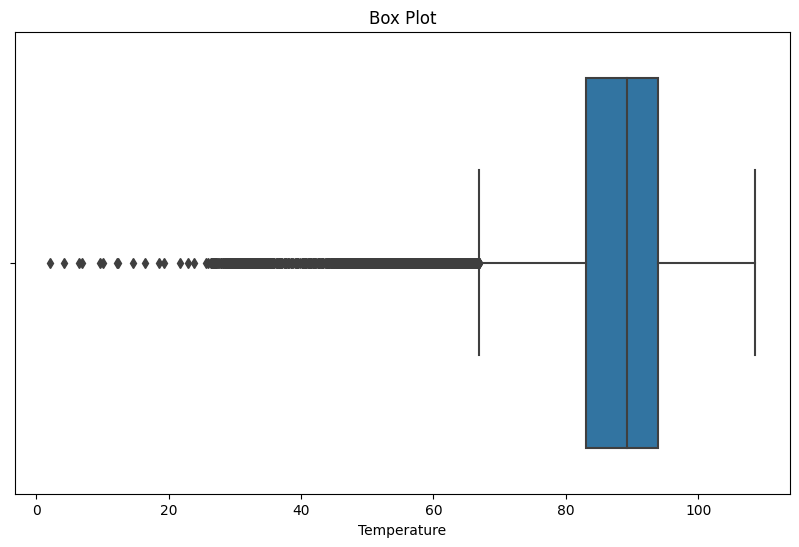

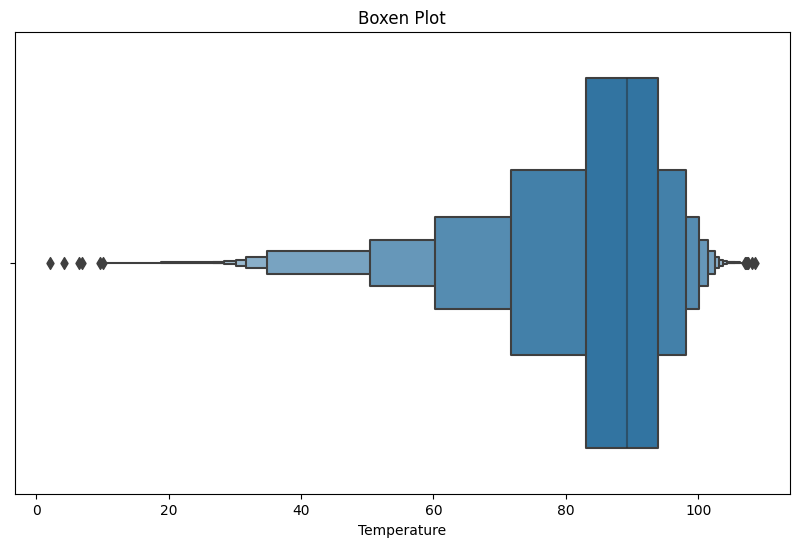

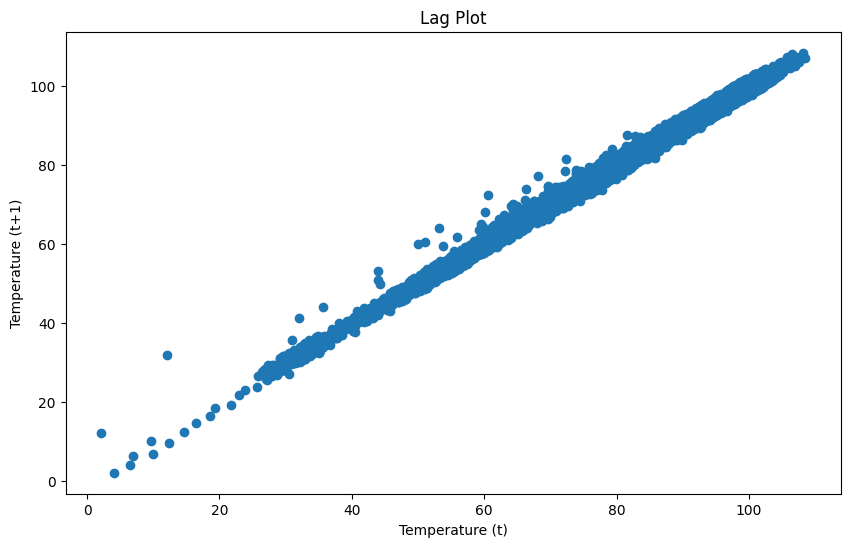

Outliers (IQR method):
Series([], Name: temperature, dtype: float64)


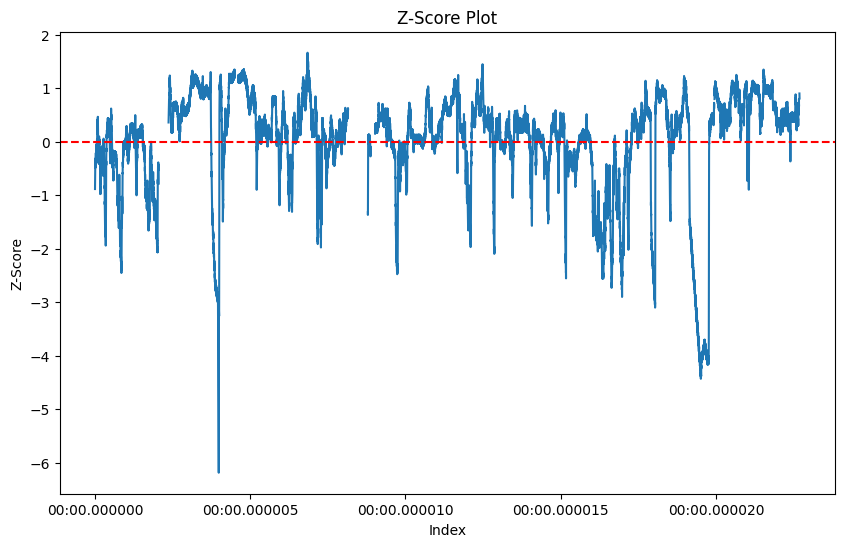

In [ ]:
import seaborn as sns
from pandas.plotting import lag_plot

# box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x=df['temperature'])
plt.xlabel('Temperature')
plt.title('Box Plot')
plt.show()

#  boxen plot
plt.figure(figsize=(10, 6))
sns.boxenplot(x=df['temperature'])
plt.xlabel('Temperature')
plt.title('Boxen Plot')
plt.show()

# lag plot
plt.figure(figsize=(10, 6))
lag_plot(df['temperature'])
plt.xlabel('Temperature (t)')
plt.ylabel('Temperature (t+1)')
plt.title('Lag Plot')
plt.show()


def iqr_outliers(data):
    Q1 = np.percentile(data, 25)
    Q3 = np.percentile(data, 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = data[(data < lower_bound) | (data > upper_bound)]
    return outliers


outliers_iqr = iqr_outliers(df['temperature'])
print("Outliers (IQR method):")
print(outliers_iqr)


z_scores = (df['temperature'] - df['temperature'].mean()) / df['temperature'].std()


plt.figure(figsize=(10, 6))
plt.plot(z_scores)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Index')
plt.ylabel('Z-Score')
plt.title('Z-Score Plot')
plt.show()
